# SoC Classification Inference

## Setup

In [1]:
%pip install fastai==2.5.3 -q -U
%pip freeze

Note: you may need to restart the kernel to use updated packages.
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1666191106763/work/dist
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1640817743617/work
argon2-cffi-bindings @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi-bindings_1666850859330/work
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1659291887007/work
backcall @ file:///home/conda/feedstock_root/build_artifacts/backcall_1592338393461/work
backports.functools-lru-cache @ file:///home/conda/feedstock_root/build_artifacts/backports.functools_lru_cache_1618230623929/work
beautifulsoup4 @ file:///home/conda/feedstock_root/build_artifacts/beautifulsoup4_1649463573192/work
bleach @ file:///home/conda/feedstock_root/build_artifacts/bleach_1656355450470/work
blis==0.7.9
catalogue==2.0.8
certifi==2022.12.7
cffi @ file:///home/conda/feedstock_root/build_artifacts/cffi_1666754707314/work
charset-normalizer==

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fastai.vision.all import *
import sys

In [3]:
# Load EB_ML python libraries
# The following libraries are used in this notebook and should be installed in your local machine before running this notebook.
# eb_colab_utils.py
# eb_ml_battery_lib.py
# eb_ml_utils.py

# path to load external *.py files used in this notebook
# Note: in Google Colab virtual machine you shoud copy the files in "/content" folder after BEFORE running this notebook's cell

external_python_file_path="/home/studio-lab-user/code"
sys.path.append(external_python_file_path)

In [4]:
from ml4measurement.eb_ml_utils import score_model,build_learner,build_data_loader
from ml4measurement.eb_ml_colab_utils import get_root_path
from ml4measurement.eb_ml_battery_lib import generate_image_files_from_measure_table

# Experiment configuration 

In [5]:
import yaml

config_file = '../config/config.yaml'

#Read the configuration
with open(config_file) as cfg_file:
    config = yaml.load(stream = cfg_file, Loader = yaml.FullLoader)

In [6]:
# Map the working folder to Google Drive if is running in Google Colab environment
config['ROOT_DIR'] = get_root_path(config['working_folder'])

NOT running on COLAB


In [7]:
config['Splitter'] = RandomSplitter(valid_pct=0.3, seed=41)
config['rePat'] = r'^.*_(\d+).png$'

# Load Measurement Dataset

In [8]:
from LiBEIS.code.utilities import read_measurement_table

# Load dataset using LiBEIS 
_, meas_table_wide, battery_id_col_name, freq_id_col_name, impedance_col_name, measure_id_col_name, soc_col_name = read_measurement_table(config_file)

indices = np.arange(meas_table_wide.shape[0]).astype(np.uint)

/home/studio-lab-user/soc-estimation-jan23/code/LiBEIS/code/utilities.py:77: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  meas_table_wide = meas_table_tall.pivot(primary_key, freq_id_col_name)


In [9]:
meas_table_wide

MEASURE_ID  SOC BATTERY_ID     IMPEDANCE_VALUE  \
FREQUENCY_ID                                              0   
0                  02_4   10          2  0.117933-0.006453j   
1                  02_4   20          2  0.108914-0.004577j   
2                  02_4   30          2  0.105084-0.003881j   
3                  02_4   40          2  0.104545-0.003870j   
4                  02_4   50          2  0.103768-0.004256j   
..                  ...  ...        ...                 ...   
235                06_8   60          6  0.105475-0.005807j   
236                06_8   70          6  0.104604-0.006193j   
237                06_8   80          6  0.103358-0.005761j   
238                06_8   90          6  0.103680-0.005234j   
239                06_8  100          6  0.102012-0.004807j   

                                                                          \
FREQUENCY_ID                   1                   2                   3   
0             0.115688-0.005226j  0.114258-0.004235j  0.113243-0.003809j   
1             0.107390-0.003691j  0.106296-0.002381j  0.105806-0.002027j   
2             0.103869-0.003199j  0.103098-0.002013j  0.102843-0.001713j   
3             0.103324-0.002926j  0.102673-0.002098j  0.102103-0.001555j   
4             0.102449-0.003355j  0.101666-0.002424j  0.101108-0.001858j   
..                           ...                 ...                 ...   
235           0.103037-0.005163j  0.101439-0.003260j  0.100950-0.002266j   
236           0.102764-0.004643j  0.101474-0.003235j  0.100668-0.002506j   
237           0.101491-0.004417j  0.100160-0.003028j  0.099628-0.002222j   
238           0.102111-0.004055j  0.100888-0.002762j  0.100350-0.002017j   
239           0.101459-0.002807j  0.100853-0.002208j  0.100232-0.001664j   

                                                                          \
FREQUENCY_ID                   4                   5                   6   
0             0.111026-0.004652j  0.109057-0.005699j  0.106340-0.006653j   
1             0.104751-0.002257j  0.103965-0.002888j  0.102727-0.004009j   
2             0.101968-0.001720j  0.101440-0.002340j  0.100473-0.003114j   
3             0.101310-0.001838j  0.100783-0.002343j  0.100185-0.002937j   
4             0.099993-0.001833j  0.099596-0.002300j  0.099106-0.002856j   
..                           ...                 ...                 ...   
235           0.099744-0.002003j  0.099114-0.002131j  0.098424-0.002288j   
236           0.099592-0.001932j  0.098702-0.002253j  0.098120-0.002294j   
237           0.098459-0.001881j  0.097915-0.001947j  0.097327-0.002187j   
238           0.099374-0.001809j  0.098816-0.001959j  0.098189-0.002165j   
239           0.099547-0.001447j  0.099191-0.001673j  0.098627-0.002070j   

                                                                          \
FREQUENCY_ID                   7                   8                   9   
0             0.101733-0.007526j  0.097836-0.007710j  0.094492-0.007356j   
1             0.099835-0.005825j  0.096654-0.006610j  0.093300-0.006884j   
2             0.098450-0.004741j  0.095612-0.006006j  0.092412-0.006553j   
3             0.097745-0.004520j  0.095411-0.005965j  0.092198-0.006490j   
4             0.096909-0.004247j  0.094556-0.005593j  0.091448-0.006259j   
..                           ...                 ...                 ...   
235           0.096977-0.003218j  0.095176-0.004172j  0.092986-0.004747j   
236           0.096754-0.003253j  0.095009-0.003961j  0.092899-0.004740j   
237           0.096023-0.002886j  0.094421-0.003751j  0.092544-0.004401j   
238           0.096783-0.003066j  0.095252-0.004004j  0.093130-0.004682j   
239           0.097250-0.003201j  0.095518-0.004299j  0.093175-0.004895j   

                                                                          \
FREQUENCY_ID                  10                  11                  12   
0             0.090119-0.006749j  0.086891-0.006165j  0.084373-0.005057j  

config['models_path']# Model Ensamble

Inference with model ensamble on Test Data 

In [10]:
def score_model_on_test_dataset(test_image_dataset_path,experiment_runs_list,saved_weights_files):
    experiments_predictions = []
    experiments_predictions_decoded=[]

    exeperiments_targets = []

    models_accuracy = []

    models_top2_accuracy = []

    test_fnames= get_image_files(test_image_dataset_path)
    for experiment_index in range(0,len(experiment_runs_list),1):
      print("ExperimentName: "+str(experiment_runs_list[experiment_index]))
      saved_weights=saved_weights_files[experiment_index]
      print("saved weights files: "+saved_weights)
        
      config['ExperimentName'] = experiment_runs_list[experiment_index]
      config['IMAGES_PATH'] = config['root_images_path']+"/"+config['ExperimentName']

      # BUILD LEARNER
      learn=build_learner(config)

      #SCORE MODEL ON VALIDATION DATASET
      score_model(saved_weights,learn.dls,config['models_path'])
        
      #SCORE MODEL ON TEST DATASET
      learn.load(saved_weights)


      test_dl = learn.dls.test_dl(test_fnames,with_labels=True)
      predictions, targets, decoded = learn.get_preds(dl=test_dl, with_decoded=True)
      experiments_predictions.append(predictions)
      experiments_predictions_decoded.append(decoded)
      exeperiments_targets.append(targets)
      model_accuracy= accuracy(predictions,targets)
      models_accuracy.append(model_accuracy)
      from sklearn.metrics import top_k_accuracy_score
      model_top2_accuracy= top_k_accuracy_score(targets, predictions, k=2)
      models_top2_accuracy.append(model_top2_accuracy)
      print("model_accuracy on test dataset: " + str(model_accuracy))
      print("model_top2_accuracy on test dataset: " + str(model_top2_accuracy))
    return experiments_predictions,exeperiments_targets,experiments_predictions_decoded, models_accuracy,model_top2_accuracy
    

# Leave One Battery Out New Battery Test Case -  Mode: Bode

In [11]:
experiment_runs_list=['Paper_MES_v2_leave_one_out_BATT02_Exp_0','Paper_MES_v2_leave_one_out_BATT03_Exp_0','Paper_MES_v2_leave_one_out_BATT05_Exp_0'] 
saved_weights_files= ['Paper_MES_v2_leave_one_out_BATT02_Exp_0_1674171288.702184_SAVED',
                      'Paper_MES_v2_leave_one_out_BATT03_Exp_0_1674171562.600012_SAVED',
                      'Paper_MES_v2_leave_one_out_BATT05_Exp_0_1674171856.034339_SAVED',
                      ]
test_image_dataset_path= "../data/test_images/Test_dataset_NEW_BATT_Exp_0"



ExperimentName: Paper_MES_v2_leave_one_out_BATT02_Exp_0
saved weights files: Paper_MES_v2_leave_one_out_BATT02_Exp_0_1674171288.702184_SAVED
Setting-up type transforms pipelines
Found 1100 items
2 datasets of sizes 770,330
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      ../data/images/Paper_MES_v2_leave_one_out_BATT02_Exp_0/Paper_MES_v2_leave_one_out_BATT02_Exp_0-03_5002_20.png
    applying PILBase.create gives
      PILImage mode=RGB size=640x480
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../data/images/Paper_MES_v2_leave_one_out_BATT02_Exp_0/Paper_MES_v2_leave_one_out_BATT02_Exp_0-03_5002_20.png
    applying RegexLabeller gives
      20
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(2)

Final sample: (PIL

[[36  0  0  0  0  0  0  0  0  0]
 [ 0 41  0  0  1  0  0  0  0  0]
 [ 0  0 25  0  0  0  0  0  0  0]
 [ 0  0  0 24  0  1  0  0  0  0]
 [ 0  0  0  6 27  1  0  0  0  0]
 [ 0  0  0  0  0 28  0  0  0  0]
 [ 0  0  0  0  0  0 38  0  0  0]
 [ 0  0  0  0  0  0  0 27 12  0]
 [ 0  0  0  0  0  0  0 10 27  2]
 [ 0  0  0  0  0  0  0  0  0 24]]
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.97619048 0.         0.         0.02380952 0.
  0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.96       0.         0.04
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.17647059 0.79411765 0.02941176
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        ]
 [0.         0.  

learn.validate()


Model accuracy: 0.90
learn.get_preds()


model_accuracy on test dataset: TensorBase(0.8100)
model_top2_accuracy on test dataset: 0.968
ExperimentName: Paper_MES_v2_leave_one_out_BATT03_Exp_0
saved weights files: Paper_MES_v2_leave_one_out_BATT03_Exp_0_1674171562.600012_SAVED
Setting-up type transforms pipelines
Found 1100 items
2 datasets of sizes 770,330
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      ../data/images/Paper_MES_v2_leave_one_out_BATT03_Exp_0/Paper_MES_v2_leave_one_out_BATT03_Exp_0-02_5002_20.png
    applying PILBase.create gives
      PILImage mode=RGB size=640x480
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../data/images/Paper_MES_v2_leave_one_out_BATT03_Exp_0/Paper_MES_v2_leave_one_out_BATT03_Exp_0-02_5002_20.png
    applying RegexLabeller gives
      20
    applying Categorize -- {'

[[36  0  0  0  0  0  0  0  0  0]
 [ 0 40  1  0  0  1  0  0  0  0]
 [ 0  0 24  0  0  1  0  0  0  0]
 [ 0  1  0 24  0  0  0  0  0  0]
 [ 0  0  0  5 28  1  0  0  0  0]
 [ 0  0  0  0  0 28  0  0  0  0]
 [ 0  0  0  0  0  0 38  0  0  0]
 [ 0  0  0  0  0  0  0 31  8  0]
 [ 0  0  0  0  0  0  1 10 28  0]
 [ 0  0  0  0  0  0  0  0  2 22]]
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.95238095 0.02380952 0.         0.         0.02380952
  0.         0.         0.         0.        ]
 [0.         0.         0.96       0.         0.         0.04
  0.         0.         0.         0.        ]
 [0.         0.04       0.         0.96       0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.14705882 0.82352941 0.02941176
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        ]
 [0.     

learn.validate()


Model accuracy: 0.91
learn.get_preds()


model_accuracy on test dataset: TensorBase(0.8060)
model_top2_accuracy on test dataset: 0.936
ExperimentName: Paper_MES_v2_leave_one_out_BATT05_Exp_0
saved weights files: Paper_MES_v2_leave_one_out_BATT05_Exp_0_1674171856.034339_SAVED
Setting-up type transforms pipelines
Found 1200 items
2 datasets of sizes 840,360
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      ../data/images/Paper_MES_v2_leave_one_out_BATT05_Exp_0/Paper_MES_v2_leave_one_out_BATT05_Exp_0-03_6003_100.png
    applying PILBase.create gives
      PILImage mode=RGB size=640x480
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../data/images/Paper_MES_v2_leave_one_out_BATT05_Exp_0/Paper_MES_v2_leave_one_out_BATT05_Exp_0-03_6003_100.png
    applying RegexLabeller gives
      100
    applying Categorize --

[[37  0  0  0  0  0  0  0  0  0]
 [ 0 28  0  2  0  0  0  0  0  0]
 [ 0  0 38  1  0  0  0  0  0  0]
 [ 0  0  0 39  3  0  0  0  0  0]
 [ 0  0  0  6 32  1  0  0  0  0]
 [ 0  0  0  0  0 32  0  0  0  1]
 [ 0  0  0  0  0  0 36  0  0  0]
 [ 0  0  0  0  0  0  0 32  4  0]
 [ 0  0  0  0  0  0  0  7 28  0]
 [ 0  0  0  0  0  0  0  0  2 31]]
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.93333333 0.         0.06666667 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.97435897 0.02564103 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.92857143 0.07142857 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.15384615 0.82051282 0.02564103
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.96969697
  0.         0.         0.         0.03030303]
 [0.       

learn.validate()


Model accuracy: 0.93
learn.get_preds()


model_accuracy on test dataset: TensorBase(0.5200)
model_top2_accuracy on test dataset: 0.78


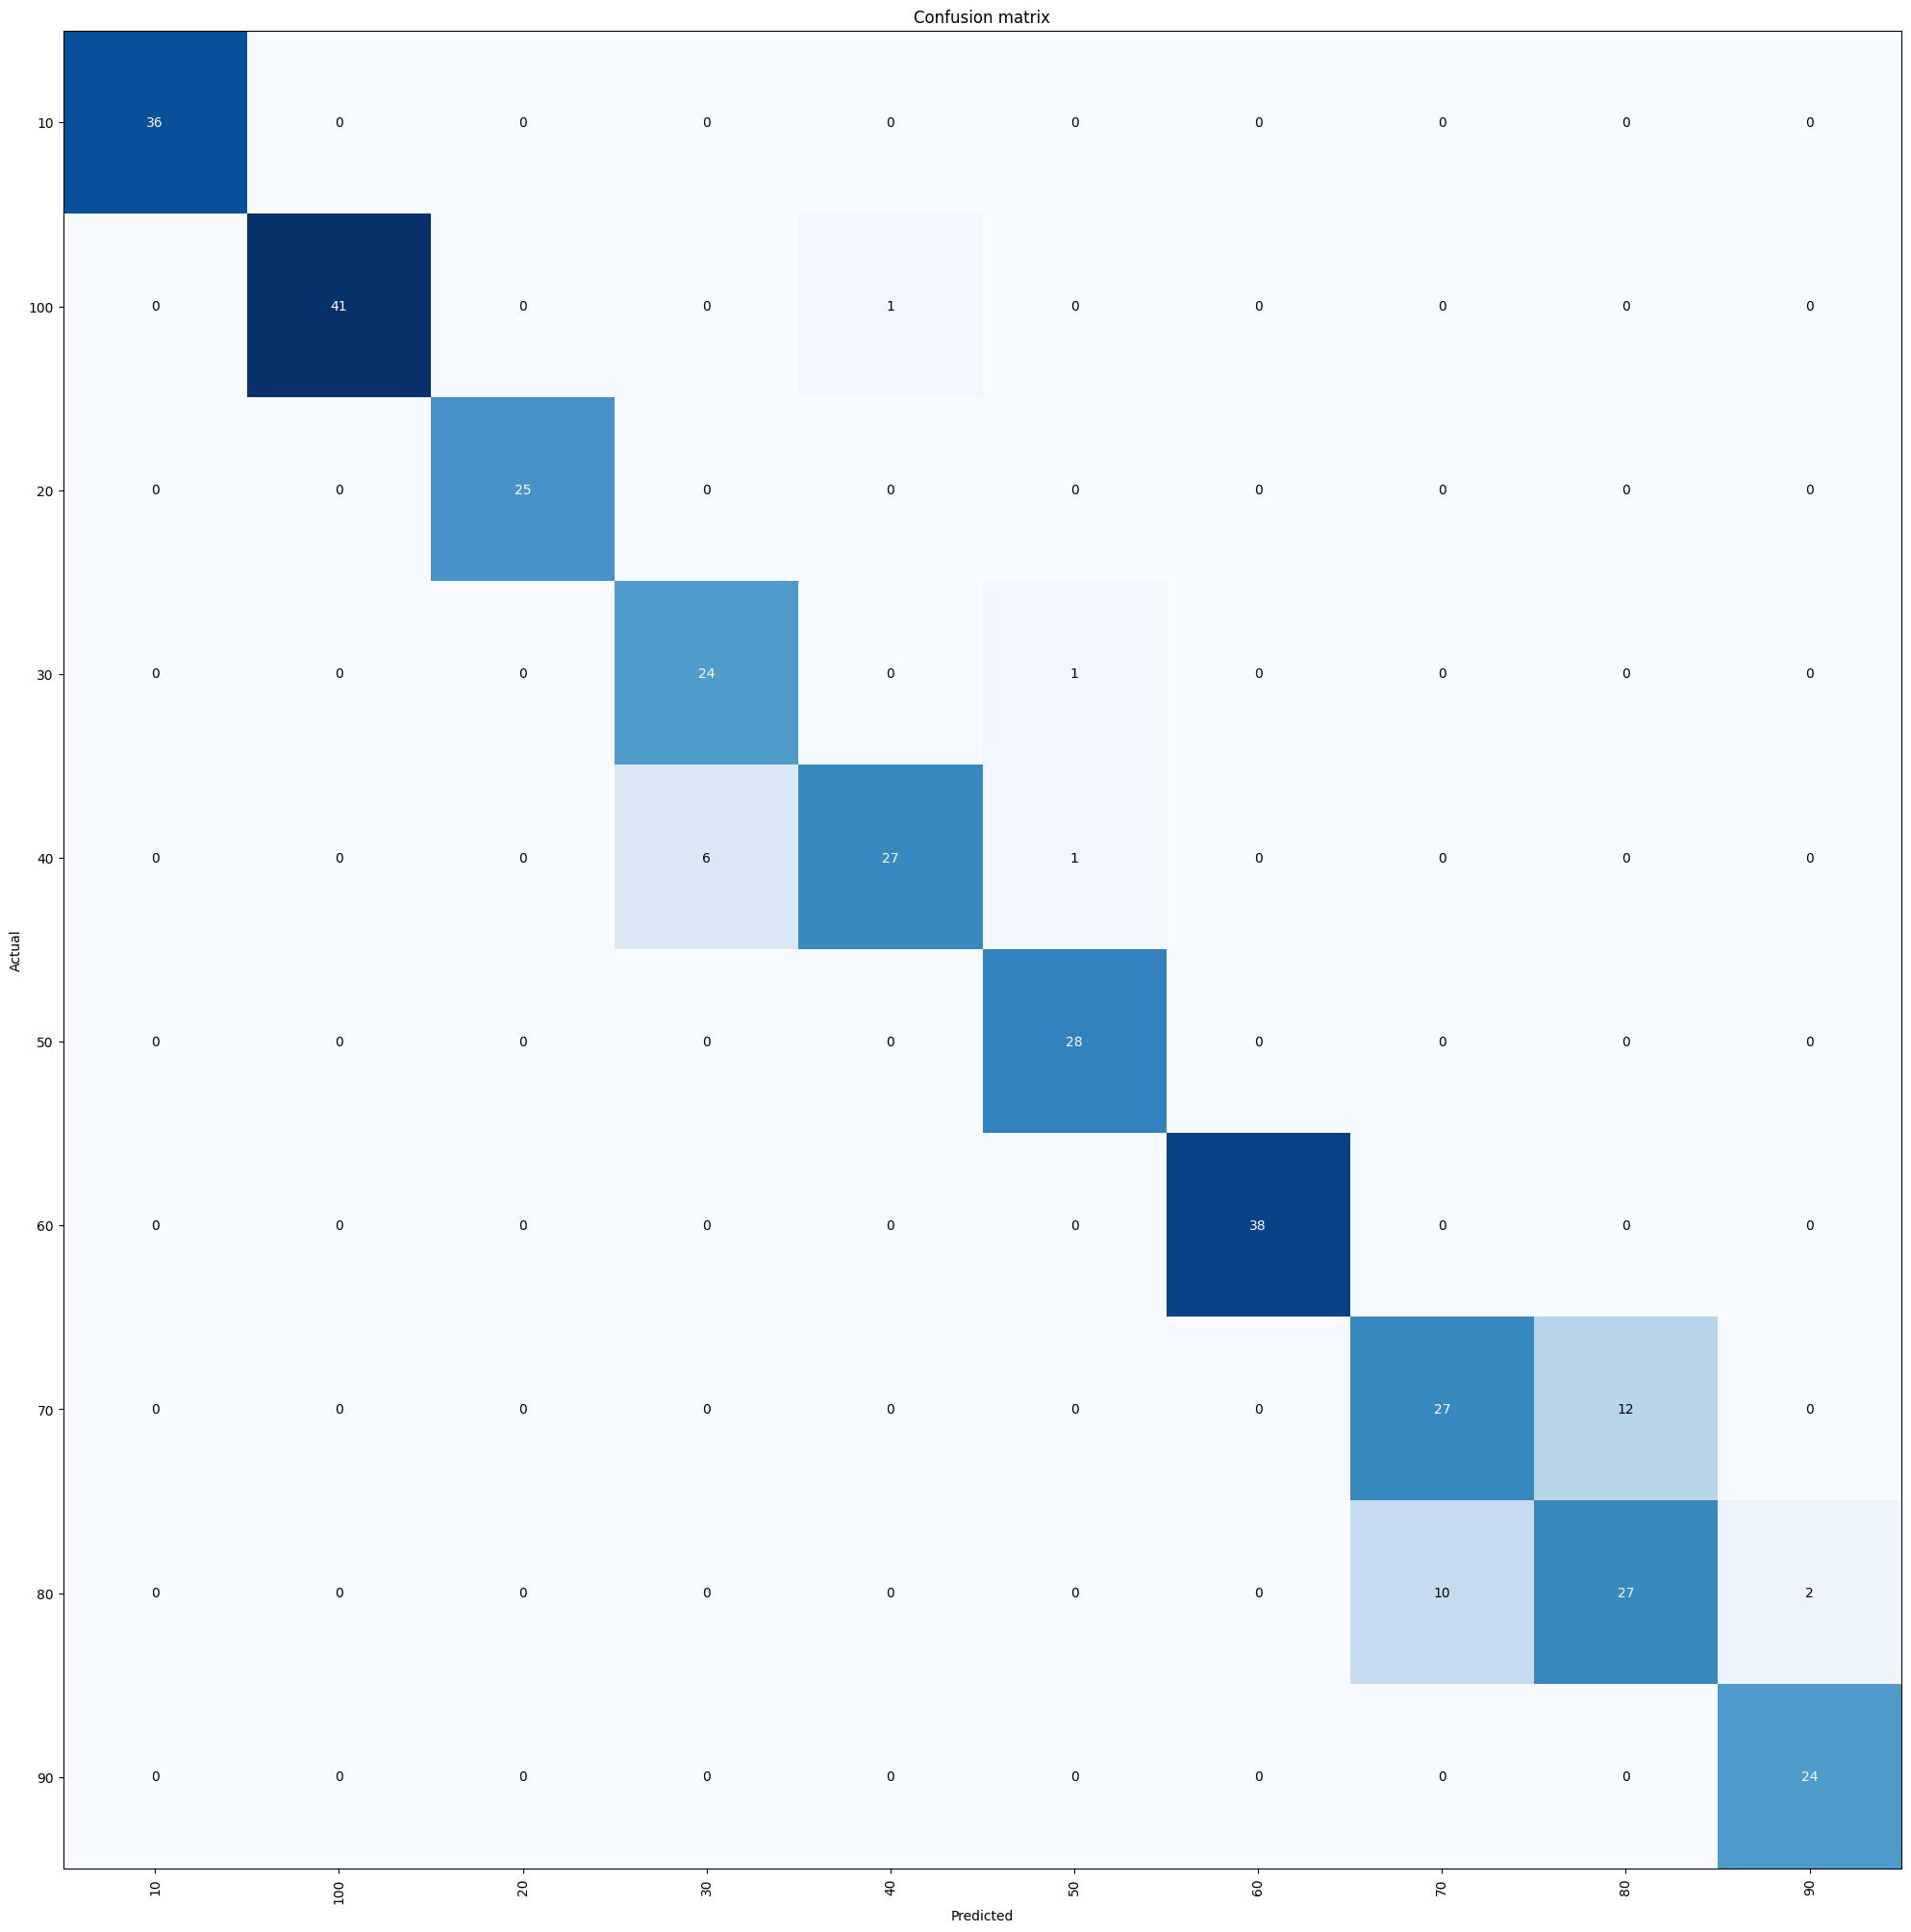

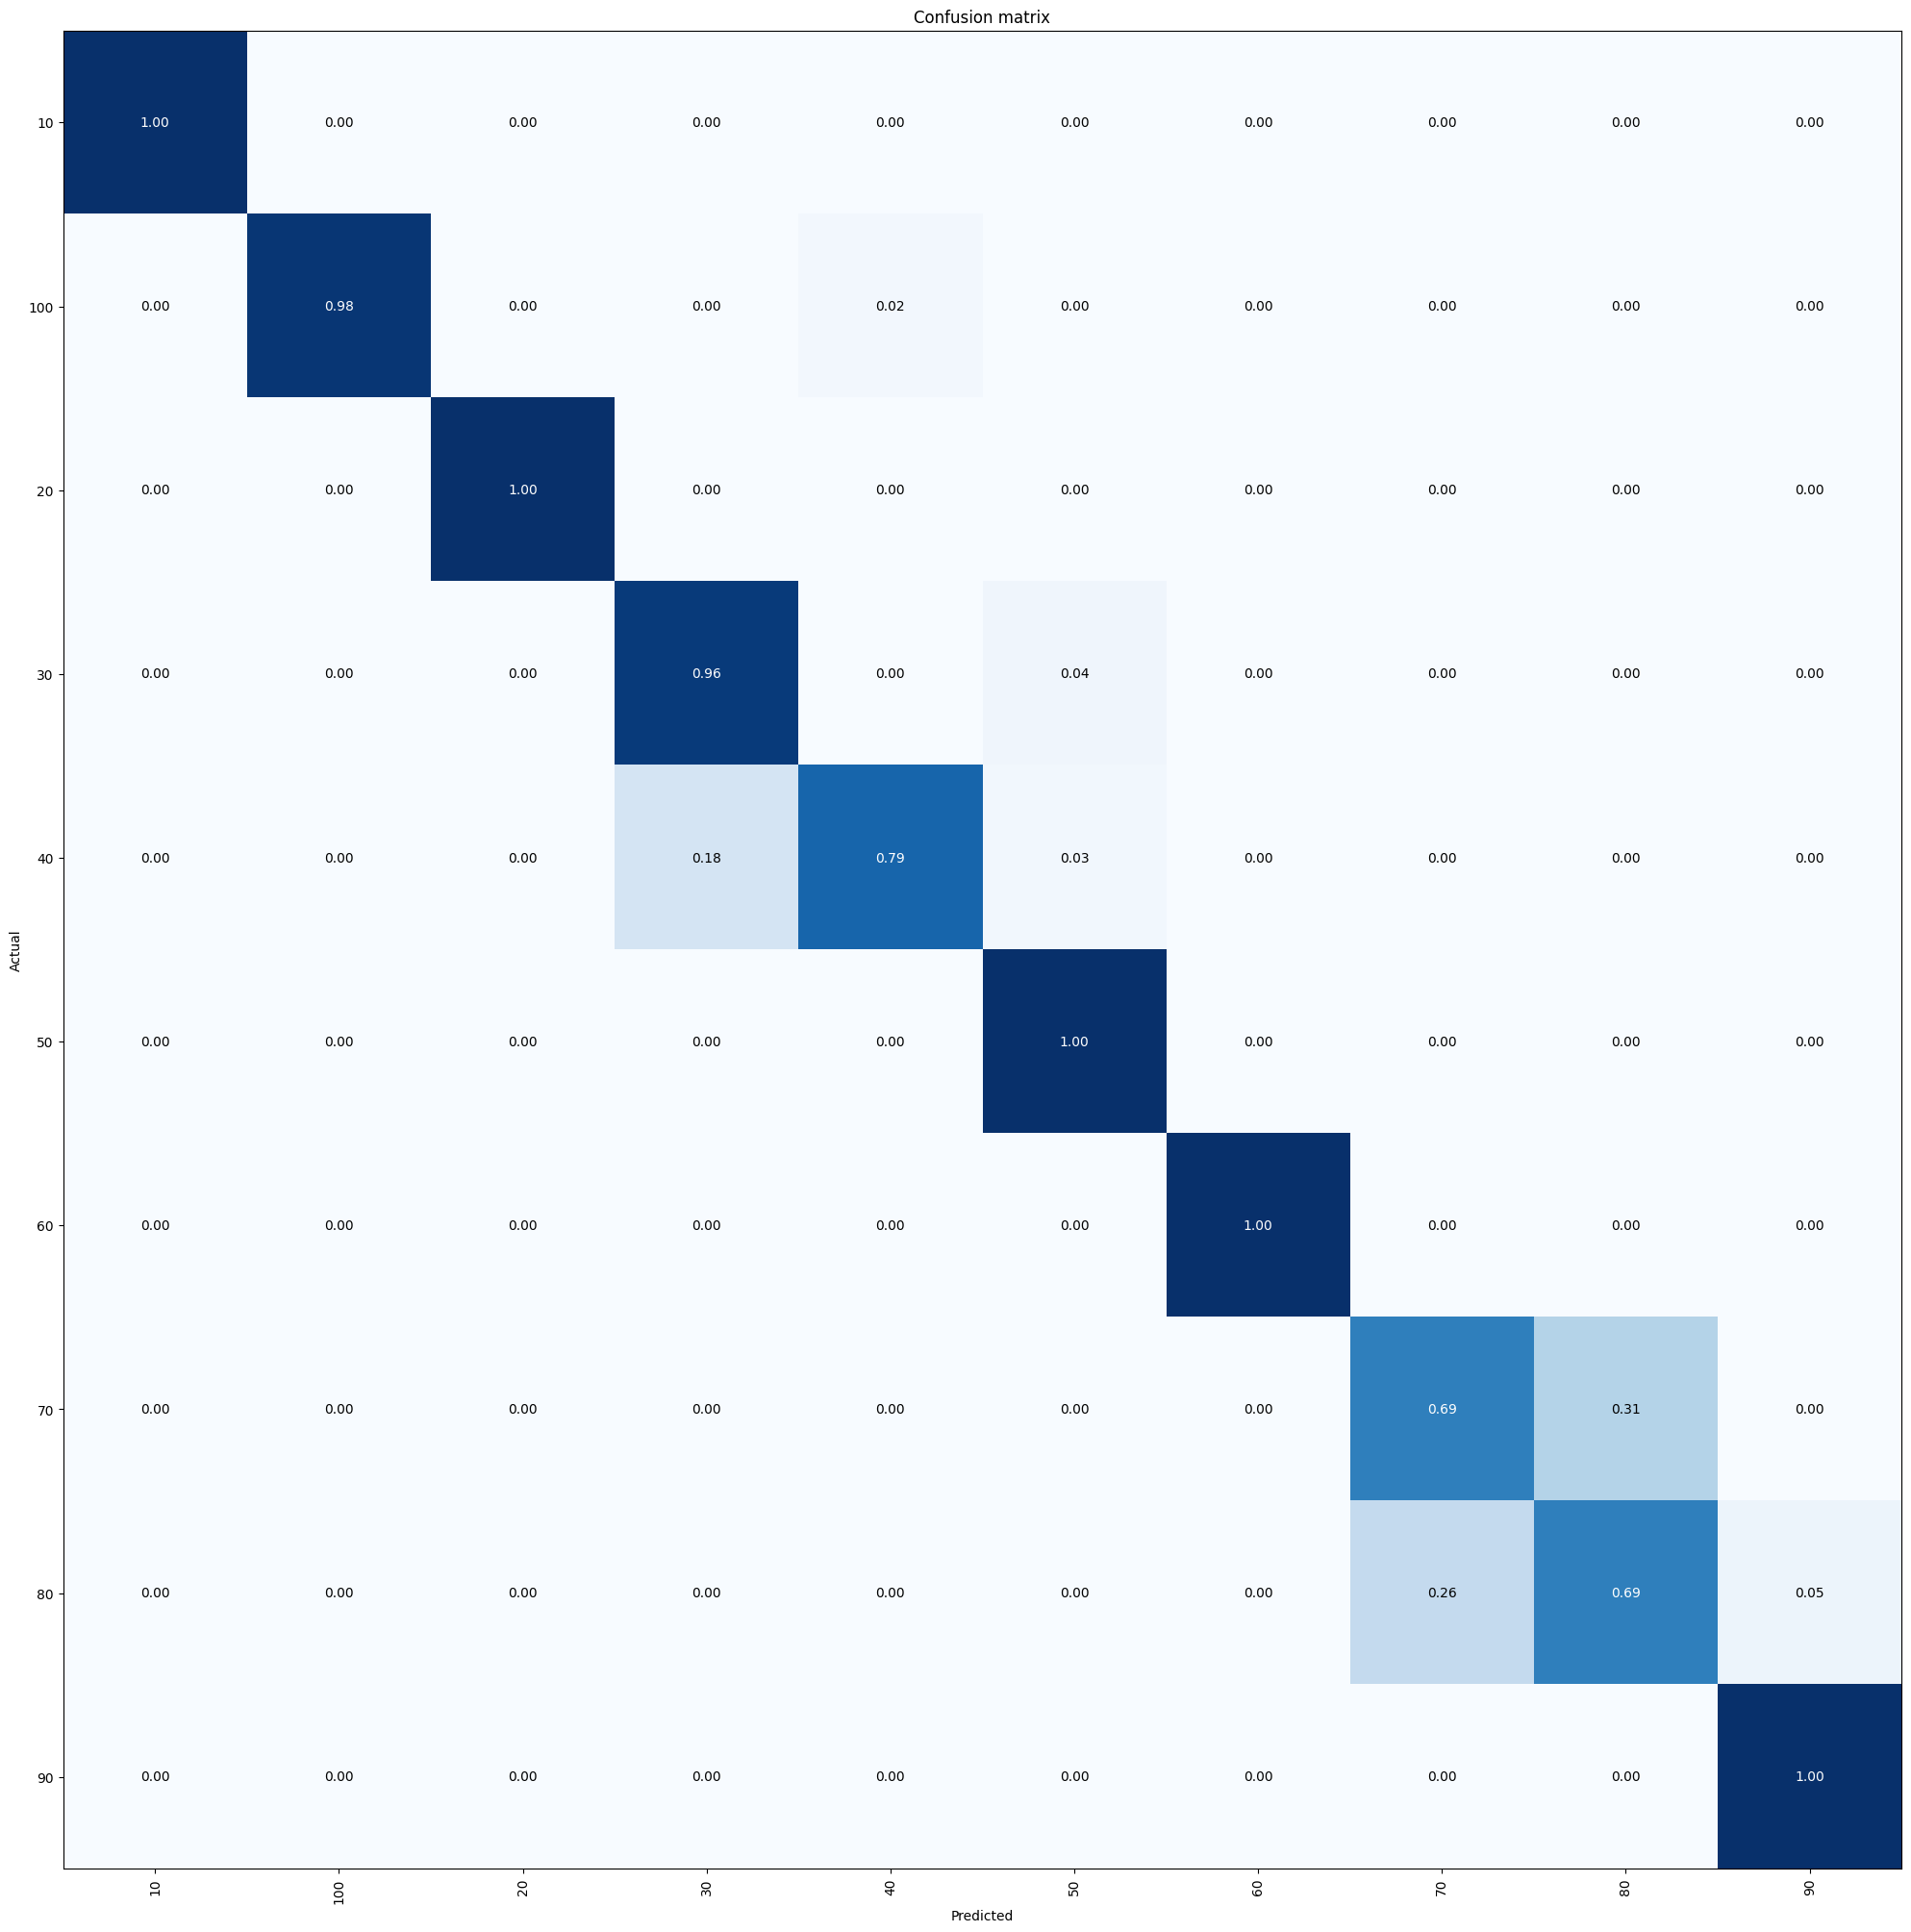

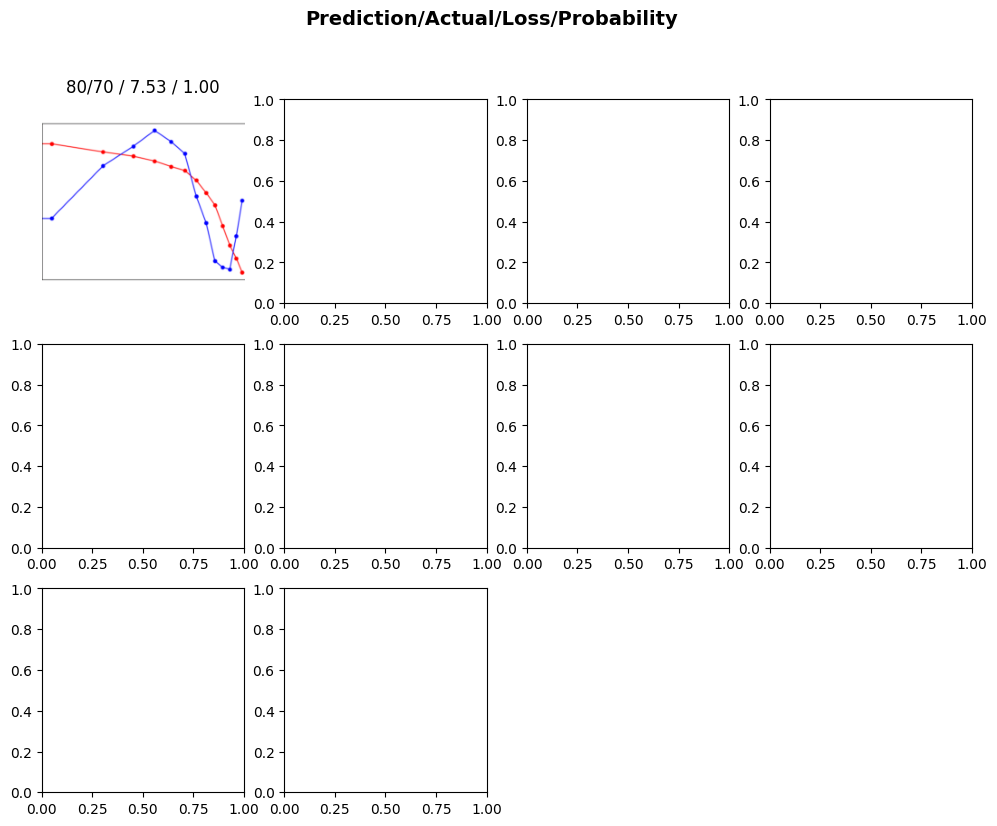

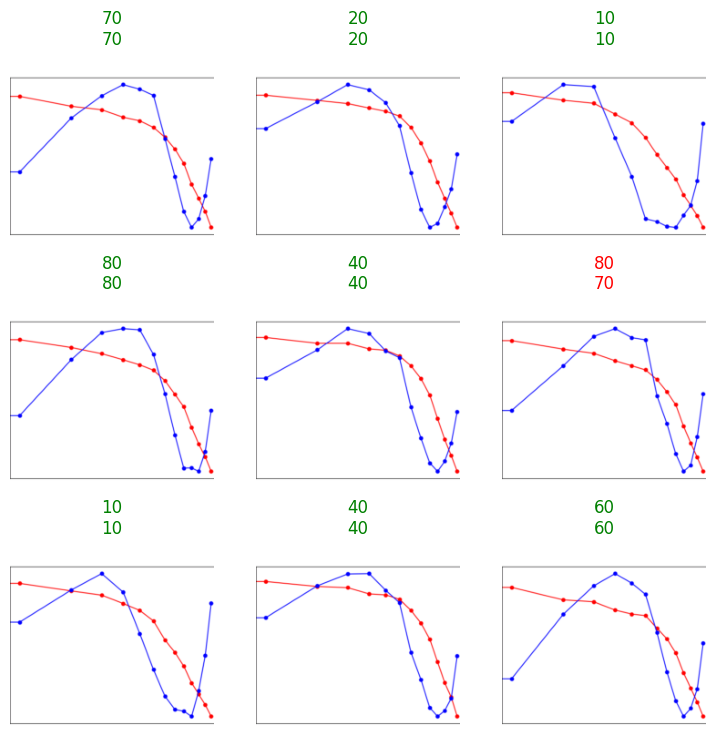

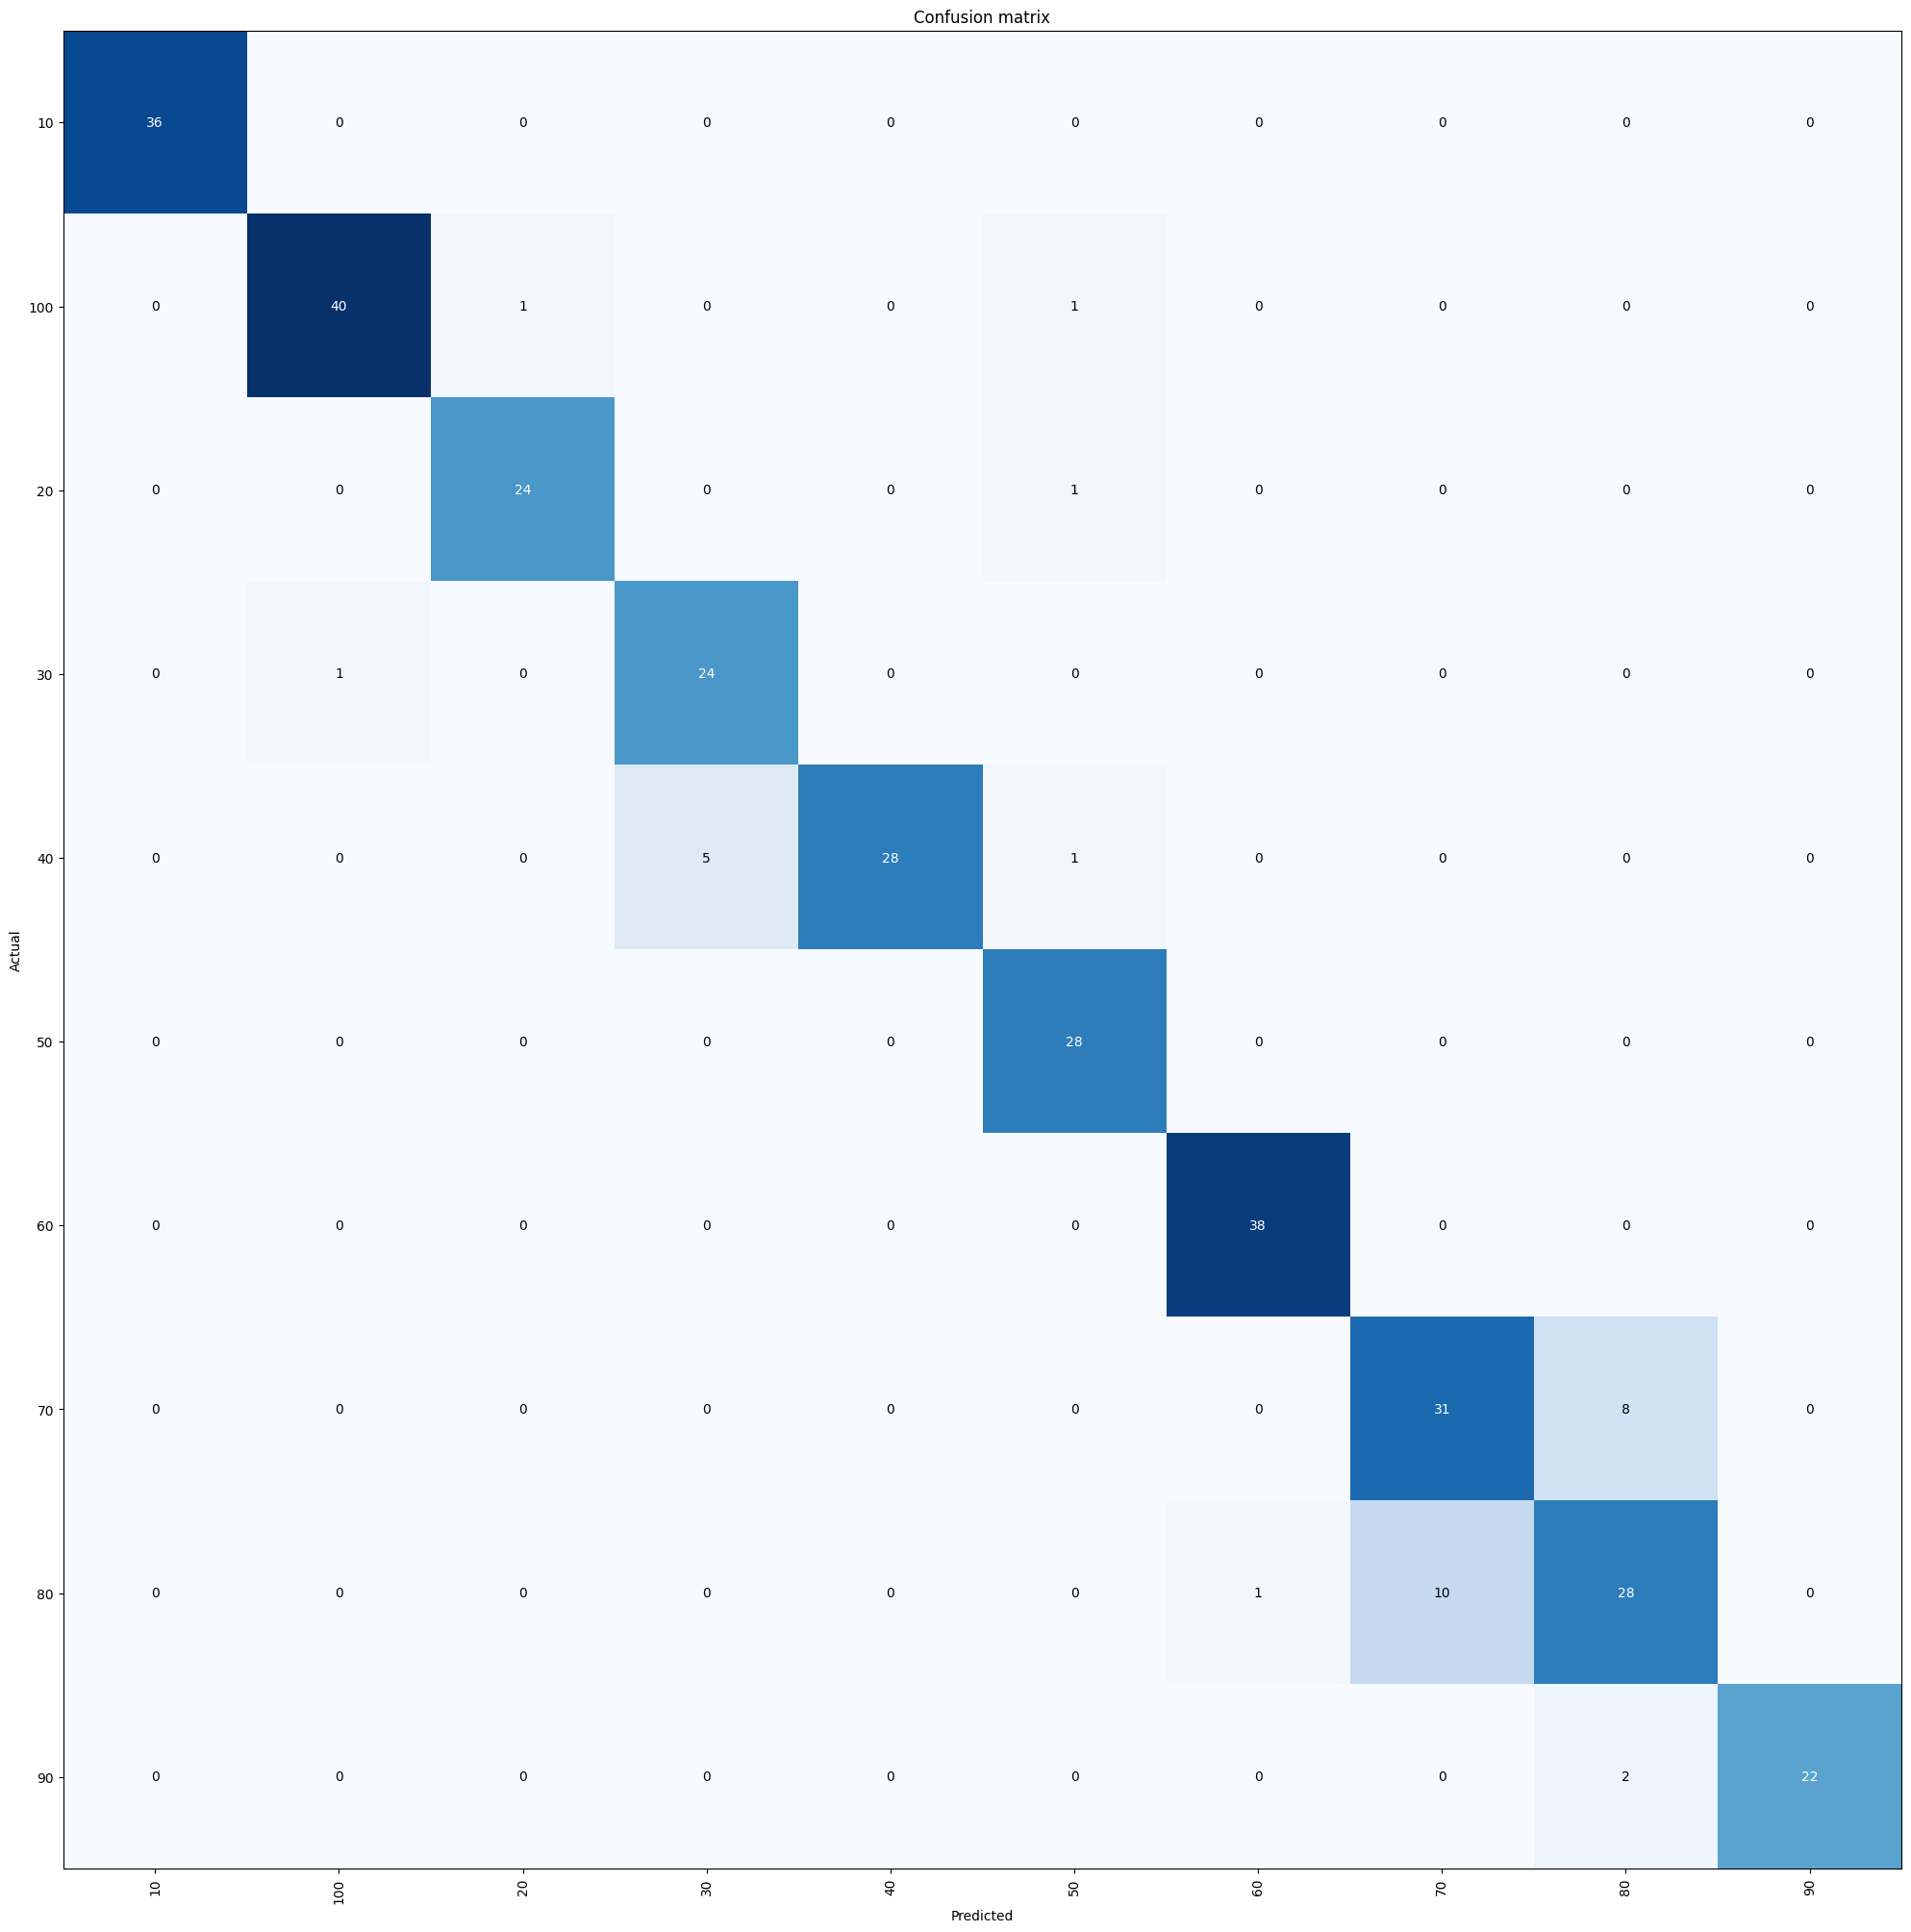

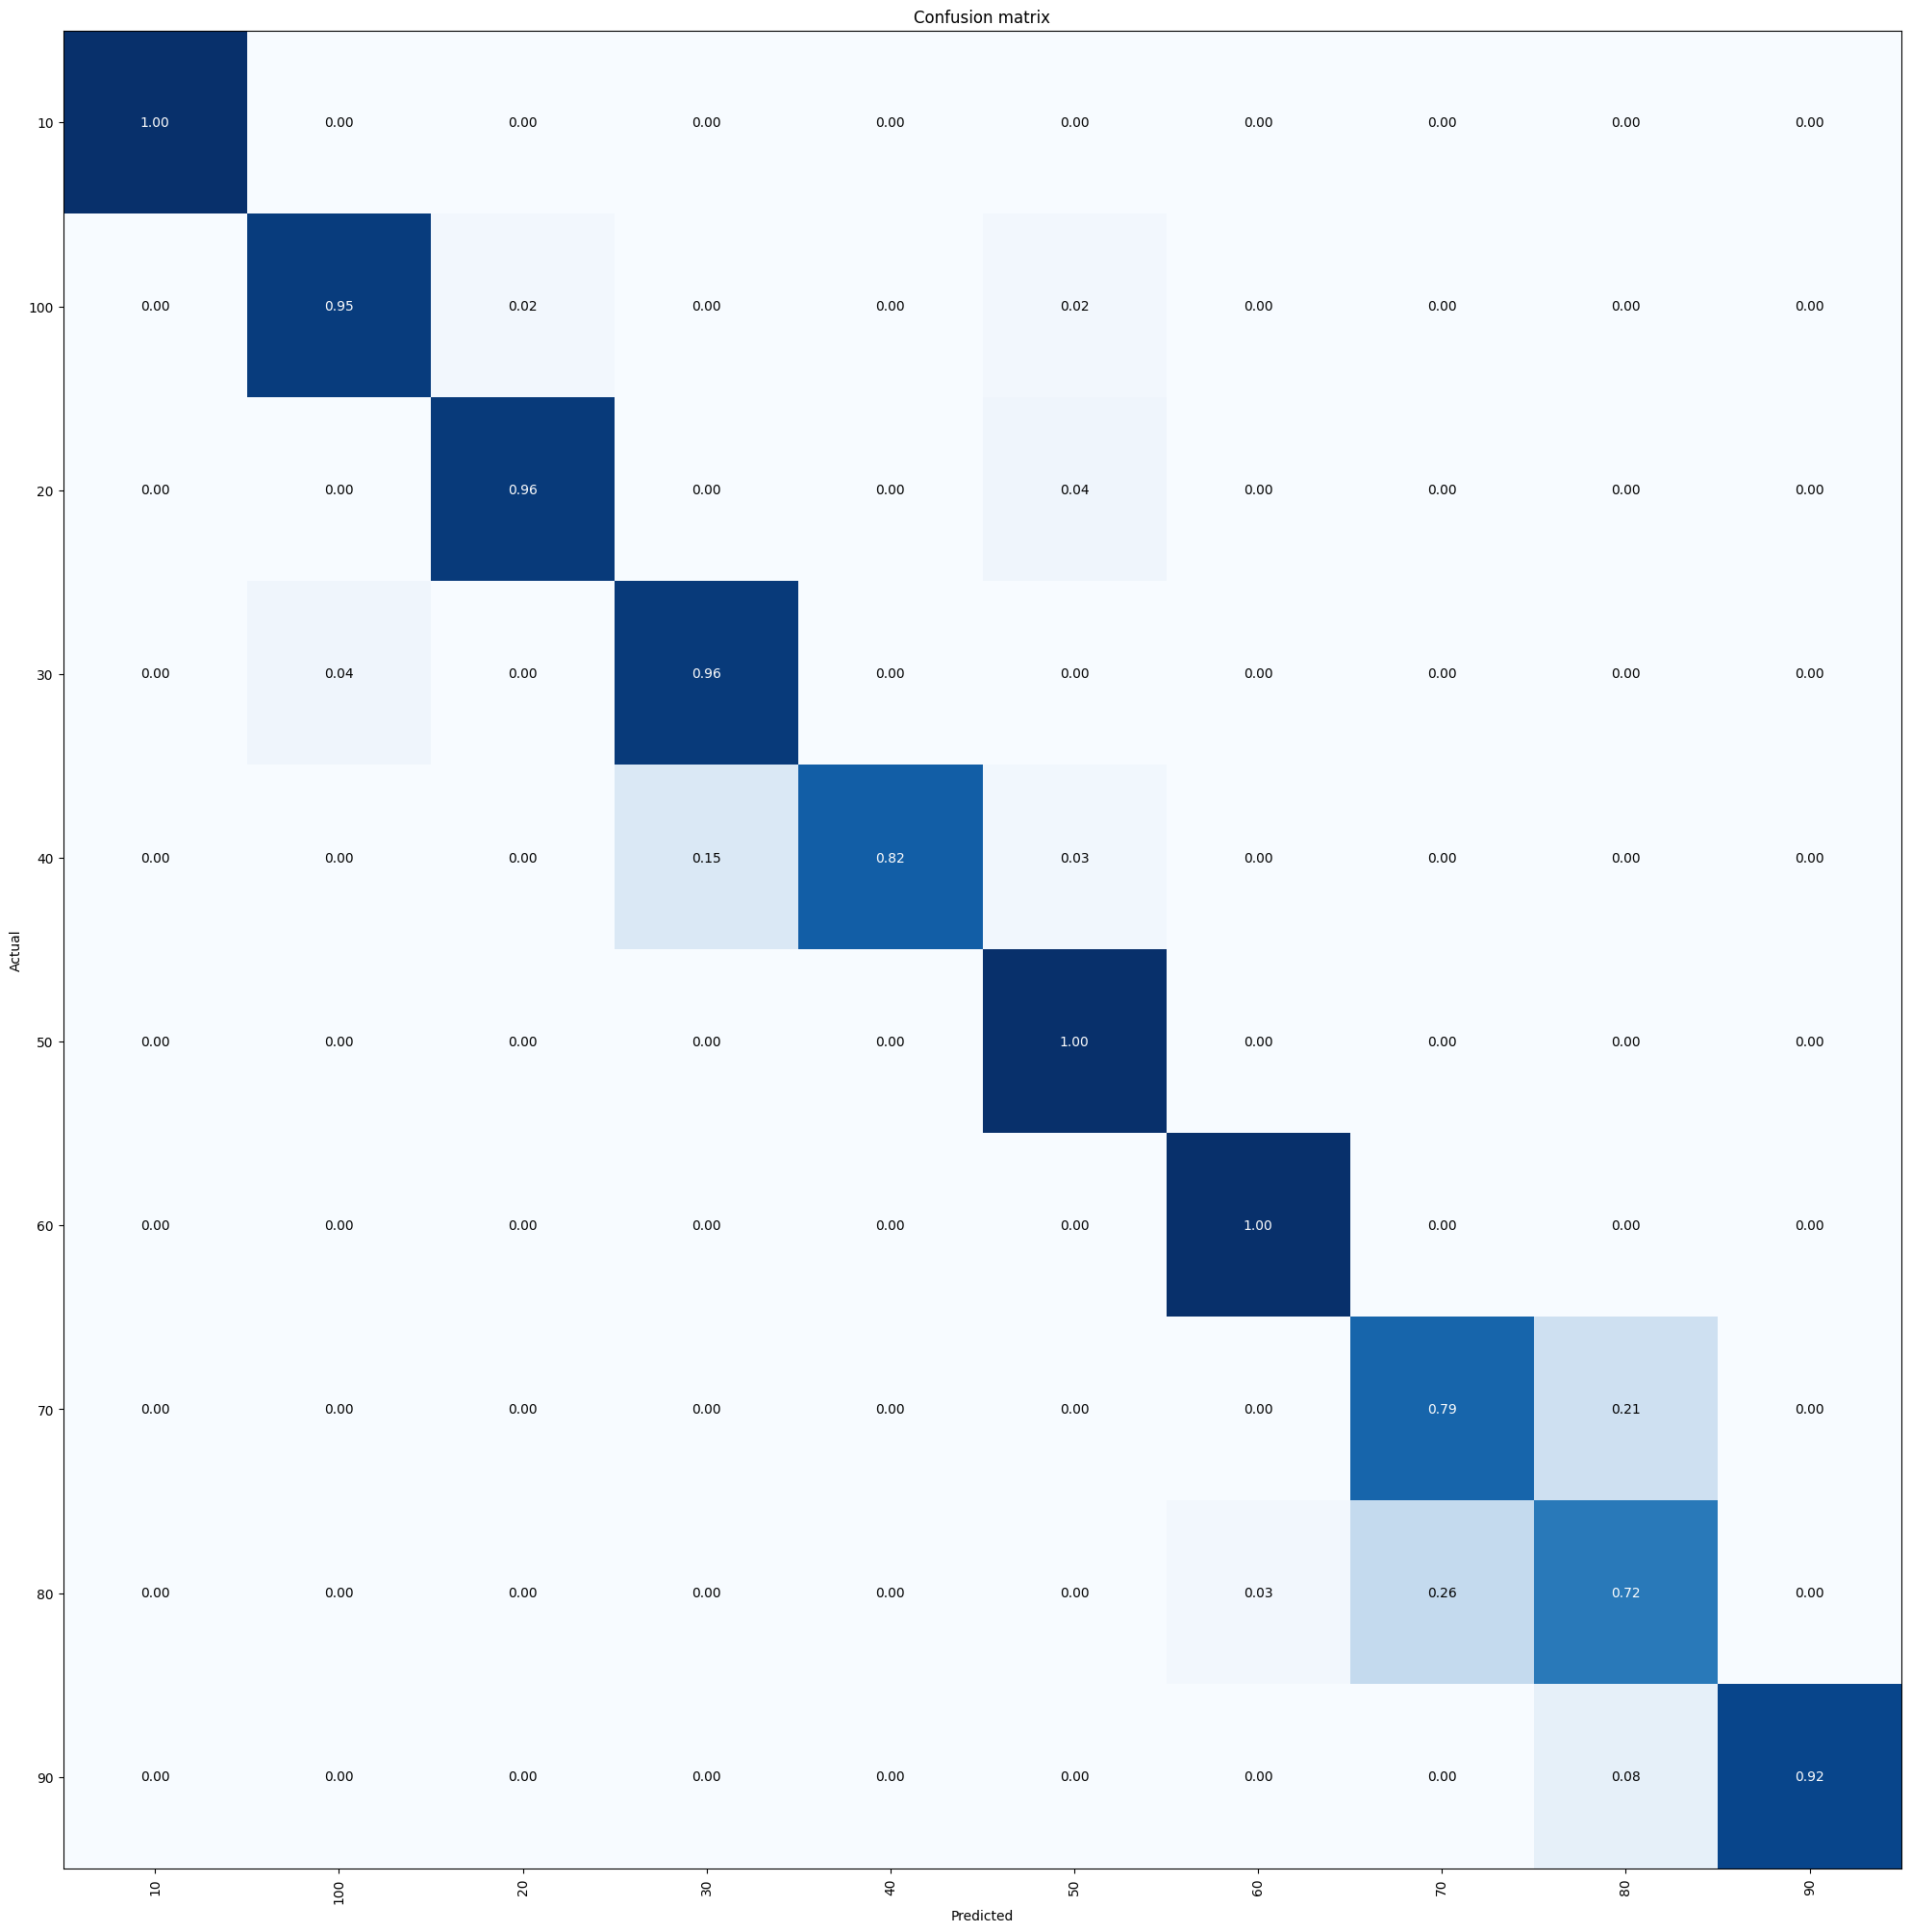

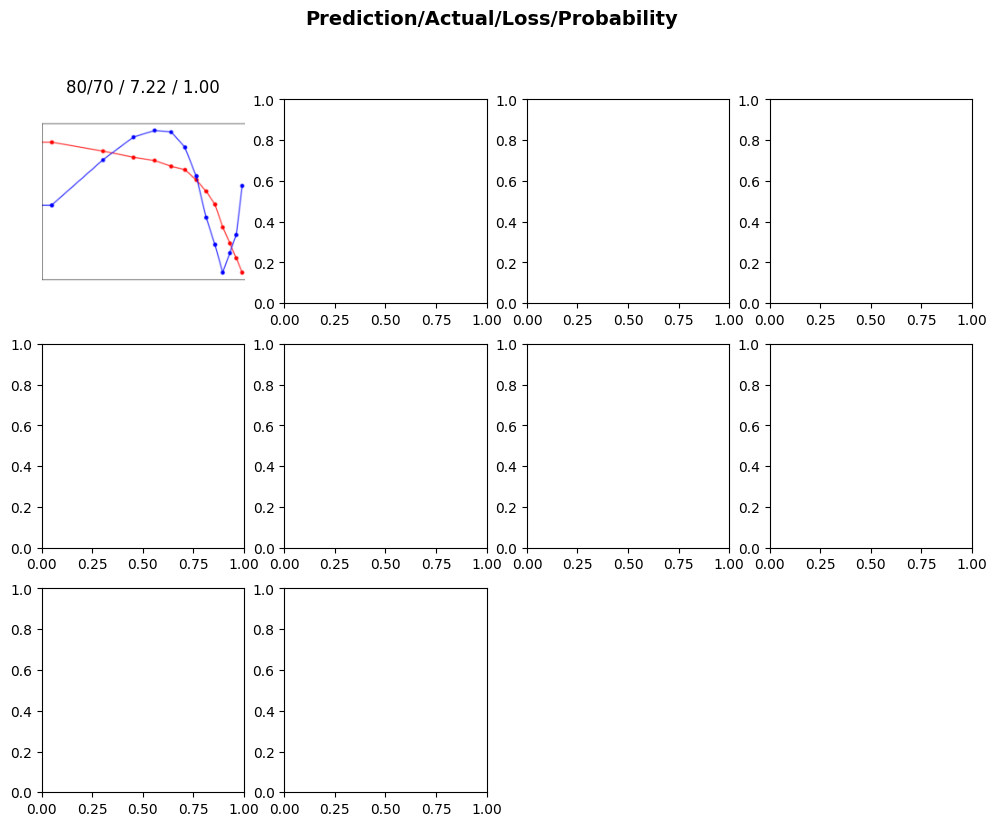

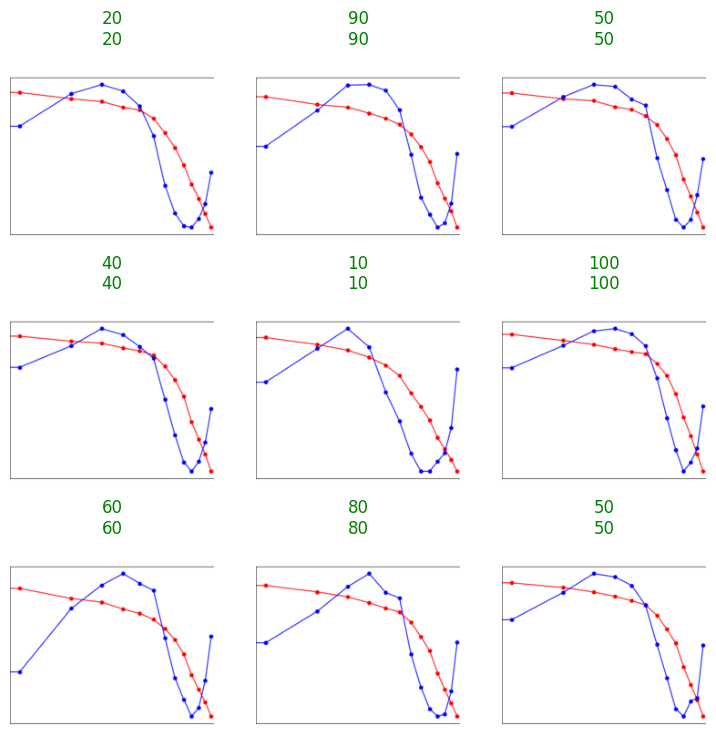

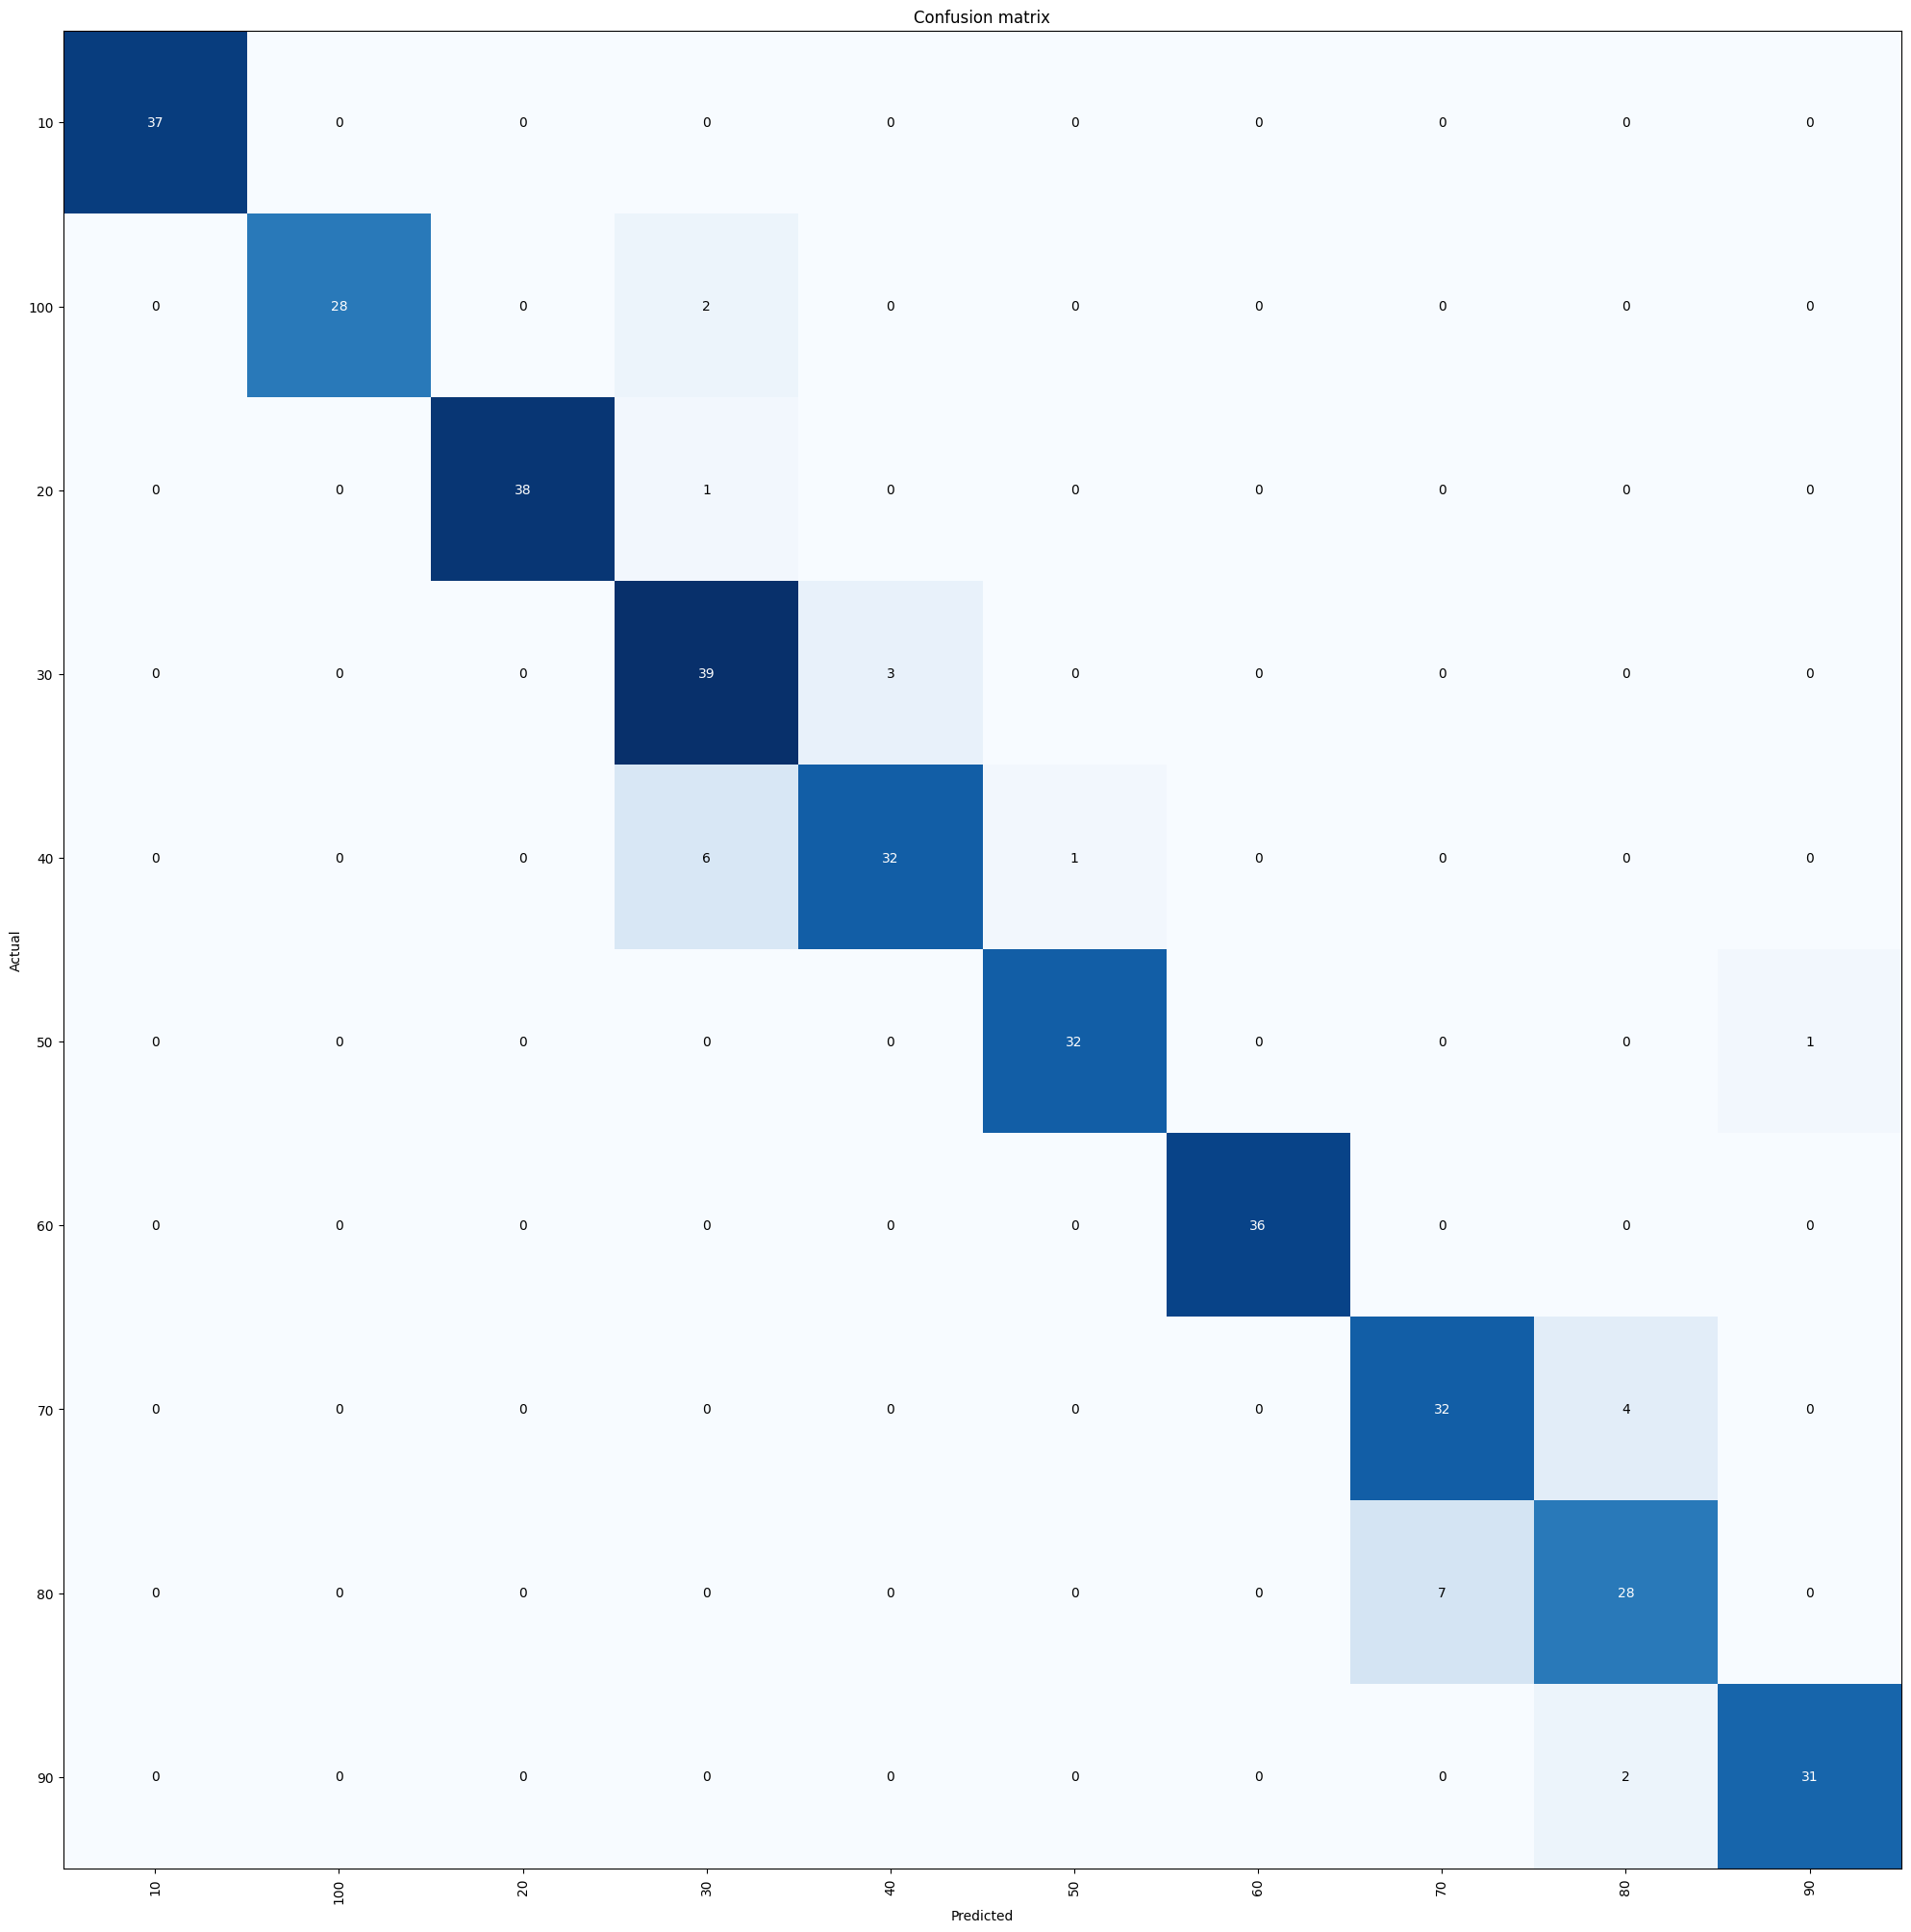

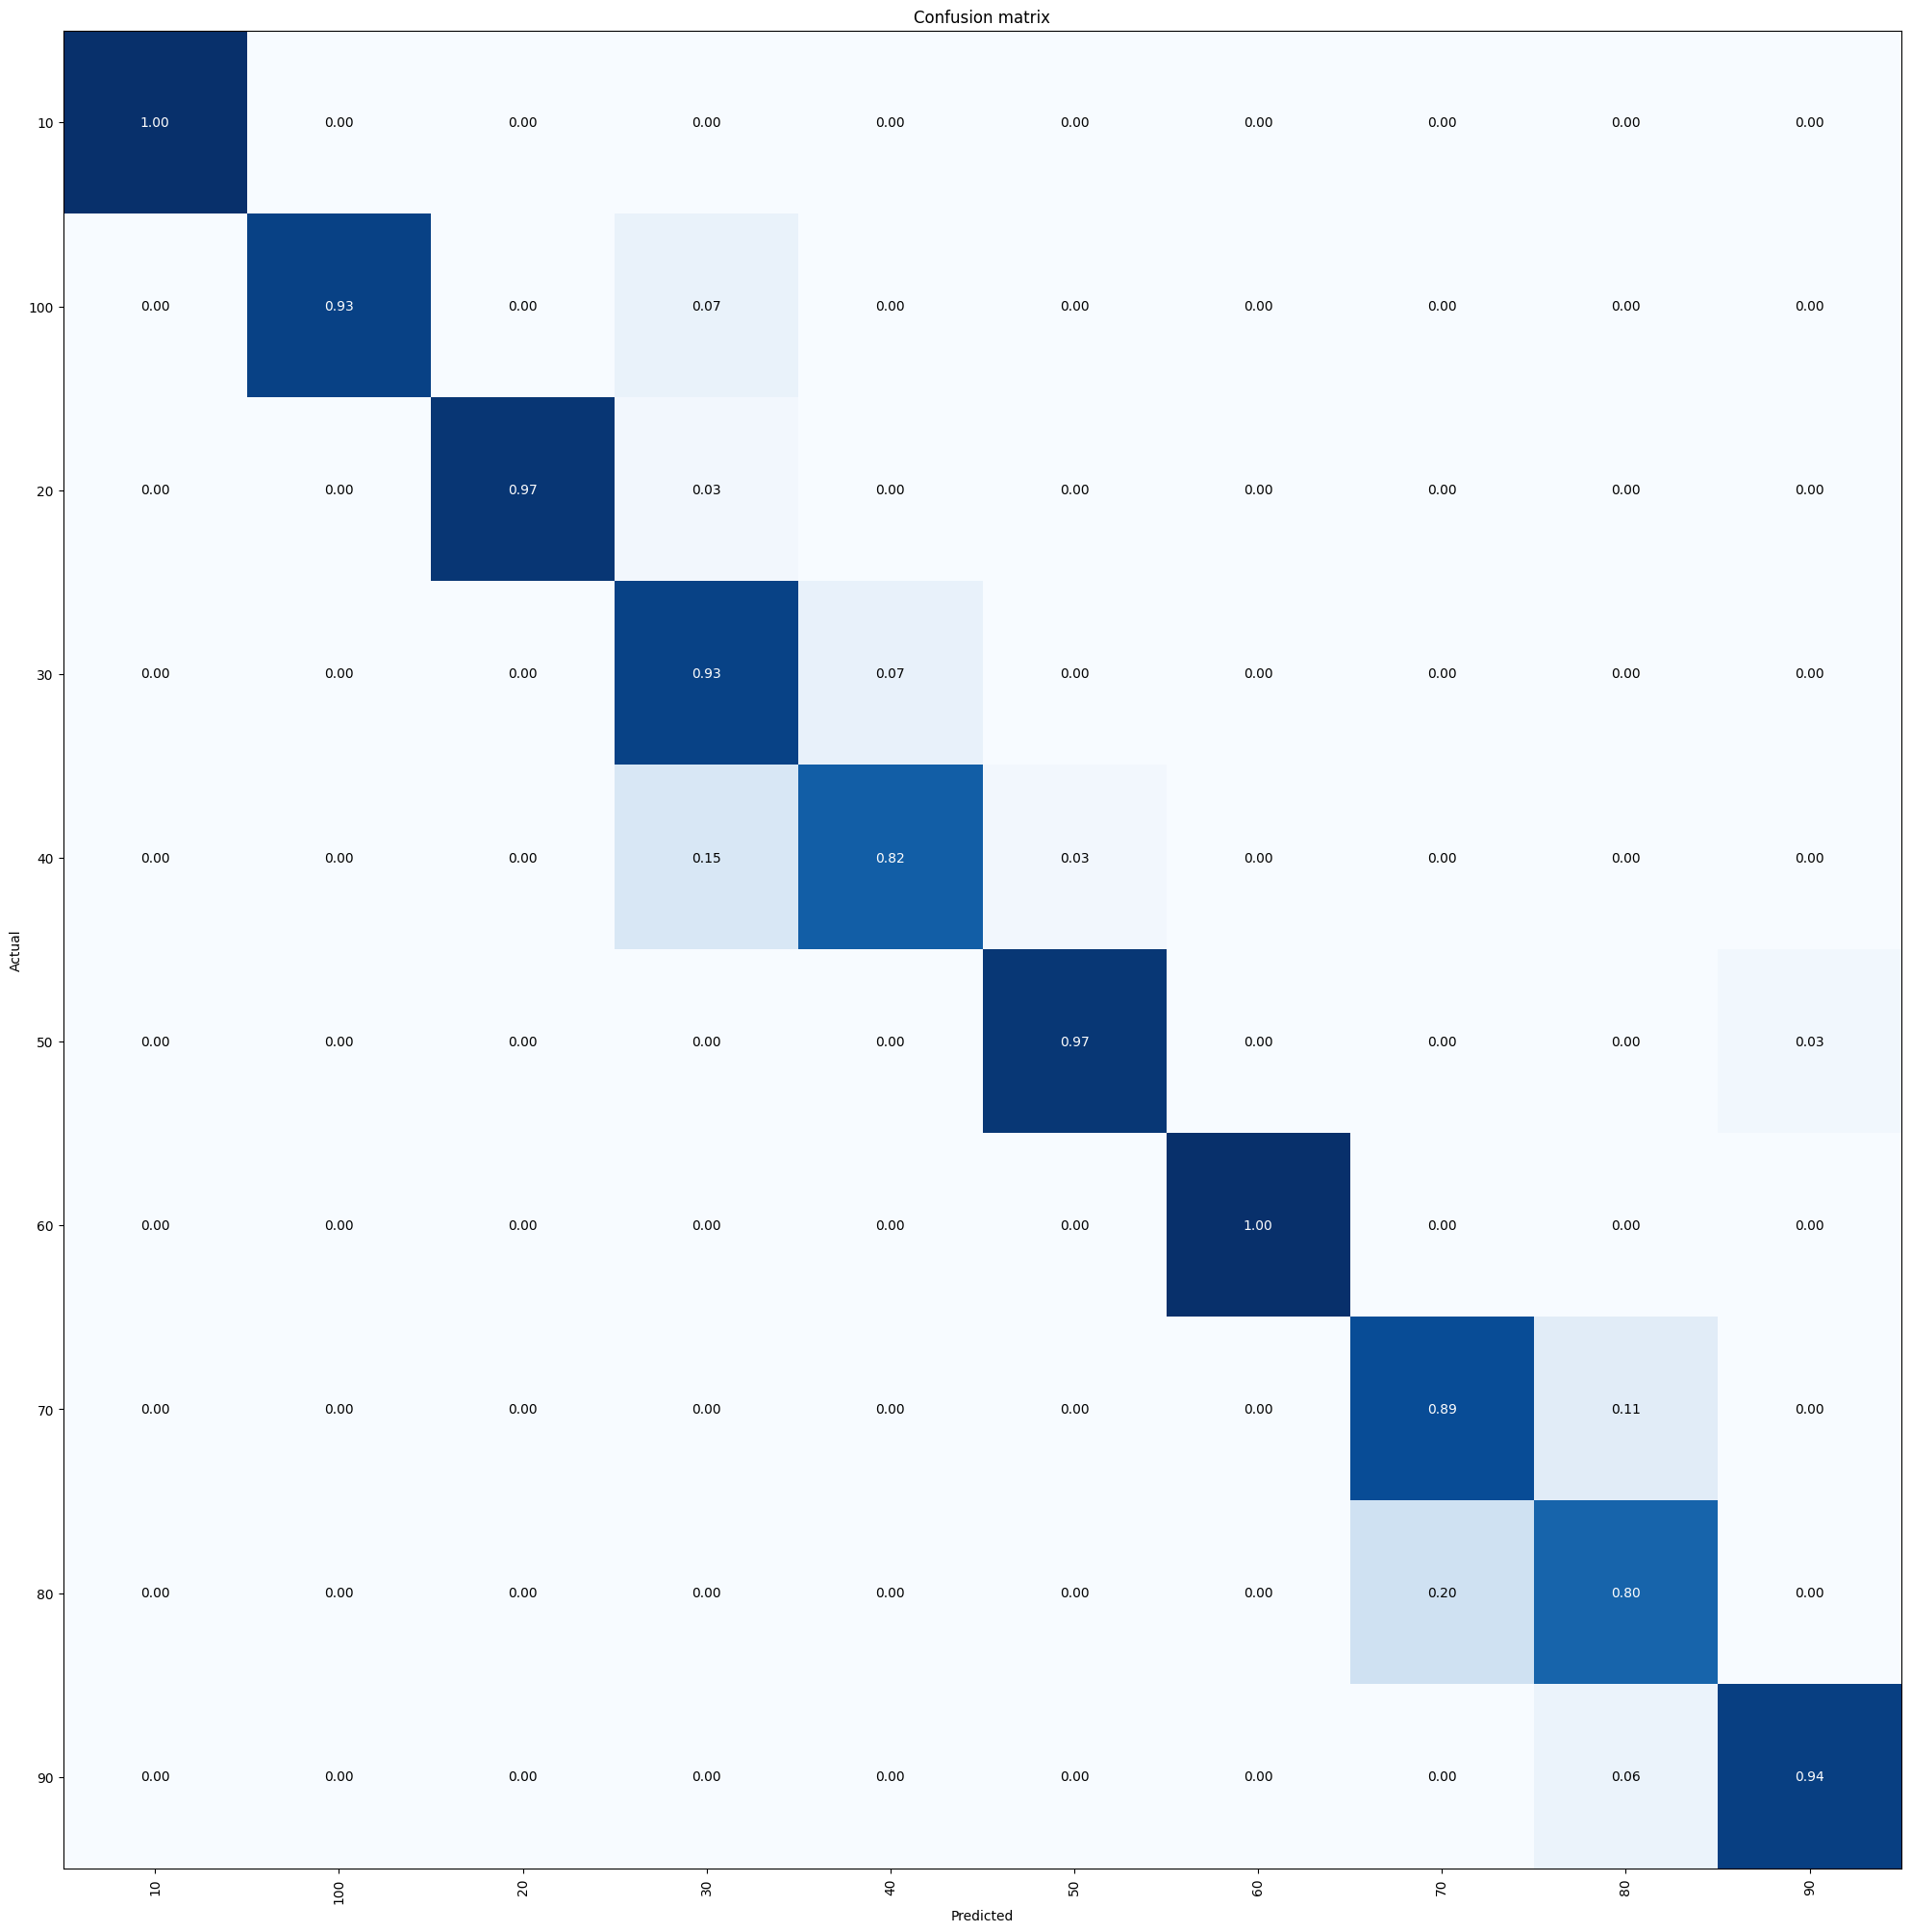

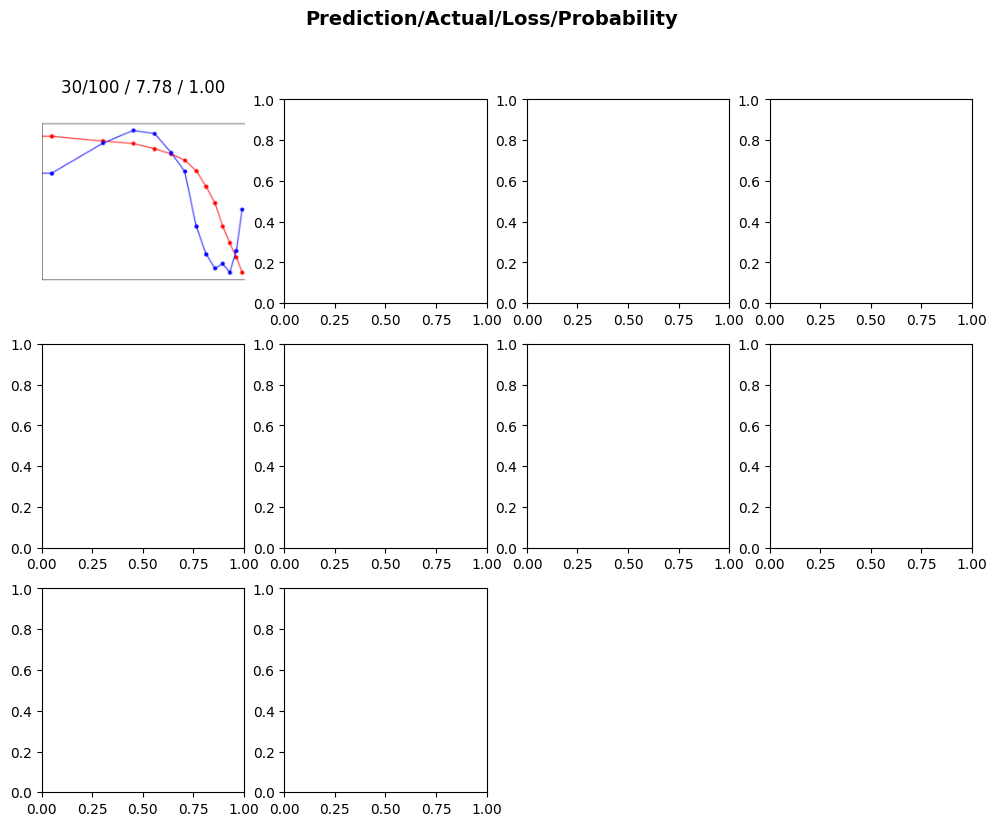

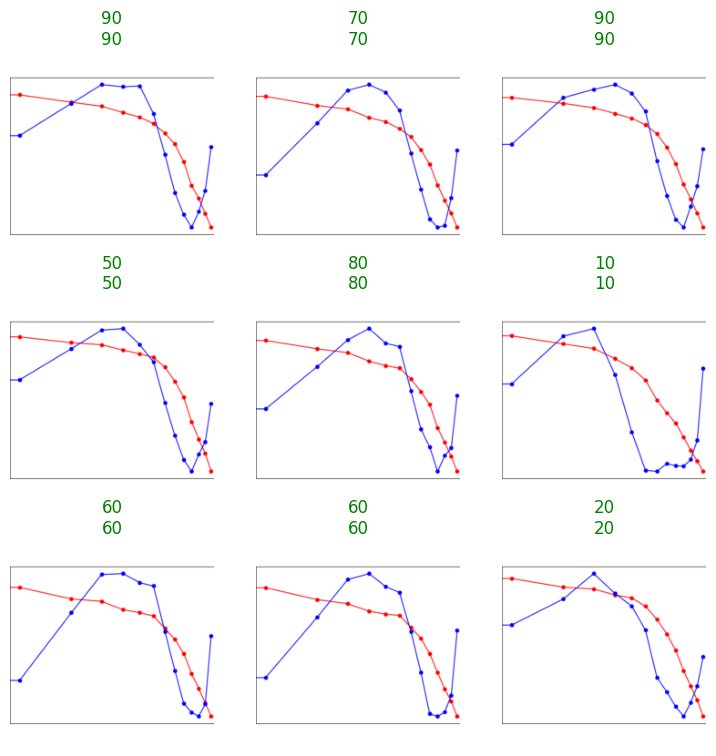

In [12]:
 experiments_predictions,exeperiments_targets,experiments_predictions_decoded, models_accuracy,model_top2_accuracy= score_model_on_test_dataset(test_image_dataset_path,experiment_runs_list,saved_weights_files)

In [13]:
# Calculate ensable prediction
ensamble_prediction = experiments_predictions[0]
for pred in experiments_predictions[1:]:
  ensamble_prediction += pred

ensamble_prediction /= len(experiments_predictions)
#ensamble_accuracy
accuracy(ensamble_prediction, exeperiments_targets[0])

TensorBase(0.8140)

In [ ]:
print("target: ")
print(targets)
print("predictions (decoded):")
print(decoded)
print("classification errors (class distance):")
print(targets-decoded)

## Leave One Battery Out New Battery Test Case -  Mode: Nyquist

In [14]:
experiment_runs_list=['Paper_MES_v2_leave_one_out_BATT02_Exp_1','Paper_MES_v2_leave_one_out_BATT03_Exp_1','Paper_MES_v2_leave_one_out_BATT05_Exp_1'] 
saved_weights_files= ['Paper_MES_v2_leave_one_out_BATT02_Exp_1_1674172129.773957_SAVED',
                      'Paper_MES_v2_leave_one_out_BATT03_Exp_1_1674172402.991041_SAVED',
                      'Paper_MES_v2_leave_one_out_BATT05_Exp_1_1674172695.466371_SAVED']
test_image_dataset_path= "../data/test_images/Test_dataset_NEW_BATT_Exp_1"

ExperimentName: Paper_MES_v2_leave_one_out_BATT02_Exp_0
saved weights files: Paper_MES_v2_leave_one_out_BATT02_Exp_0_1674171288.702184_SAVED
Setting-up type transforms pipelines
Found 1100 items
2 datasets of sizes 770,330
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      ../data/images/Paper_MES_v2_leave_one_out_BATT02_Exp_0/Paper_MES_v2_leave_one_out_BATT02_Exp_0-03_5002_20.png
    applying PILBase.create gives
      PILImage mode=RGB size=640x480
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../data/images/Paper_MES_v2_leave_one_out_BATT02_Exp_0/Paper_MES_v2_leave_one_out_BATT02_Exp_0-03_5002_20.png
    applying RegexLabeller gives
      20
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(2)

Final sample: (PIL

[[36  0  0  0  0  0  0  0  0  0]
 [ 0 41  0  0  1  0  0  0  0  0]
 [ 0  0 25  0  0  0  0  0  0  0]
 [ 0  0  0 24  0  1  0  0  0  0]
 [ 0  0  0  6 27  1  0  0  0  0]
 [ 0  0  0  0  0 28  0  0  0  0]
 [ 0  0  0  0  0  0 38  0  0  0]
 [ 0  0  0  0  0  0  0 27 12  0]
 [ 0  0  0  0  0  0  0 10 27  2]
 [ 0  0  0  0  0  0  0  0  0 24]]
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.97619048 0.         0.         0.02380952 0.
  0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.96       0.         0.04
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.17647059 0.79411765 0.02941176
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        ]
 [0.         0.  

learn.validate()


Model accuracy: 0.90
learn.get_preds()


model_accuracy on test dataset: TensorBase(0.0740)
model_top2_accuracy on test dataset: 0.186
ExperimentName: Paper_MES_v2_leave_one_out_BATT03_Exp_0
saved weights files: Paper_MES_v2_leave_one_out_BATT03_Exp_0_1674171562.600012_SAVED
Setting-up type transforms pipelines
Found 1100 items
2 datasets of sizes 770,330
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      ../data/images/Paper_MES_v2_leave_one_out_BATT03_Exp_0/Paper_MES_v2_leave_one_out_BATT03_Exp_0-02_5002_20.png
    applying PILBase.create gives
      PILImage mode=RGB size=640x480
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../data/images/Paper_MES_v2_leave_one_out_BATT03_Exp_0/Paper_MES_v2_leave_one_out_BATT03_Exp_0-02_5002_20.png
    applying RegexLabeller gives
      20
    applying Categorize -- {'

[[36  0  0  0  0  0  0  0  0  0]
 [ 0 40  1  0  0  1  0  0  0  0]
 [ 0  0 24  0  0  1  0  0  0  0]
 [ 0  1  0 24  0  0  0  0  0  0]
 [ 0  0  0  5 28  1  0  0  0  0]
 [ 0  0  0  0  0 28  0  0  0  0]
 [ 0  0  0  0  0  0 38  0  0  0]
 [ 0  0  0  0  0  0  0 31  8  0]
 [ 0  0  0  0  0  0  1 10 28  0]
 [ 0  0  0  0  0  0  0  0  2 22]]
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.95238095 0.02380952 0.         0.         0.02380952
  0.         0.         0.         0.        ]
 [0.         0.         0.96       0.         0.         0.04
  0.         0.         0.         0.        ]
 [0.         0.04       0.         0.96       0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.14705882 0.82352941 0.02941176
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        ]
 [0.     

learn.validate()


Model accuracy: 0.91
learn.get_preds()


model_accuracy on test dataset: TensorBase(0.0480)
model_top2_accuracy on test dataset: 0.162
ExperimentName: Paper_MES_v2_leave_one_out_BATT05_Exp_0
saved weights files: Paper_MES_v2_leave_one_out_BATT05_Exp_0_1674171856.034339_SAVED
Setting-up type transforms pipelines
Found 1200 items
2 datasets of sizes 840,360
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      ../data/images/Paper_MES_v2_leave_one_out_BATT05_Exp_0/Paper_MES_v2_leave_one_out_BATT05_Exp_0-03_6003_100.png
    applying PILBase.create gives
      PILImage mode=RGB size=640x480
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../data/images/Paper_MES_v2_leave_one_out_BATT05_Exp_0/Paper_MES_v2_leave_one_out_BATT05_Exp_0-03_6003_100.png
    applying RegexLabeller gives
      100
    applying Categorize --

[[37  0  0  0  0  0  0  0  0  0]
 [ 0 28  0  2  0  0  0  0  0  0]
 [ 0  0 38  1  0  0  0  0  0  0]
 [ 0  0  0 39  3  0  0  0  0  0]
 [ 0  0  0  6 32  1  0  0  0  0]
 [ 0  0  0  0  0 32  0  0  0  1]
 [ 0  0  0  0  0  0 36  0  0  0]
 [ 0  0  0  0  0  0  0 32  4  0]
 [ 0  0  0  0  0  0  0  7 28  0]
 [ 0  0  0  0  0  0  0  0  2 31]]
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.93333333 0.         0.06666667 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.97435897 0.02564103 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.92857143 0.07142857 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.15384615 0.82051282 0.02564103
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.96969697
  0.         0.         0.         0.03030303]
 [0.       

learn.validate()


Model accuracy: 0.93
learn.get_preds()


model_accuracy on test dataset: TensorBase(0.1000)
model_top2_accuracy on test dataset: 0.236


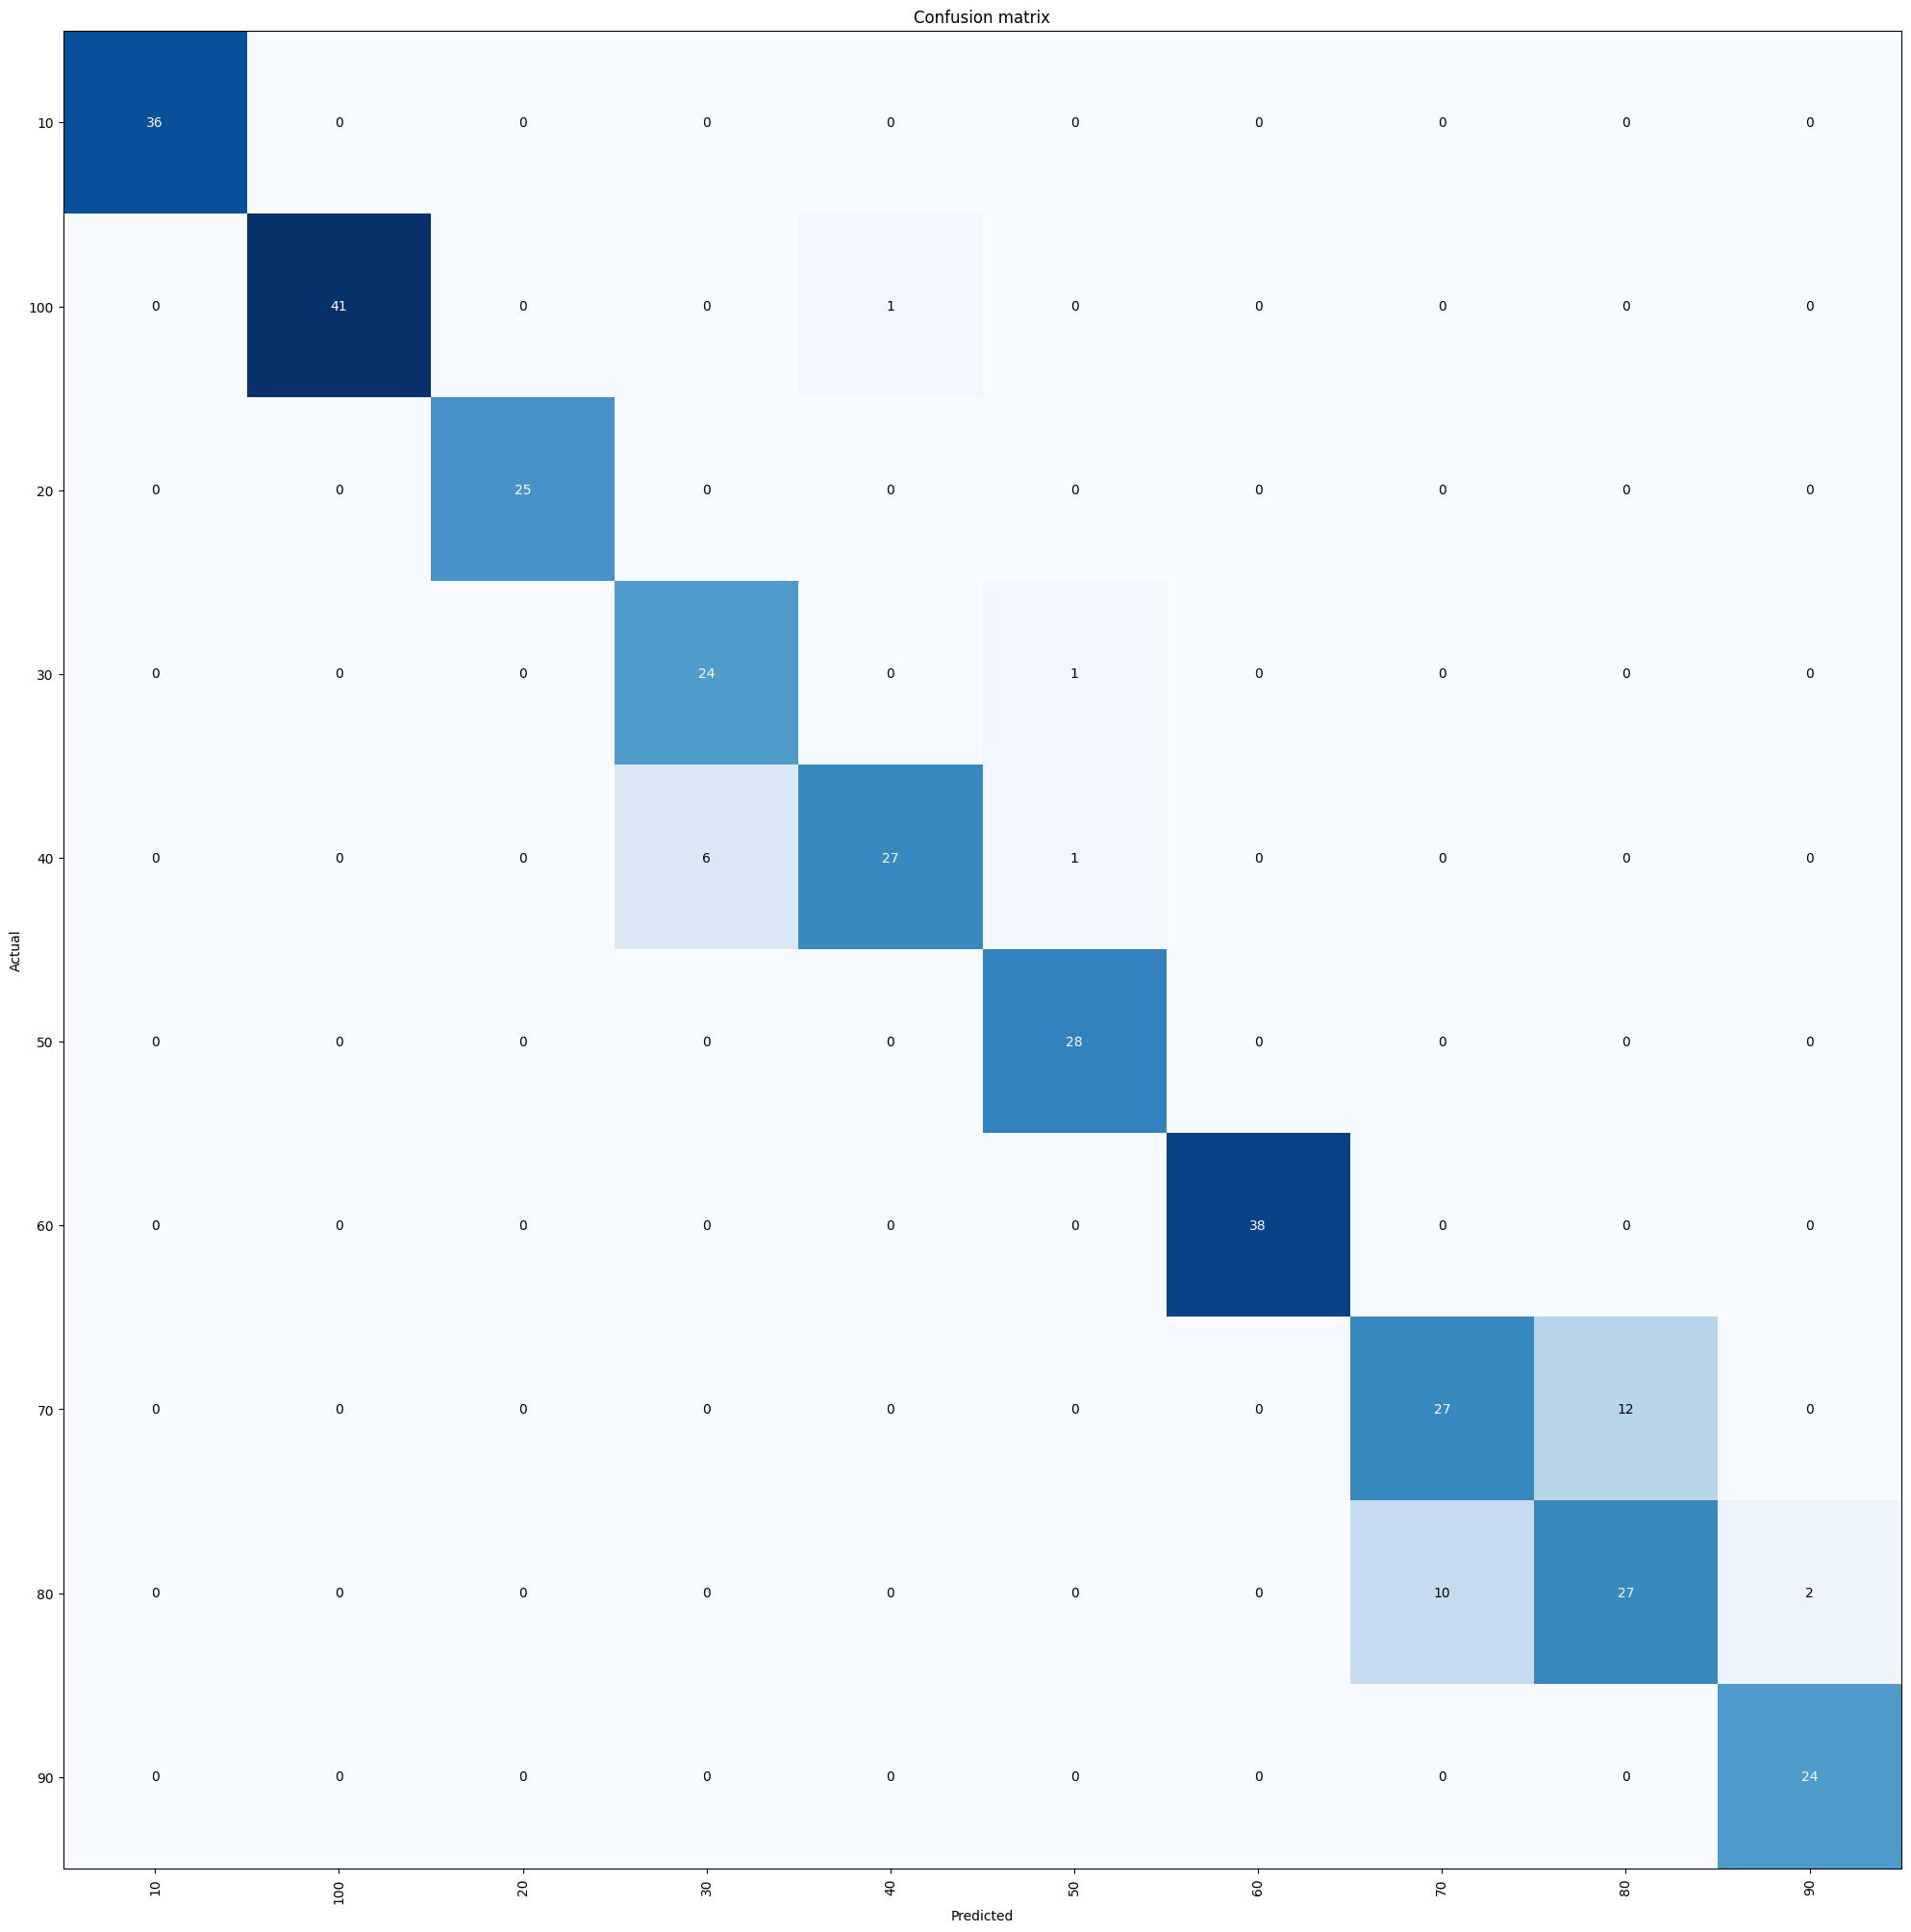

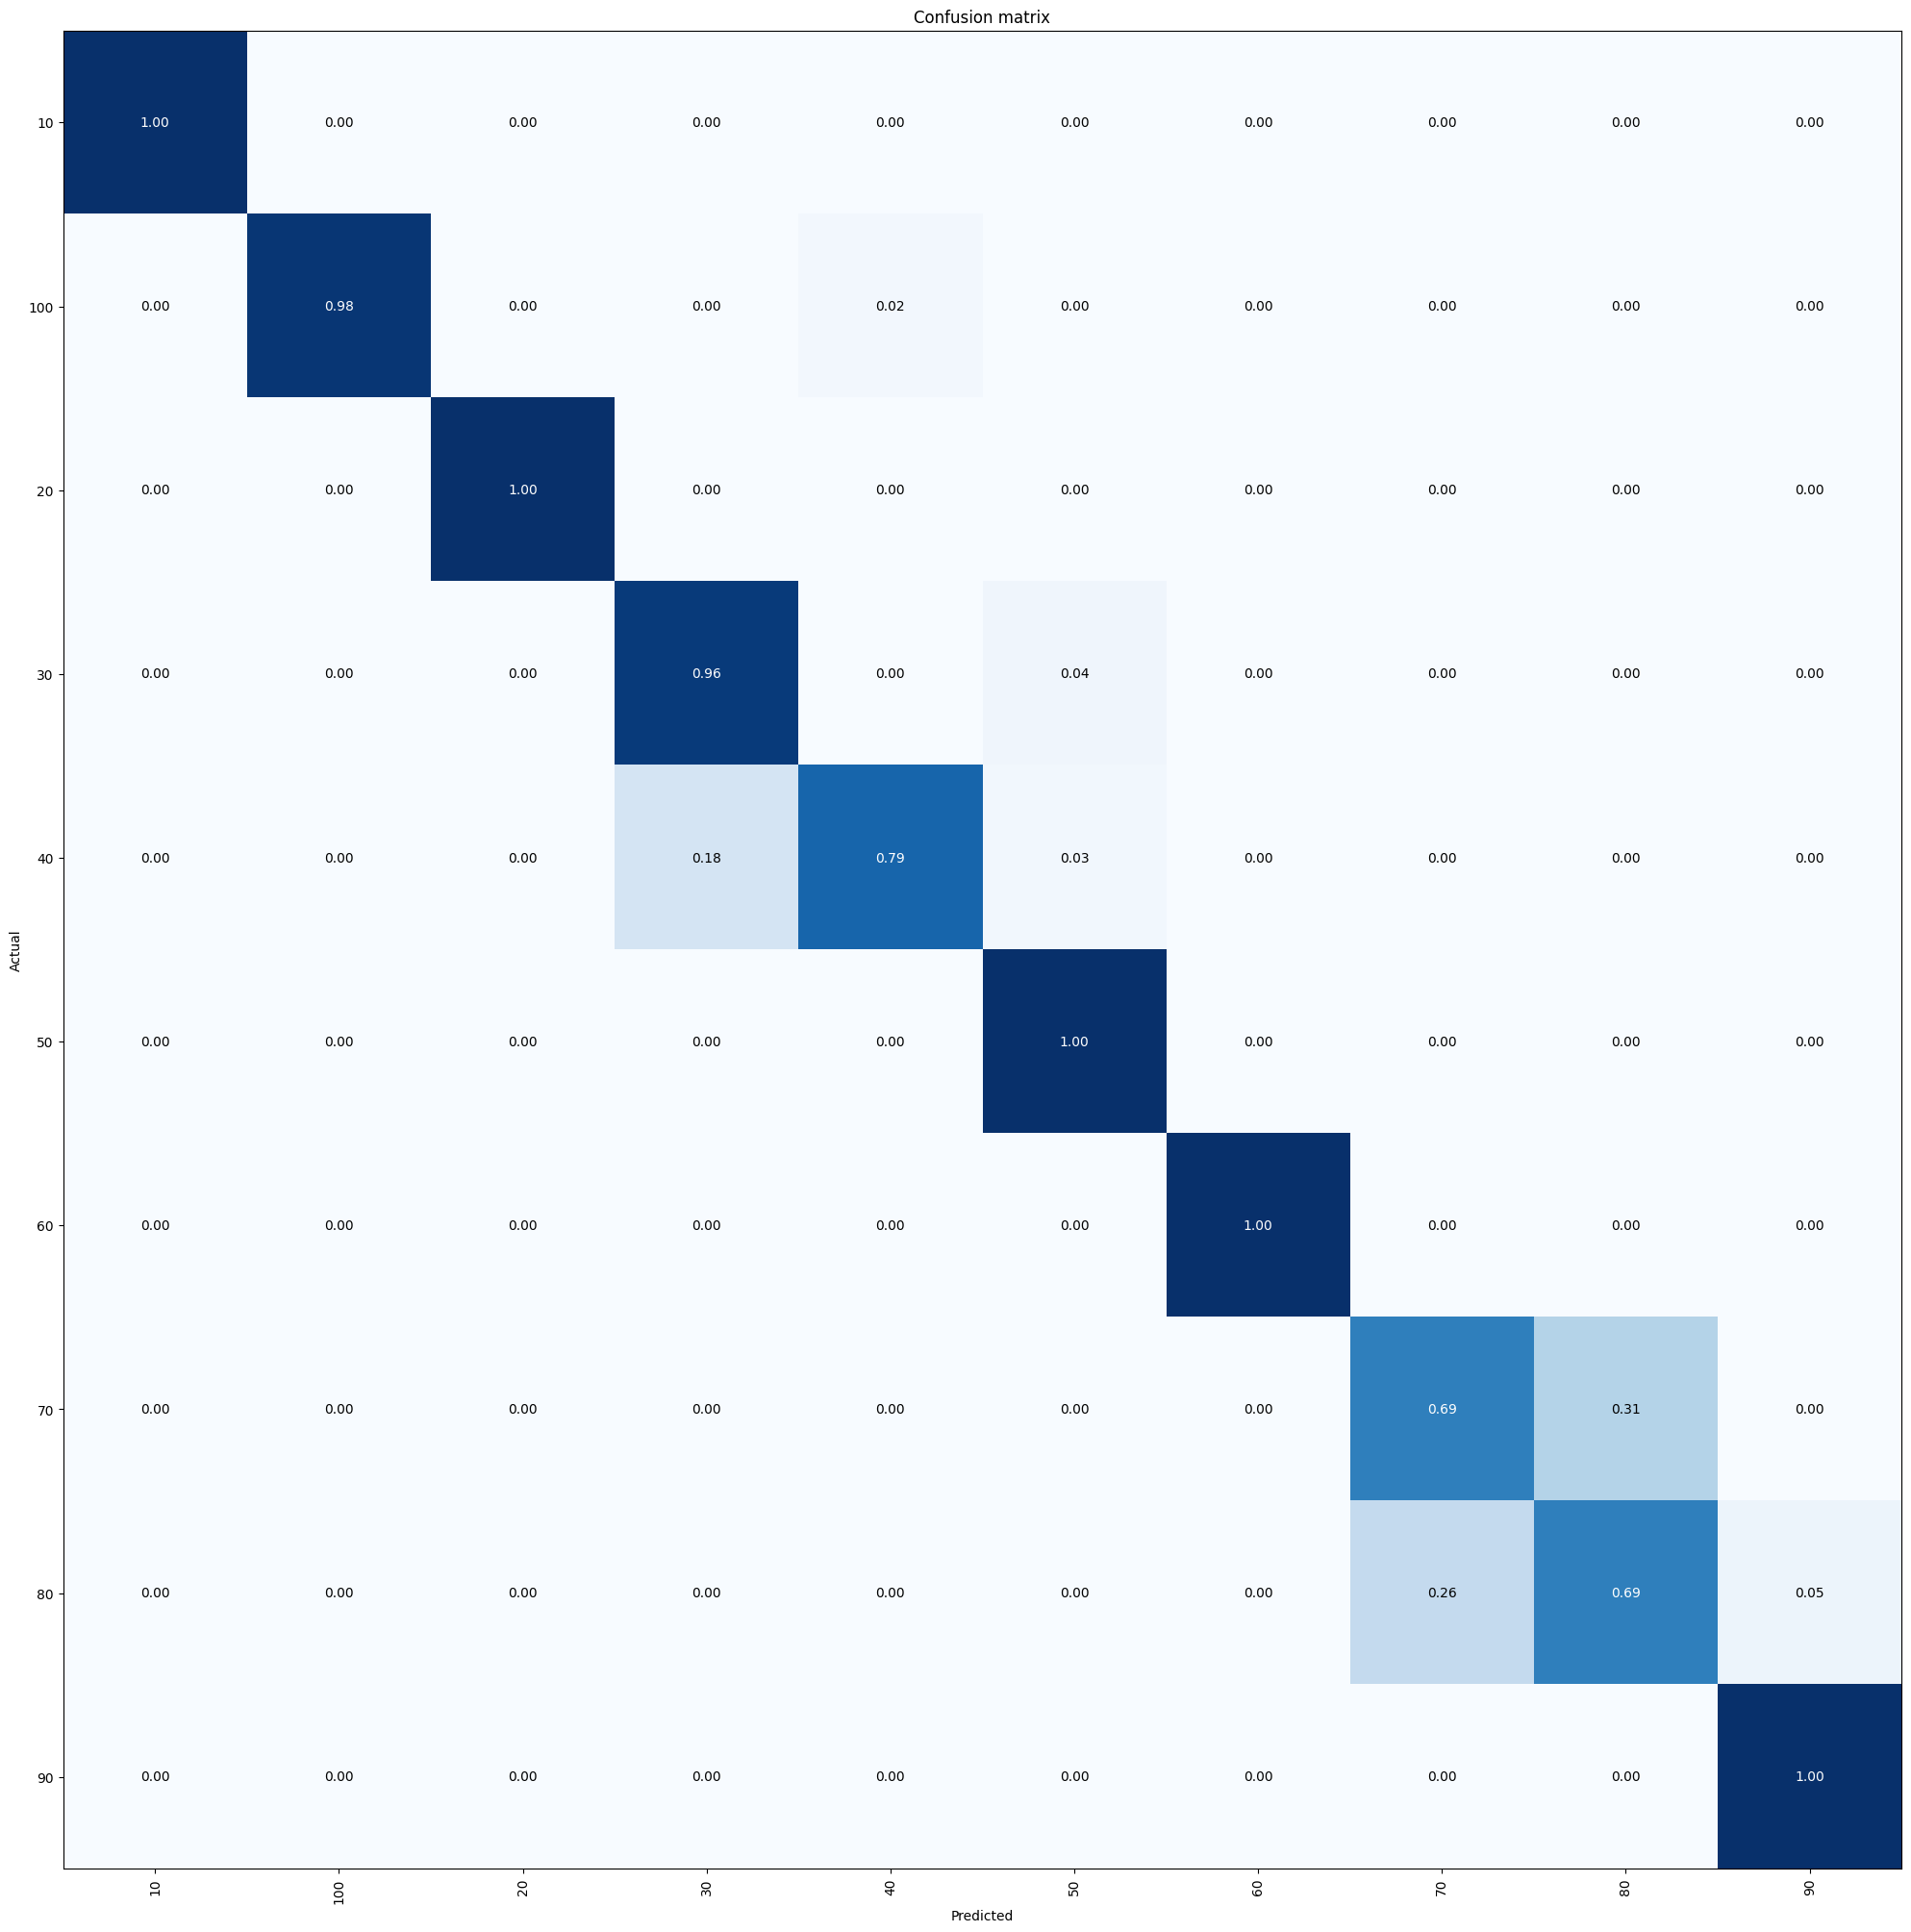

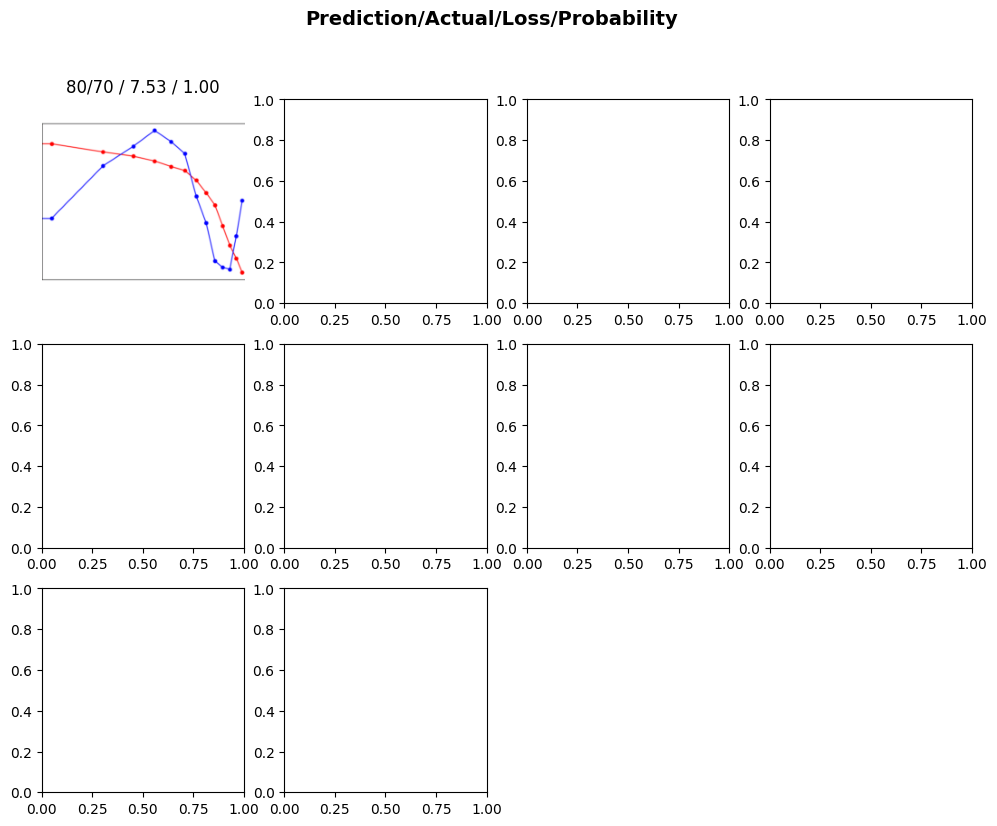

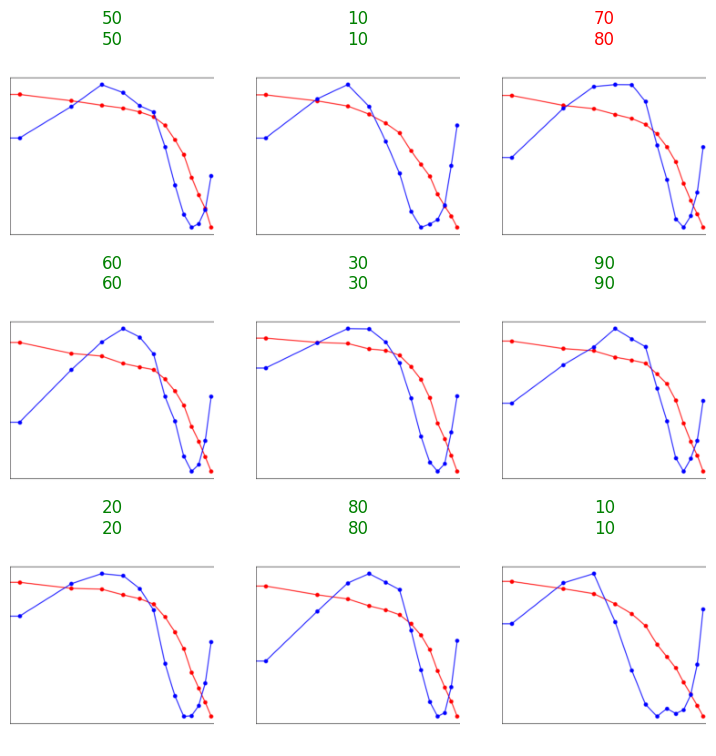

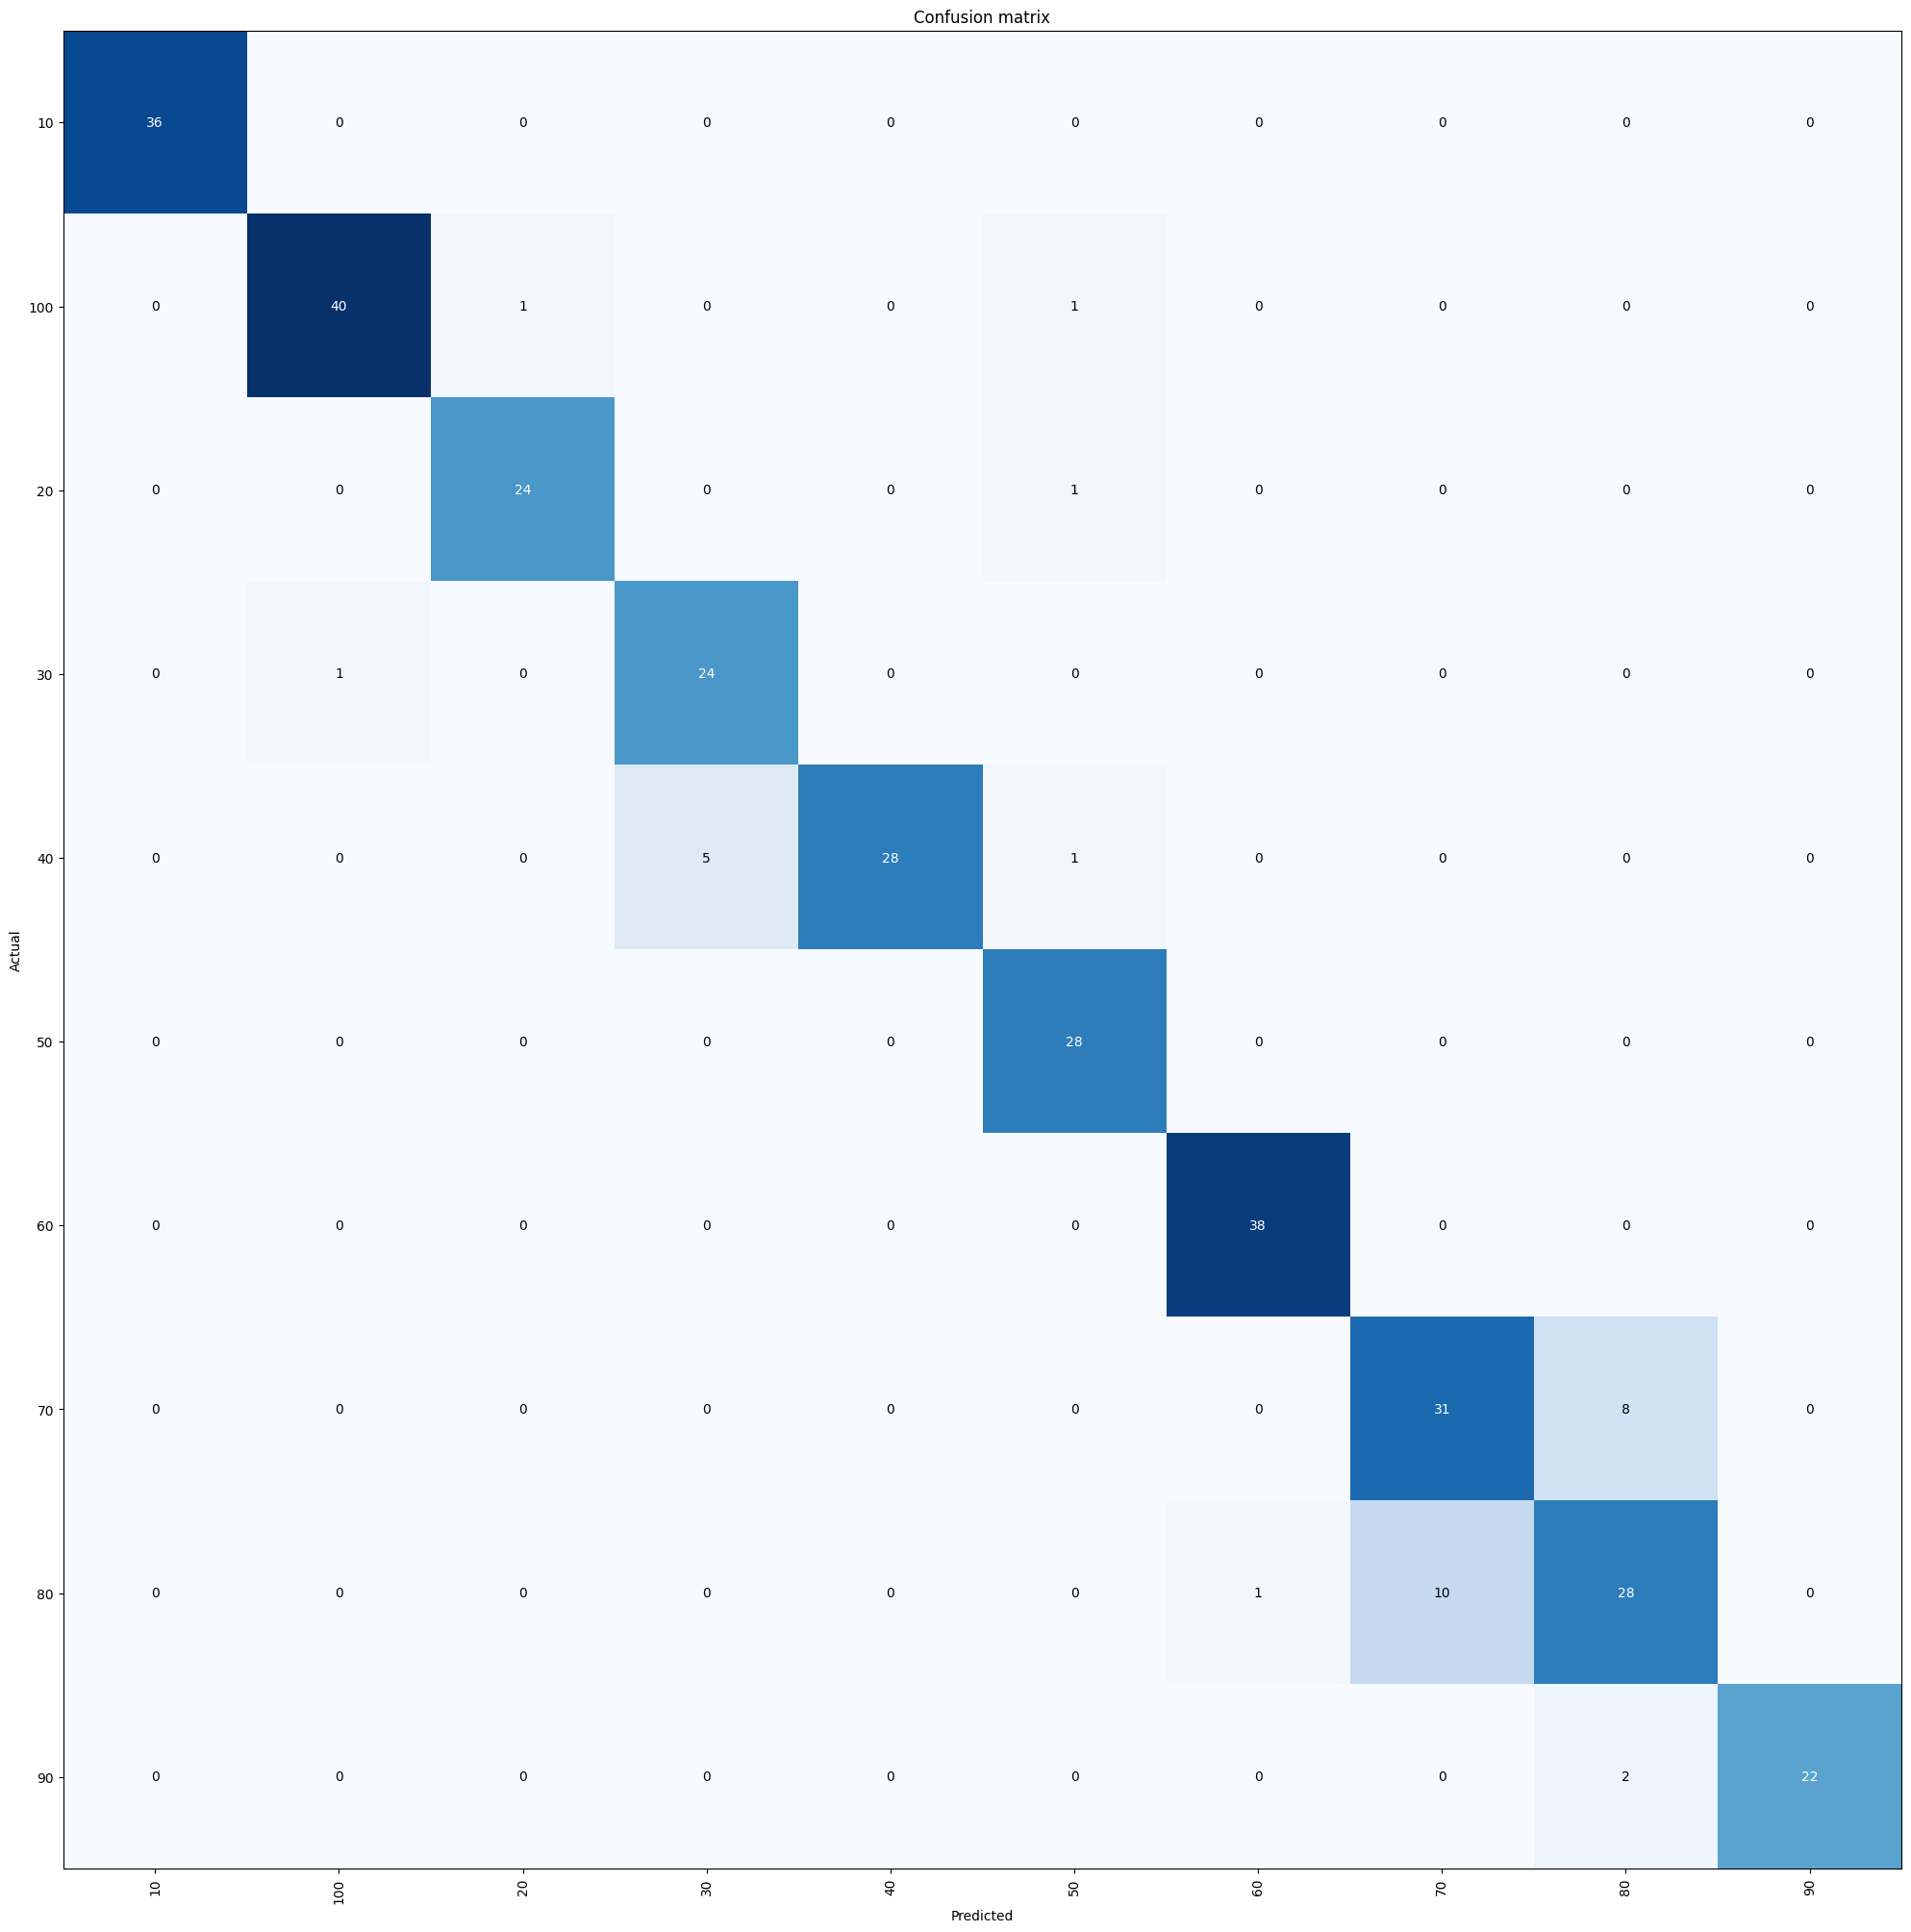

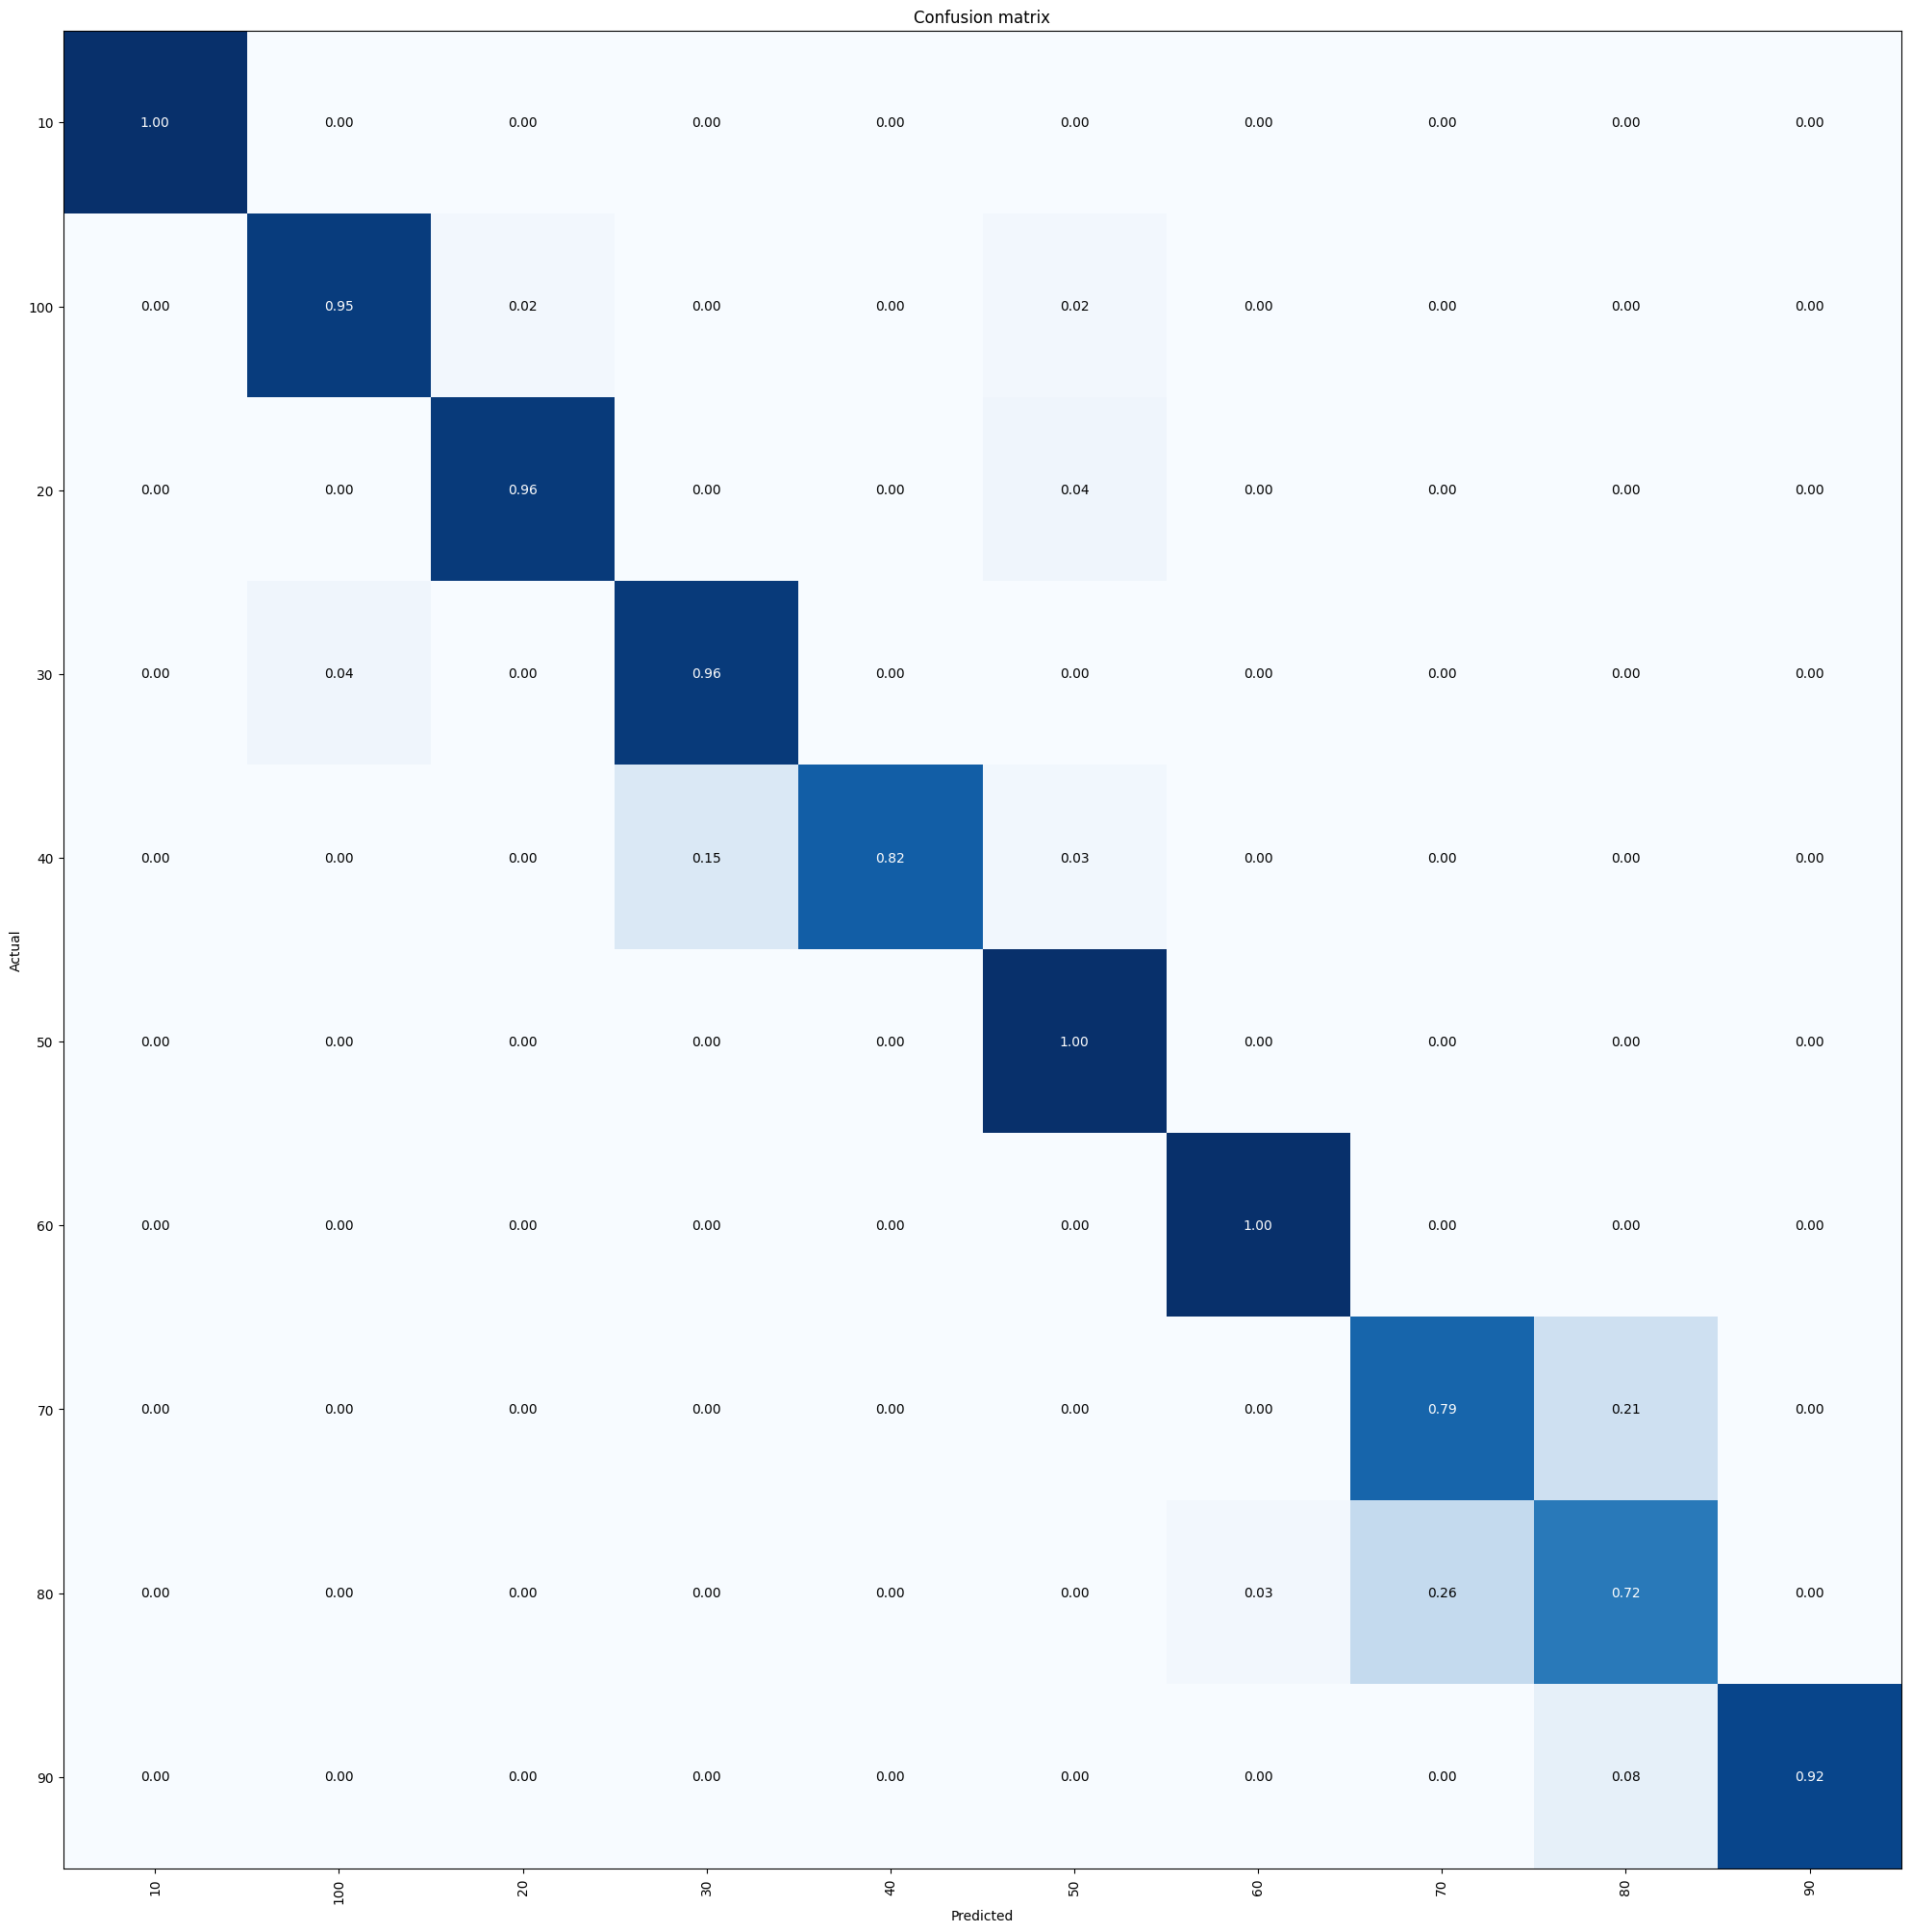

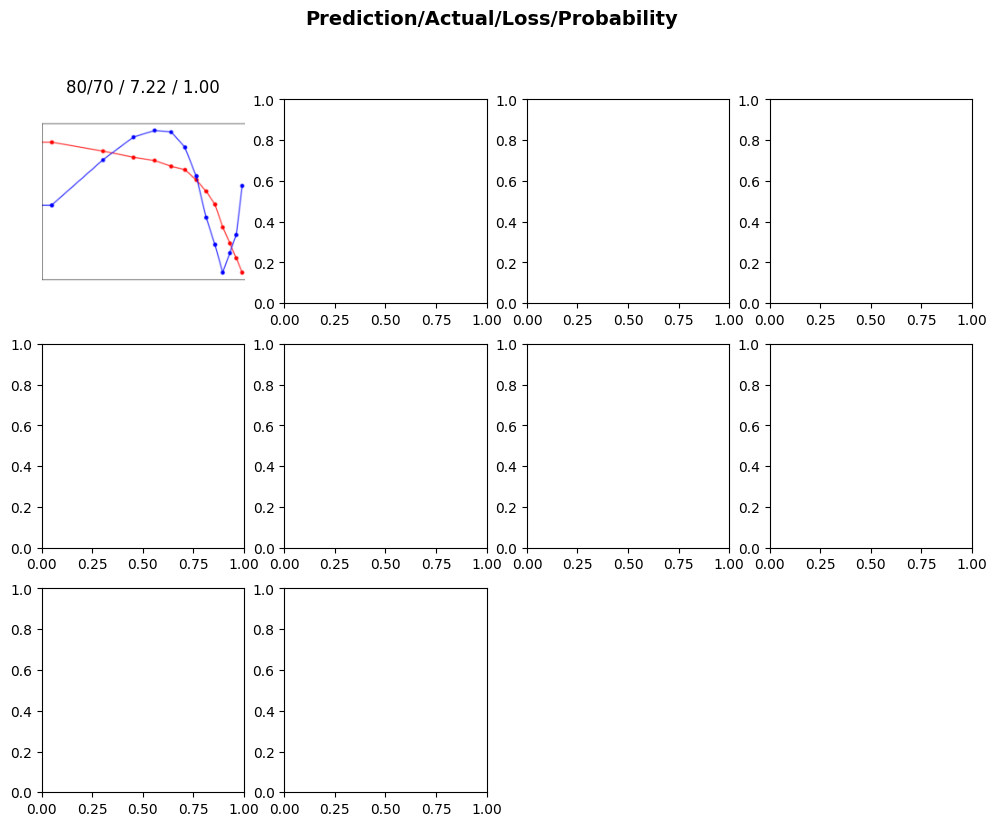

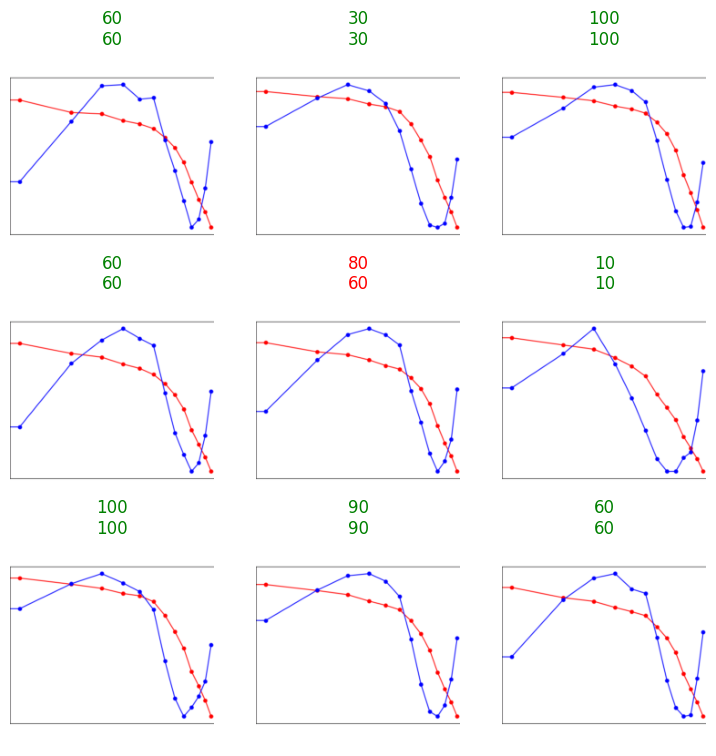

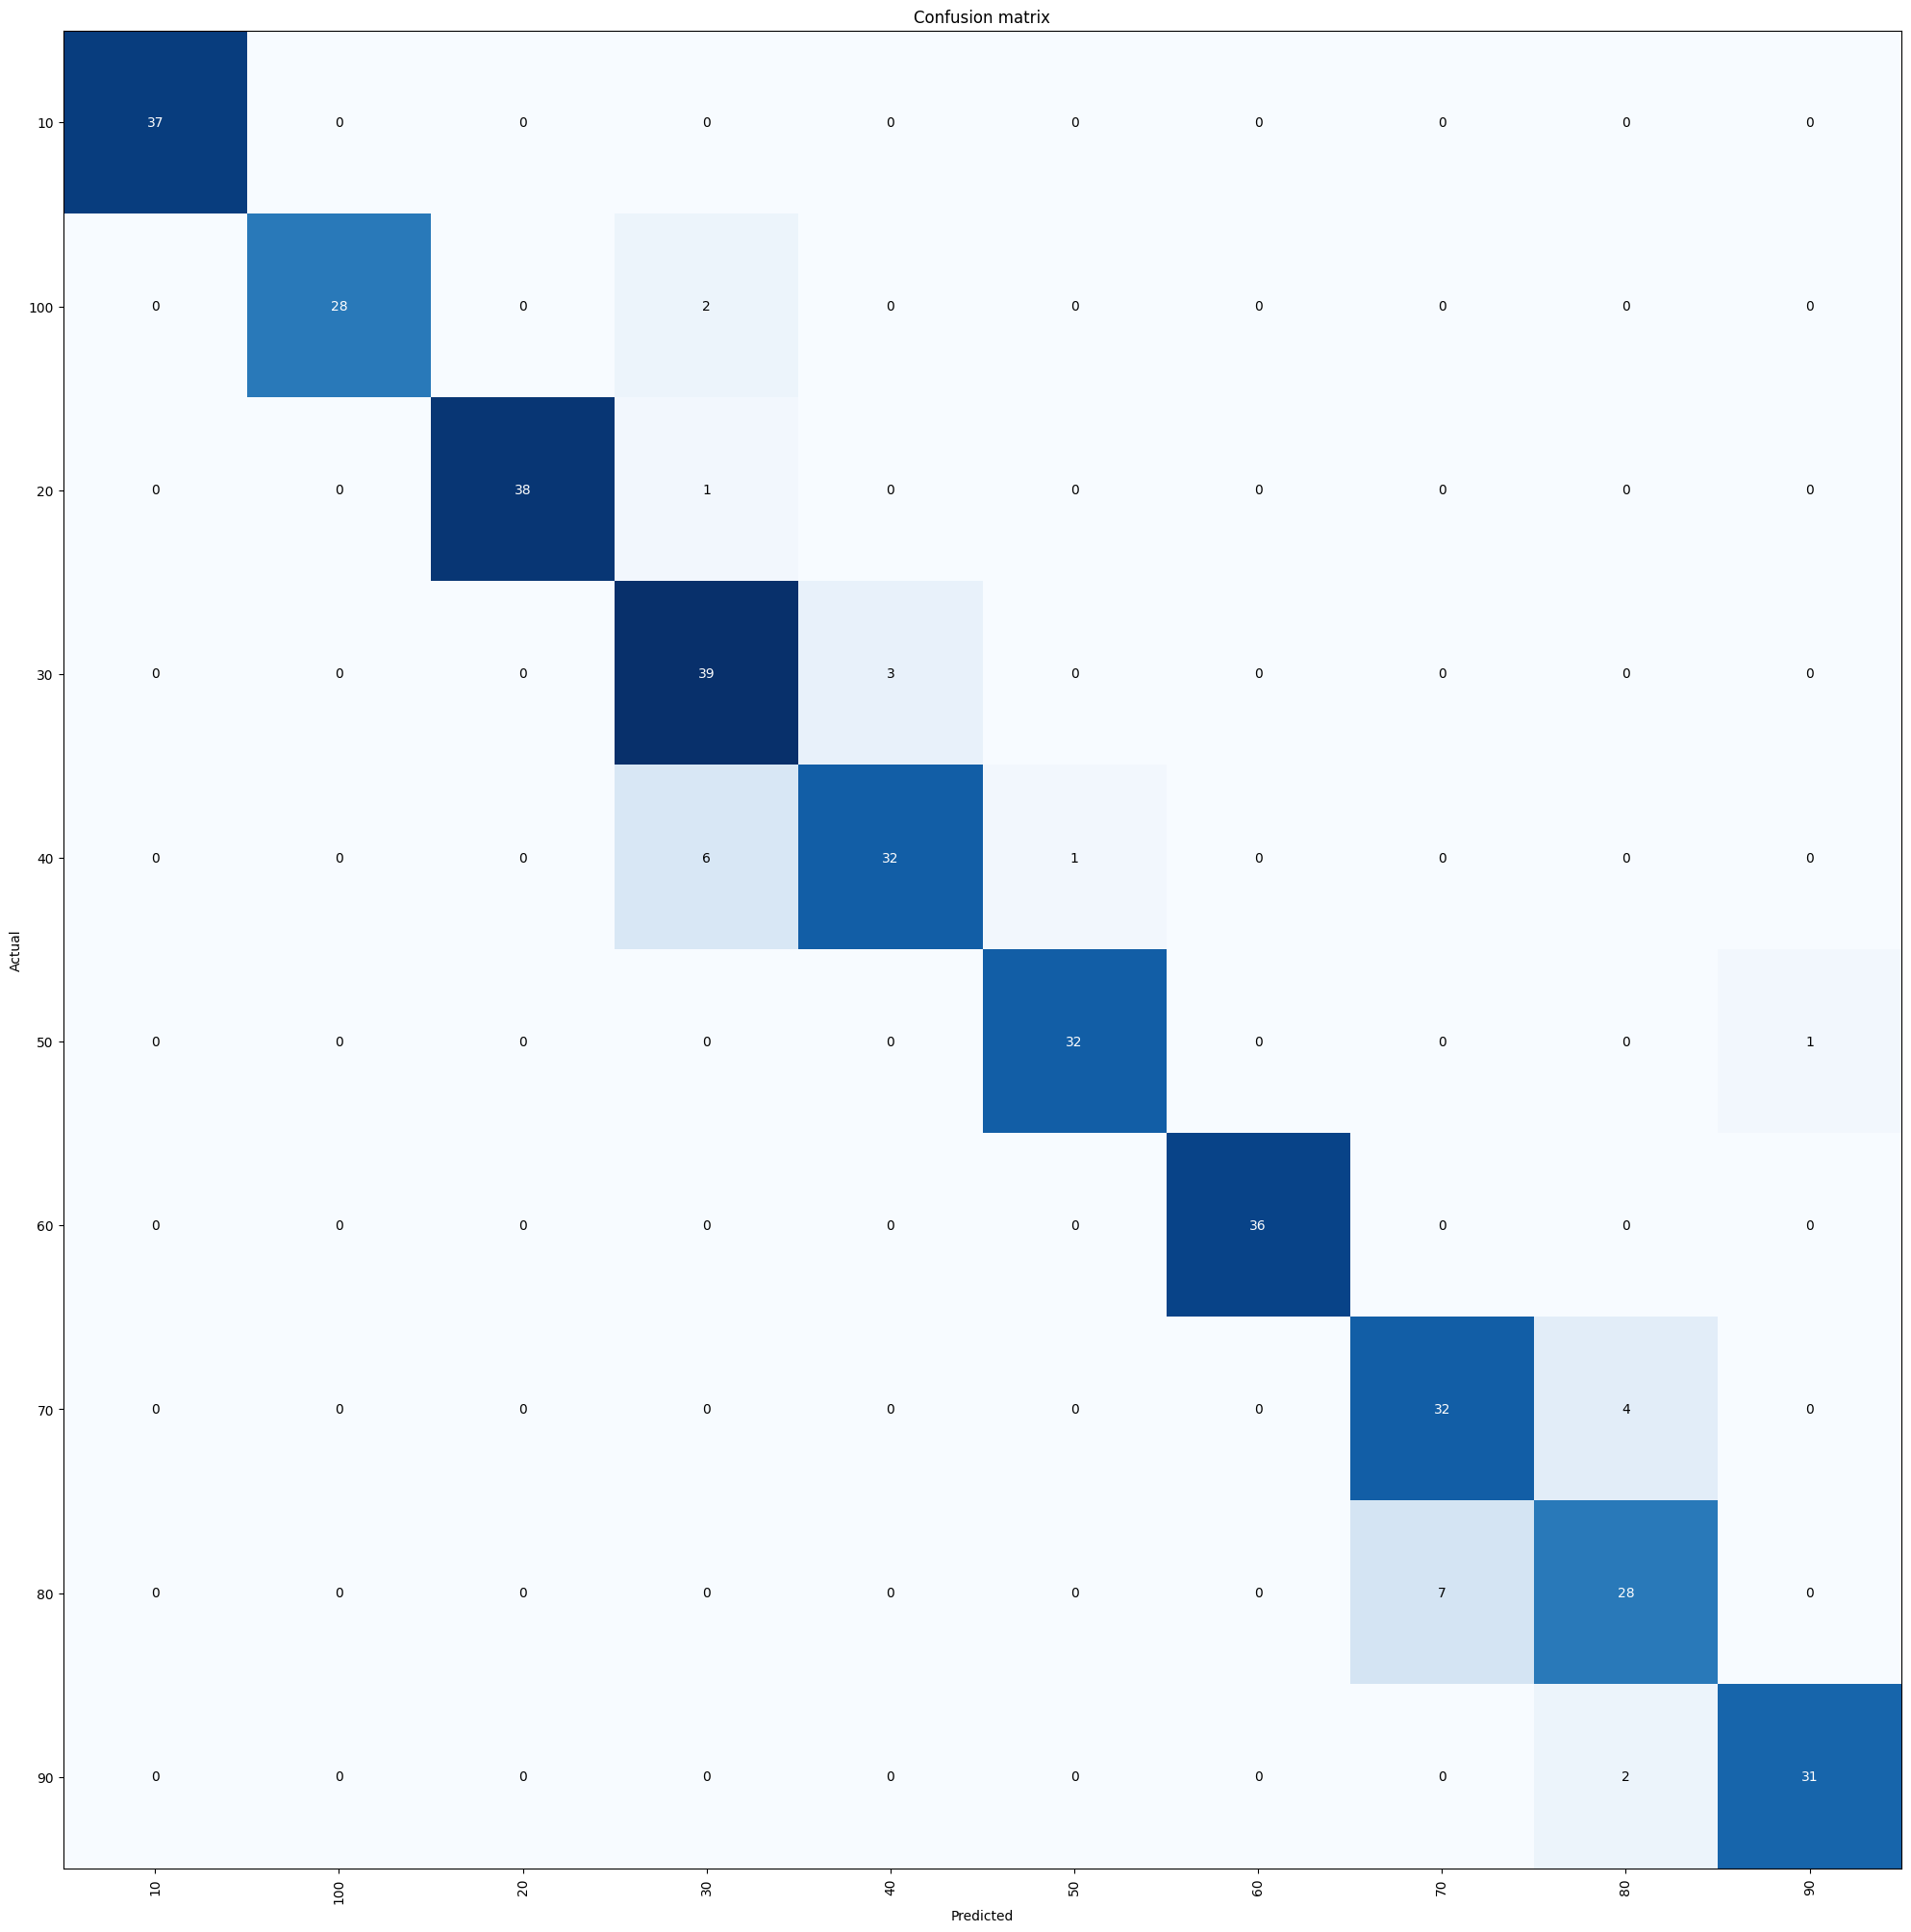

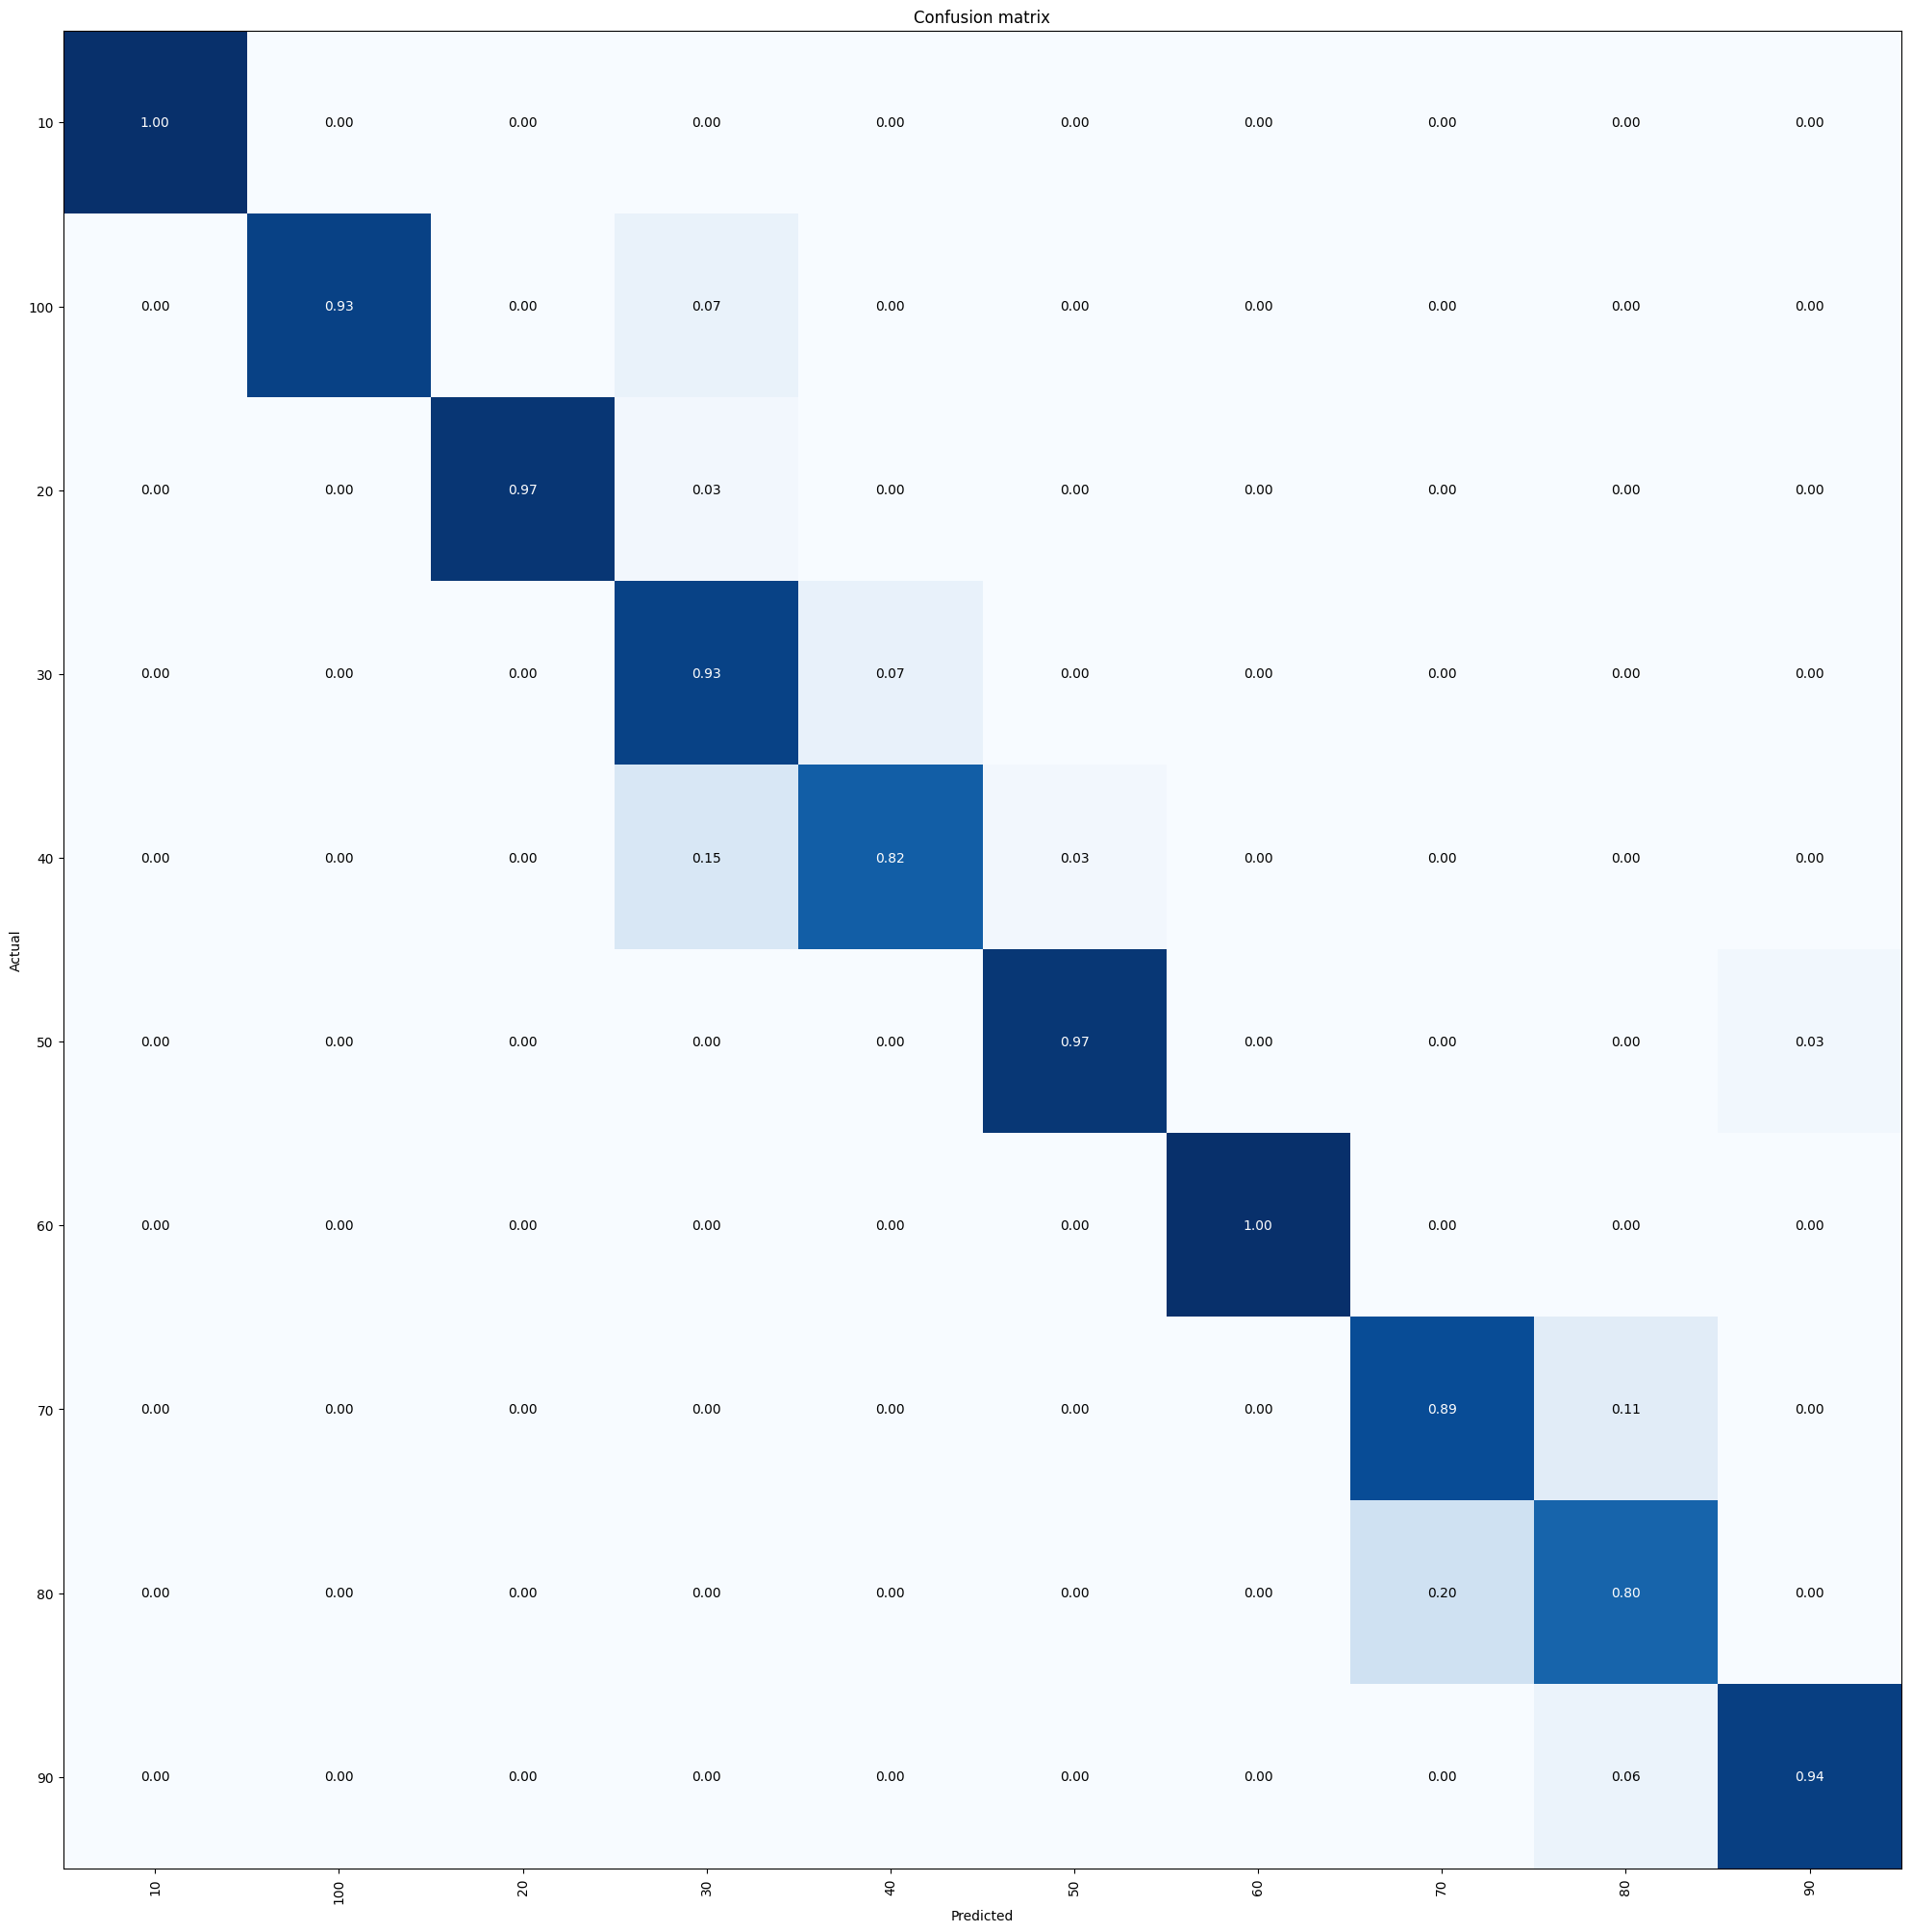

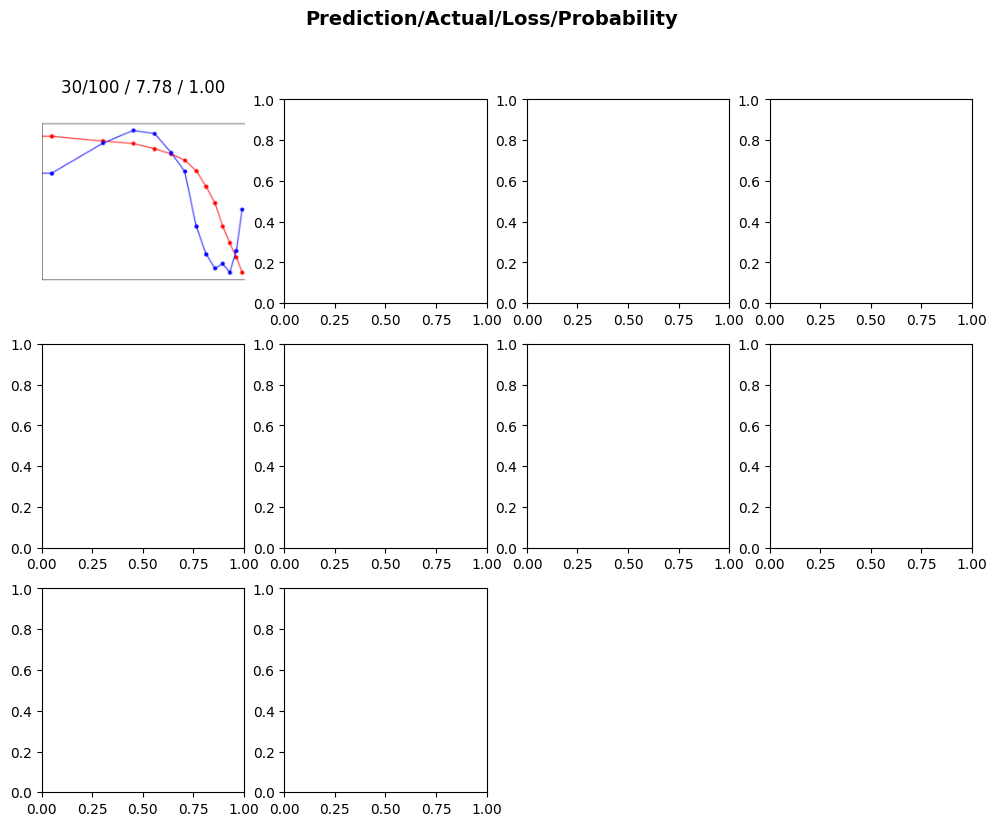

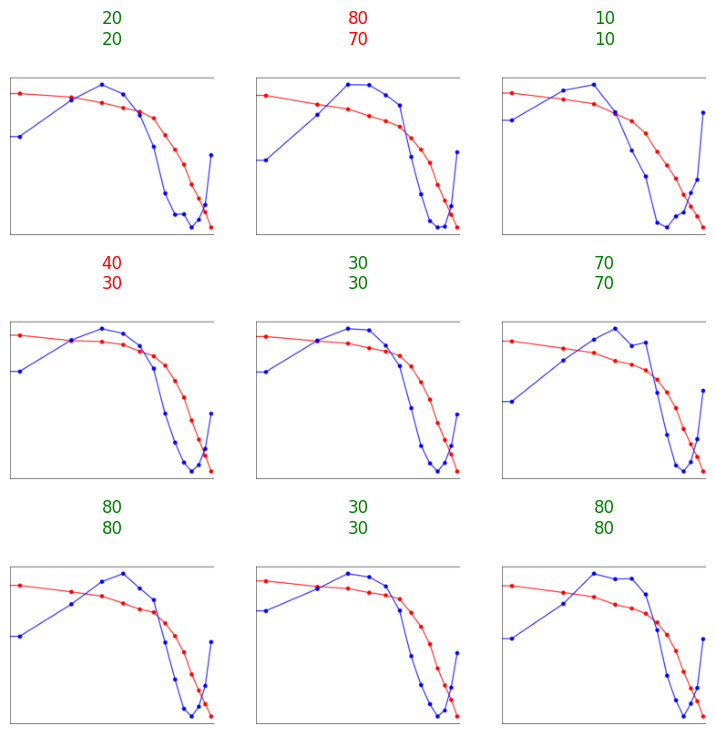

In [15]:
 experiments_predictions,exeperiments_targets,experiments_predictions_decoded, models_accuracy,model_top2_accuracy= score_model_on_test_dataset(test_image_dataset_path,
                                                                                                                                                experiment_runs_list,
                                                                                                                                                saved_weights_files)

In [16]:
# Calculate ensable prediction
ensamble_prediction = experiments_predictions[0]
for pred in experiments_predictions[1:]:
  ensamble_prediction += pred

ensamble_prediction /= len(experiments_predictions)
#ensamble_accuracy
accuracy(ensamble_prediction, exeperiments_targets[0])

TensorBase(0.0440)

In [ ]:
print("target: ")
print(targets)
print("predictions (decoded):")
print(decoded)
print("classification errors (class distance):")
print(targets-decoded)

## Leave one out - New measurement test case - Mode: Bode

In [17]:
experiment_runs_list=['Paper_MES_v2_leave_one_out_BATT02_Exp_0','Paper_MES_v2_leave_one_out_BATT03_Exp_0','Paper_MES_v2_leave_one_out_BATT05_Exp_0'] 
saved_weights_files= ['Paper_MES_v2_leave_one_out_BATT02_Exp_0_1674171288.702184_SAVED',
                      'Paper_MES_v2_leave_one_out_BATT03_Exp_0_1674171562.600012_SAVED',
                      'Paper_MES_v2_leave_one_out_BATT05_Exp_0_1674171856.034339_SAVED',
                      ]
test_image_dataset_path= "../data/test_images/Test_dataset_NEW_MEAS_Exp_0"

ExperimentName: Paper_MES_v2_leave_one_out_BATT02_Exp_0
saved weights files: Paper_MES_v2_leave_one_out_BATT02_Exp_0_1674171288.702184_SAVED
Setting-up type transforms pipelines
Found 1100 items
2 datasets of sizes 770,330
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      ../data/images/Paper_MES_v2_leave_one_out_BATT02_Exp_0/Paper_MES_v2_leave_one_out_BATT02_Exp_0-03_5002_20.png
    applying PILBase.create gives
      PILImage mode=RGB size=640x480
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../data/images/Paper_MES_v2_leave_one_out_BATT02_Exp_0/Paper_MES_v2_leave_one_out_BATT02_Exp_0-03_5002_20.png
    applying RegexLabeller gives
      20
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(2)

Final sample: (PIL

[[36  0  0  0  0  0  0  0  0  0]
 [ 0 41  0  0  1  0  0  0  0  0]
 [ 0  0 25  0  0  0  0  0  0  0]
 [ 0  0  0 24  0  1  0  0  0  0]
 [ 0  0  0  6 27  1  0  0  0  0]
 [ 0  0  0  0  0 28  0  0  0  0]
 [ 0  0  0  0  0  0 38  0  0  0]
 [ 0  0  0  0  0  0  0 27 12  0]
 [ 0  0  0  0  0  0  0 10 27  2]
 [ 0  0  0  0  0  0  0  0  0 24]]
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.97619048 0.         0.         0.02380952 0.
  0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.96       0.         0.04
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.17647059 0.79411765 0.02941176
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        ]
 [0.         0.  

learn.validate()


Model accuracy: 0.90
learn.get_preds()


model_accuracy on test dataset: TensorBase(0.9100)
model_top2_accuracy on test dataset: 1.0
ExperimentName: Paper_MES_v2_leave_one_out_BATT03_Exp_0
saved weights files: Paper_MES_v2_leave_one_out_BATT03_Exp_0_1674171562.600012_SAVED
Setting-up type transforms pipelines
Found 1100 items
2 datasets of sizes 770,330
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      ../data/images/Paper_MES_v2_leave_one_out_BATT03_Exp_0/Paper_MES_v2_leave_one_out_BATT03_Exp_0-02_5002_20.png
    applying PILBase.create gives
      PILImage mode=RGB size=640x480
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../data/images/Paper_MES_v2_leave_one_out_BATT03_Exp_0/Paper_MES_v2_leave_one_out_BATT03_Exp_0-02_5002_20.png
    applying RegexLabeller gives
      20
    applying Categorize -- {'vo

[[36  0  0  0  0  0  0  0  0  0]
 [ 0 40  1  0  0  1  0  0  0  0]
 [ 0  0 24  0  0  1  0  0  0  0]
 [ 0  1  0 24  0  0  0  0  0  0]
 [ 0  0  0  5 28  1  0  0  0  0]
 [ 0  0  0  0  0 28  0  0  0  0]
 [ 0  0  0  0  0  0 38  0  0  0]
 [ 0  0  0  0  0  0  0 31  8  0]
 [ 0  0  0  0  0  0  1 10 28  0]
 [ 0  0  0  0  0  0  0  0  2 22]]
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.95238095 0.02380952 0.         0.         0.02380952
  0.         0.         0.         0.        ]
 [0.         0.         0.96       0.         0.         0.04
  0.         0.         0.         0.        ]
 [0.         0.04       0.         0.96       0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.14705882 0.82352941 0.02941176
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        ]
 [0.     

learn.validate()


Model accuracy: 0.91
learn.get_preds()


model_accuracy on test dataset: TensorBase(0.9300)
model_top2_accuracy on test dataset: 1.0
ExperimentName: Paper_MES_v2_leave_one_out_BATT05_Exp_0
saved weights files: Paper_MES_v2_leave_one_out_BATT05_Exp_0_1674171856.034339_SAVED
Setting-up type transforms pipelines
Found 1200 items
2 datasets of sizes 840,360
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      ../data/images/Paper_MES_v2_leave_one_out_BATT05_Exp_0/Paper_MES_v2_leave_one_out_BATT05_Exp_0-03_6003_100.png
    applying PILBase.create gives
      PILImage mode=RGB size=640x480
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../data/images/Paper_MES_v2_leave_one_out_BATT05_Exp_0/Paper_MES_v2_leave_one_out_BATT05_Exp_0-03_6003_100.png
    applying RegexLabeller gives
      100
    applying Categorize -- {

[[37  0  0  0  0  0  0  0  0  0]
 [ 0 28  0  2  0  0  0  0  0  0]
 [ 0  0 38  1  0  0  0  0  0  0]
 [ 0  0  0 39  3  0  0  0  0  0]
 [ 0  0  0  6 32  1  0  0  0  0]
 [ 0  0  0  0  0 32  0  0  0  1]
 [ 0  0  0  0  0  0 36  0  0  0]
 [ 0  0  0  0  0  0  0 32  4  0]
 [ 0  0  0  0  0  0  0  7 28  0]
 [ 0  0  0  0  0  0  0  0  2 31]]
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.93333333 0.         0.06666667 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.97435897 0.02564103 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.92857143 0.07142857 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.15384615 0.82051282 0.02564103
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.96969697
  0.         0.         0.         0.03030303]
 [0.       

learn.validate()


Model accuracy: 0.93
learn.get_preds()


model_accuracy on test dataset: TensorBase(0.5700)
model_top2_accuracy on test dataset: 0.78


TensorBase(0.9100)

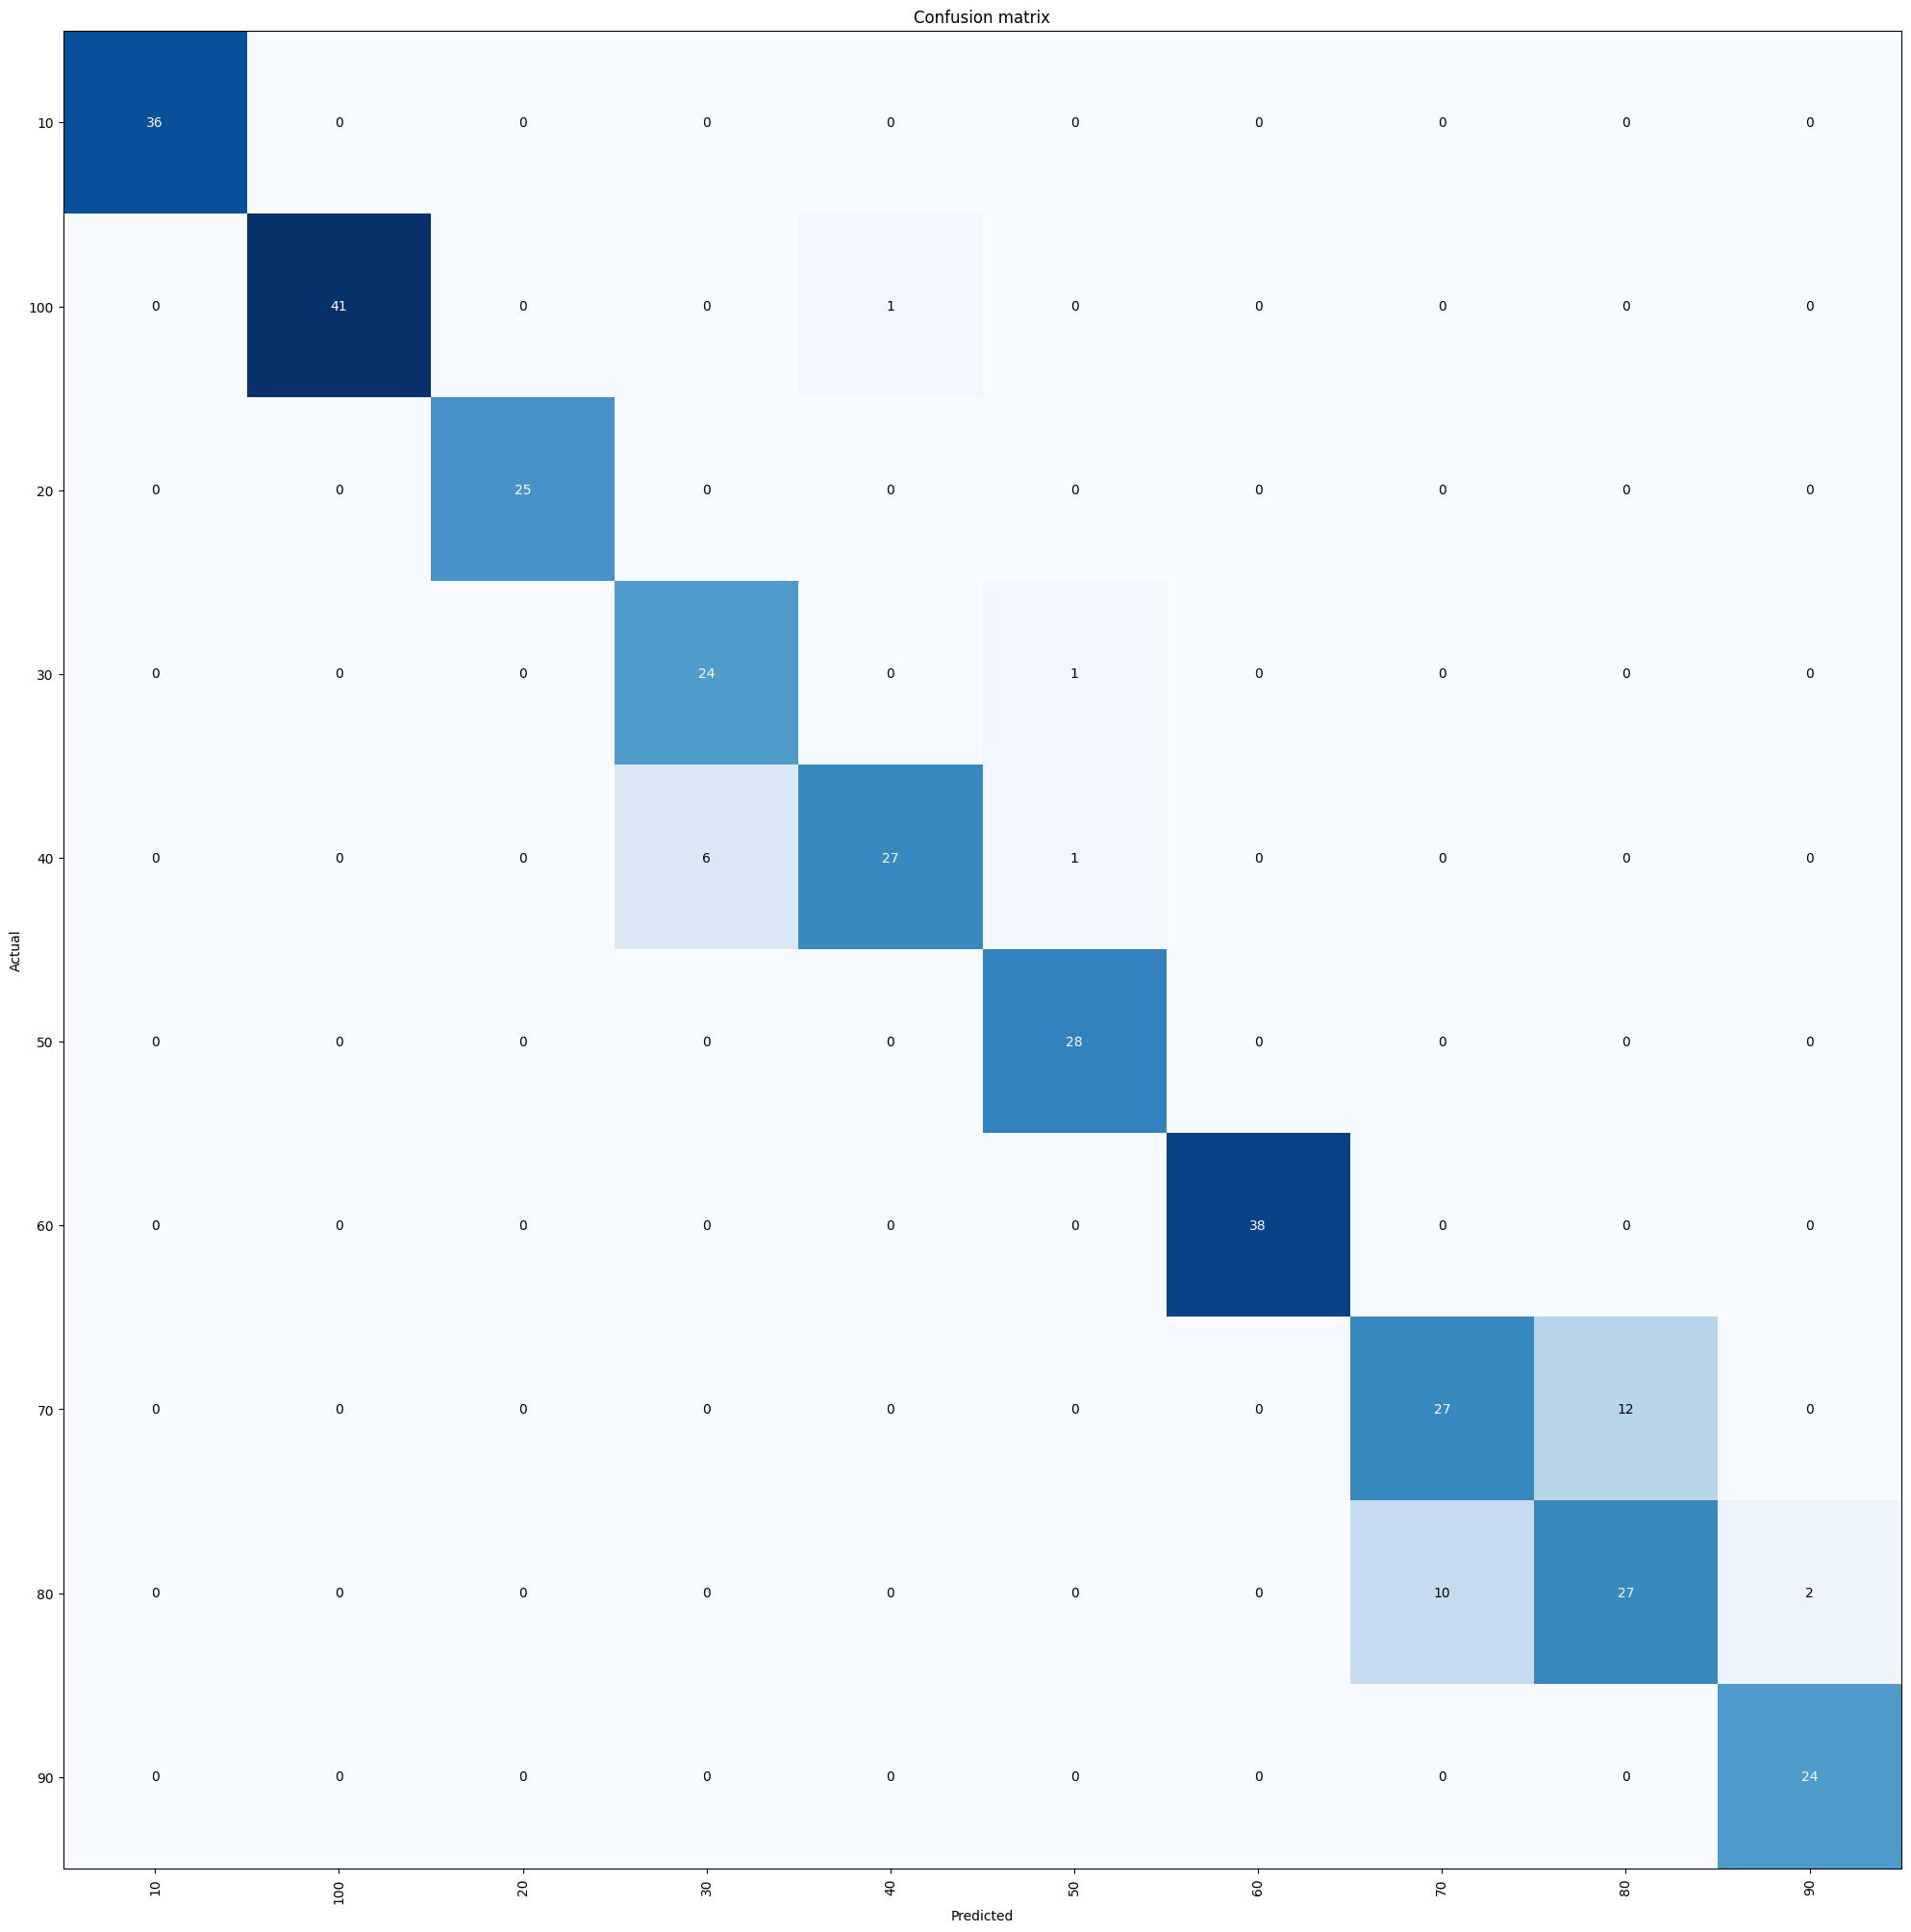

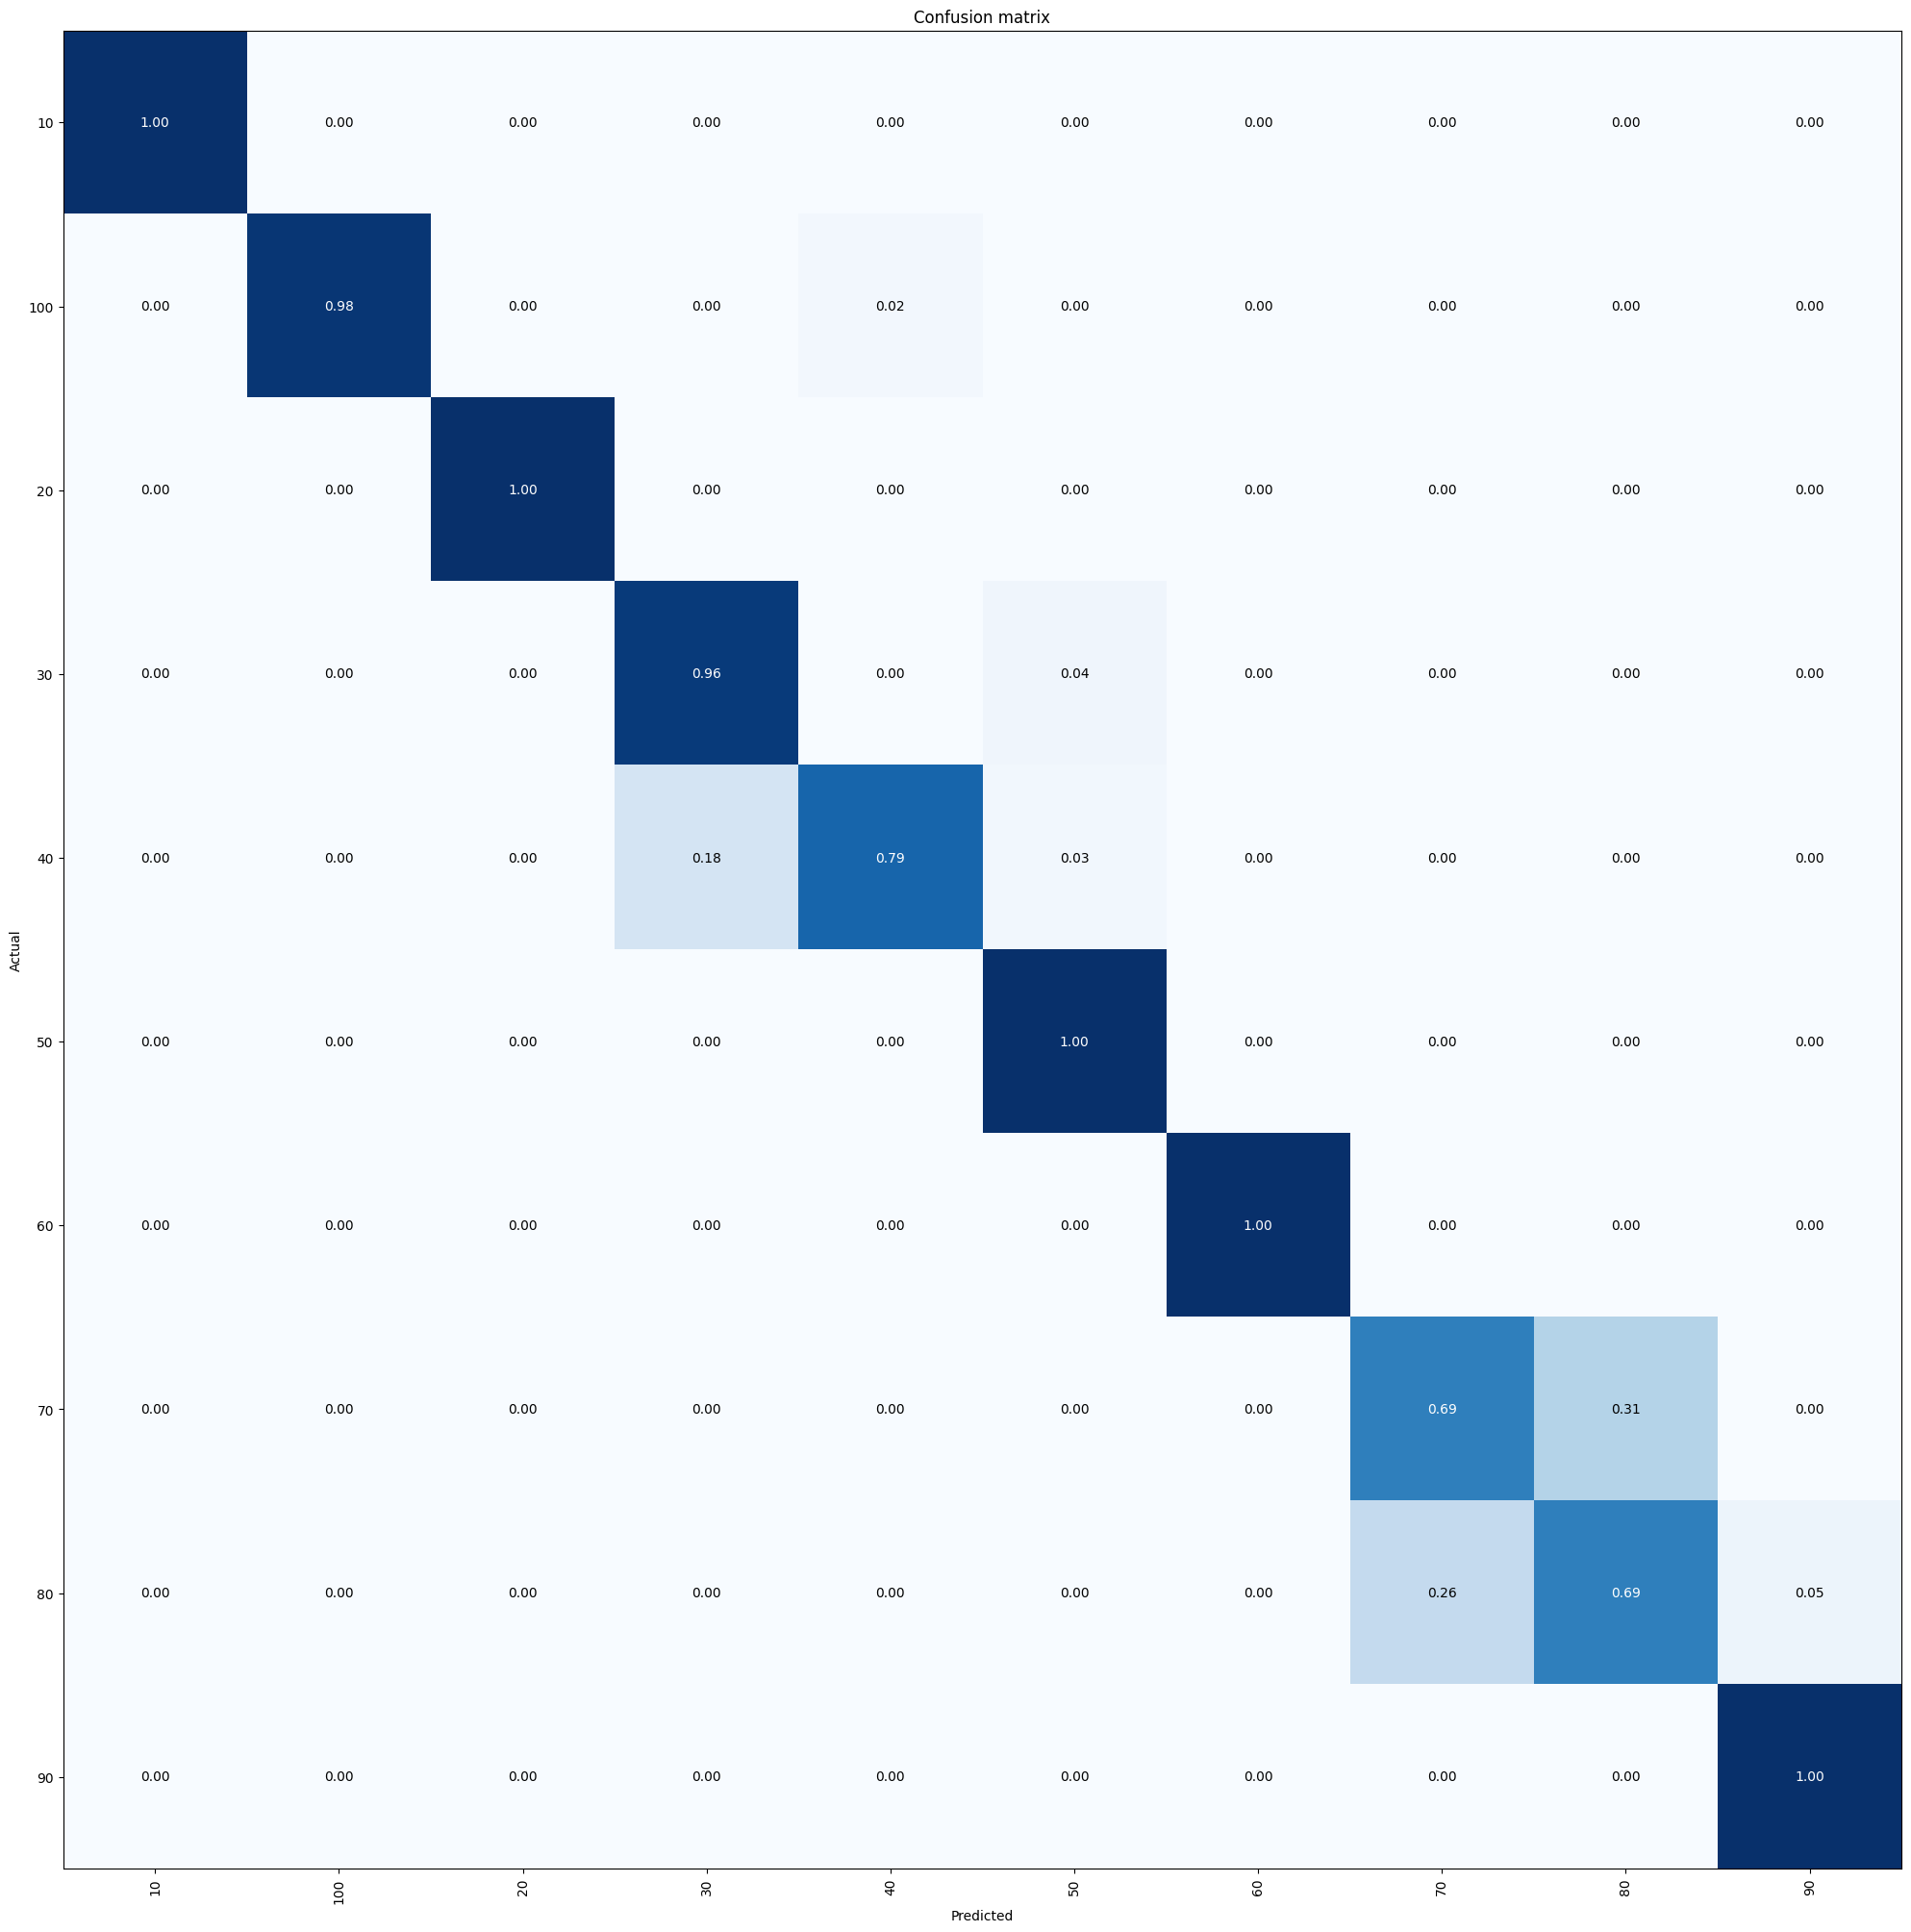

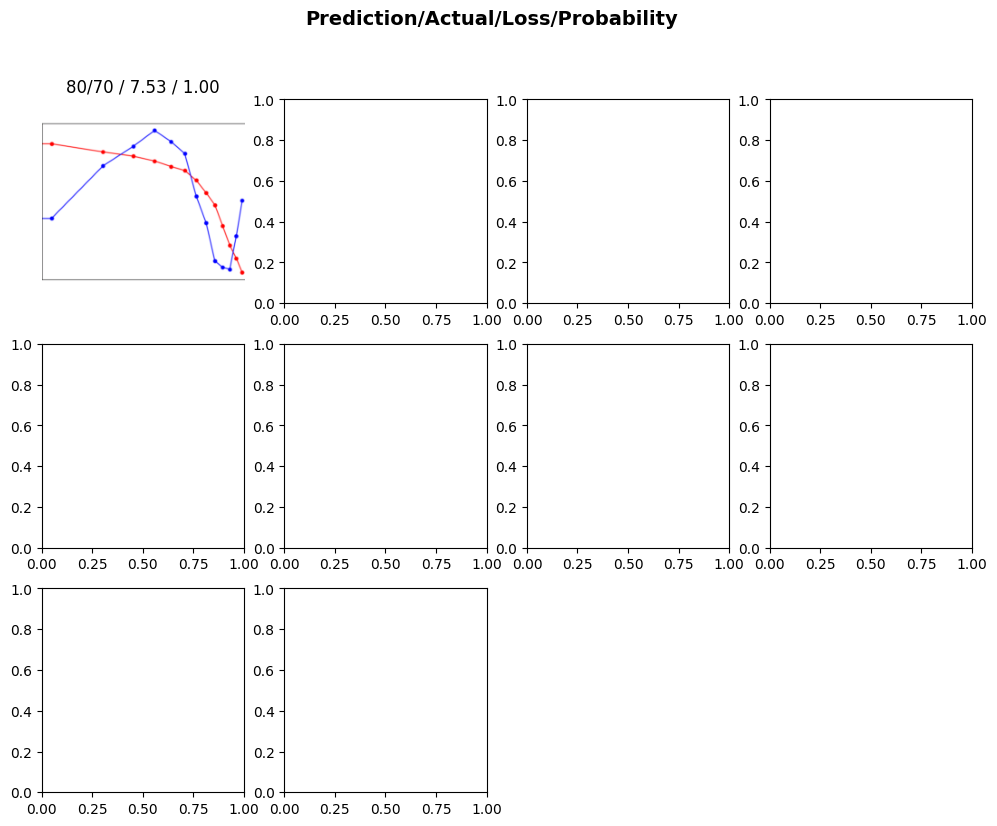

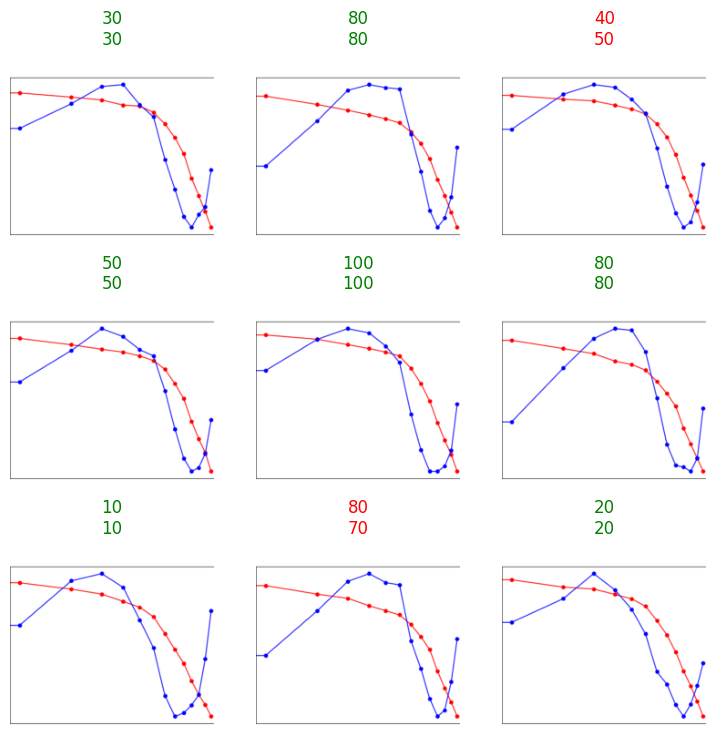

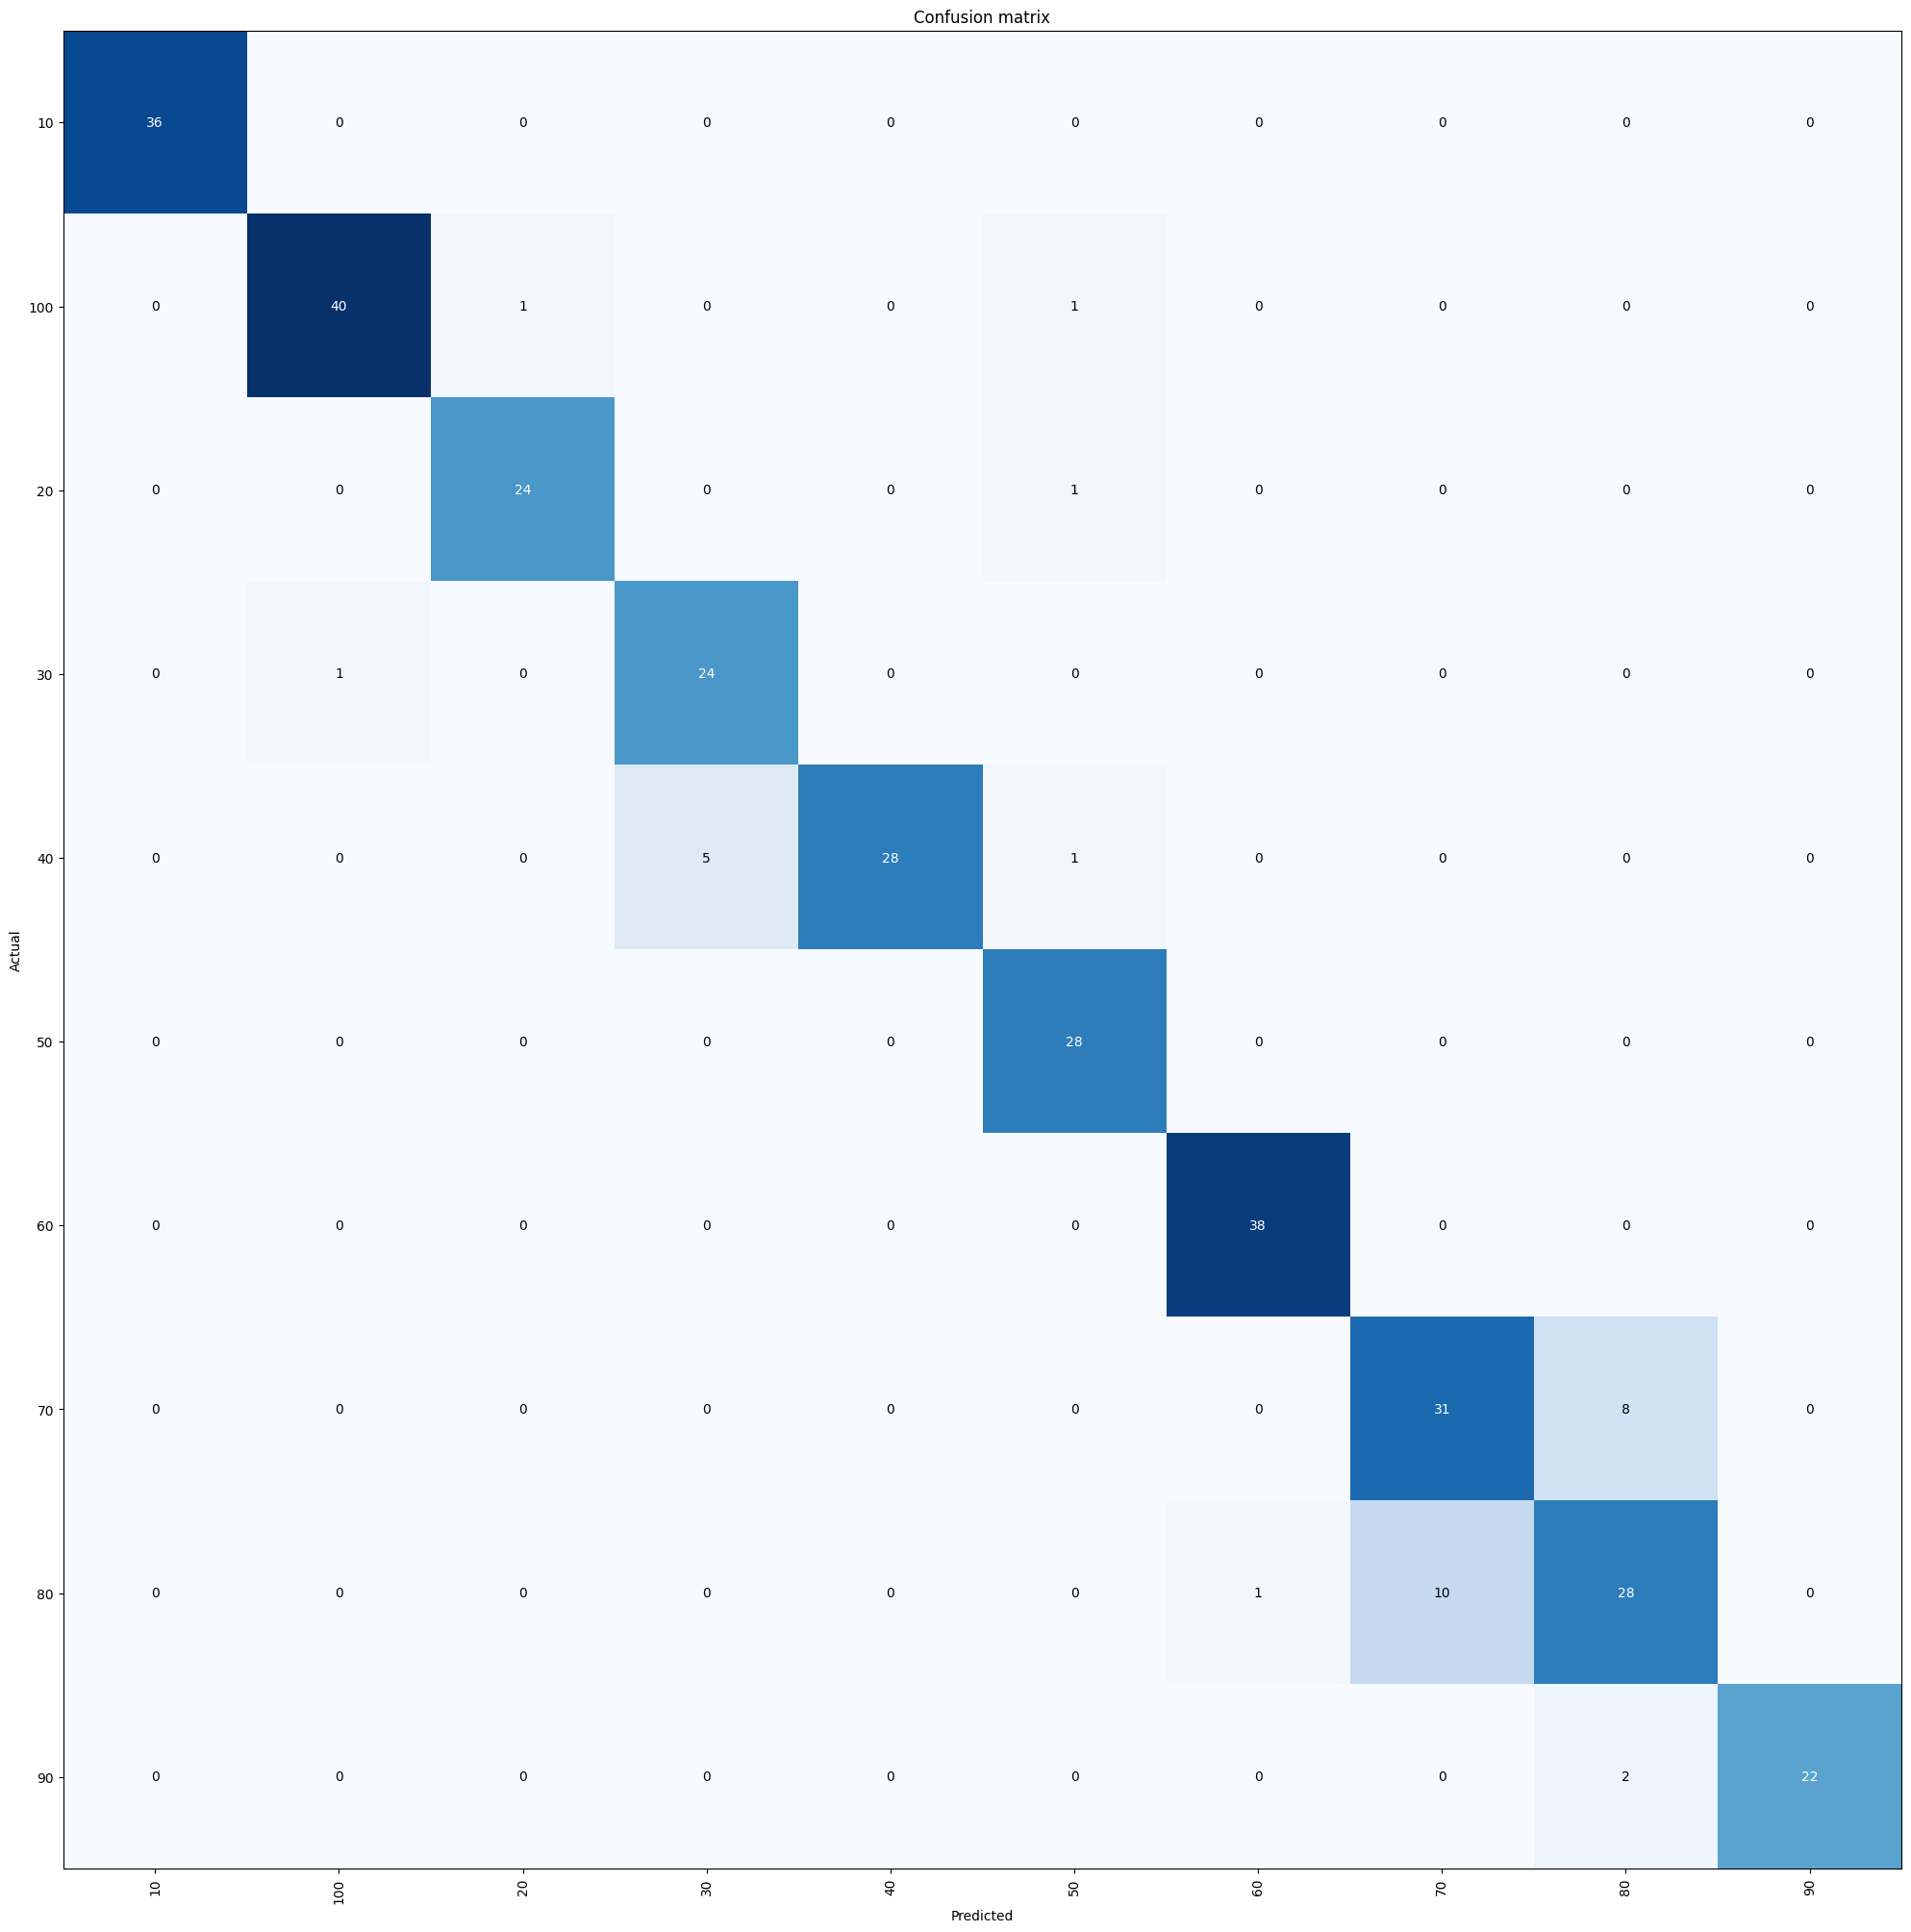

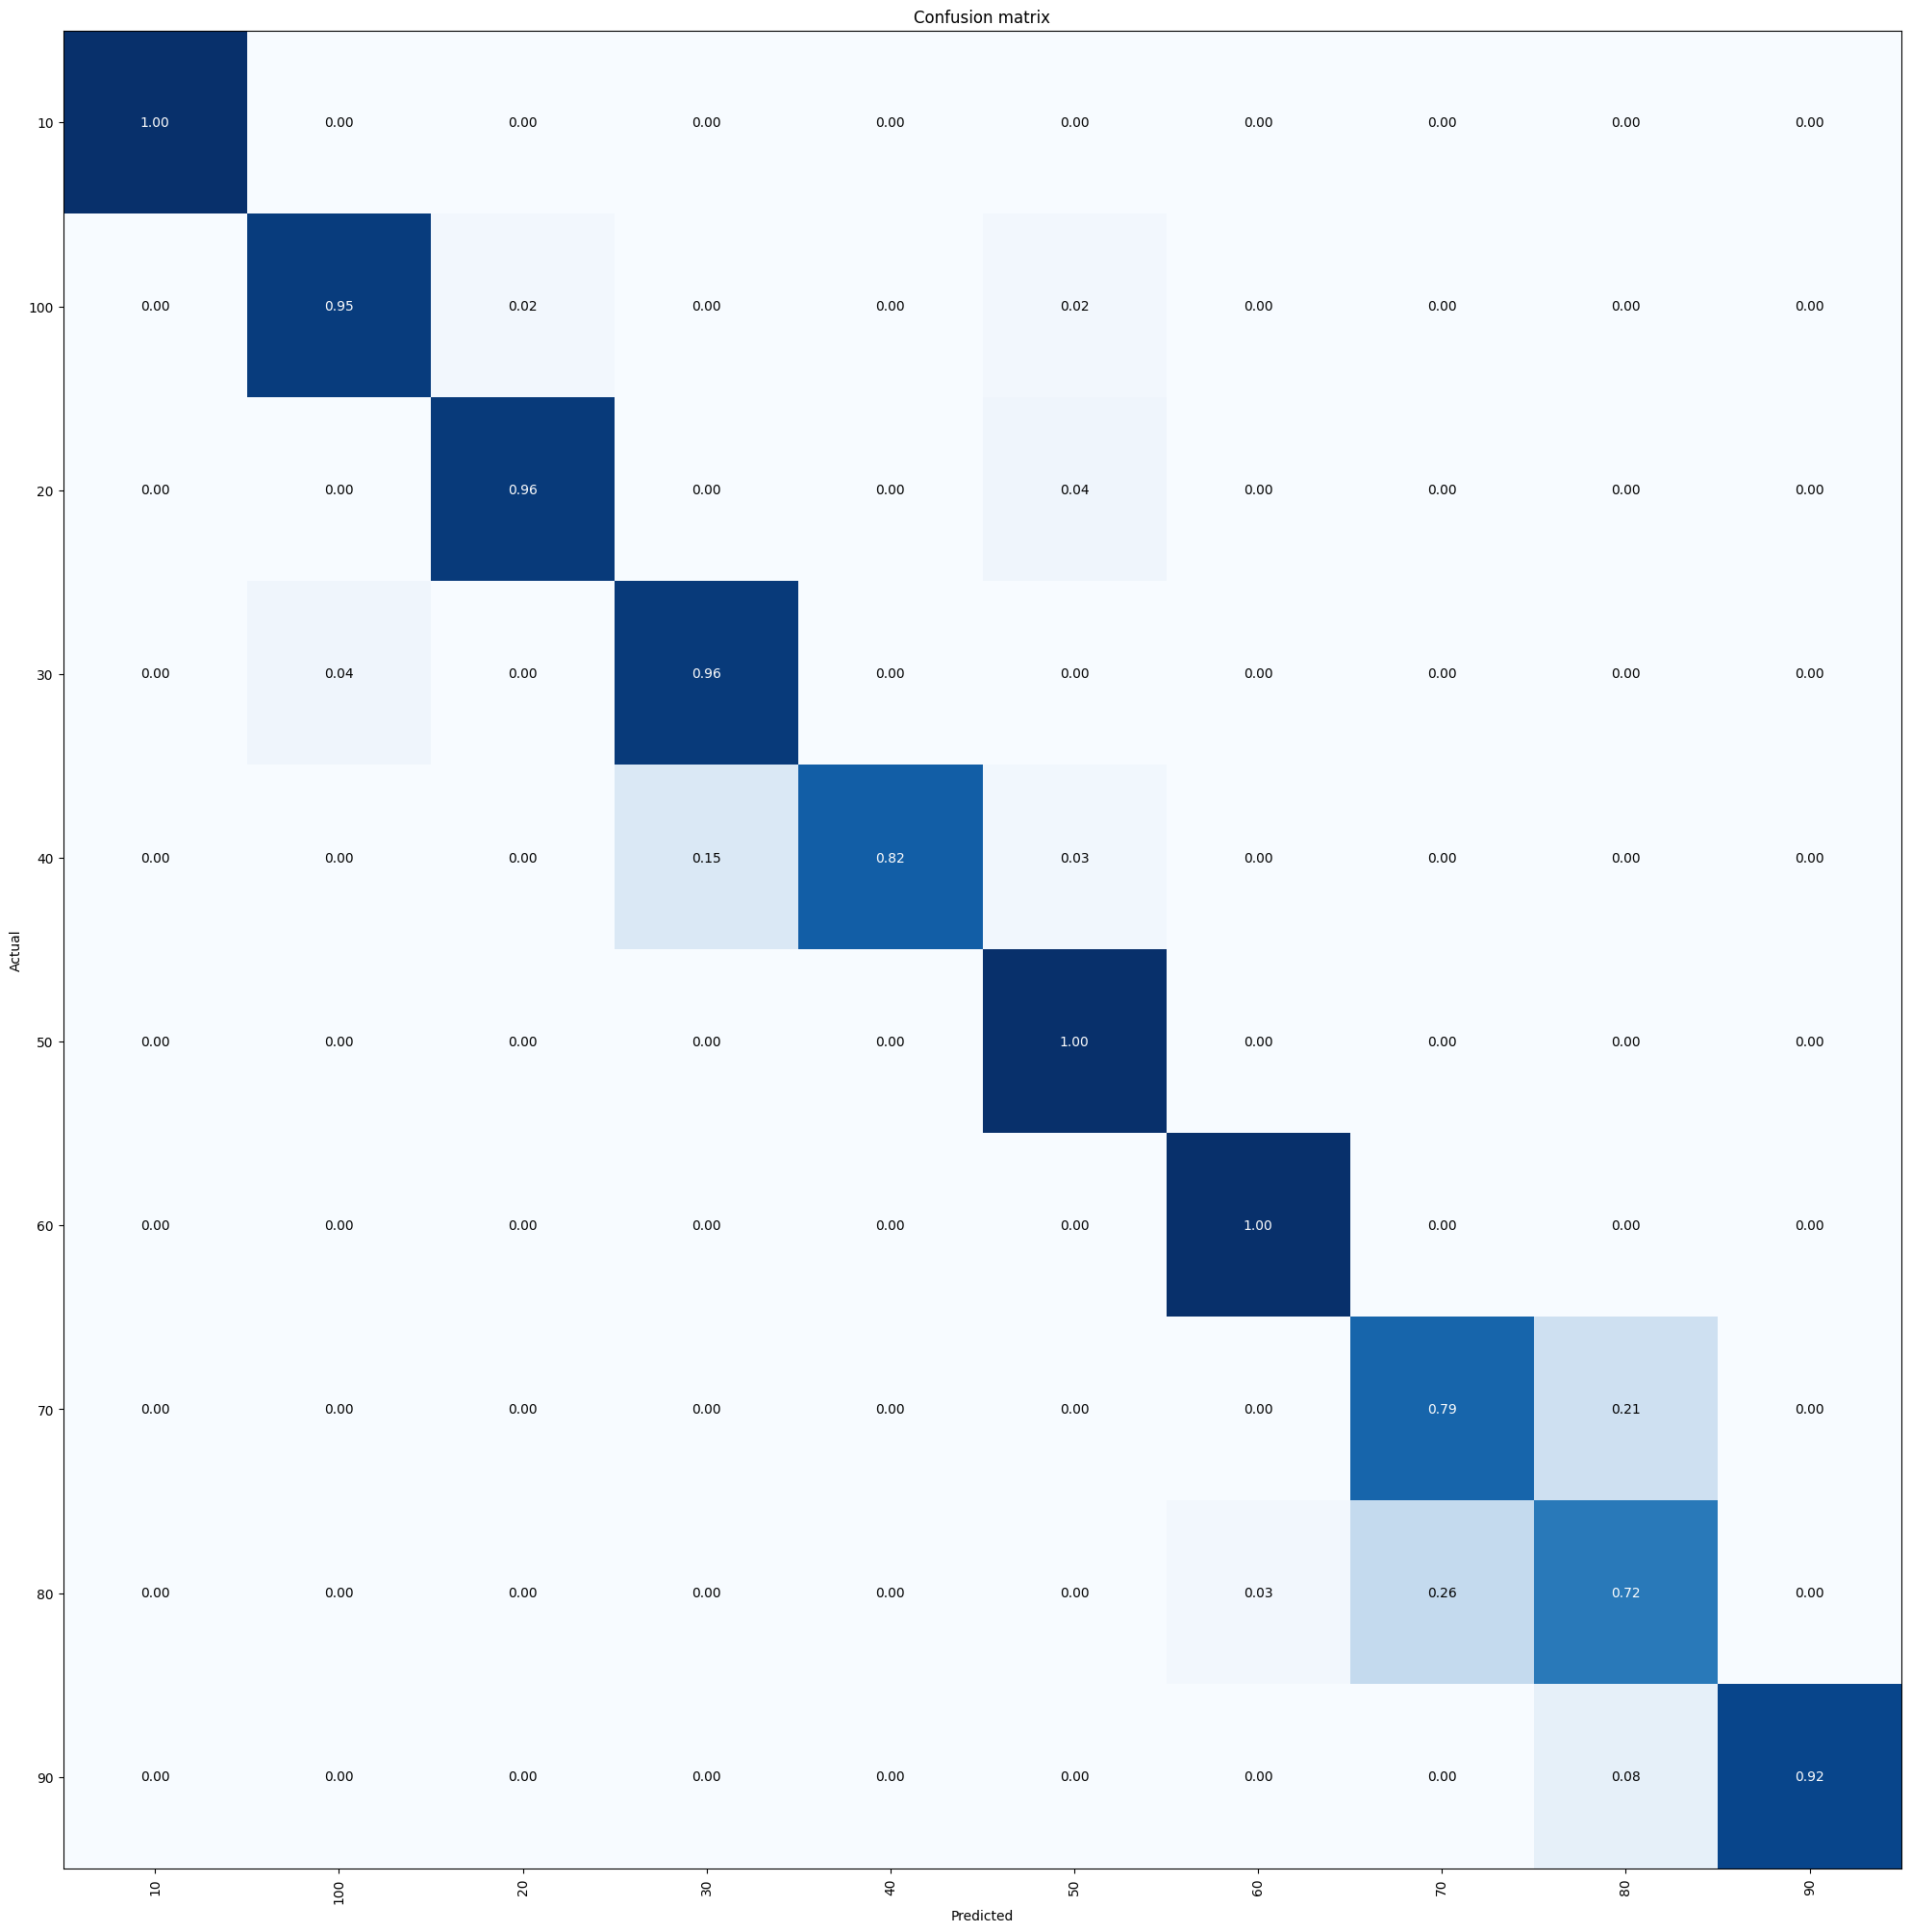

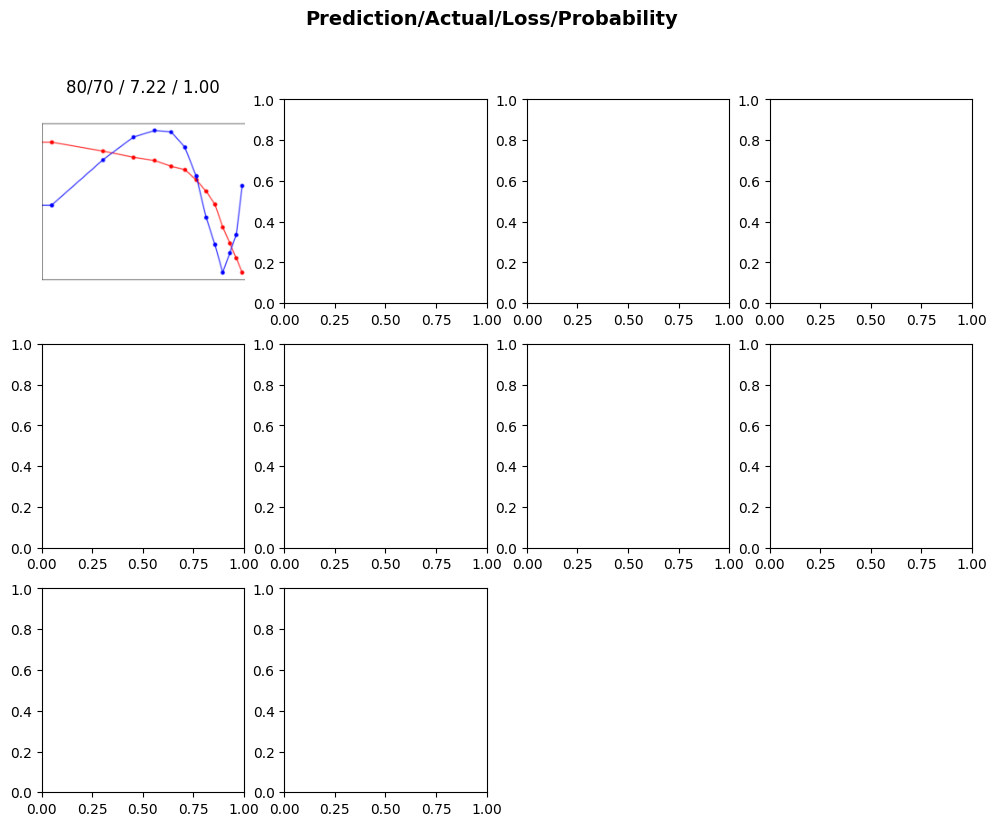

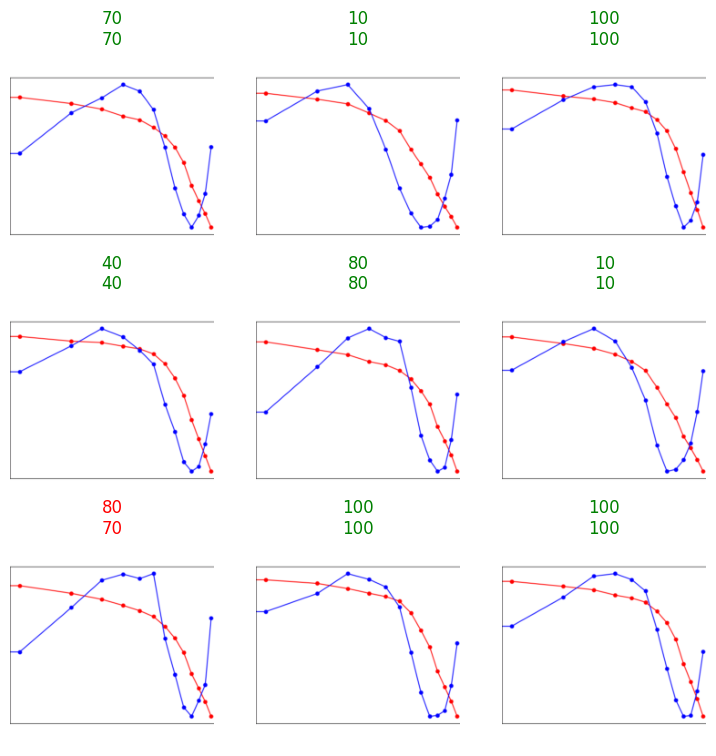

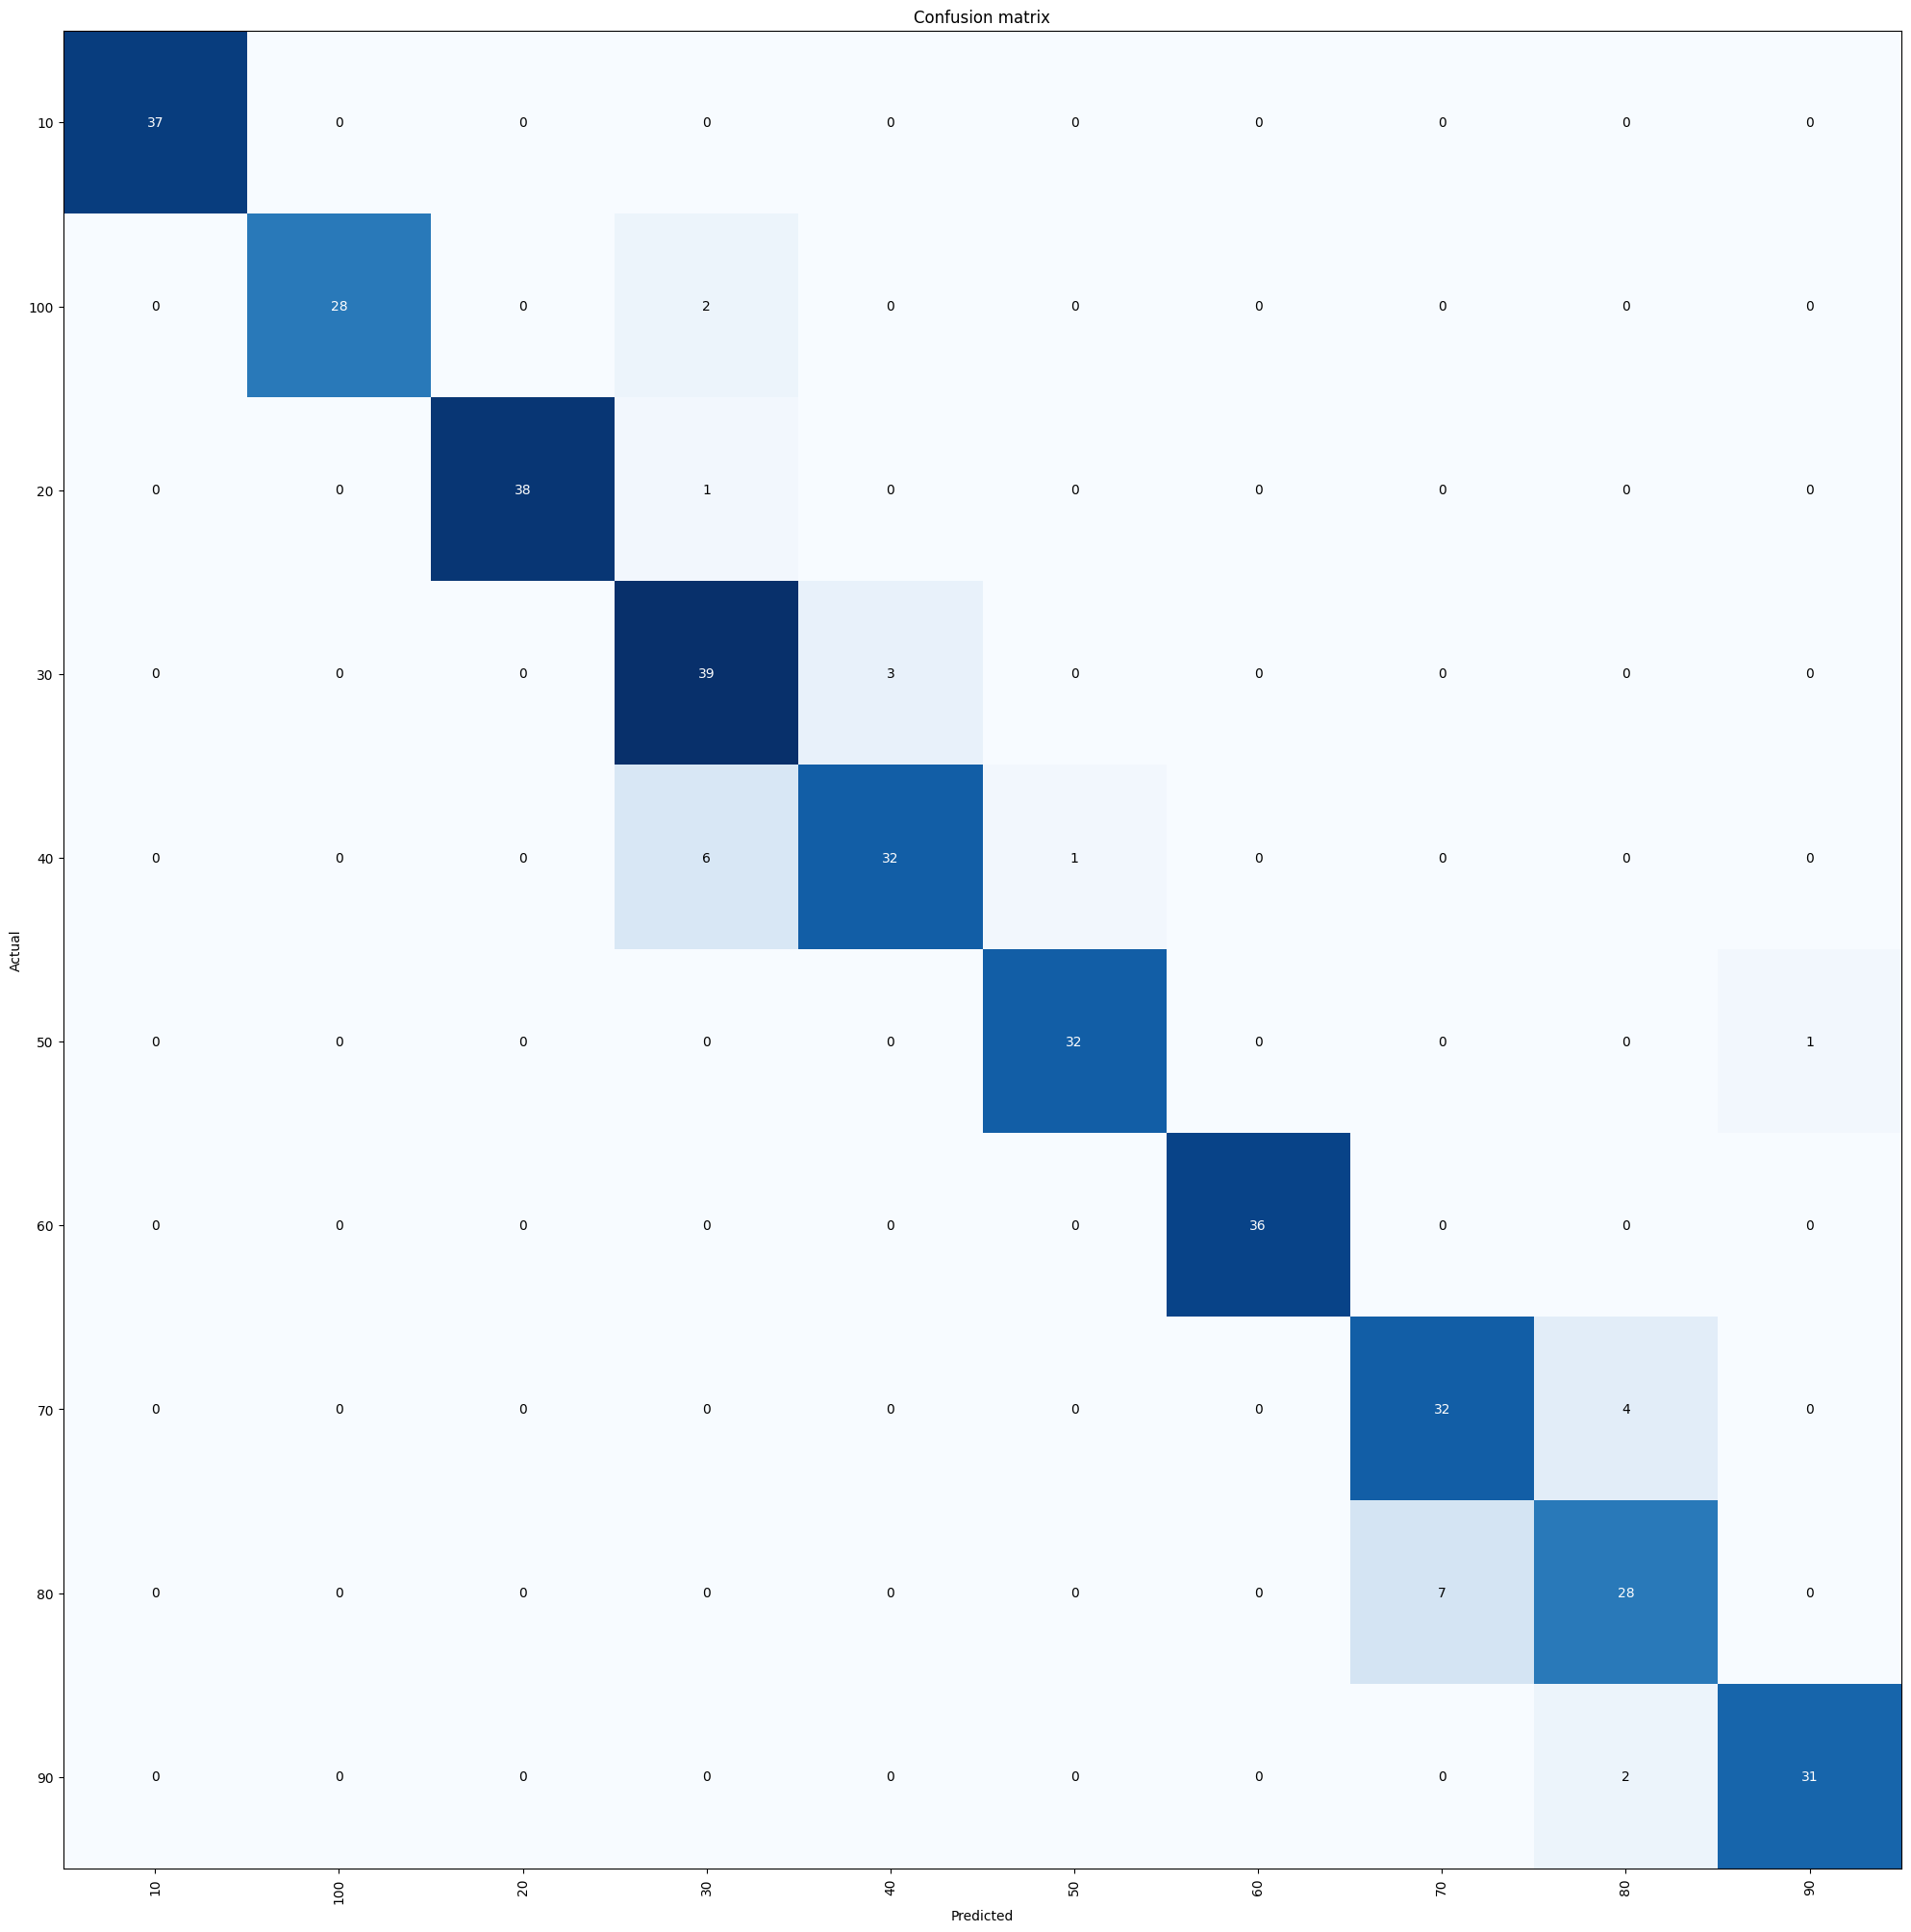

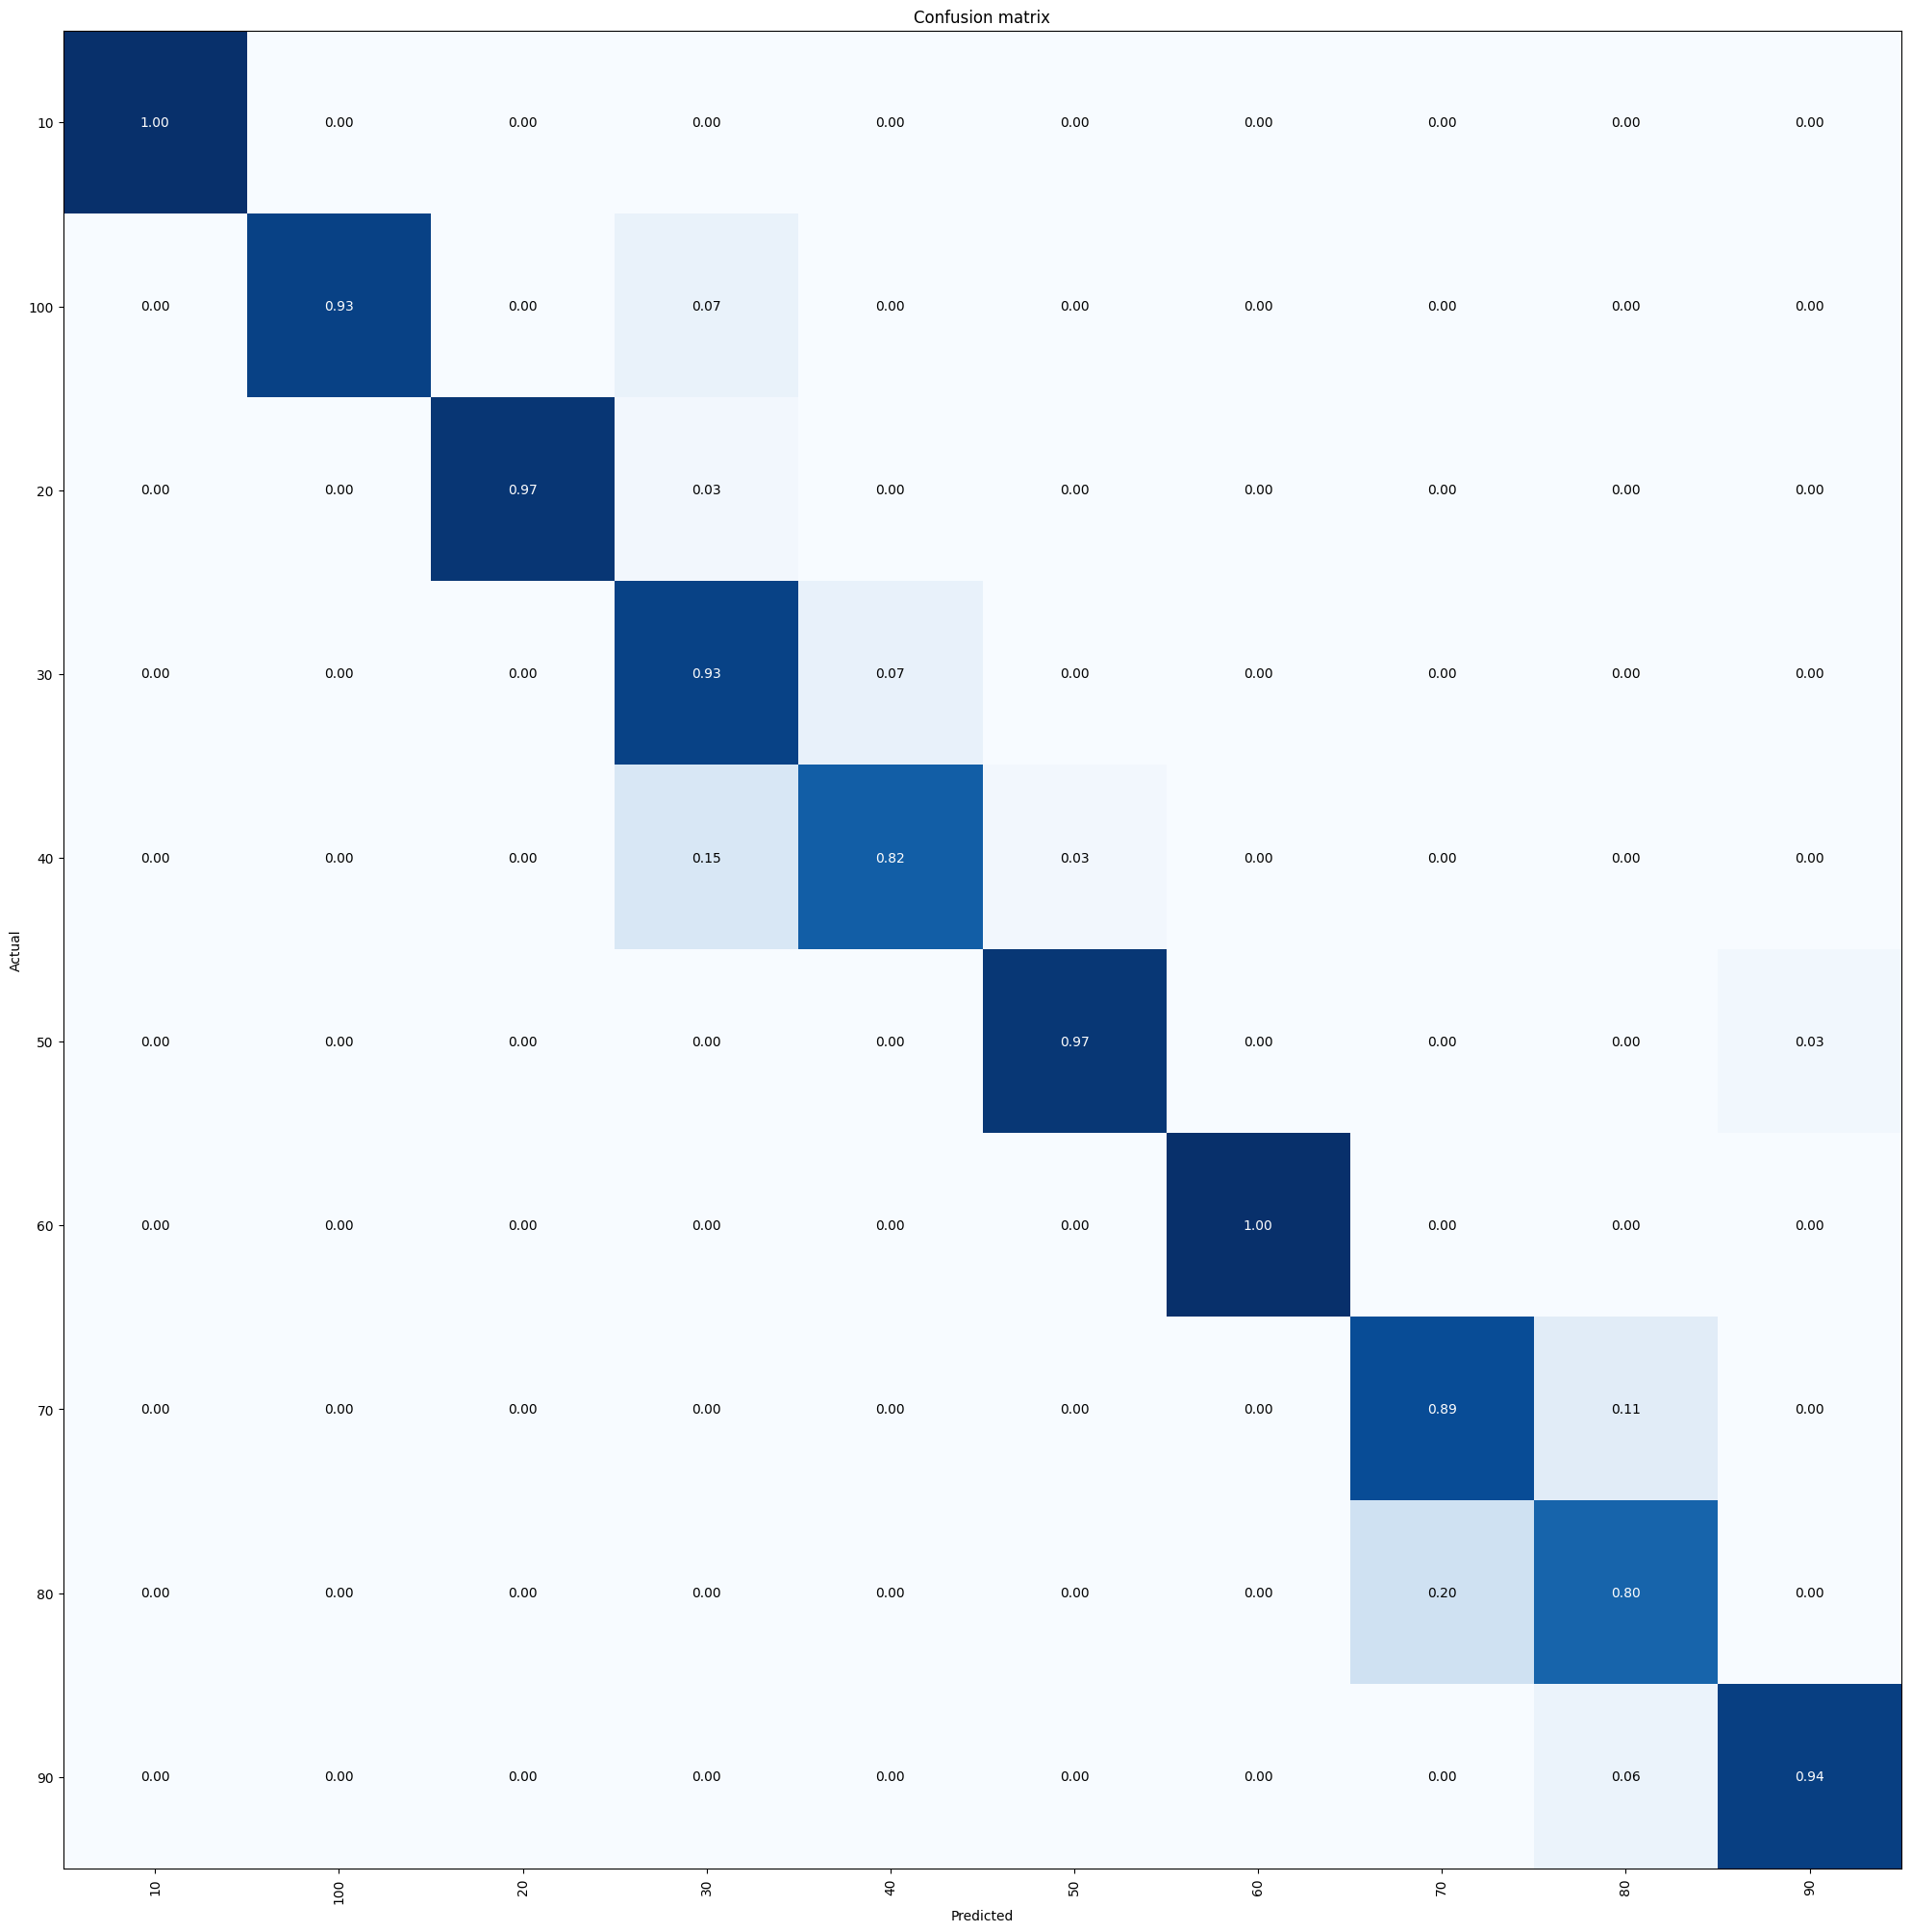

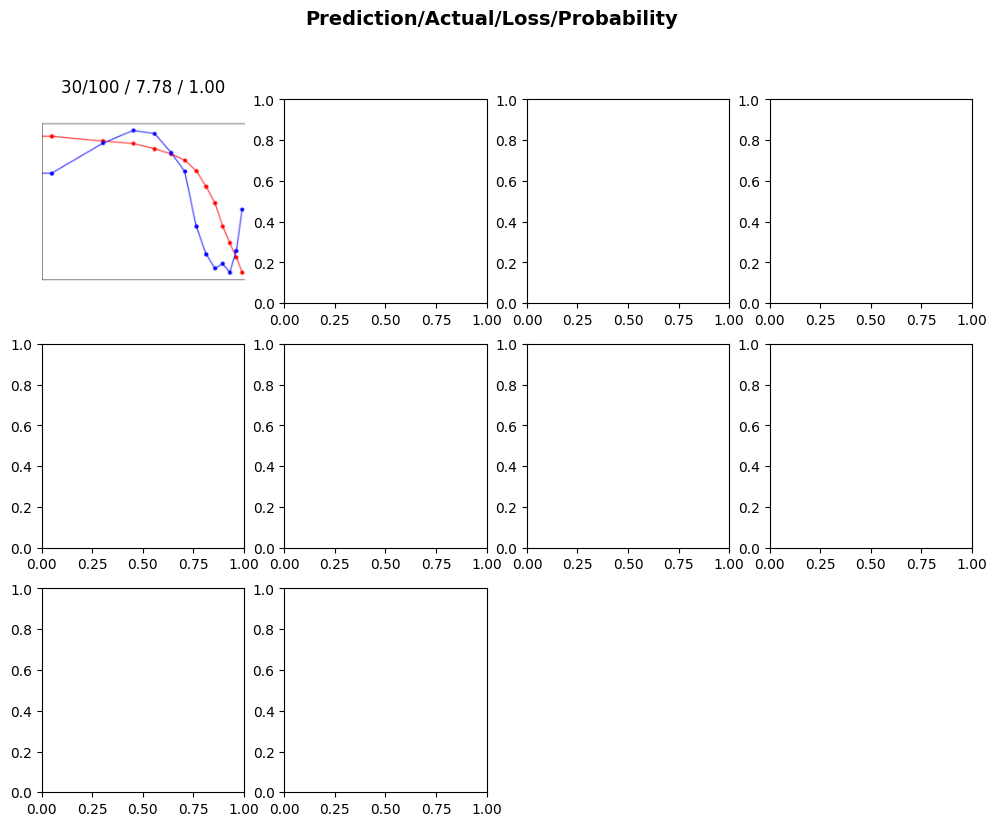

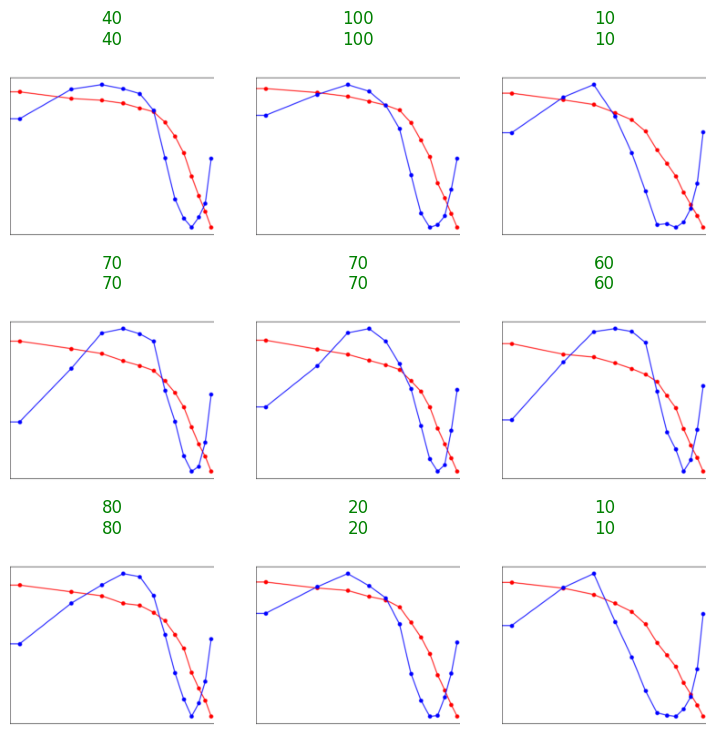

In [18]:
experiments_predictions,exeperiments_targets,experiments_predictions_decoded, models_accuracy,model_top2_accuracy= score_model_on_test_dataset(test_image_dataset_path,experiment_runs_list,saved_weights_files)

In [ ]:
# Calculate ensable prediction
ensamble_prediction = experiments_predictions[0]
for pred in experiments_predictions[1:]:
  ensamble_prediction += pred

ensamble_prediction /= len(experiments_predictions)
#ensamble_accuracy
accuracy(ensamble_prediction, exeperiments_targets[0])

## Leave one out - New measurement test case - Mode: Nyquist

In [19]:
experiment_runs_list=['Paper_MES_v2_leave_one_out_BATT02_Exp_1','Paper_MES_v2_leave_one_out_BATT03_Exp_1','Paper_MES_v2_leave_one_out_BATT05_Exp_1'] 
saved_weights_files= ['Paper_MES_v2_leave_one_out_BATT02_Exp_1_1674172129.773957_SAVED',
                      'Paper_MES_v2_leave_one_out_BATT03_Exp_1_1674172402.991041_SAVED',
                      'Paper_MES_v2_leave_one_out_BATT05_Exp_1_1674172695.466371_SAVED']
test_image_dataset_path= "../data/test_images/Test_dataset_NEW_MEAS_Exp_1"

ExperimentName: Paper_MES_v2_leave_one_out_BATT02_Exp_0
saved weights files: Paper_MES_v2_leave_one_out_BATT02_Exp_0_1674171288.702184_SAVED
Setting-up type transforms pipelines
Found 1100 items
2 datasets of sizes 770,330
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      ../data/images/Paper_MES_v2_leave_one_out_BATT02_Exp_0/Paper_MES_v2_leave_one_out_BATT02_Exp_0-03_5002_20.png
    applying PILBase.create gives
      PILImage mode=RGB size=640x480
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../data/images/Paper_MES_v2_leave_one_out_BATT02_Exp_0/Paper_MES_v2_leave_one_out_BATT02_Exp_0-03_5002_20.png
    applying RegexLabeller gives
      20
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(2)

Final sample: (PIL

[[36  0  0  0  0  0  0  0  0  0]
 [ 0 41  0  0  1  0  0  0  0  0]
 [ 0  0 25  0  0  0  0  0  0  0]
 [ 0  0  0 24  0  1  0  0  0  0]
 [ 0  0  0  6 27  1  0  0  0  0]
 [ 0  0  0  0  0 28  0  0  0  0]
 [ 0  0  0  0  0  0 38  0  0  0]
 [ 0  0  0  0  0  0  0 27 12  0]
 [ 0  0  0  0  0  0  0 10 27  2]
 [ 0  0  0  0  0  0  0  0  0 24]]
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.97619048 0.         0.         0.02380952 0.
  0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.96       0.         0.04
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.17647059 0.79411765 0.02941176
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        ]
 [0.         0.  

learn.validate()


Model accuracy: 0.90
learn.get_preds()


model_accuracy on test dataset: TensorBase(0.1300)
model_top2_accuracy on test dataset: 0.23
ExperimentName: Paper_MES_v2_leave_one_out_BATT03_Exp_0
saved weights files: Paper_MES_v2_leave_one_out_BATT03_Exp_0_1674171562.600012_SAVED
Setting-up type transforms pipelines
Found 1100 items
2 datasets of sizes 770,330
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      ../data/images/Paper_MES_v2_leave_one_out_BATT03_Exp_0/Paper_MES_v2_leave_one_out_BATT03_Exp_0-02_5002_20.png
    applying PILBase.create gives
      PILImage mode=RGB size=640x480
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../data/images/Paper_MES_v2_leave_one_out_BATT03_Exp_0/Paper_MES_v2_leave_one_out_BATT03_Exp_0-02_5002_20.png
    applying RegexLabeller gives
      20
    applying Categorize -- {'v

[[36  0  0  0  0  0  0  0  0  0]
 [ 0 40  1  0  0  1  0  0  0  0]
 [ 0  0 24  0  0  1  0  0  0  0]
 [ 0  1  0 24  0  0  0  0  0  0]
 [ 0  0  0  5 28  1  0  0  0  0]
 [ 0  0  0  0  0 28  0  0  0  0]
 [ 0  0  0  0  0  0 38  0  0  0]
 [ 0  0  0  0  0  0  0 31  8  0]
 [ 0  0  0  0  0  0  1 10 28  0]
 [ 0  0  0  0  0  0  0  0  2 22]]
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.95238095 0.02380952 0.         0.         0.02380952
  0.         0.         0.         0.        ]
 [0.         0.         0.96       0.         0.         0.04
  0.         0.         0.         0.        ]
 [0.         0.04       0.         0.96       0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.14705882 0.82352941 0.02941176
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        ]
 [0.     

learn.validate()


Model accuracy: 0.91
learn.get_preds()


model_accuracy on test dataset: TensorBase(0.0800)
model_top2_accuracy on test dataset: 0.11
ExperimentName: Paper_MES_v2_leave_one_out_BATT05_Exp_0
saved weights files: Paper_MES_v2_leave_one_out_BATT05_Exp_0_1674171856.034339_SAVED
Setting-up type transforms pipelines
Found 1200 items
2 datasets of sizes 840,360
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      ../data/images/Paper_MES_v2_leave_one_out_BATT05_Exp_0/Paper_MES_v2_leave_one_out_BATT05_Exp_0-03_6003_100.png
    applying PILBase.create gives
      PILImage mode=RGB size=640x480
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../data/images/Paper_MES_v2_leave_one_out_BATT05_Exp_0/Paper_MES_v2_leave_one_out_BATT05_Exp_0-03_6003_100.png
    applying RegexLabeller gives
      100
    applying Categorize -- 

[[37  0  0  0  0  0  0  0  0  0]
 [ 0 28  0  2  0  0  0  0  0  0]
 [ 0  0 38  1  0  0  0  0  0  0]
 [ 0  0  0 39  3  0  0  0  0  0]
 [ 0  0  0  6 32  1  0  0  0  0]
 [ 0  0  0  0  0 32  0  0  0  1]
 [ 0  0  0  0  0  0 36  0  0  0]
 [ 0  0  0  0  0  0  0 32  4  0]
 [ 0  0  0  0  0  0  0  7 28  0]
 [ 0  0  0  0  0  0  0  0  2 31]]
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.93333333 0.         0.06666667 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.97435897 0.02564103 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.92857143 0.07142857 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.15384615 0.82051282 0.02564103
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.96969697
  0.         0.         0.         0.03030303]
 [0.       

learn.validate()


Model accuracy: 0.93
learn.get_preds()


model_accuracy on test dataset: TensorBase(0.0700)
model_top2_accuracy on test dataset: 0.21


TensorBase(0.0200)

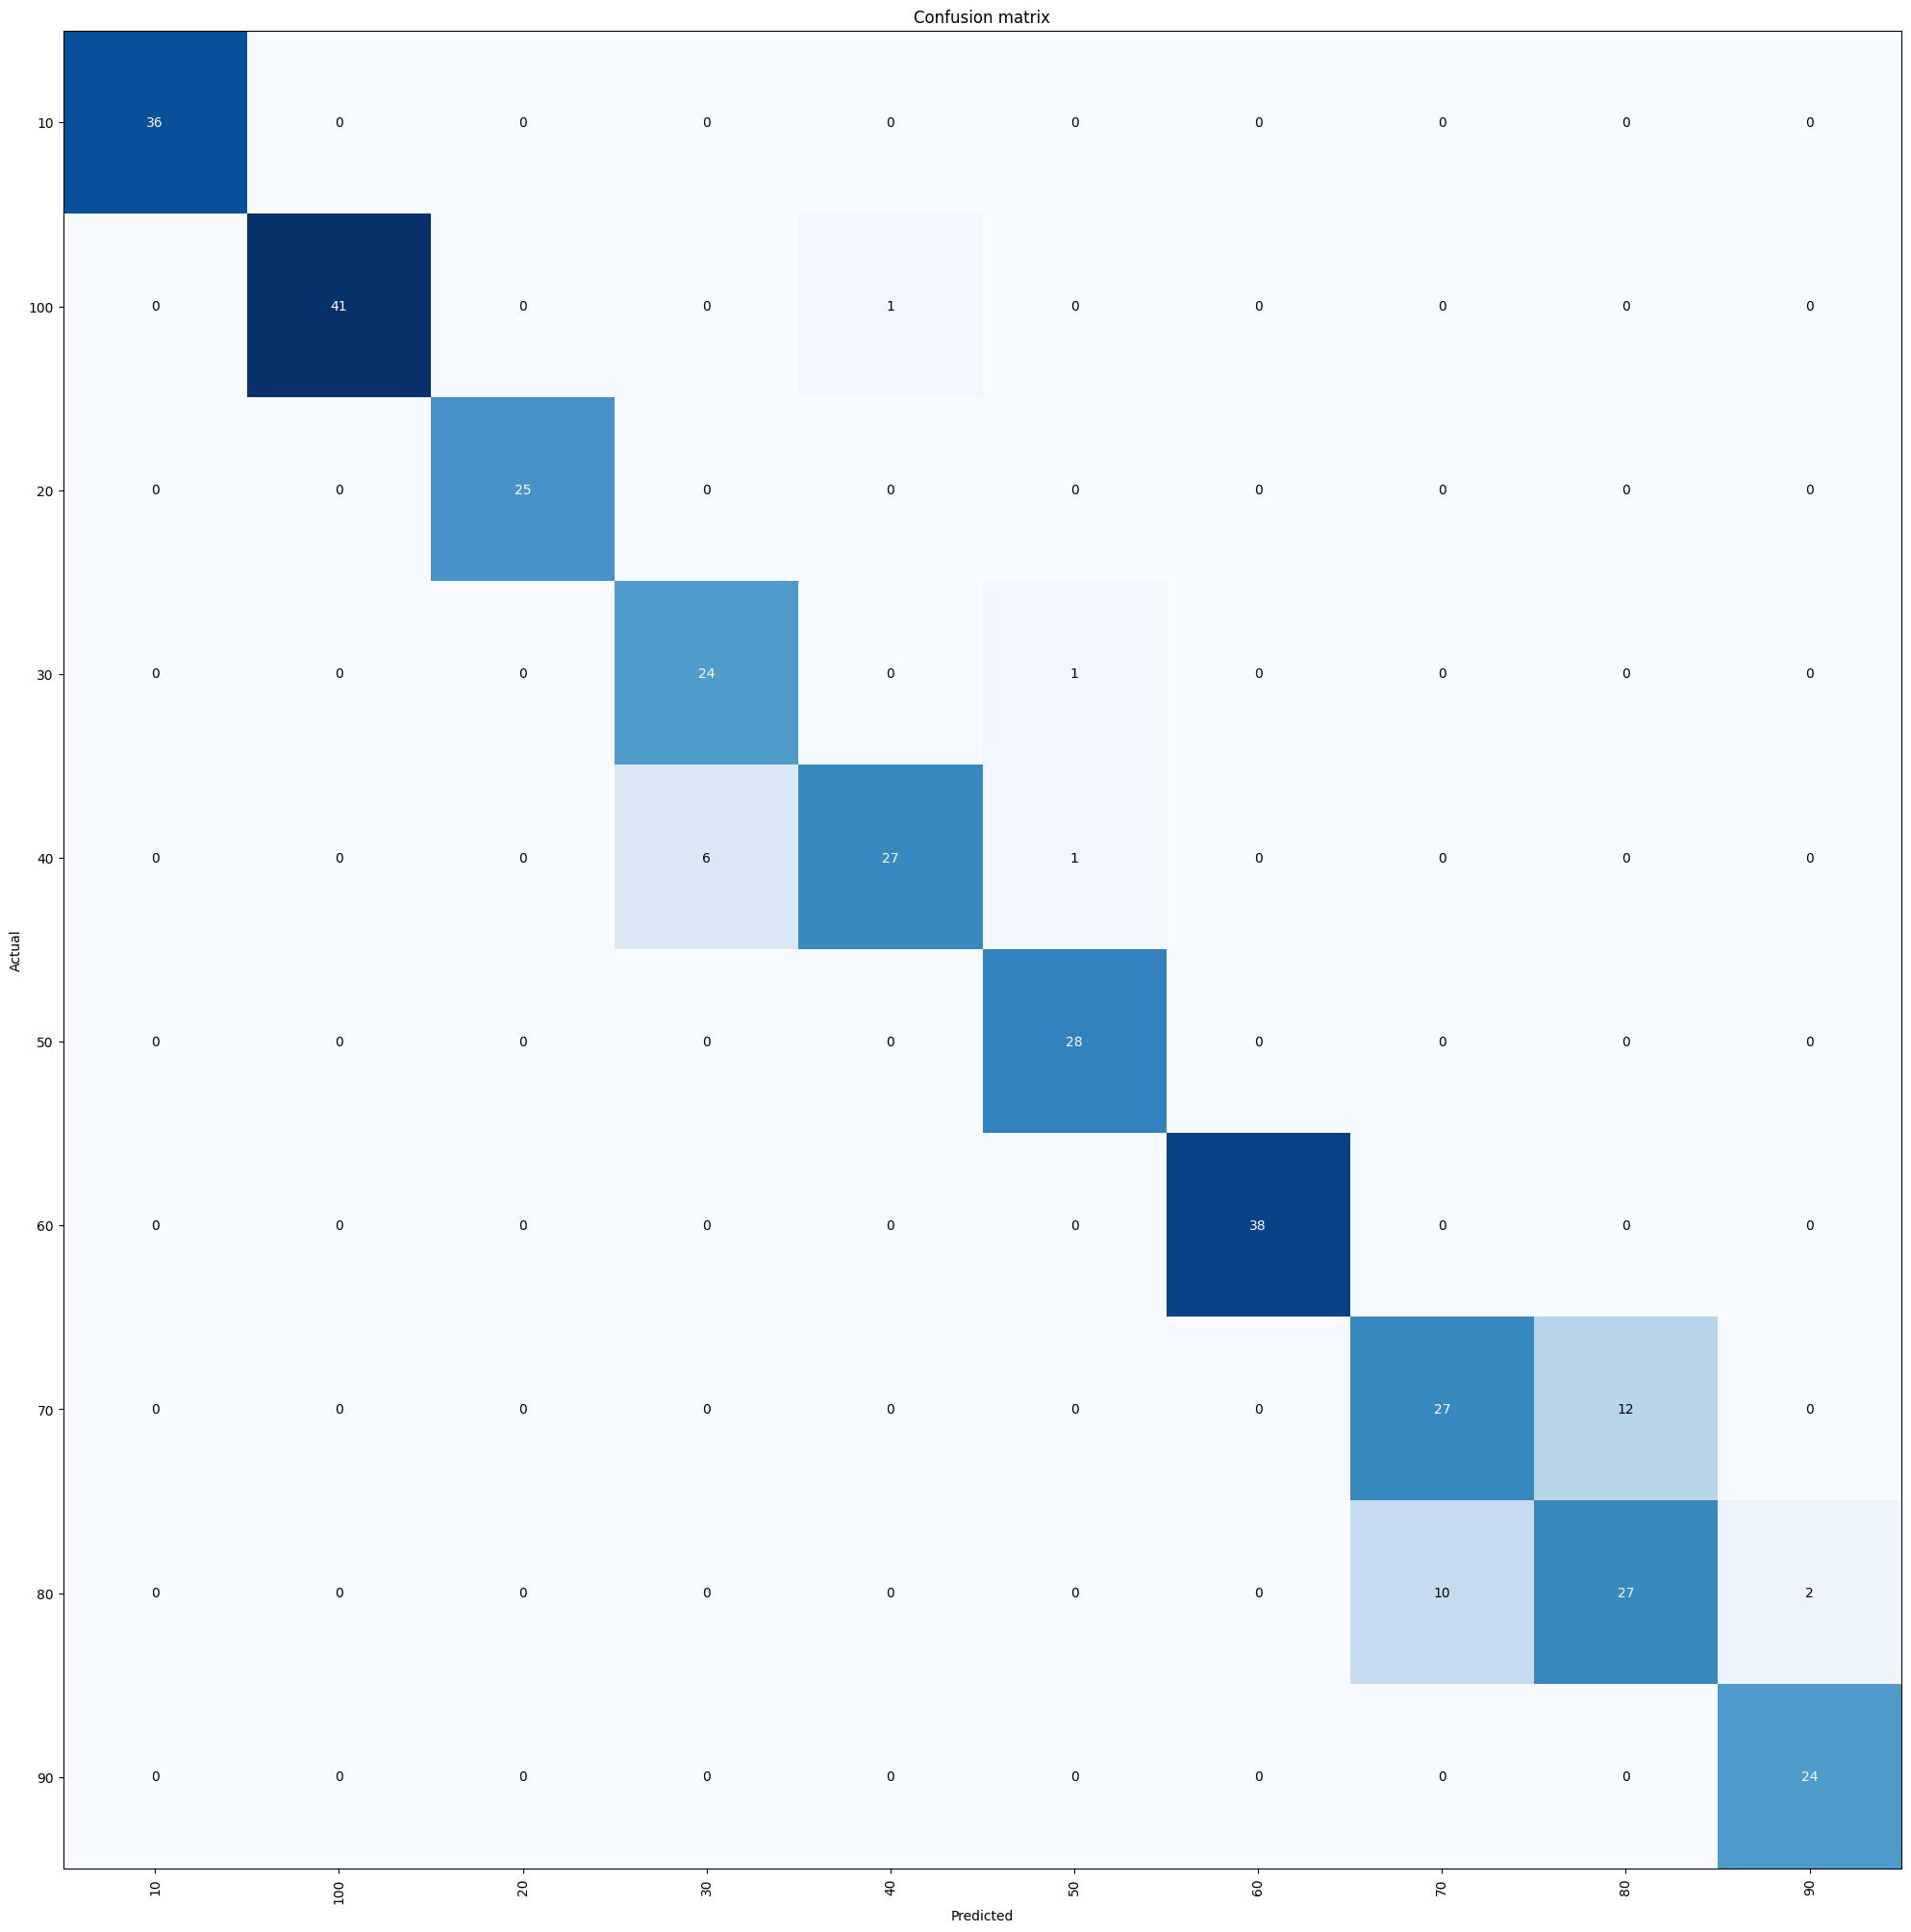

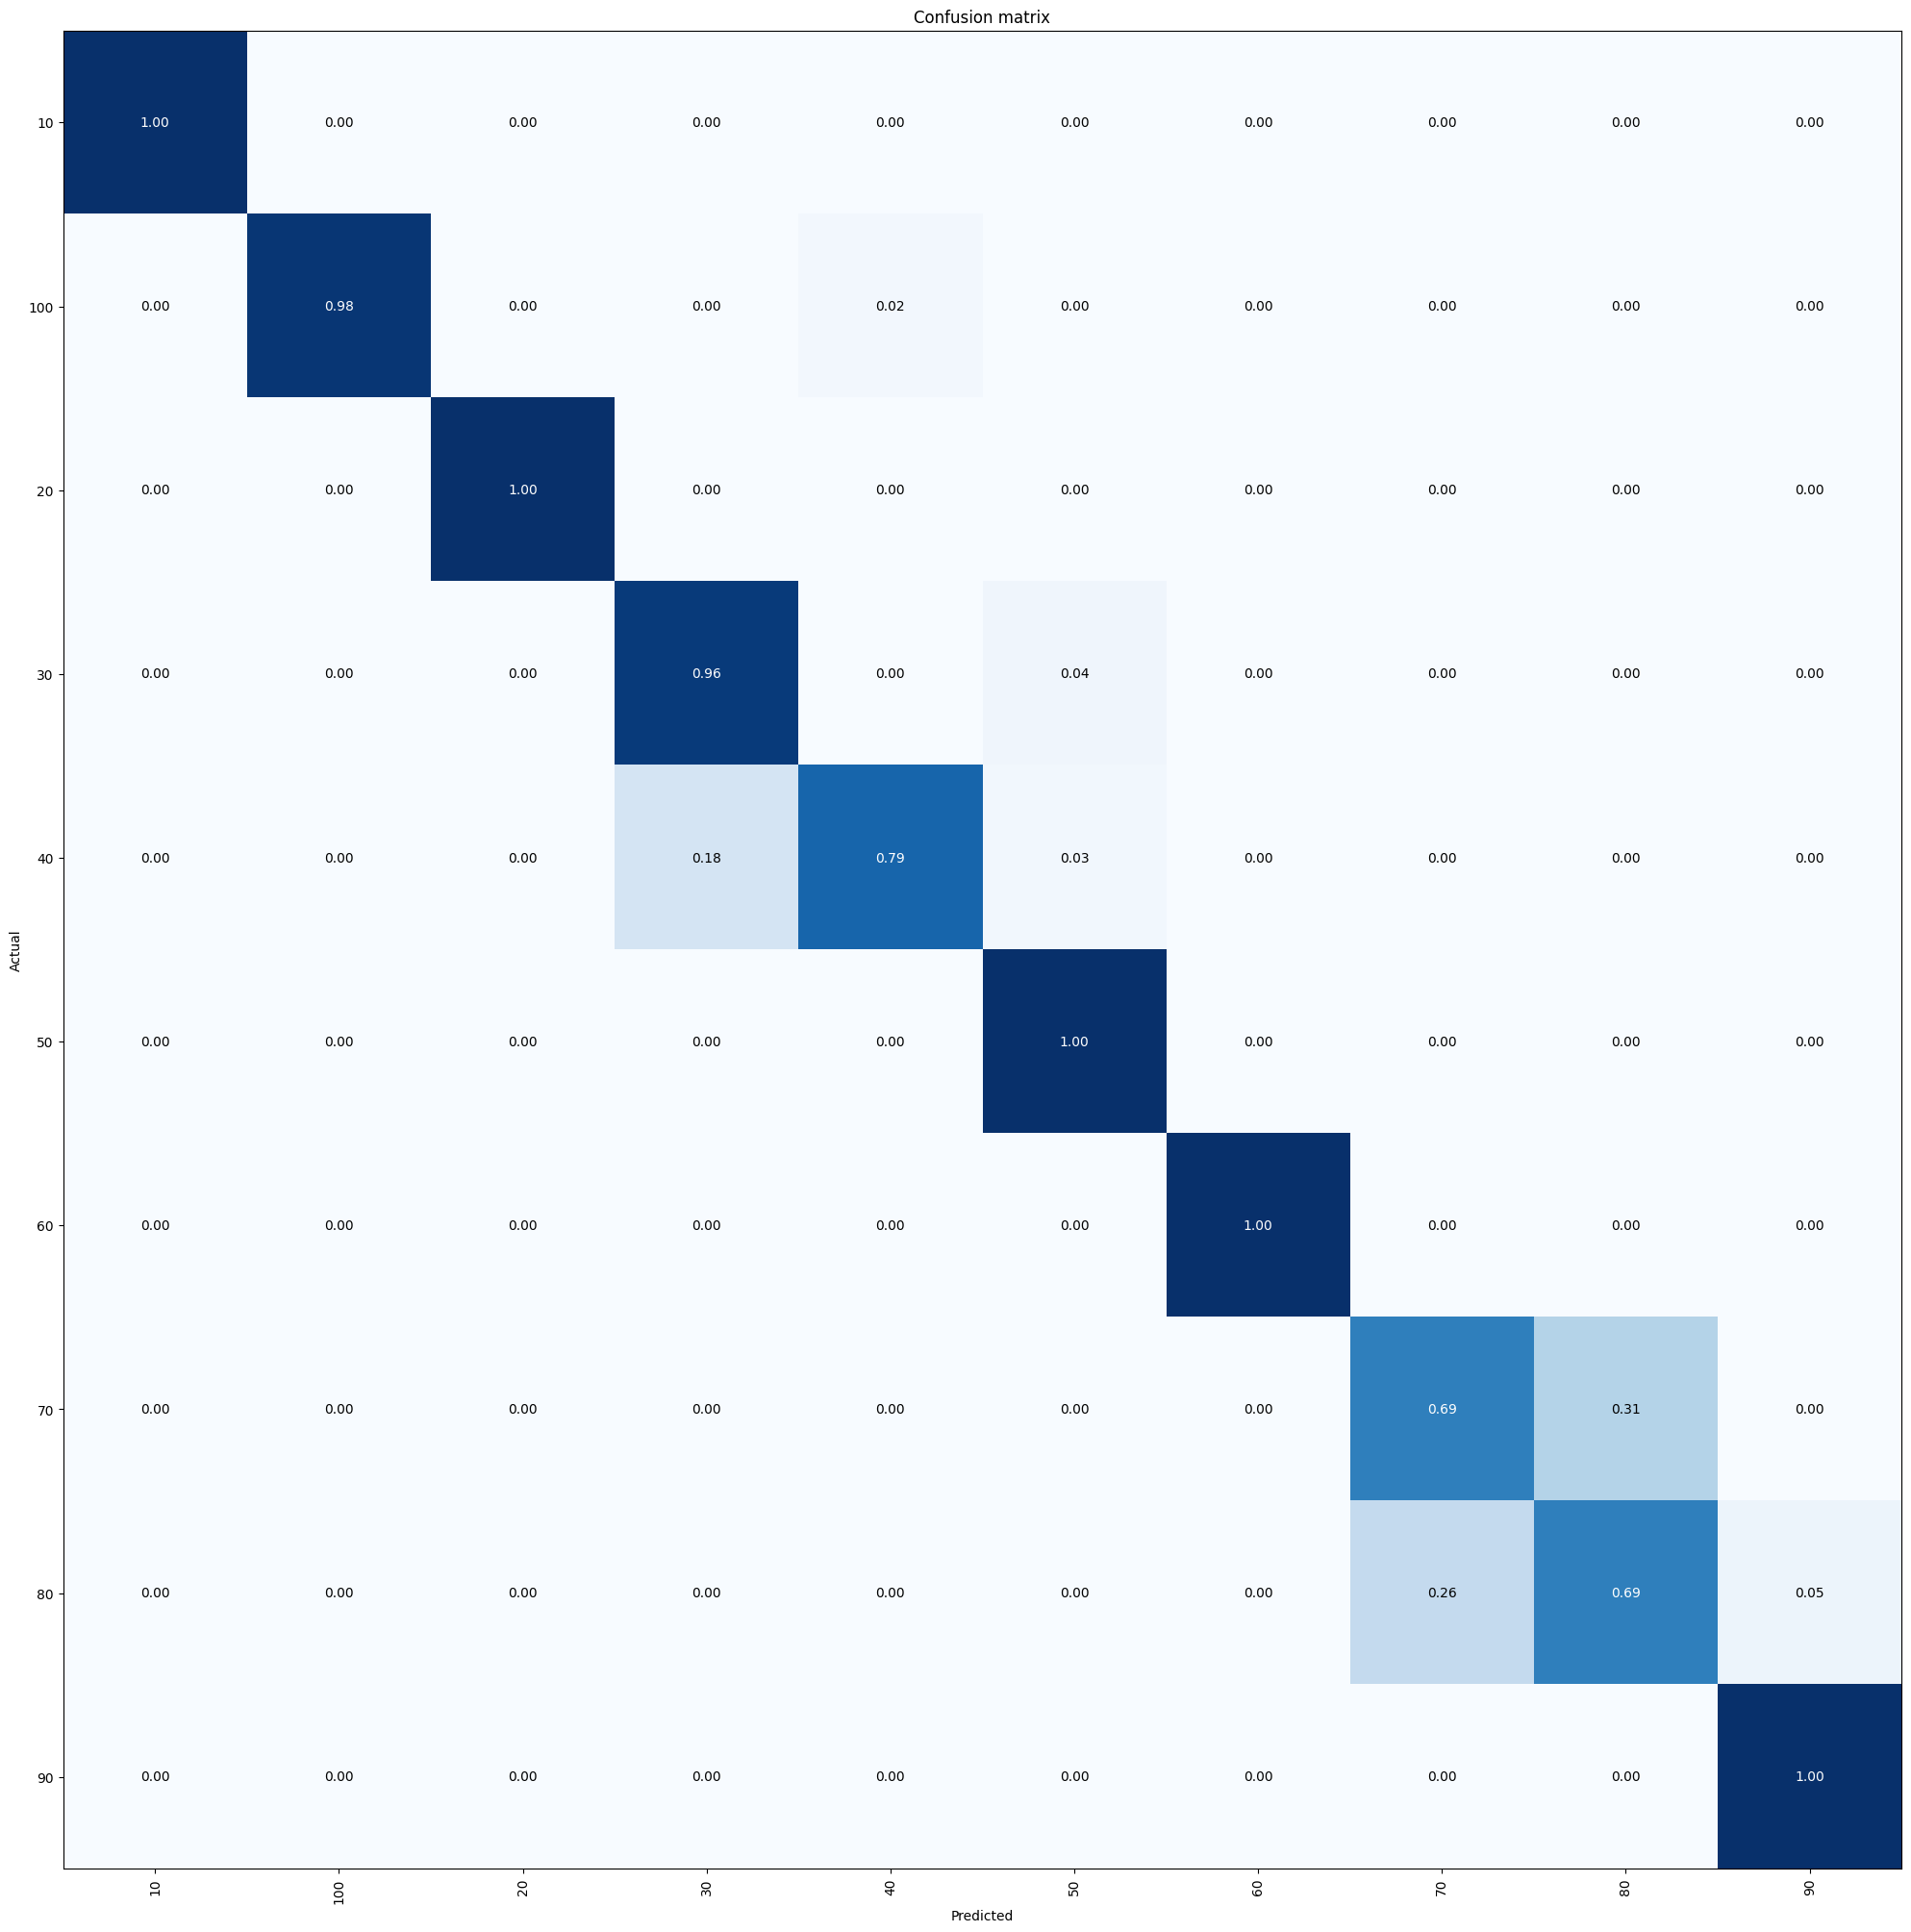

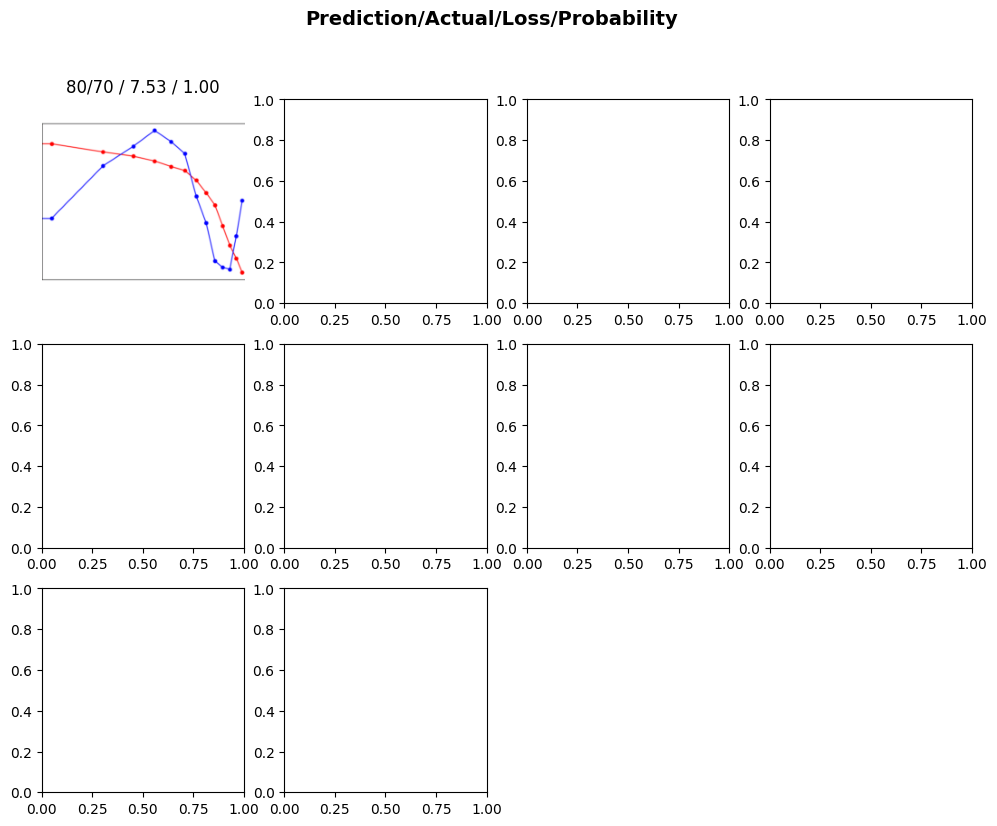

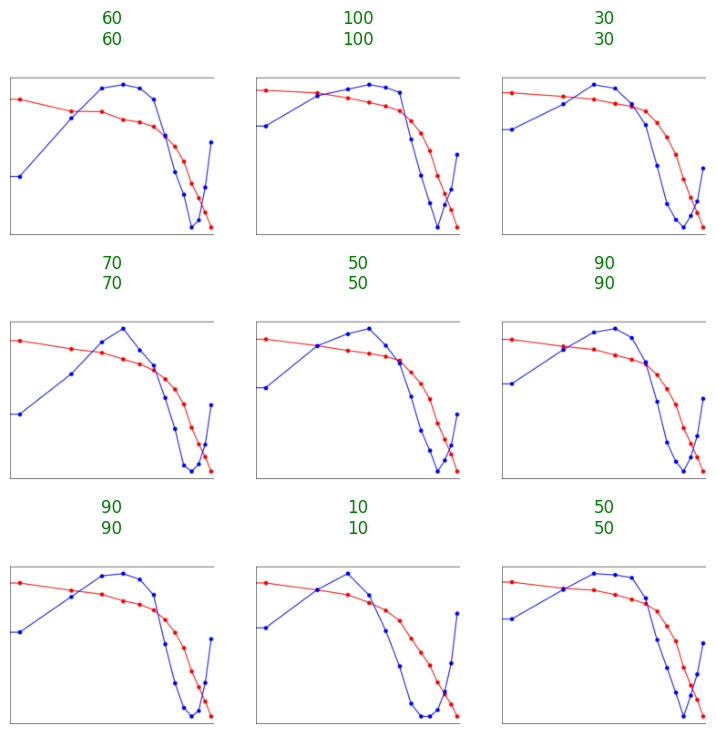

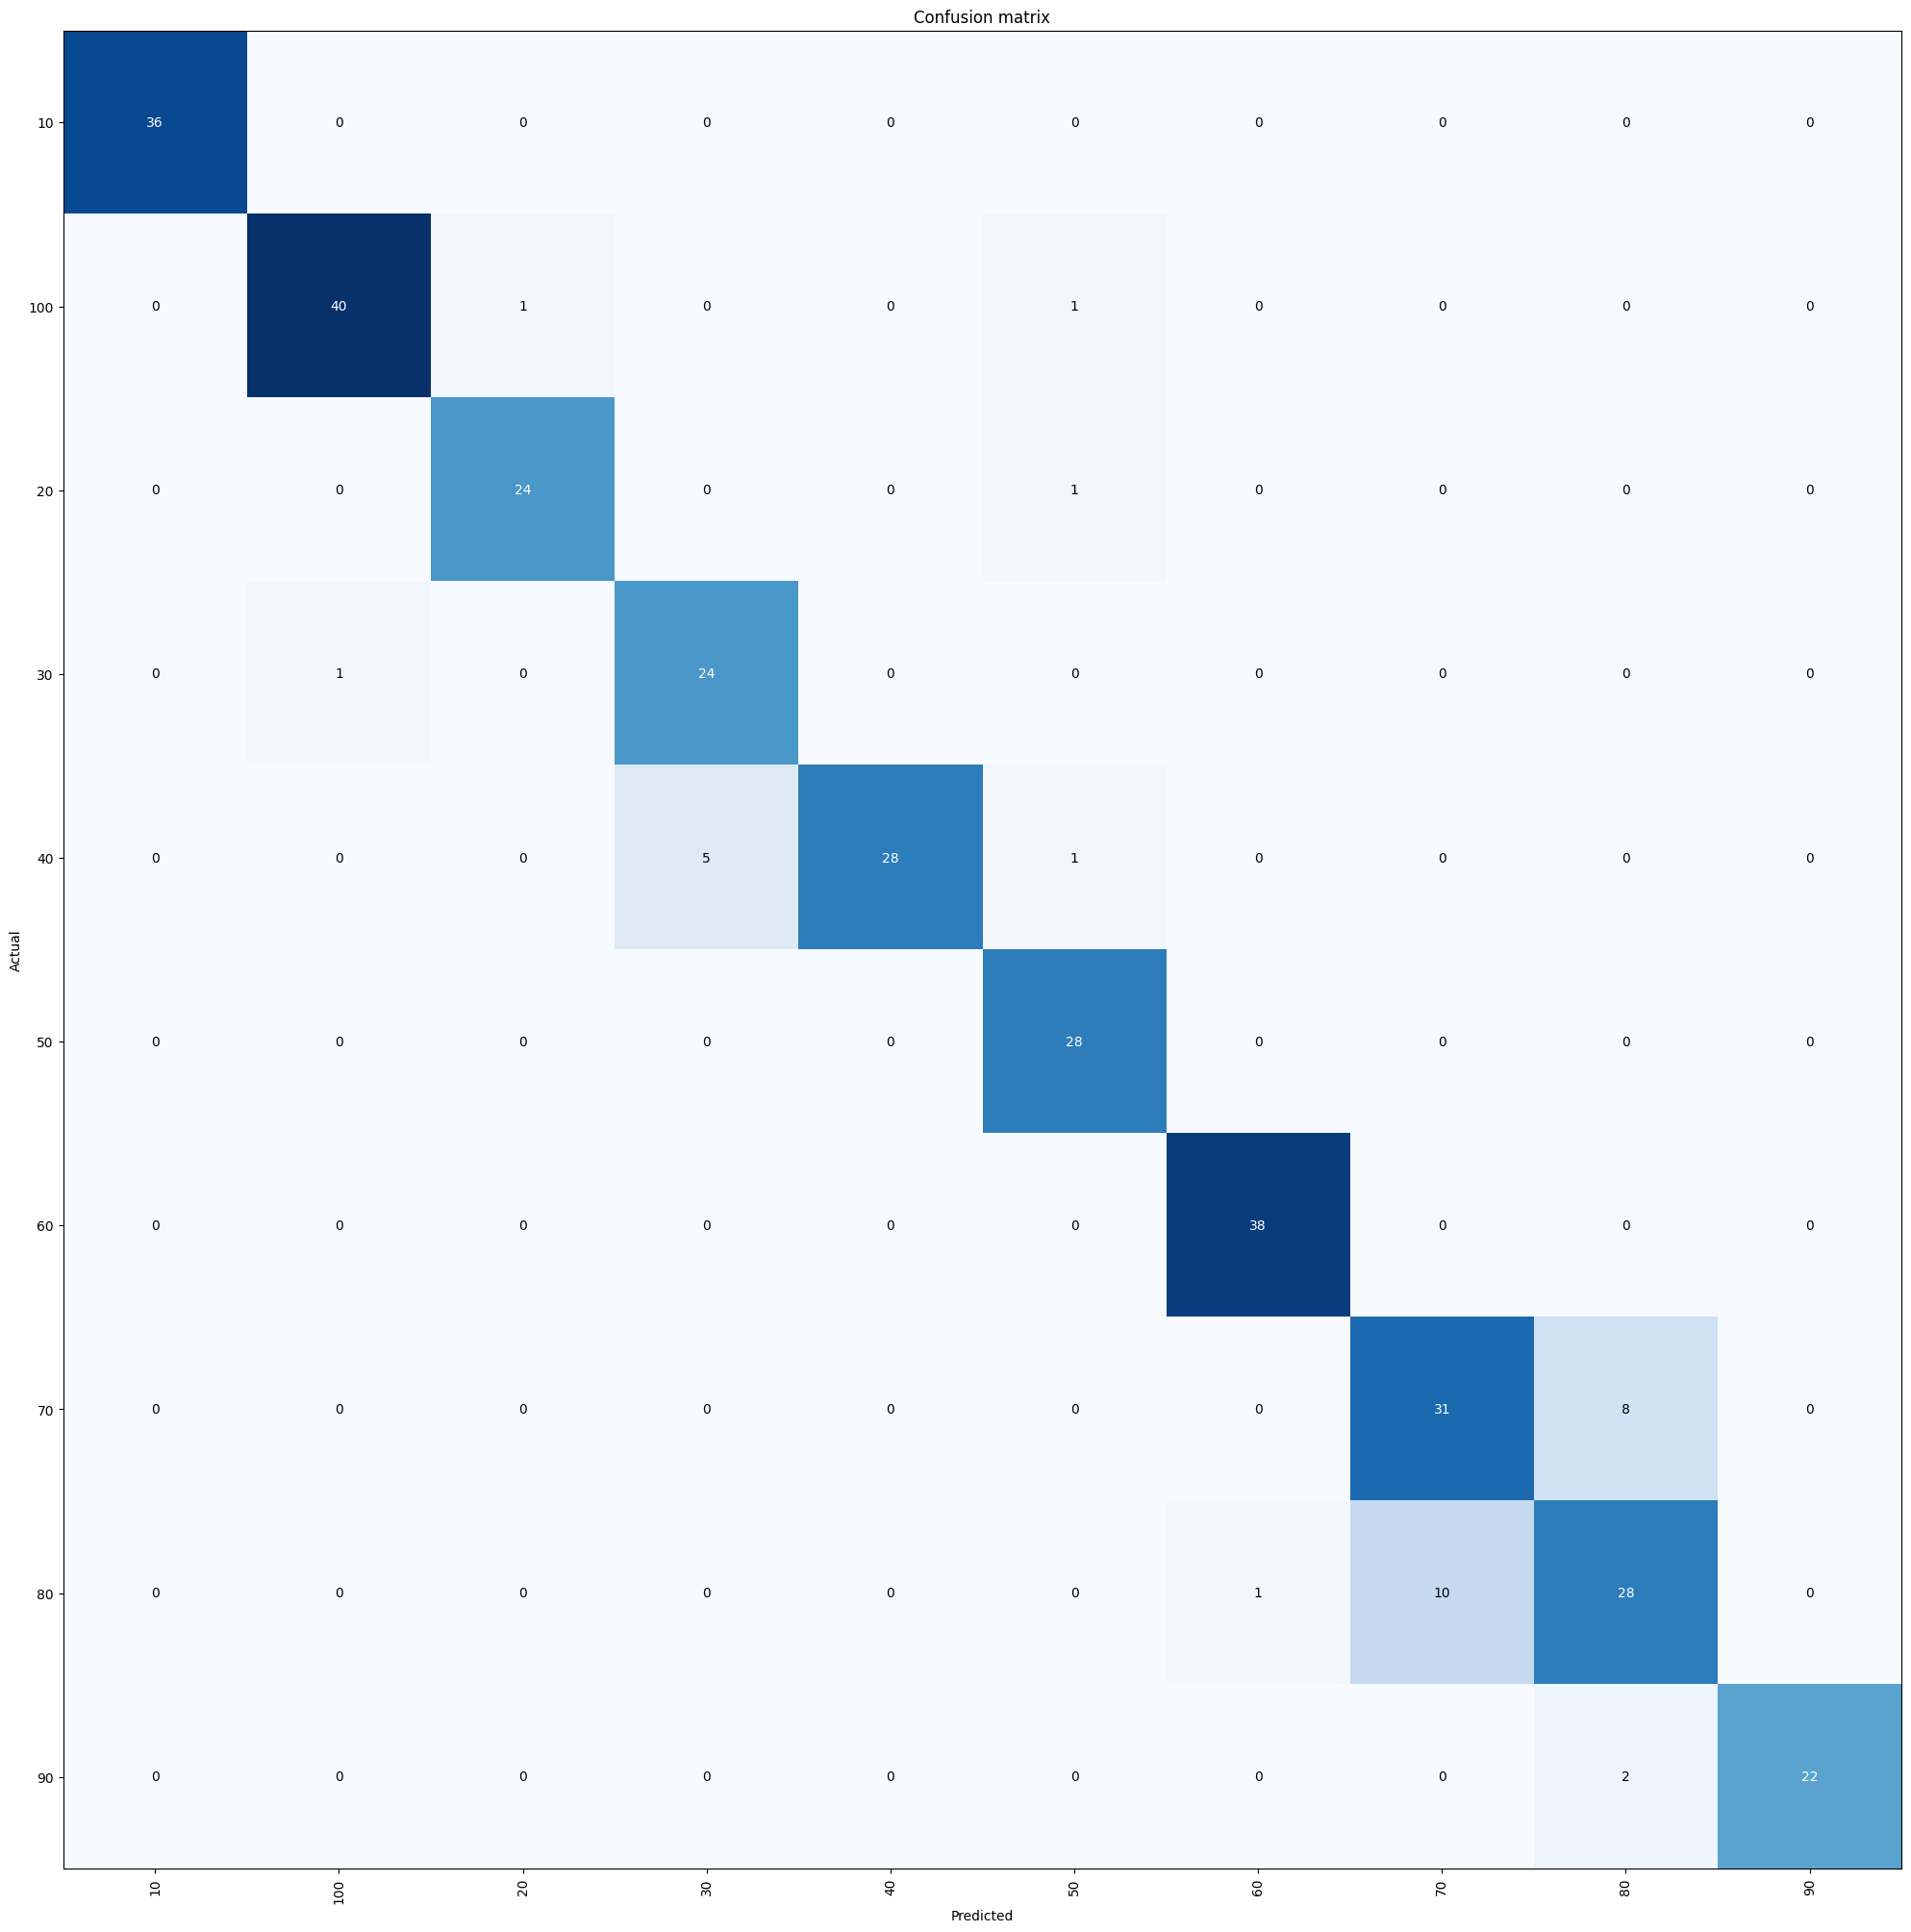

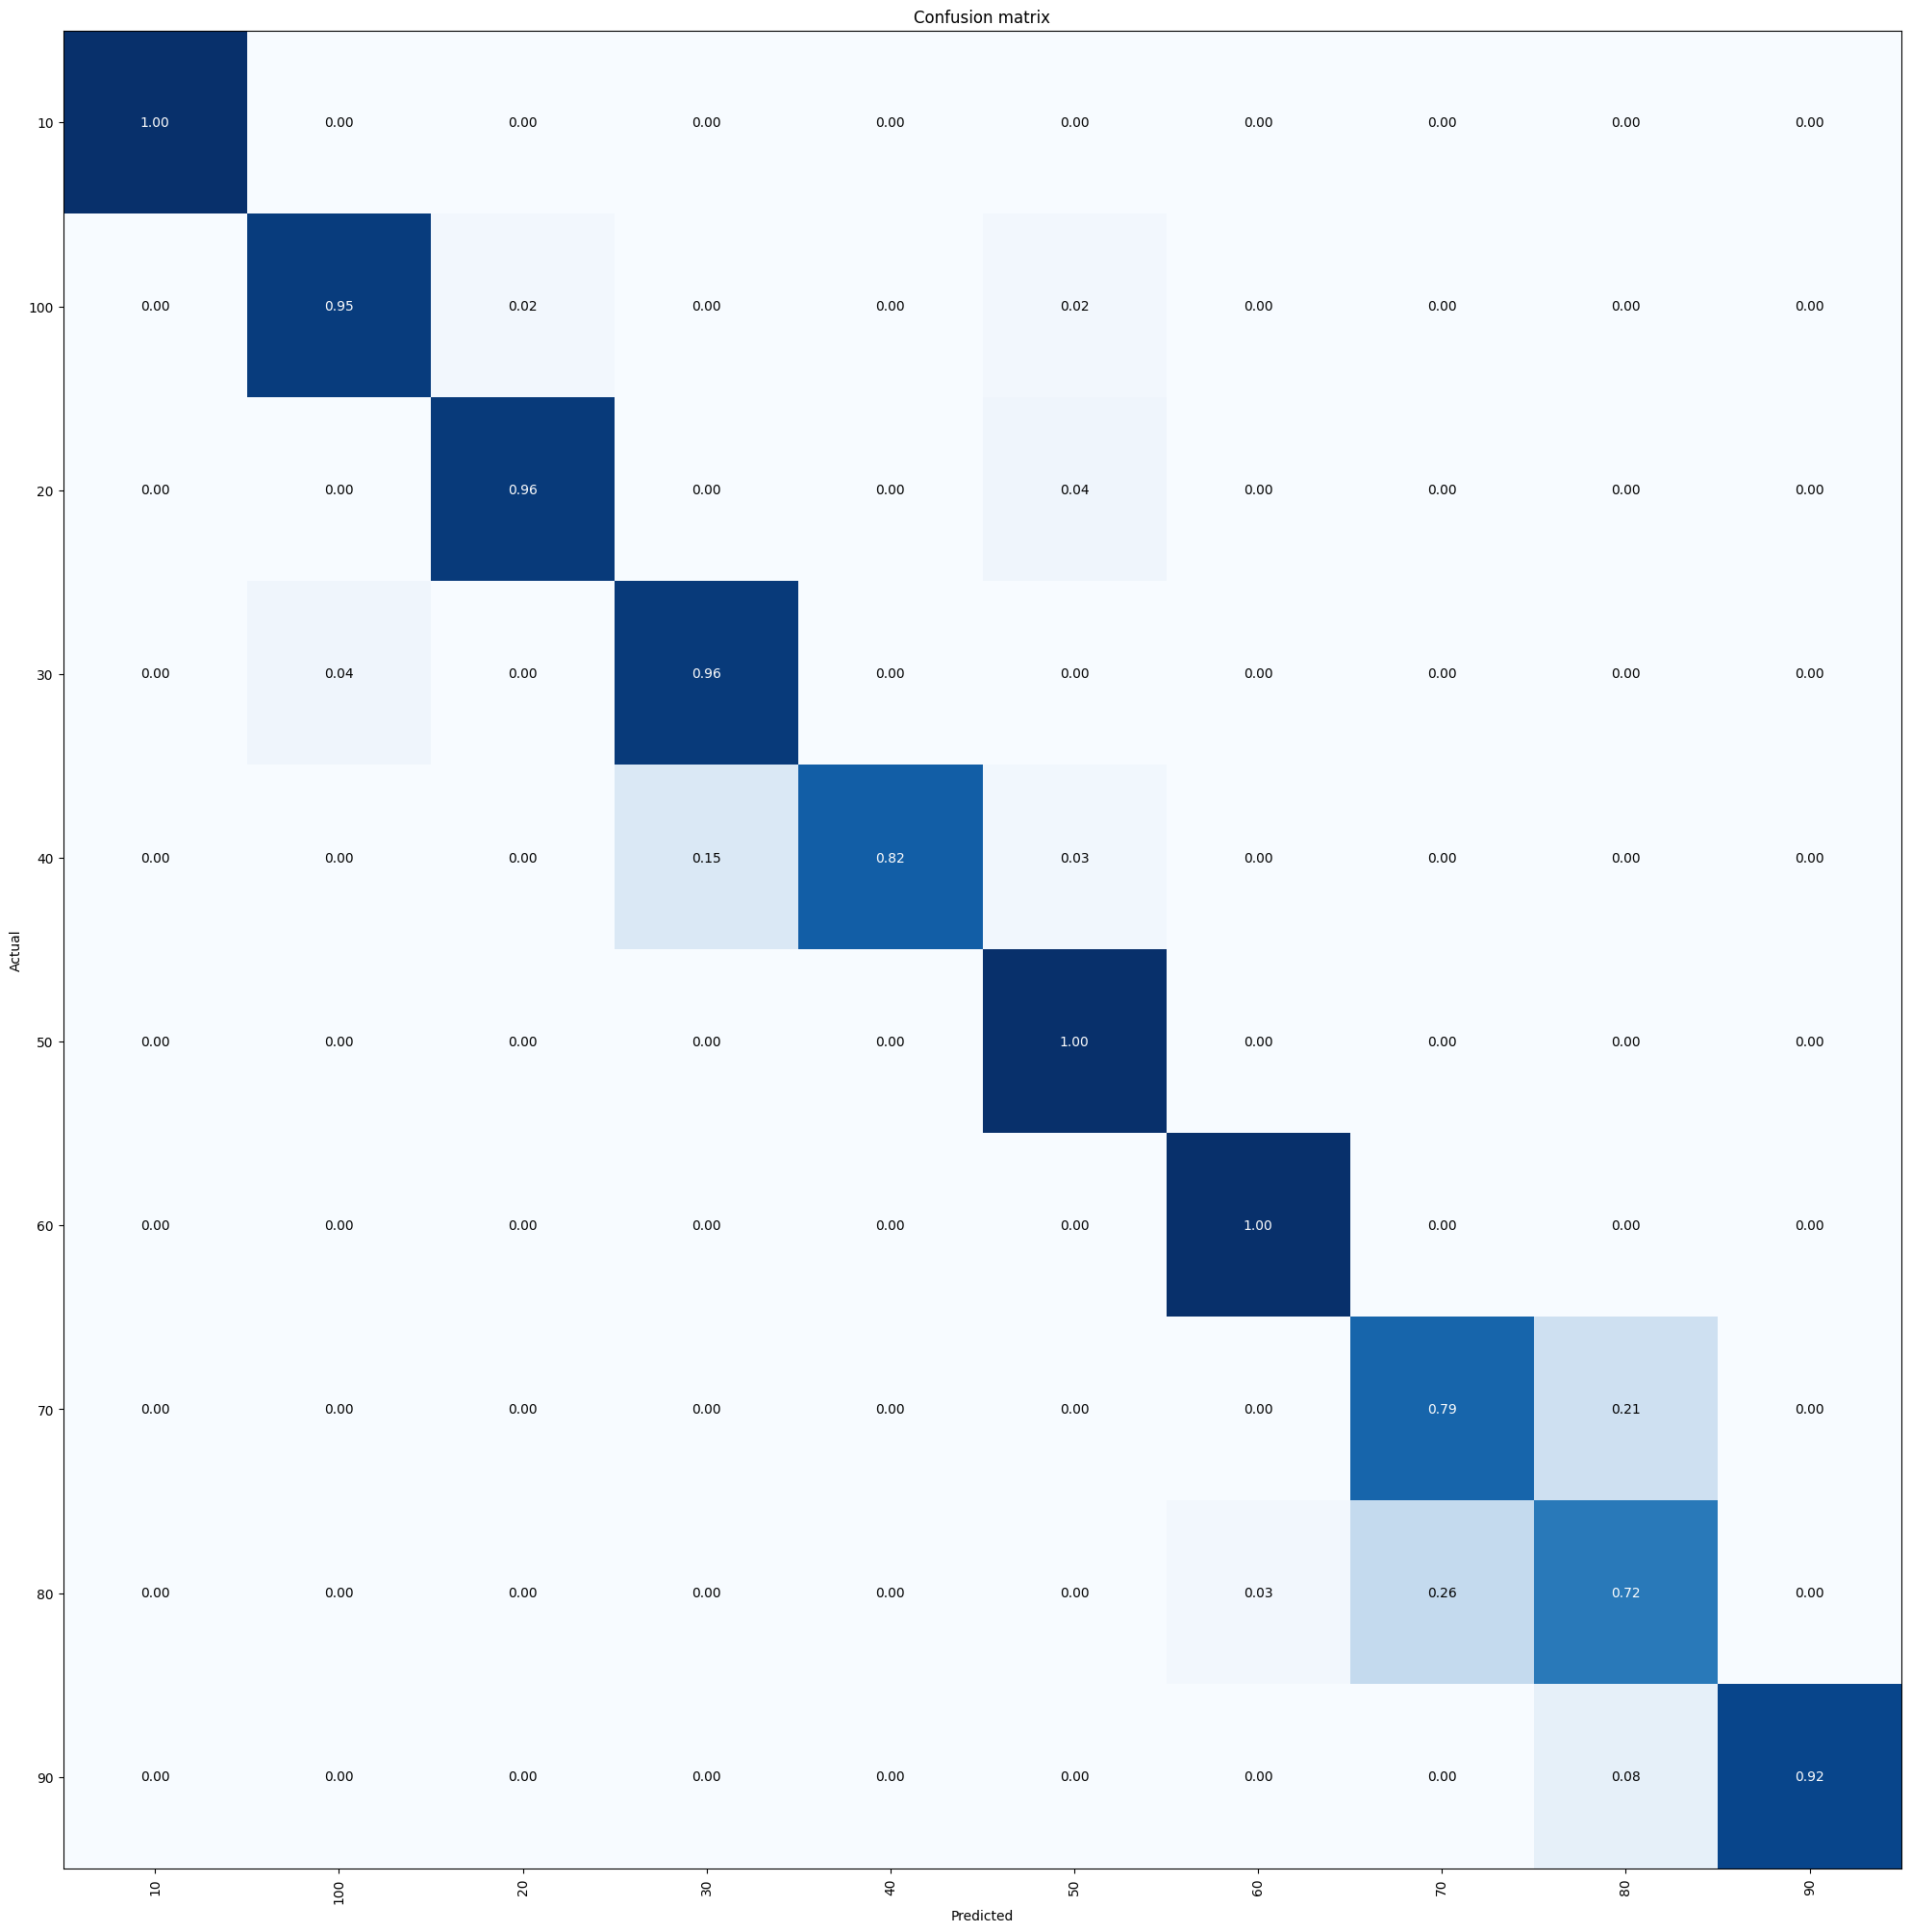

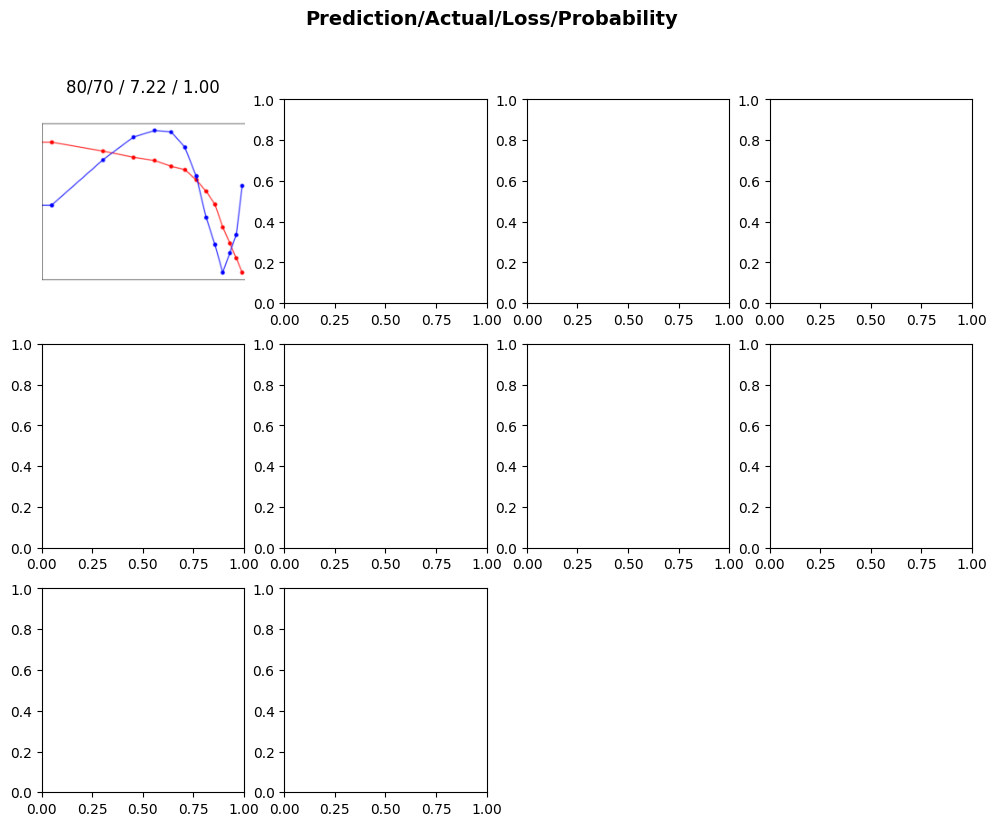

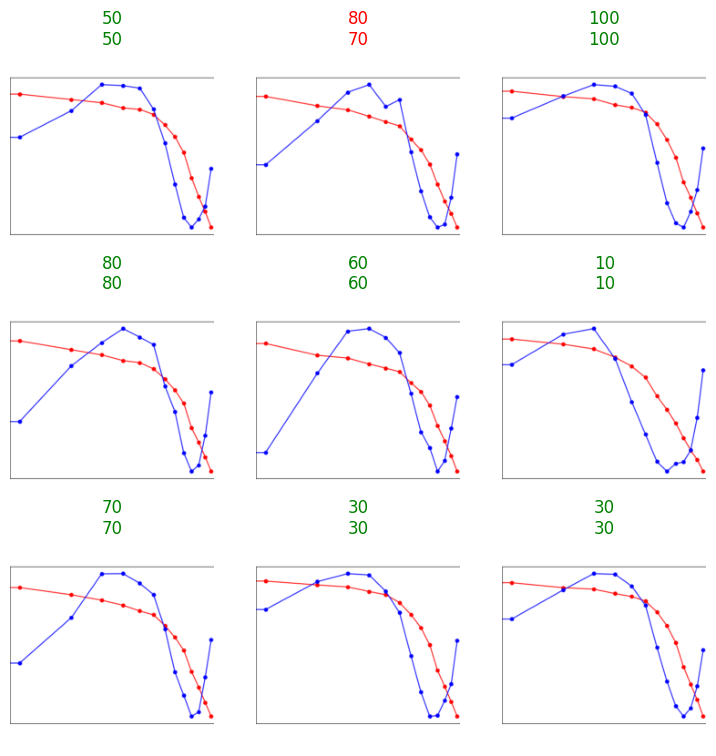

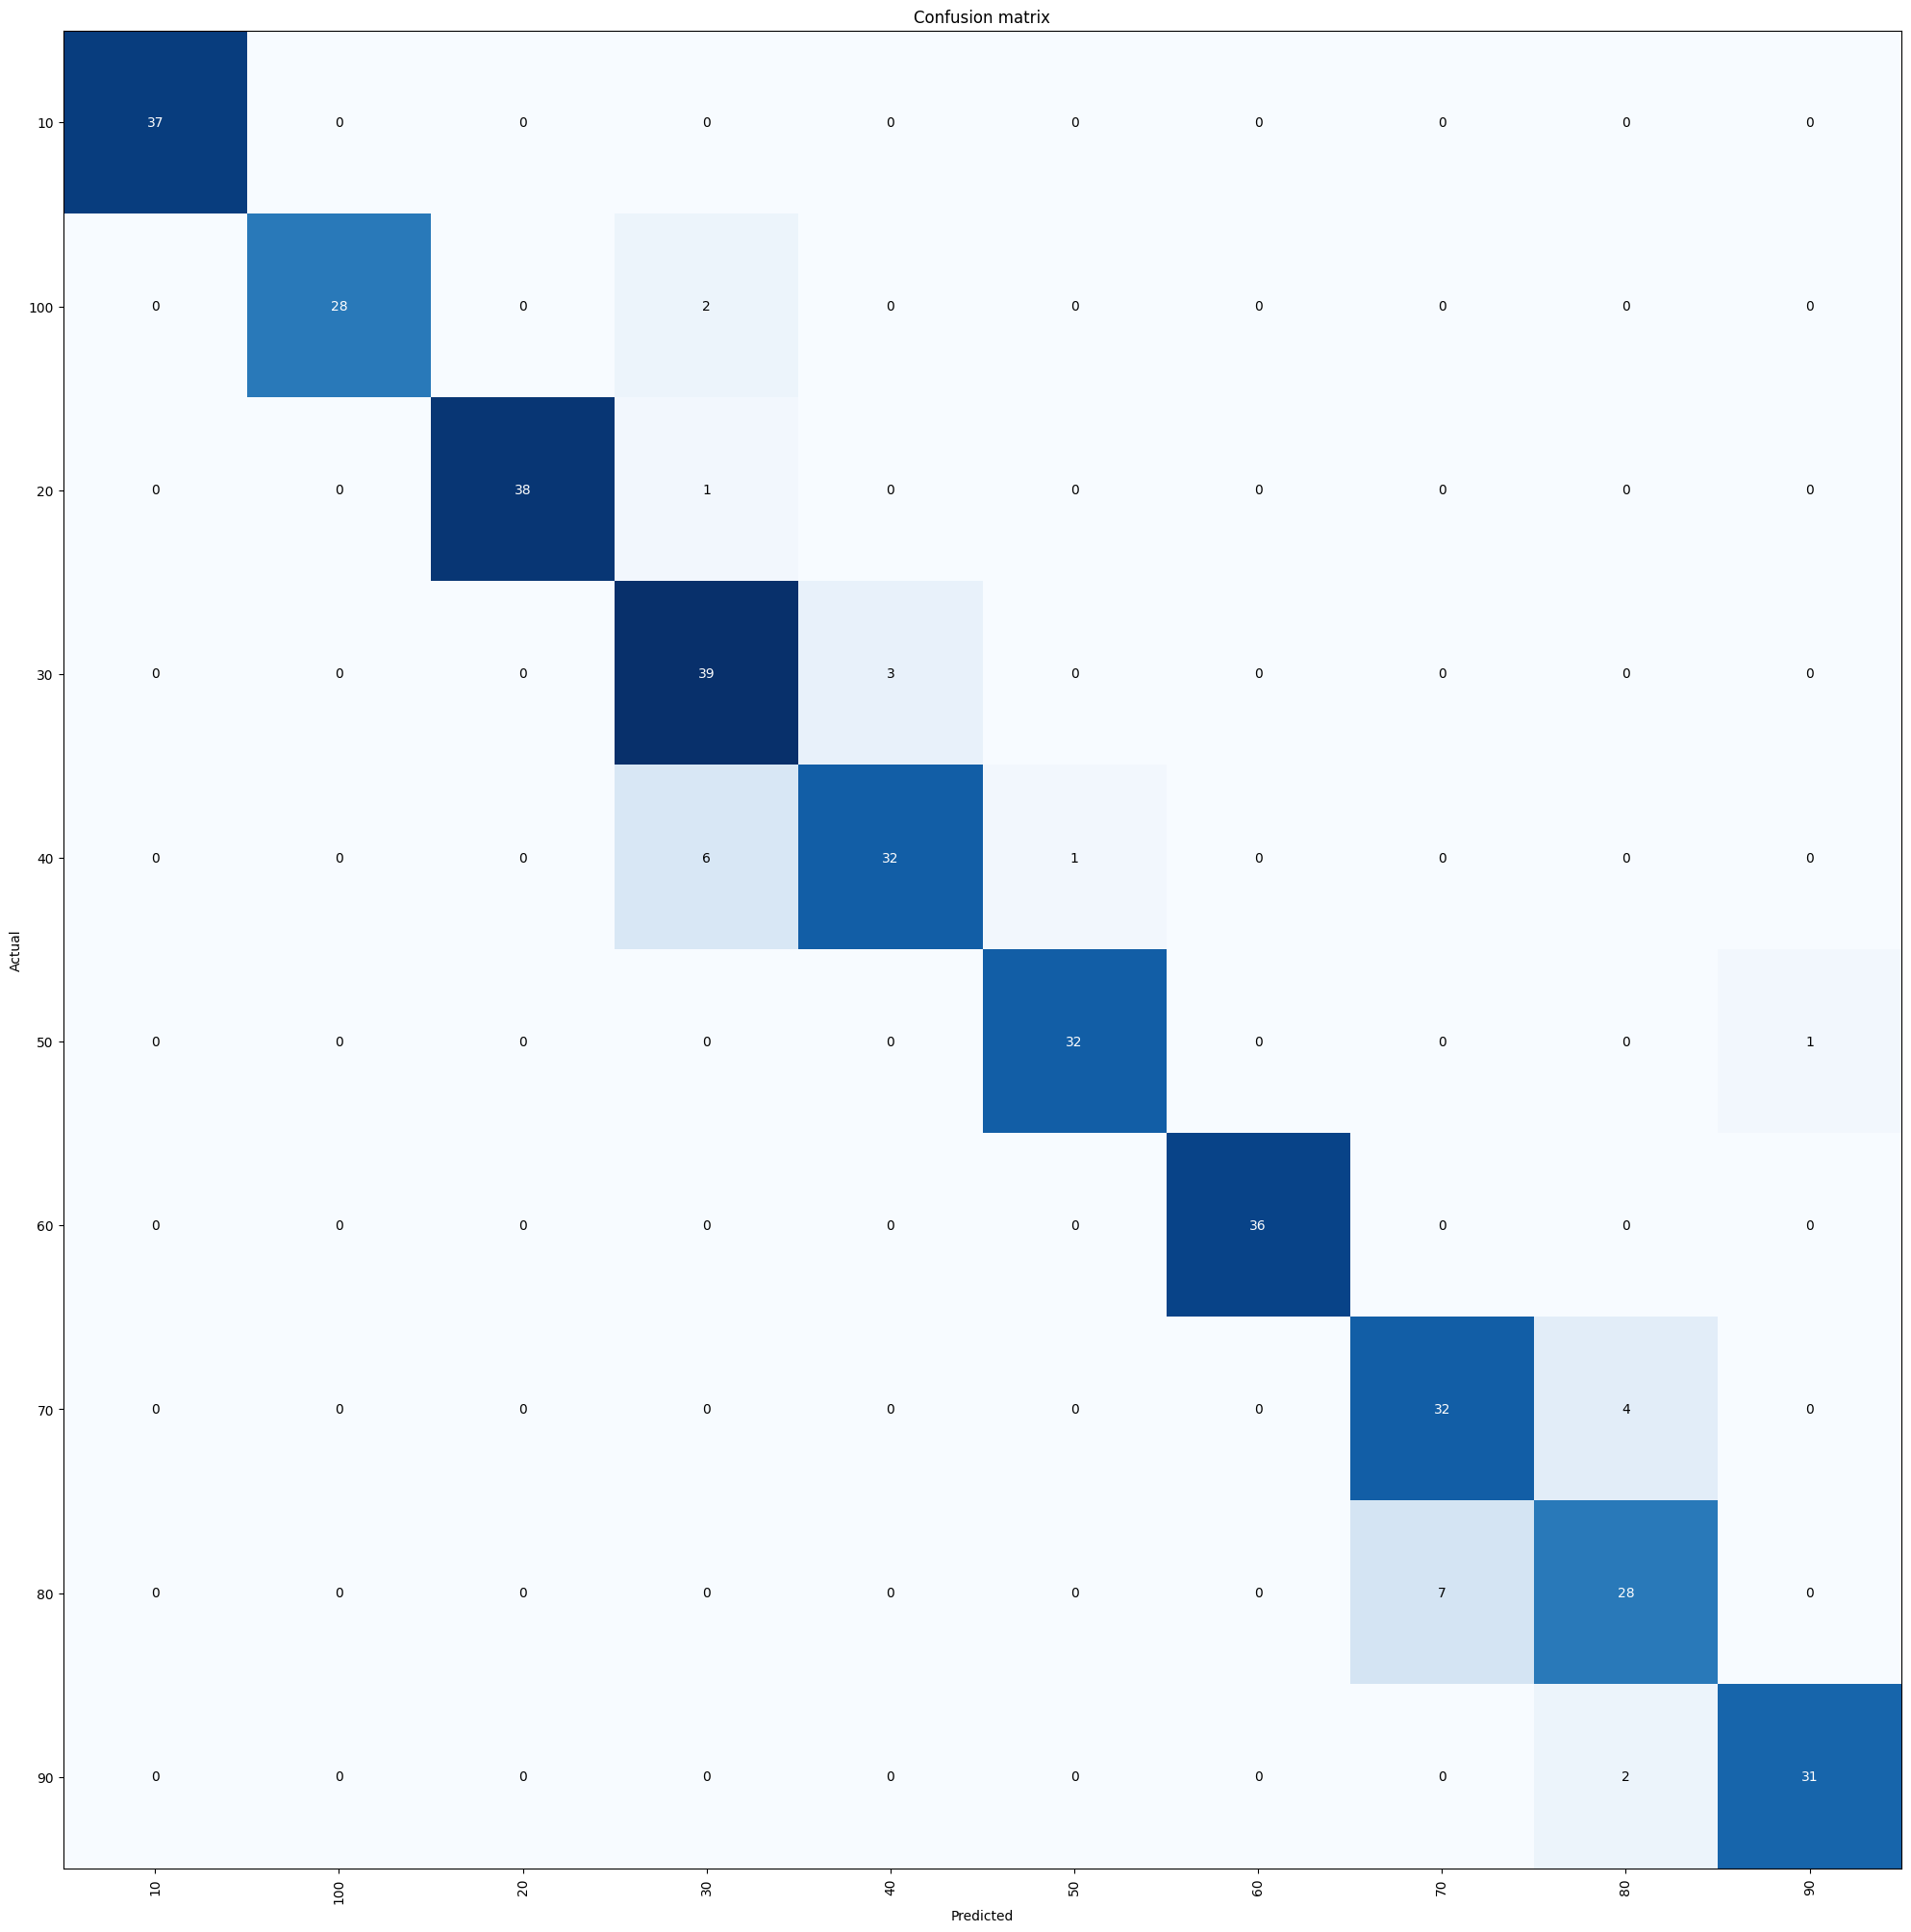

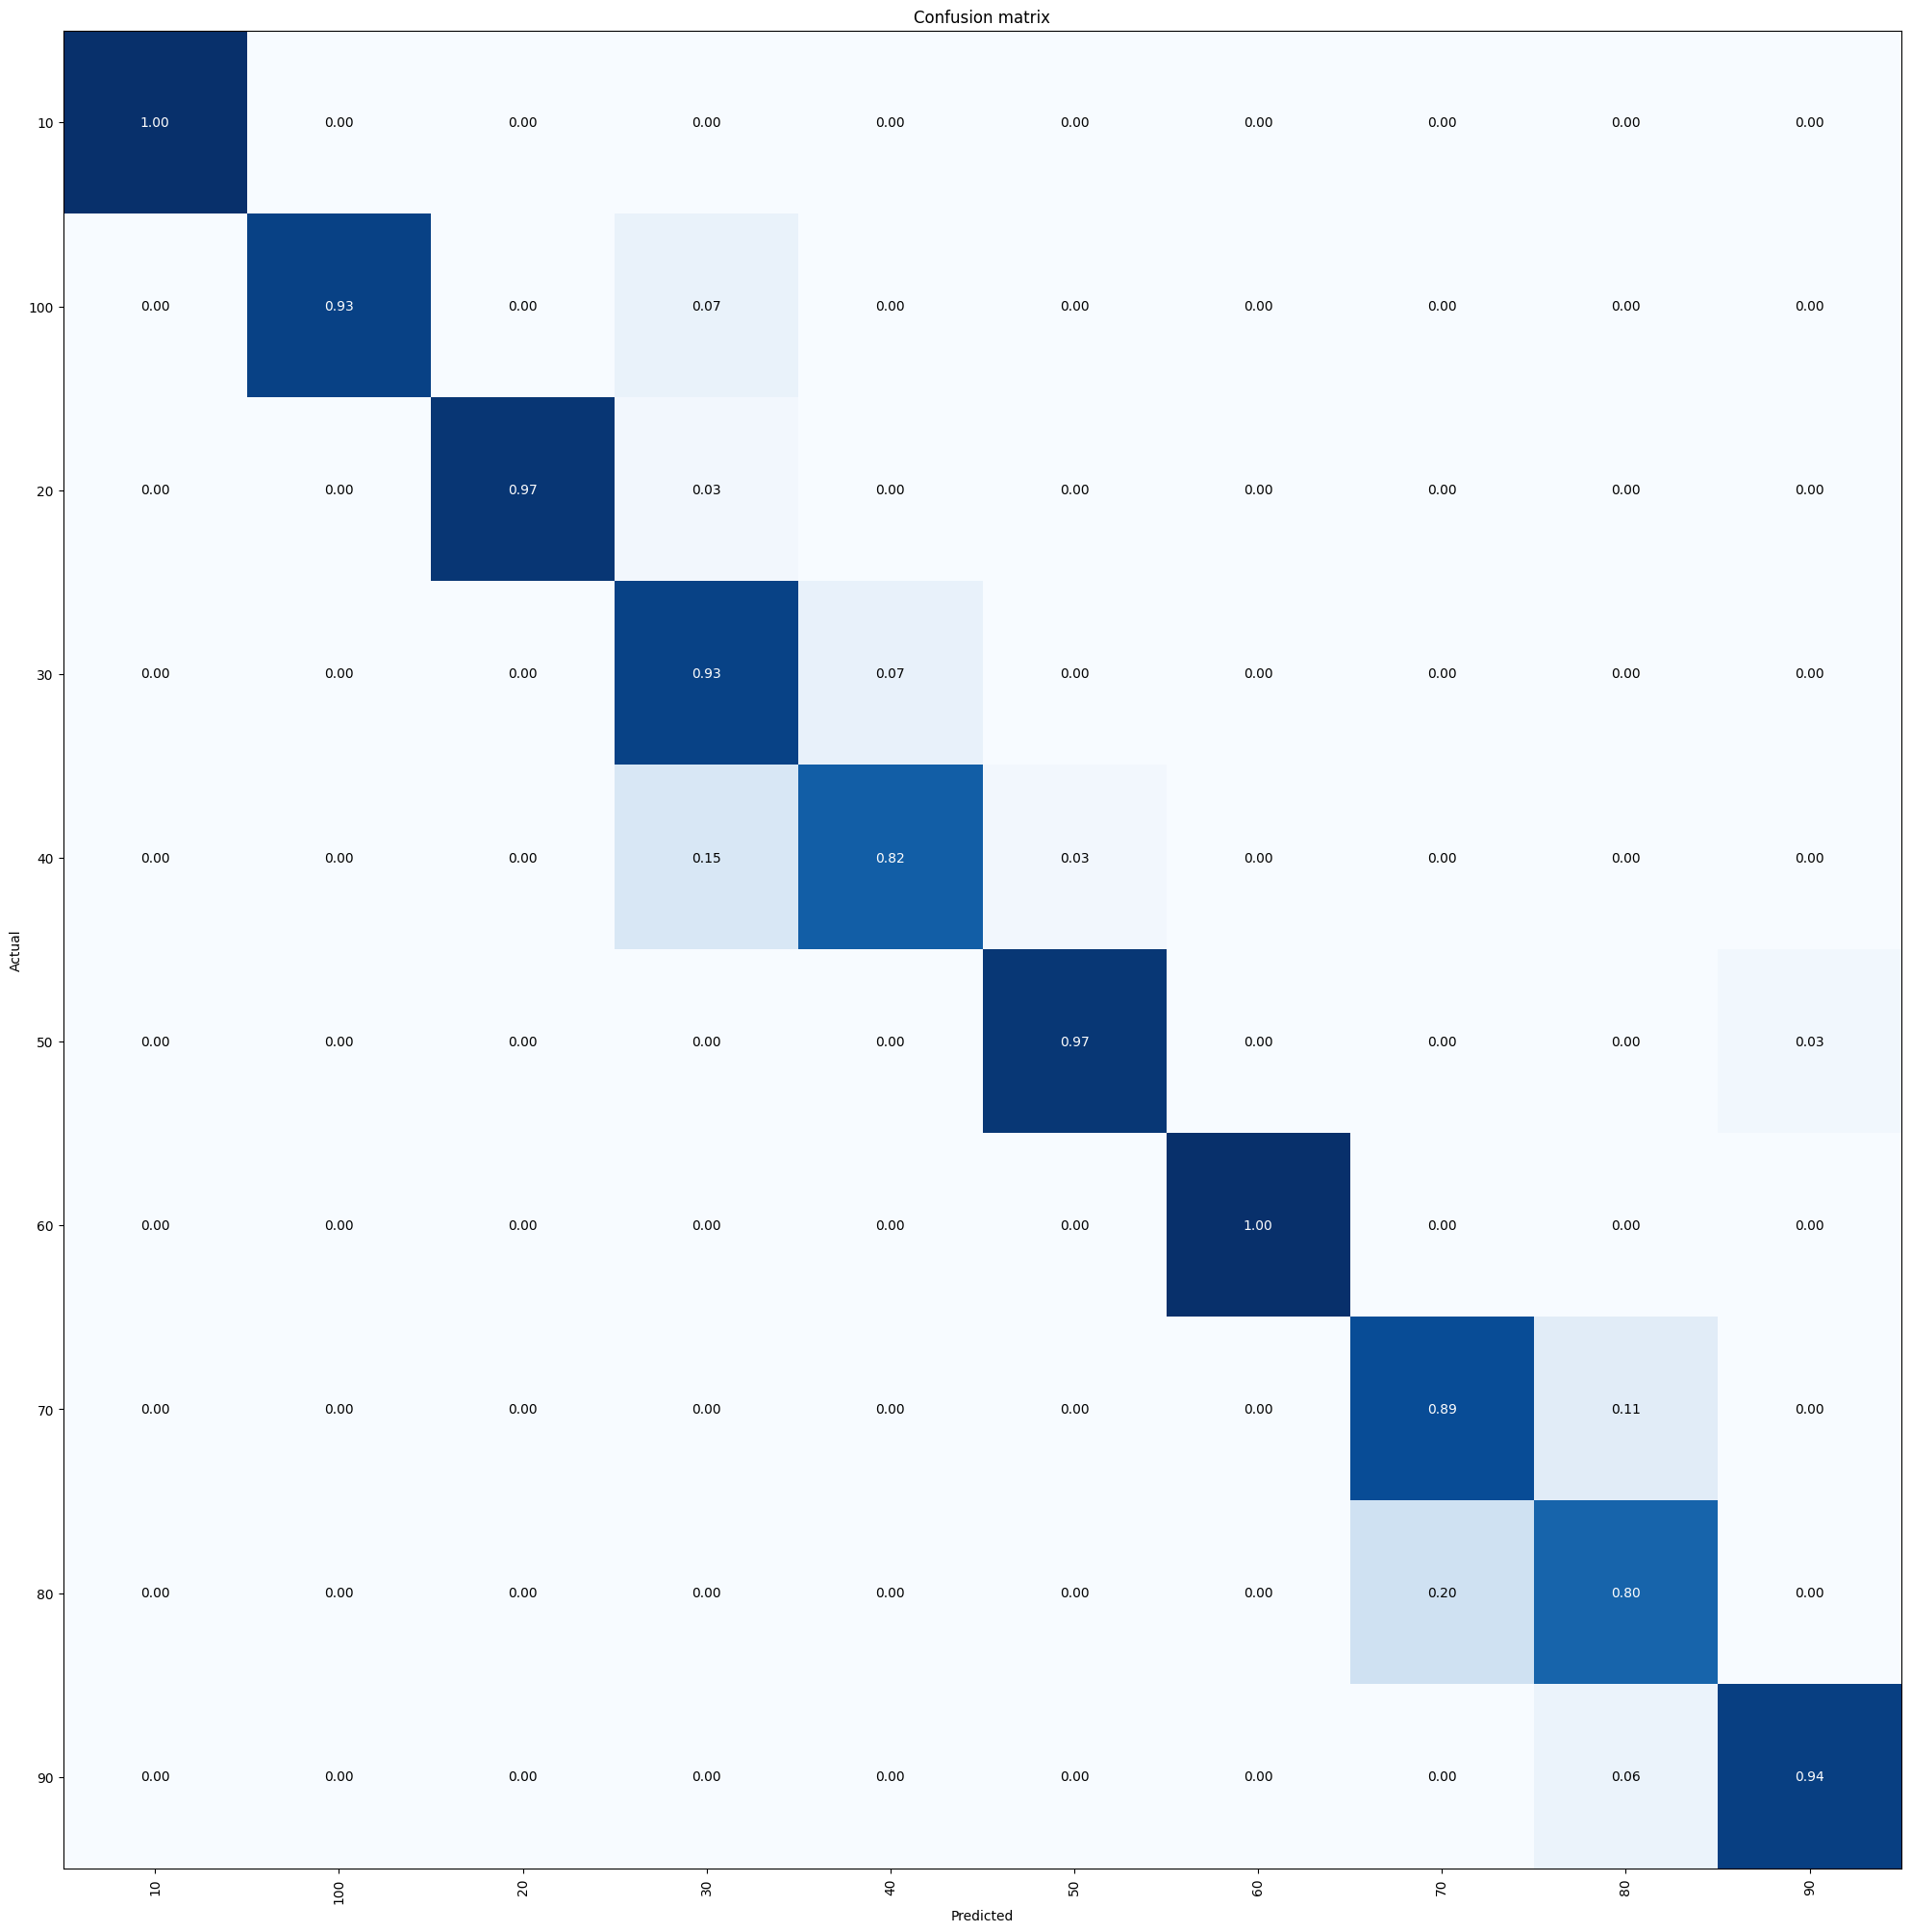

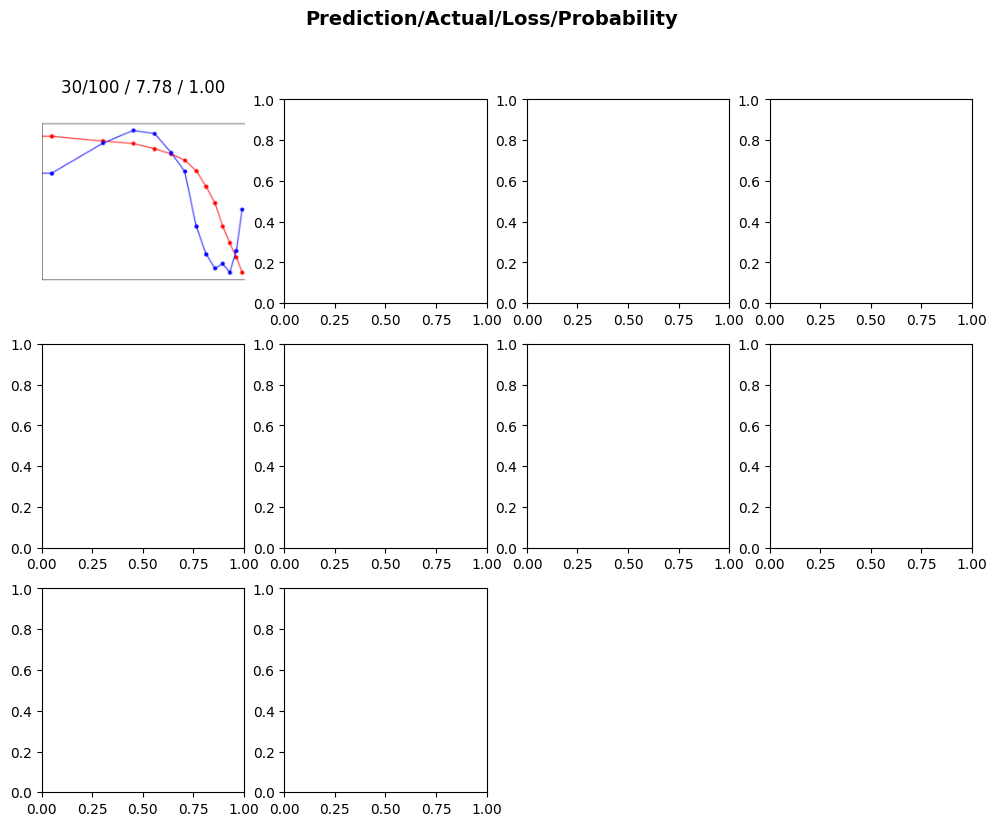

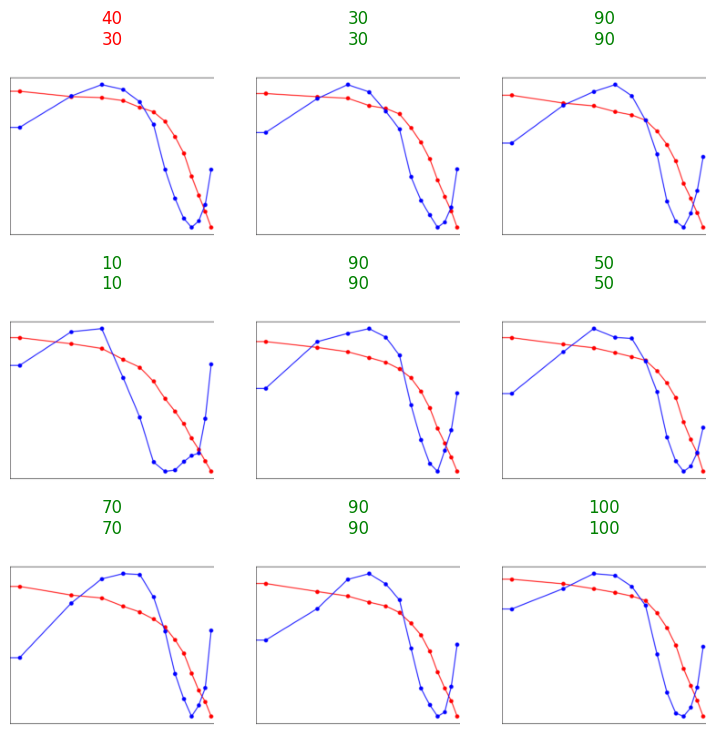

In [20]:
experiments_predictions,exeperiments_targets,experiments_predictions_decoded, models_accuracy,model_top2_accuracy= score_model_on_test_dataset(test_image_dataset_path,experiment_runs_list,saved_weights_files)   

# Calculate ensable prediction
ensamble_prediction = experiments_predictions[0]
for pred in experiments_predictions[1:]:
  ensamble_prediction += pred

ensamble_prediction /= len(experiments_predictions)
#ensamble_accuracy
accuracy(ensamble_prediction, exeperiments_targets[0])

In [ ]:
print("target: ")
print(targets)
print("predictions (decoded):")
print(decoded)
print("classification errors (class distance):")
print(targets-decoded)

# Single Model - Training/Validation split

Modello addestrato con tutti i dati tranne batteria 5_8 e batteria 6

### Score Sigle Model - Bode

Setting-up type transforms pipelines
Found 1700 items
2 datasets of sizes 1190,510
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      ../data/images/Paper_MES_v2_single__Exp_0/Paper_MES_v2_single__Exp_0-03_4006_80.png
    applying PILBase.create gives
      PILImage mode=RGB size=640x480
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../data/images/Paper_MES_v2_single__Exp_0/Paper_MES_v2_single__Exp_0-03_4006_80.png
    applying RegexLabeller gives
      80
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(8)

Final sample: (PILImage mode=RGB size=640x480, TensorCategory(8))


Found 1700 items
2 datasets of sizes 1190,510
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab'

[[48  0  0  0  0  0  0  0  0  0]
 [ 0 49  2  3  1  0  0  0  0  0]
 [ 0  0 57  0  0  0  0  0  0  0]
 [ 0  1  0 35  5  1  0  0  0  0]
 [ 0  0  0 16 32  1  0  0  0  0]
 [ 0  0  1  1  1 50  0  0  0  1]
 [ 0  0  0  0  0  0 51  2  0  0]
 [ 0  0  0  0  0  0  0 45  7  1]
 [ 0  0  0  0  0  0  0 11 41  1]
 [ 0  0  0  0  0  0  0  0  3 43]]
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.89090909 0.03636364 0.05454545 0.01818182 0.
  0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.02380952 0.         0.83333333 0.11904762 0.02380952
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.32653061 0.65306122 0.02040816
  0.         0.         0.         0.        ]
 [0.         0.         0.01851852 0.01851852 0.01851852 0.92592593
  0.         0.         0.         0.01851852]
 [0

learn.validate()


Model accuracy: 0.88
learn.get_preds()


TensorBase(0.8843)

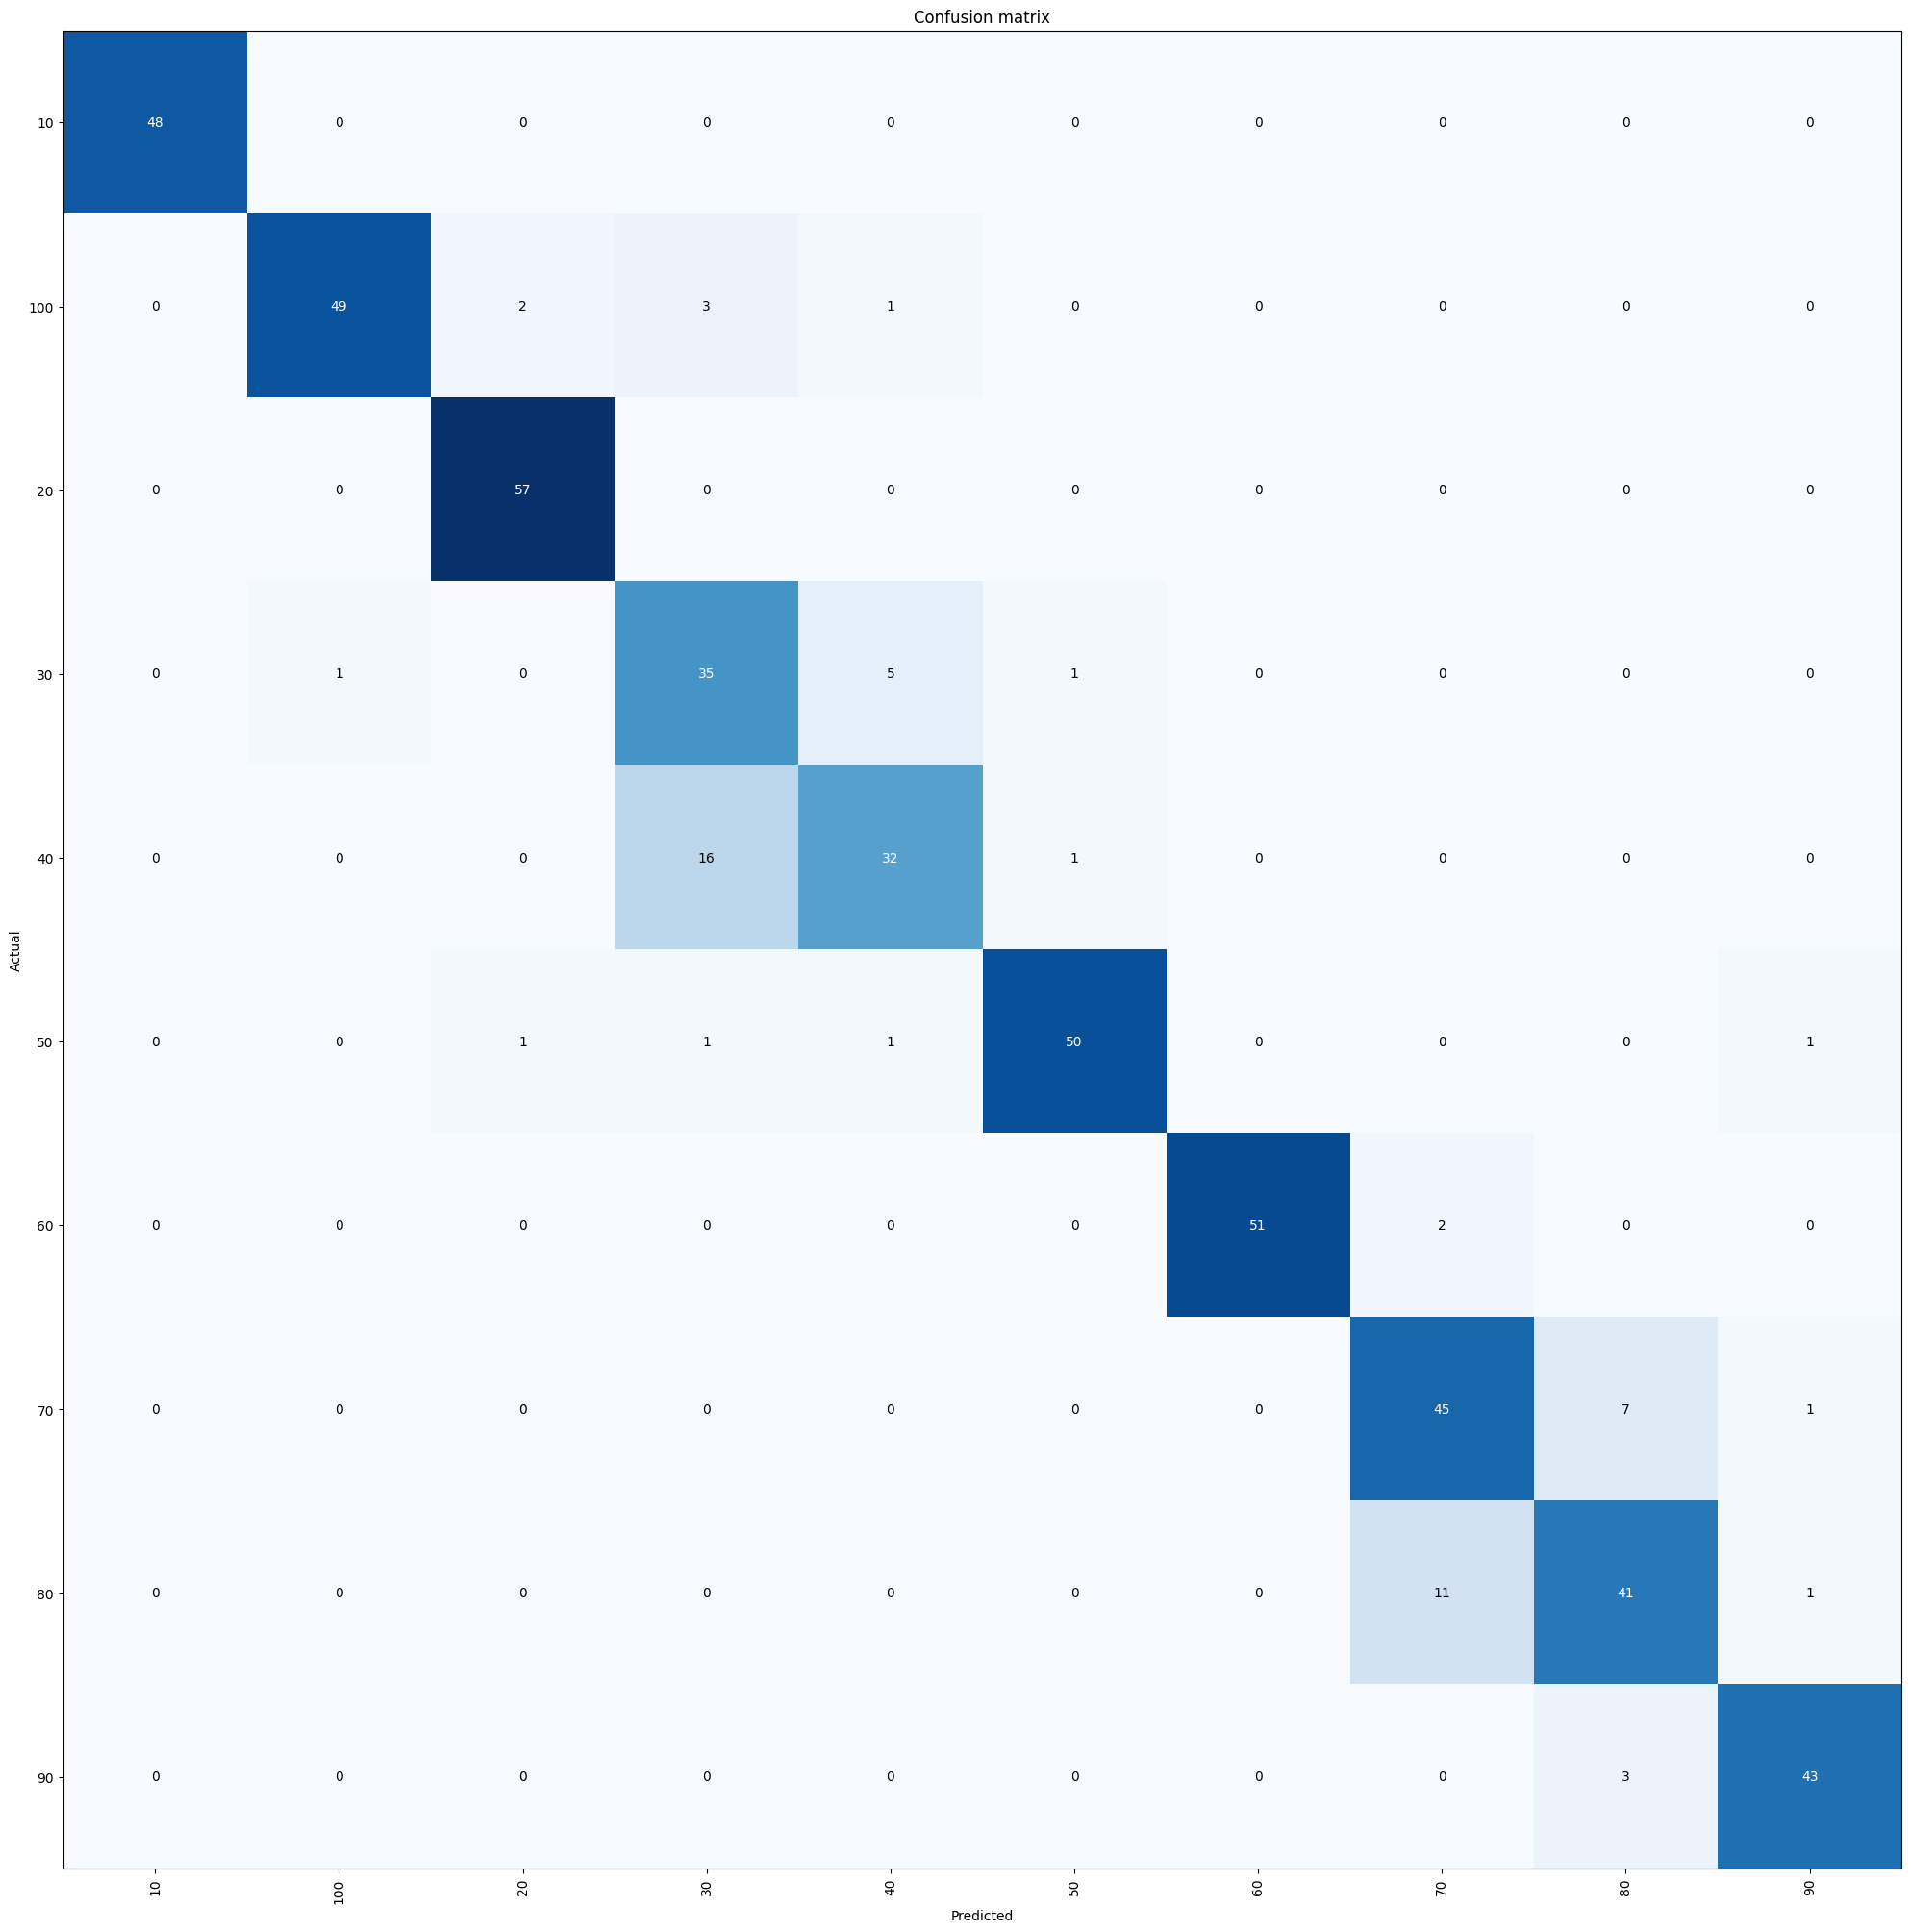

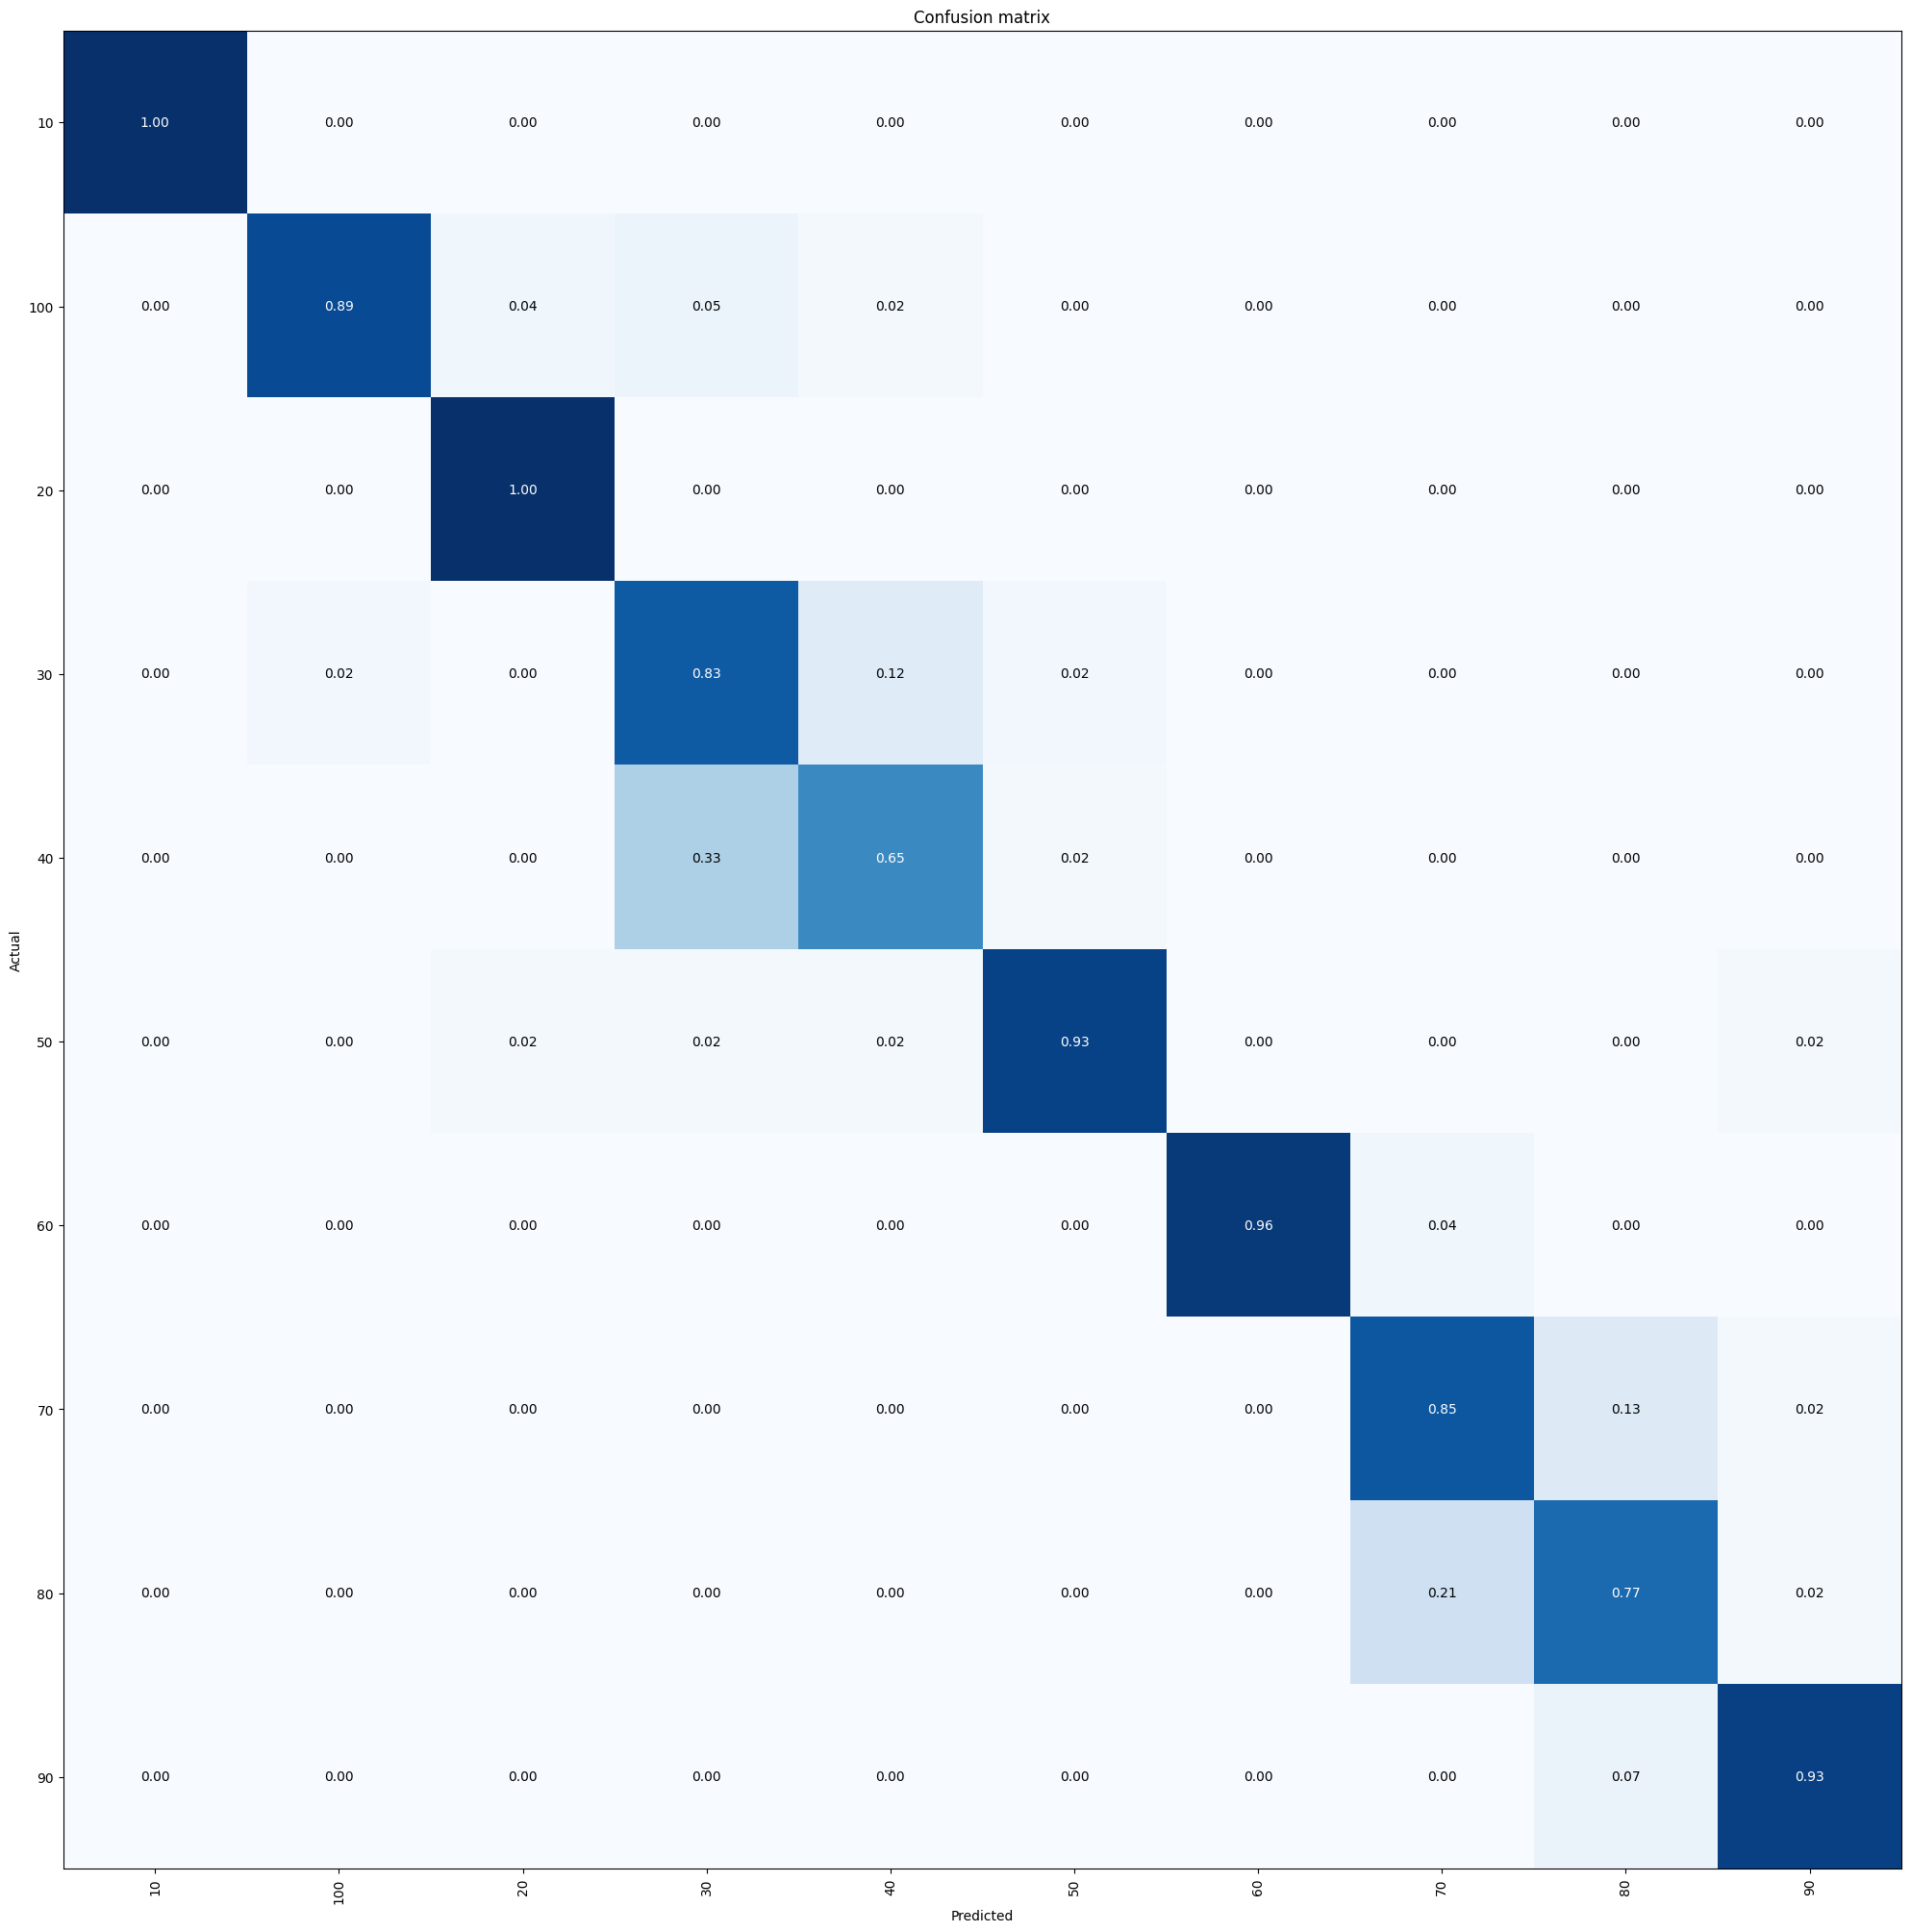

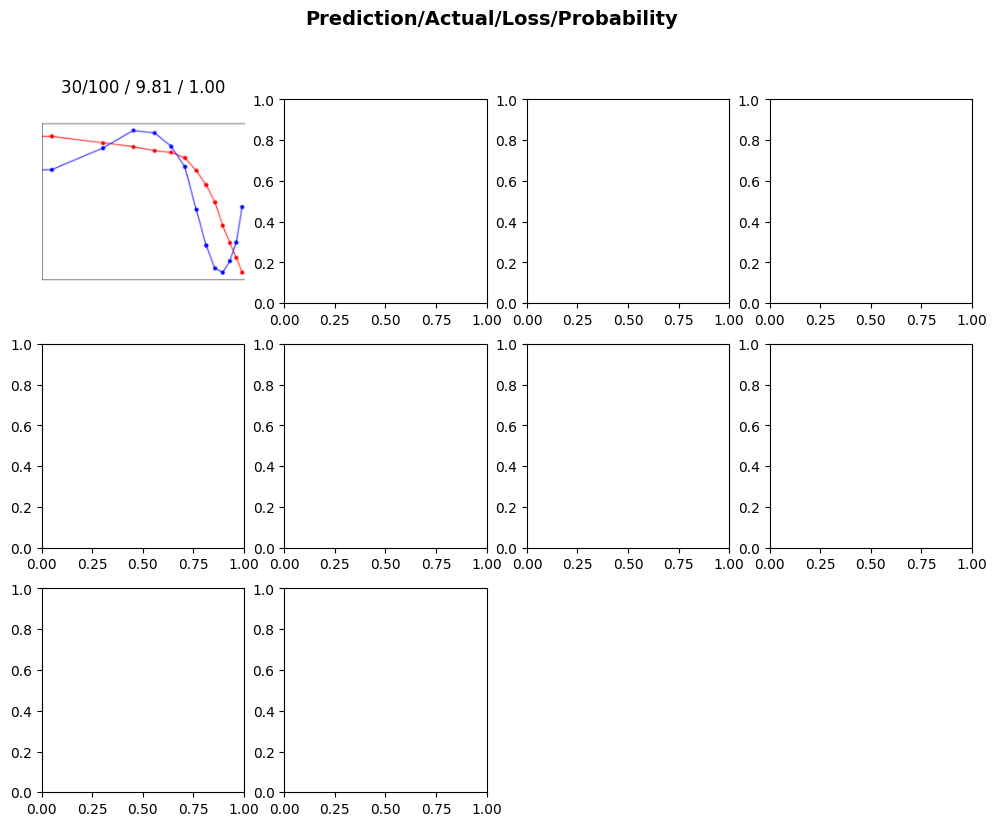

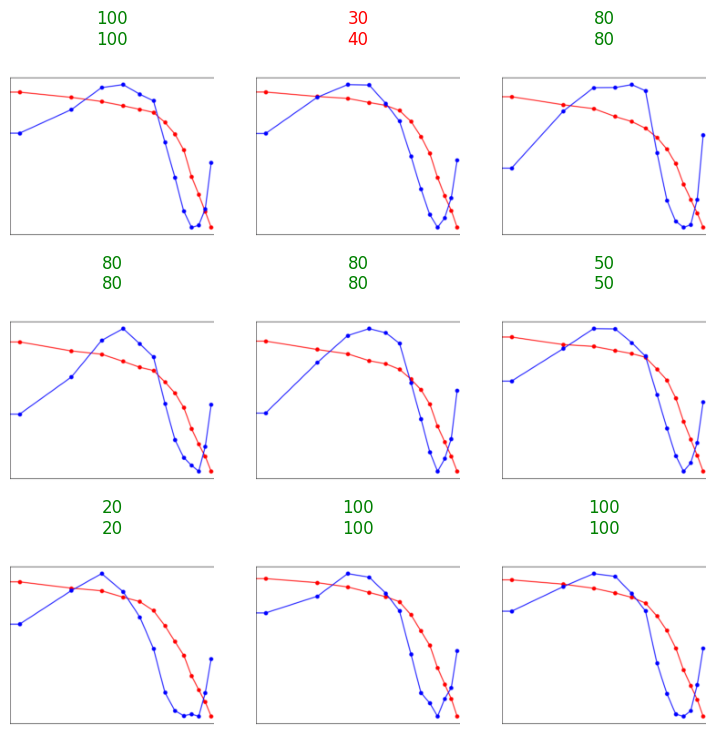

In [21]:
config['ExperimentName'] = "Paper_MES_v2_single__Exp_0"
config['IMAGES_PATH'] = config['root_images_path']+"/"+config['ExperimentName']
saved_weights = "Paper_MES_v2_single__Exp_0_1674294950.893247_SAVED"
#SCORE MODEL ON VALIDATION DATASET
dl= build_data_loader(config)
score_model(saved_weights,dl,config['models_path'])

### Score Sigle Model - Nyquist

Setting-up type transforms pipelines
Found 1700 items
2 datasets of sizes 1190,510
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      ../data/images/Paper_MES_v2_single__Exp_1/Paper_MES_v2_single__Exp_1-03_4006_80.png
    applying PILBase.create gives
      PILImage mode=RGB size=640x480
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../data/images/Paper_MES_v2_single__Exp_1/Paper_MES_v2_single__Exp_1-03_4006_80.png
    applying RegexLabeller gives
      80
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(8)

Final sample: (PILImage mode=RGB size=640x480, TensorCategory(8))


Found 1700 items
2 datasets of sizes 1190,510
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab'

[[48  0  0  0  0  0  0  0  0  0]
 [ 0 55  0  0  0  0  0  0  0  0]
 [ 0  0 57  0  0  0  0  0  0  0]
 [ 0  0  2 35  4  1  0  0  0  0]
 [ 0  0  0  8 39  2  0  0  0  0]
 [ 0  0  0  0  0 54  0  0  0  0]
 [ 0  0  0  0  0  0 53  0  0  0]
 [ 0  0  0  0  0  0  0 46  7  0]
 [ 0  0  0  0  0  0  0  7 46  0]
 [ 0  0  0  0  0  0  0  0  0 46]]
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.04761905 0.83333333 0.0952381  0.02380952
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.16326531 0.79591837 0.04081633
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        ]
 [0.       

learn.validate()


Model accuracy: 0.94
learn.get_preds()


TensorBase(0.9392)

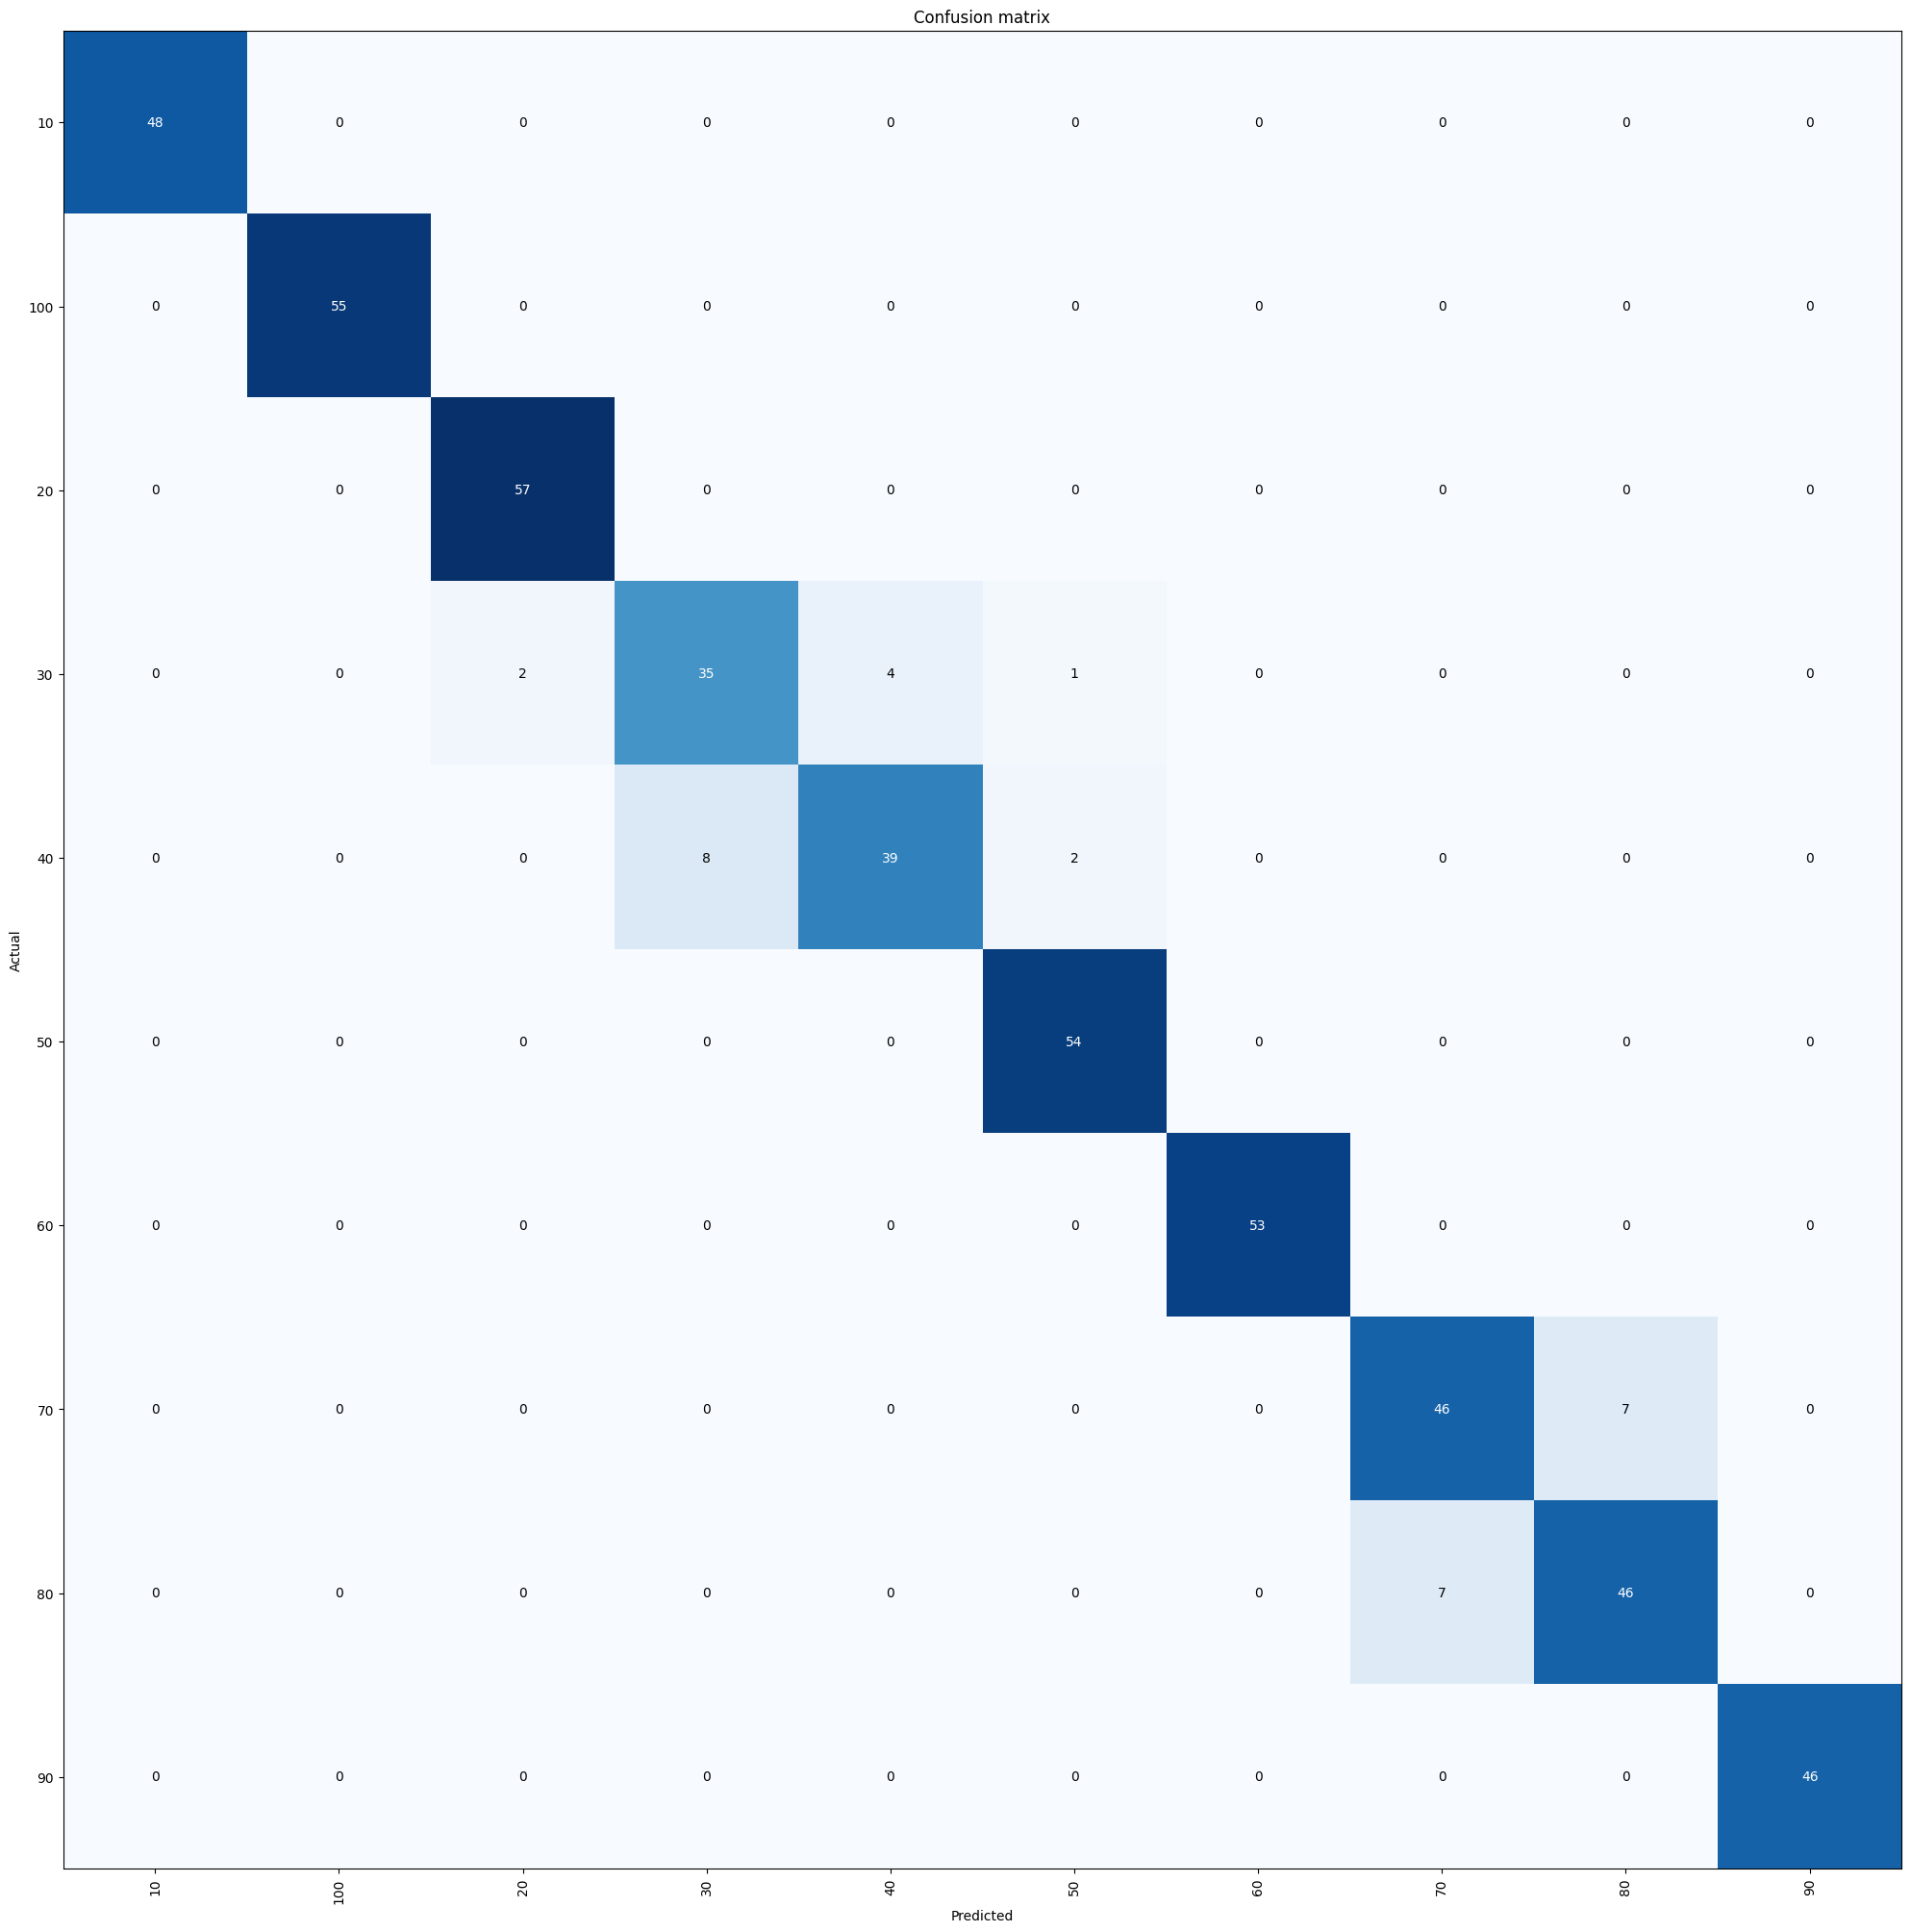

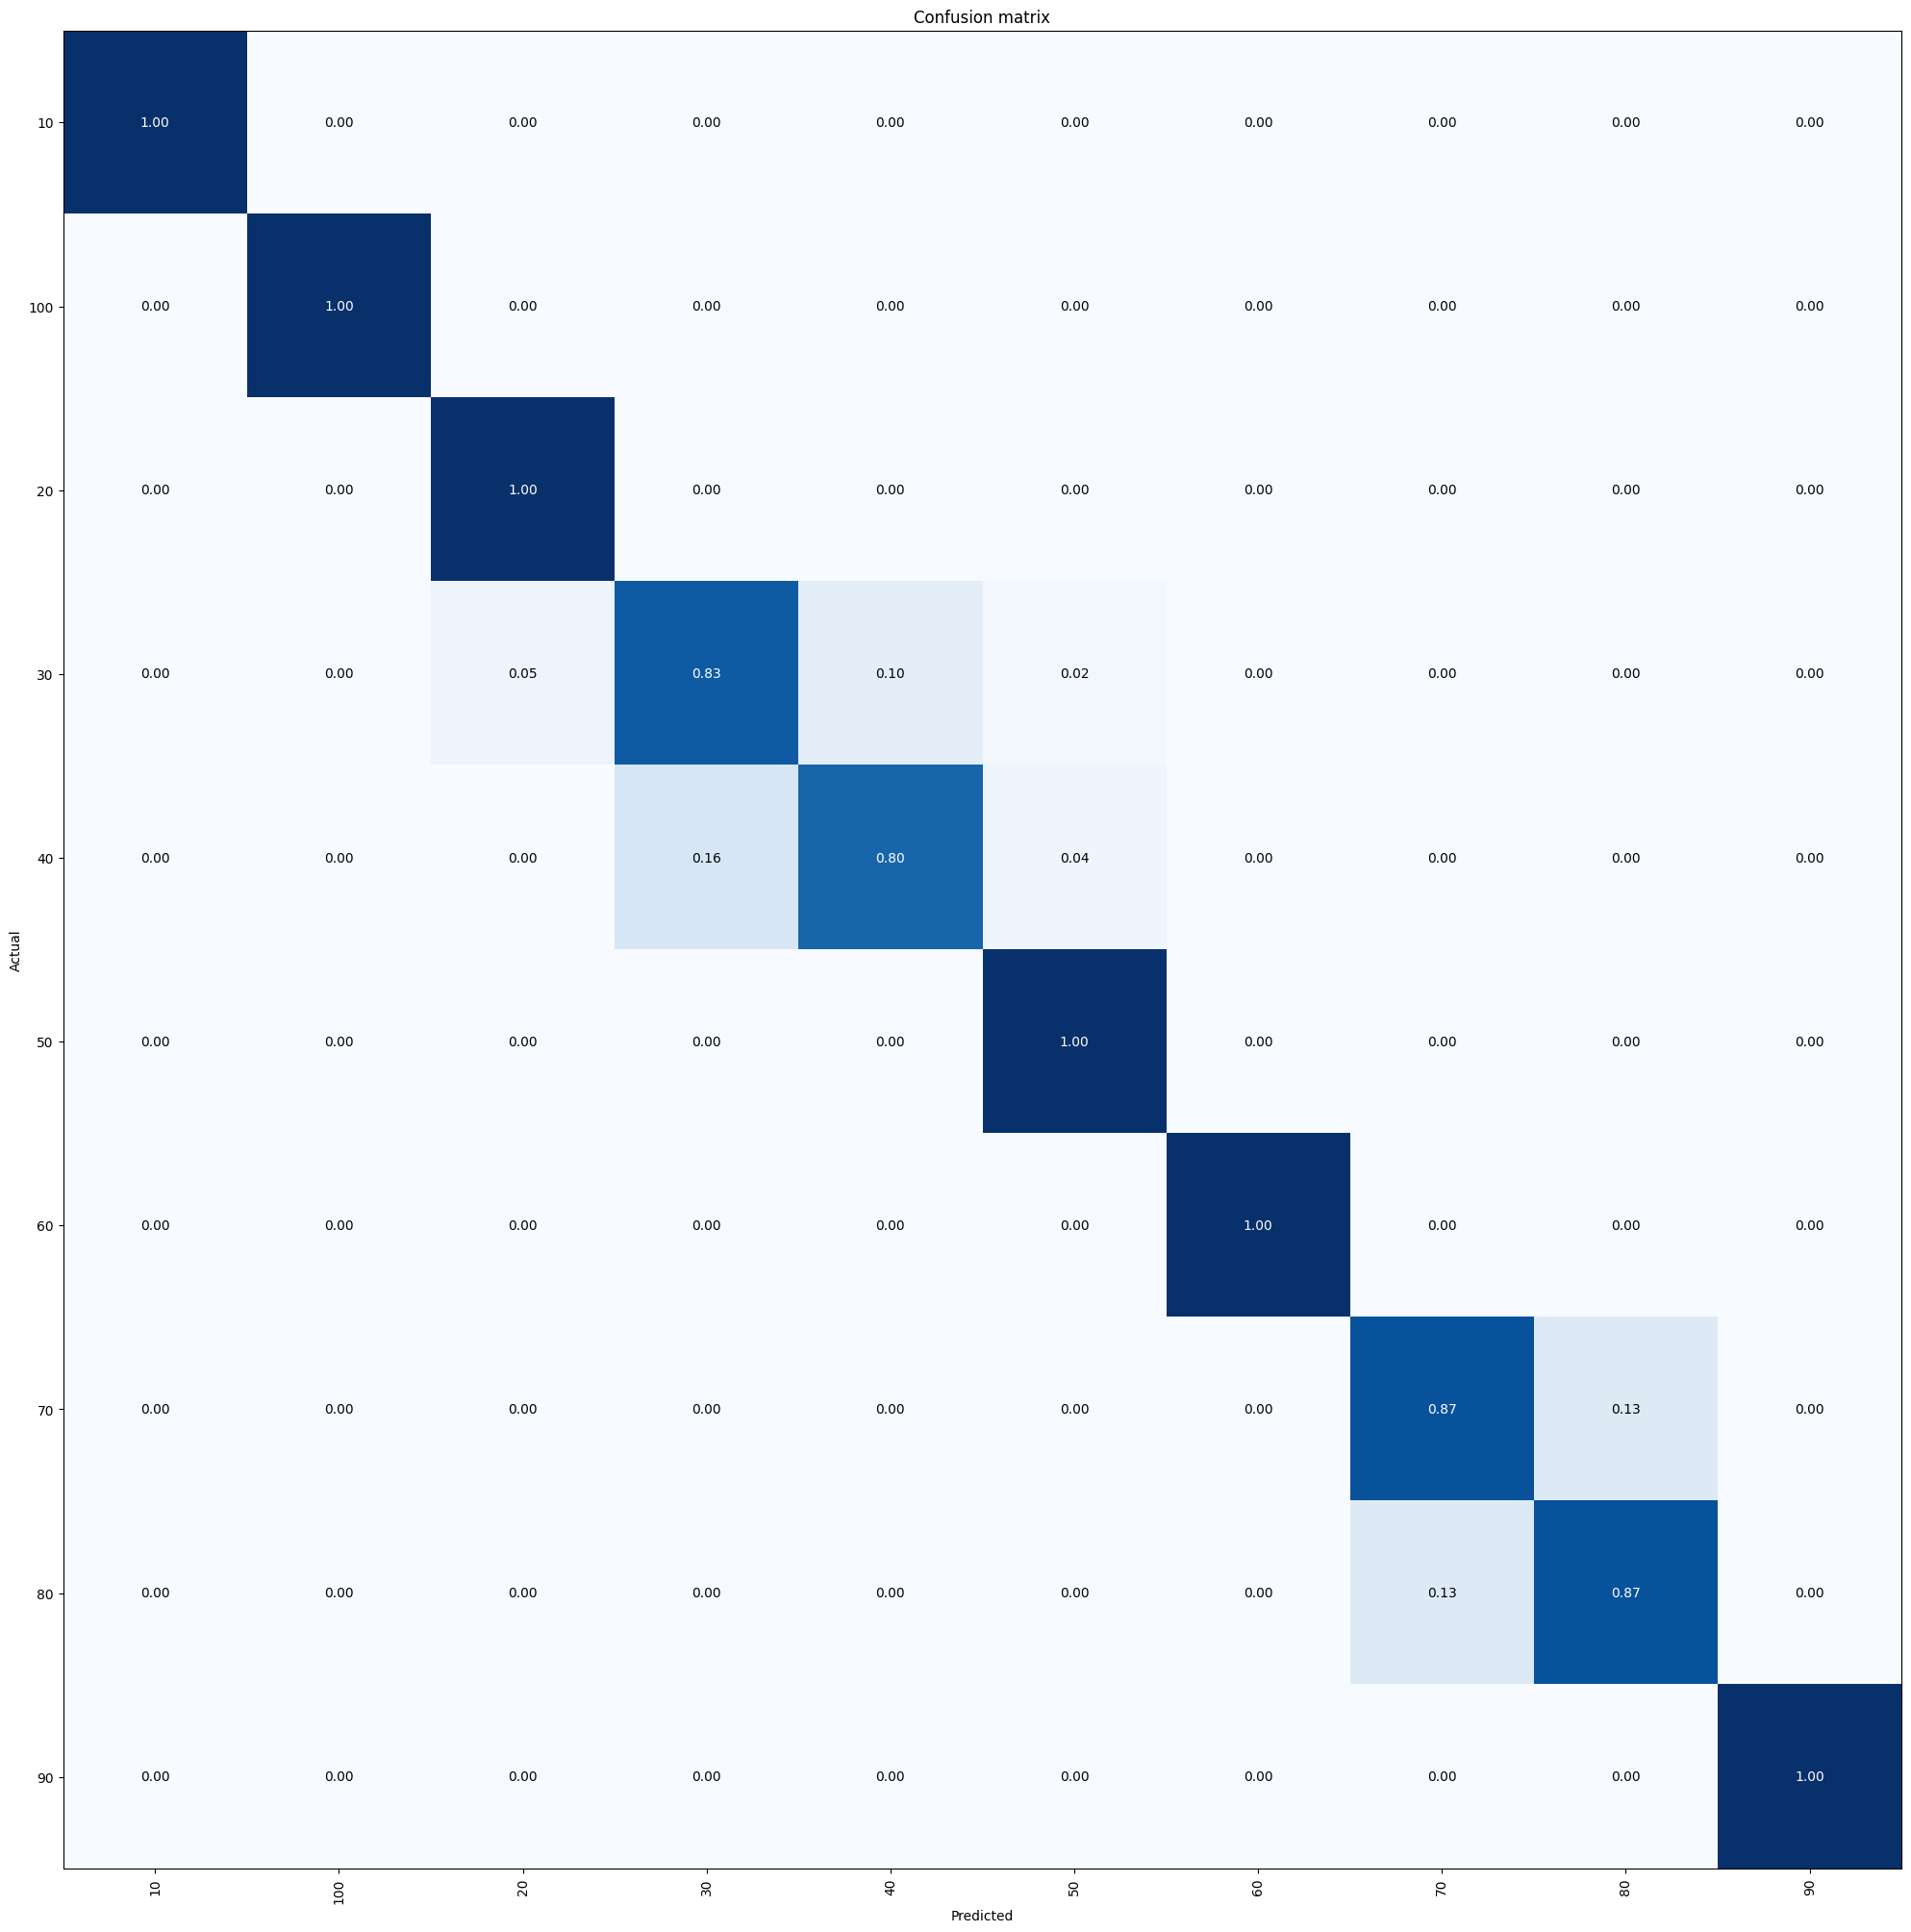

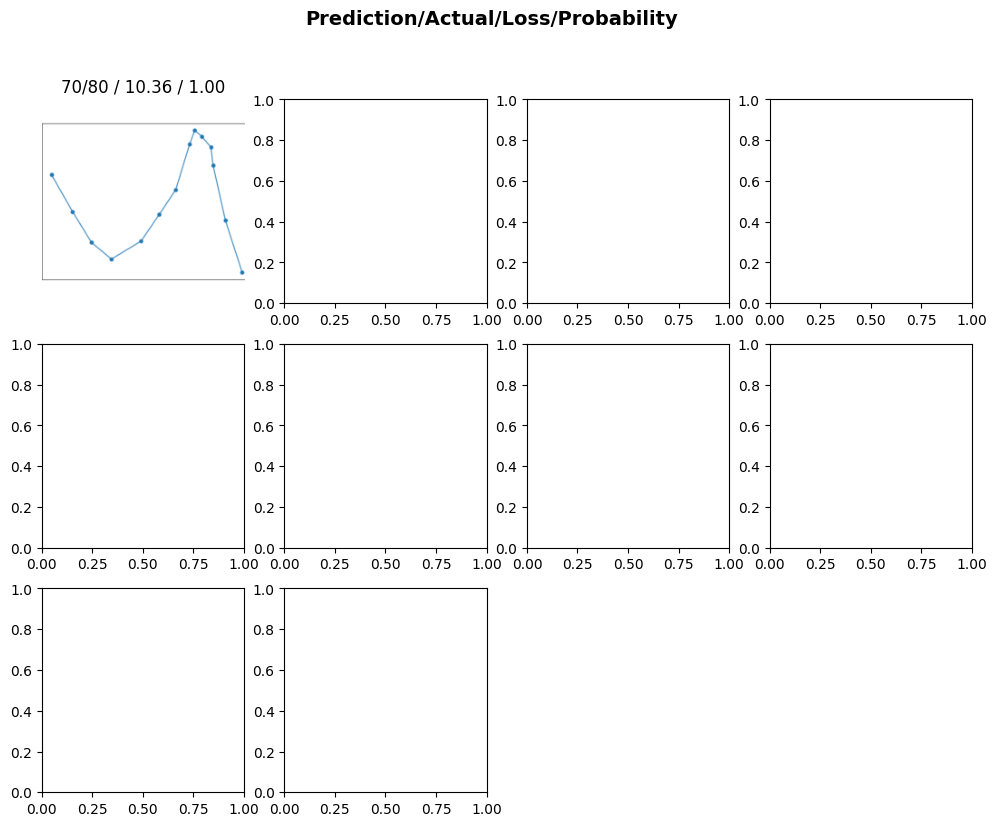

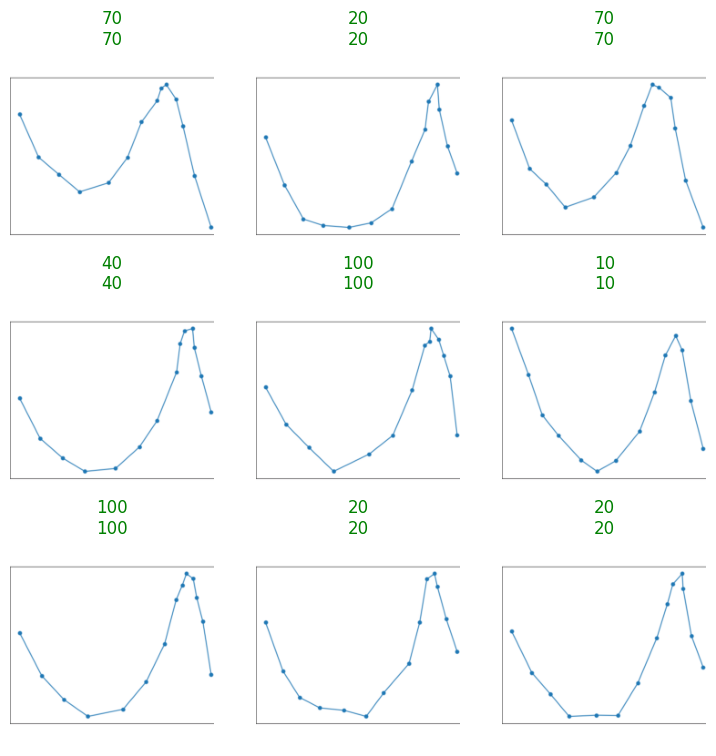

In [22]:
config['ExperimentName'] = "Paper_MES_v2_single__Exp_1"
config['IMAGES_PATH'] = config['root_images_path']+"/"+config['ExperimentName']
config["TEST_IMAGES_PATH"]= "../data/test_images/Test_dataset_NEW_BATT_Exp_1"
saved_weights = "Paper_MES_v2_single__Exp_1_1674295349.009869_SAVED"
dl= build_data_loader(config)

#SCORE MODEL ON VALIDATION DATASET
score_model(saved_weights,dl,config['models_path'])

In [ ]:
print("target: ")
print(targets)
print("predictions (decoded):")
print(decoded)
print("classification errors (class distance):")
print(targets-decoded)

## Single - New battery test case - Mode: Nyquist

In [23]:
config['ExperimentName'] = "Paper_MES_v2_single__Exp_1"
config['IMAGES_PATH'] = config['root_images_path']+"/"+config['ExperimentName']
config["TEST_IMAGES_PATH"]= "../data/test_images/Test_dataset_NEW_BATT_Exp_1"
saved_weights = "Paper_MES_v2_single__Exp_1_1674295349.009869_SAVED"

In [24]:
test_fnames= get_image_files(config["TEST_IMAGES_PATH"])
#DATA LOADER
learn=build_learner(config)

learn.load(saved_weights)

test_dl = learn.dls.test_dl(test_fnames,with_labels=True)
predictions, targets, decoded = learn.get_preds(dl=test_dl, with_decoded=True)
model_accuracy= accuracy(predictions,targets)
from sklearn.metrics import top_k_accuracy_score
model_top2_accuracy= top_k_accuracy_score(targets, predictions, k=2)
print("model_accuracy: " + str(model_accuracy))
print("model_top2_accuracy: " + str(model_top2_accuracy))

Setting-up type transforms pipelines
Found 1700 items
2 datasets of sizes 1190,510
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      ../data/images/Paper_MES_v2_single__Exp_1/Paper_MES_v2_single__Exp_1-03_4006_80.png
    applying PILBase.create gives
      PILImage mode=RGB size=640x480
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../data/images/Paper_MES_v2_single__Exp_1/Paper_MES_v2_single__Exp_1-03_4006_80.png
    applying RegexLabeller gives
      80
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(8)

Final sample: (PILImage mode=RGB size=640x480, TensorCategory(8))


Found 1700 items
2 datasets of sizes 1190,510
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab'

model_accuracy: TensorBase(0.8100)
model_top2_accuracy: 0.946


In [ ]:
print("target: ")
print(targets)
print("predictions (decoded):")
print(decoded)
print("classification errors (class distance):")
print(targets-decoded)

## Single - New battery test case - Mode: Bode

In [25]:
config['ExperimentName'] = "Paper_MES_v2_single__Exp_0"
config['IMAGES_PATH'] = config['root_images_path']+"/"+config['ExperimentName']
config["TEST_IMAGES_PATH"]= "../data/test_images/Test_dataset_NEW_BATT_Exp_0"
saved_weights = "Paper_MES_v2_single__Exp_0_1674294950.893247_SAVED"

In [26]:
test_fnames= get_image_files(config["TEST_IMAGES_PATH"])
#DATA LOADER
learn=build_learner(config)

learn.load(saved_weights)

test_dl = learn.dls.test_dl(test_fnames,with_labels=True)
predictions, targets, decoded = learn.get_preds(dl=test_dl, with_decoded=True)
model_accuracy= accuracy(predictions,targets)
from sklearn.metrics import top_k_accuracy_score
model_top2_accuracy= top_k_accuracy_score(targets, predictions, k=2)
print("model_accuracy: " + str(model_accuracy))
print("model_top2_accuracy: " + str(model_top2_accuracy))

Setting-up type transforms pipelines
Found 1700 items
2 datasets of sizes 1190,510
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      ../data/images/Paper_MES_v2_single__Exp_0/Paper_MES_v2_single__Exp_0-03_4006_80.png
    applying PILBase.create gives
      PILImage mode=RGB size=640x480
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../data/images/Paper_MES_v2_single__Exp_0/Paper_MES_v2_single__Exp_0-03_4006_80.png
    applying RegexLabeller gives
      80
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(8)

Final sample: (PILImage mode=RGB size=640x480, TensorCategory(8))


Found 1700 items
2 datasets of sizes 1190,510
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab'

model_accuracy: TensorBase(0.7960)
model_top2_accuracy: 0.936


## Single - New measurement test case - Mode: Bode

In [27]:
config['ExperimentName'] = "Paper_MES_v2_single__Exp_0"
config['IMAGES_PATH'] = config['root_images_path']+"/"+config['ExperimentName']
config["TEST_IMAGES_PATH"]= "../data/test_images/Test_dataset_NEW_MEAS_Exp_0"
saved_weights = "Paper_MES_v2_single__Exp_0_1674294950.893247_SAVED"

In [28]:
test_fnames= get_image_files(config["TEST_IMAGES_PATH"])
#DATA LOADER
learn=build_learner(config)

learn.load(saved_weights)

test_dl = learn.dls.test_dl(test_fnames,with_labels=True)
predictions, targets, decoded = learn.get_preds(dl=test_dl, with_decoded=True)
model_accuracy= accuracy(predictions,targets)
from sklearn.metrics import top_k_accuracy_score
model_top2_accuracy= top_k_accuracy_score(targets, predictions, k=2)
print("model_accuracy: " + str(model_accuracy))
print("model_top2_accuracy: " + str(model_top2_accuracy))

Setting-up type transforms pipelines
Found 1700 items
2 datasets of sizes 1190,510
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      ../data/images/Paper_MES_v2_single__Exp_0/Paper_MES_v2_single__Exp_0-03_4006_80.png
    applying PILBase.create gives
      PILImage mode=RGB size=640x480
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../data/images/Paper_MES_v2_single__Exp_0/Paper_MES_v2_single__Exp_0-03_4006_80.png
    applying RegexLabeller gives
      80
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(8)

Final sample: (PILImage mode=RGB size=640x480, TensorCategory(8))


Found 1700 items
2 datasets of sizes 1190,510
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab'

model_accuracy: TensorBase(0.9300)
model_top2_accuracy: 0.99


In [ ]:
print("target: ")
print(targets)
print("predictions (decoded):")
print(decoded)
print("classification errors (class distance):")
print(targets-decoded)

## Single - New measurement test case - Mode: Nyquist

In [29]:
config['ExperimentName'] = "Paper_MES_v2_single__Exp_1"
config['IMAGES_PATH'] = config['root_images_path']+"/"+config['ExperimentName']
config["TEST_IMAGES_PATH"]= "../data/test_images/Test_dataset_NEW_MEAS_Exp_1"
saved_weights = "Paper_MES_v2_single__Exp_1_1674295349.009869_SAVED"

In [30]:
test_fnames= get_image_files(config["TEST_IMAGES_PATH"])
#DATA LOADER
learn=build_learner(config)

learn.load(saved_weights)

test_dl = learn.dls.test_dl(test_fnames,with_labels=True)
predictions, targets, decoded = learn.get_preds(dl=test_dl, with_decoded=True)
model_accuracy= accuracy(predictions,targets)
from sklearn.metrics import top_k_accuracy_score
model_top2_accuracy= top_k_accuracy_score(targets, predictions, k=2)
print("model_accuracy: " + str(model_accuracy))
print("model_top2_accuracy: " + str(model_top2_accuracy))

Setting-up type transforms pipelines
Found 1700 items
2 datasets of sizes 1190,510
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      ../data/images/Paper_MES_v2_single__Exp_1/Paper_MES_v2_single__Exp_1-03_4006_80.png
    applying PILBase.create gives
      PILImage mode=RGB size=640x480
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../data/images/Paper_MES_v2_single__Exp_1/Paper_MES_v2_single__Exp_1-03_4006_80.png
    applying RegexLabeller gives
      80
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(8)

Final sample: (PILImage mode=RGB size=640x480, TensorCategory(8))


Found 1700 items
2 datasets of sizes 1190,510
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab'

model_accuracy: TensorBase(0.8400)
model_top2_accuracy: 0.96


In [ ]:
print("target: ")
print(targets)
print("predictions (decoded):")
print(decoded)
print("classification errors (class distance):")
print(targets-decoded)

## Single - New measurement test case - Mode: Nyquist (Factor 20)

In [31]:
config['ExperimentName'] = "Paper_MES_X20_single__Exp_1"
config['IMAGES_PATH'] = config['root_images_path']+"/"+config['ExperimentName']
config["TEST_IMAGES_PATH"]= "../data/test_images/Test_dataset_NEW_MEAS_Exp_1"
saved_weights = "Paper_MES_X20_single__Exp_1_1674319540.025509_SAVED"

In [32]:
test_fnames= get_image_files(config["TEST_IMAGES_PATH"])
#DATA LOADER
learn=build_learner(config)

learn.load(saved_weights)

test_dl = learn.dls.test_dl(test_fnames,with_labels=True)
predictions, targets, decoded = learn.get_preds(dl=test_dl, with_decoded=True)
model_accuracy= accuracy(predictions,targets)
from sklearn.metrics import top_k_accuracy_score
model_top2_accuracy= top_k_accuracy_score(targets, predictions, k=2)
print("model_accuracy: " + str(model_accuracy))
print("model_top2_accuracy: " + str(model_top2_accuracy))

Setting-up type transforms pipelines
Found 3400 items
2 datasets of sizes 2380,1020
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      ../data/images/Paper_MES_X20_single__Exp_1/Paper_MES_X20_single__Exp_1-05_4011_40.png
    applying PILBase.create gives
      PILImage mode=RGB size=640x480
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../data/images/Paper_MES_X20_single__Exp_1/Paper_MES_X20_single__Exp_1-05_4011_40.png
    applying RegexLabeller gives
      40
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(4)

Final sample: (PILImage mode=RGB size=640x480, TensorCategory(4))


Found 3400 items
2 datasets of sizes 2380,1020
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'

model_accuracy: TensorBase(0.8600)
model_top2_accuracy: 0.96


In [ ]:
print("target: ")
print(targets)
print("predictions (decoded):")
print(decoded)
print("classification errors (class distance):")
print(targets-decoded)

[[ 97   0   0   0   0   0   0   0   0   0]
 [  0 106   0   0   0   0   0   0   0   0]
 [  0   0 135   0   0   0   0   0   0   0]
 [  0   0   1  84  11   0   0   0   0   0]
 [  0   1   0   8  85   3   0   0   0   0]
 [  0   0   0   1   1  90   0   0   0   0]
 [  0   0   0   0   0   0 116   0   0   0]
 [  0   0   0   0   0   0   0  81  15   0]
 [  0   0   0   0   0   0   0  17  77   2]
 [  0   0   0   0   0   0   0   0   4  85]]
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.01041667 0.875      0.11458333 0.
  0.         0.         0.         0.        ]
 [0.         0.01030928 0.         0.08247423 0.87628866 0.03092784
  0.         0.         0.         0.        ]
 [0.         0.         0.

learn.validate()


Model accuracy: 0.94
learn.get_preds()


TensorBase(0.9373)

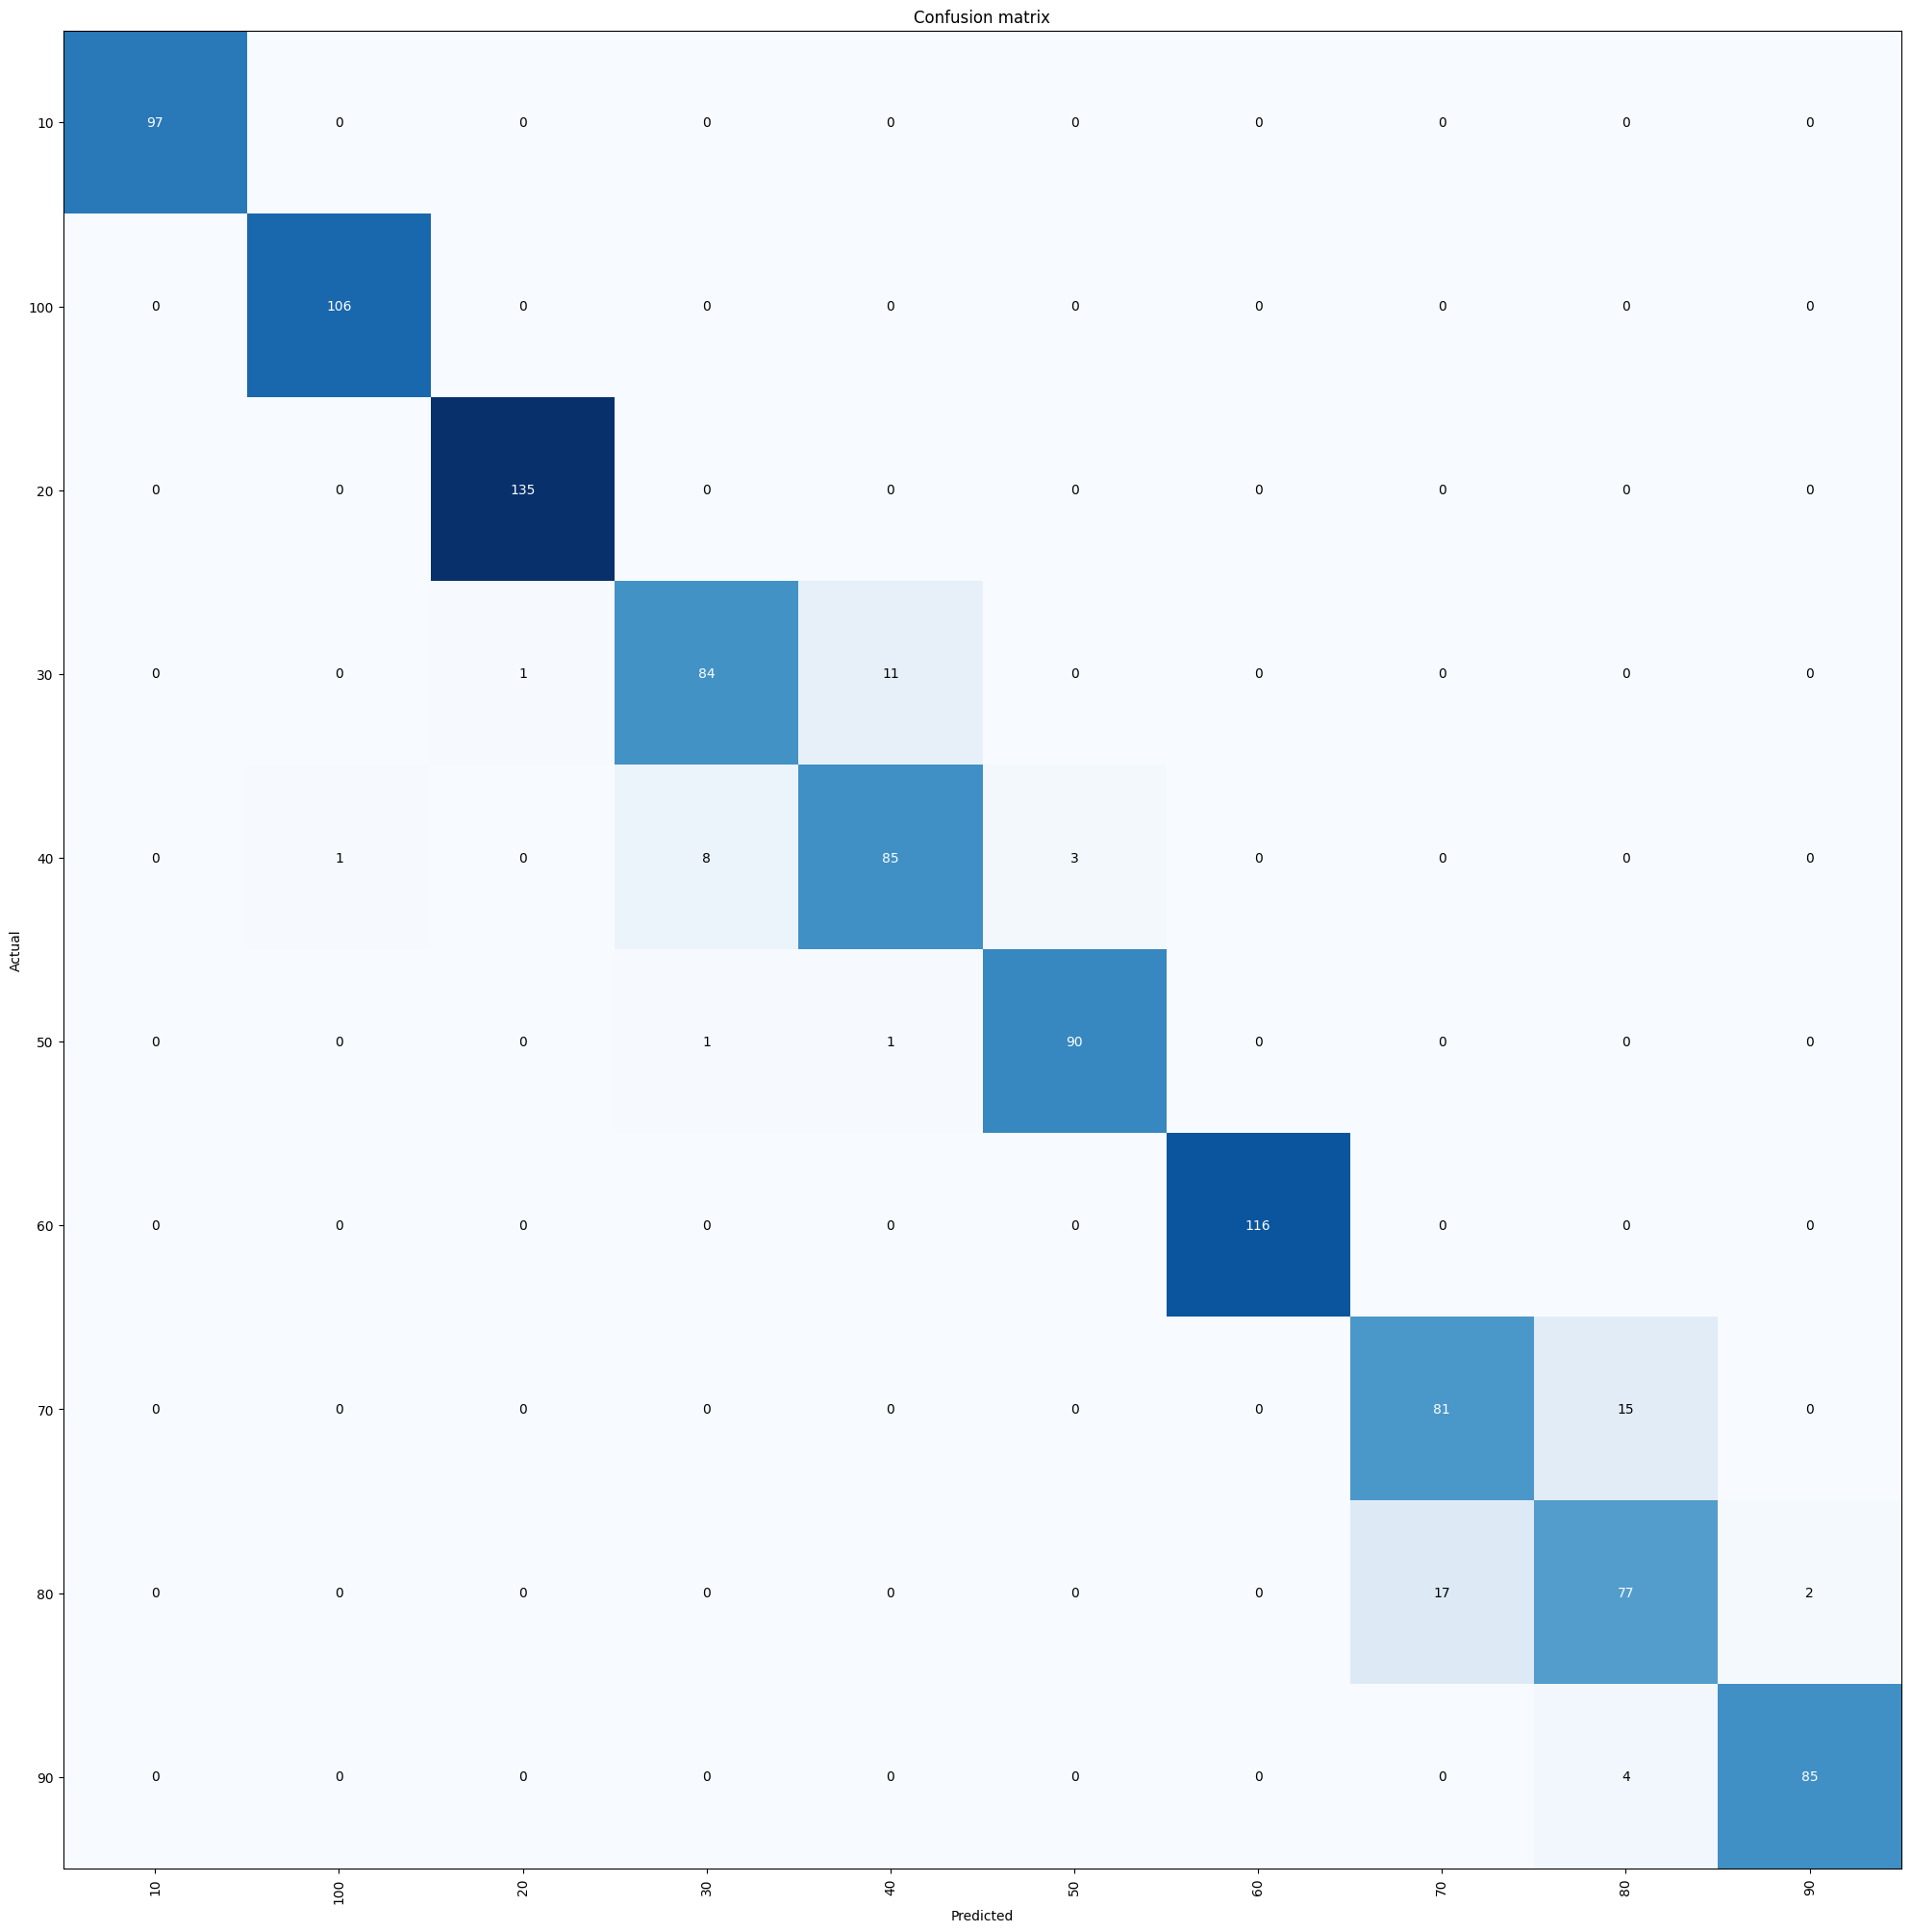

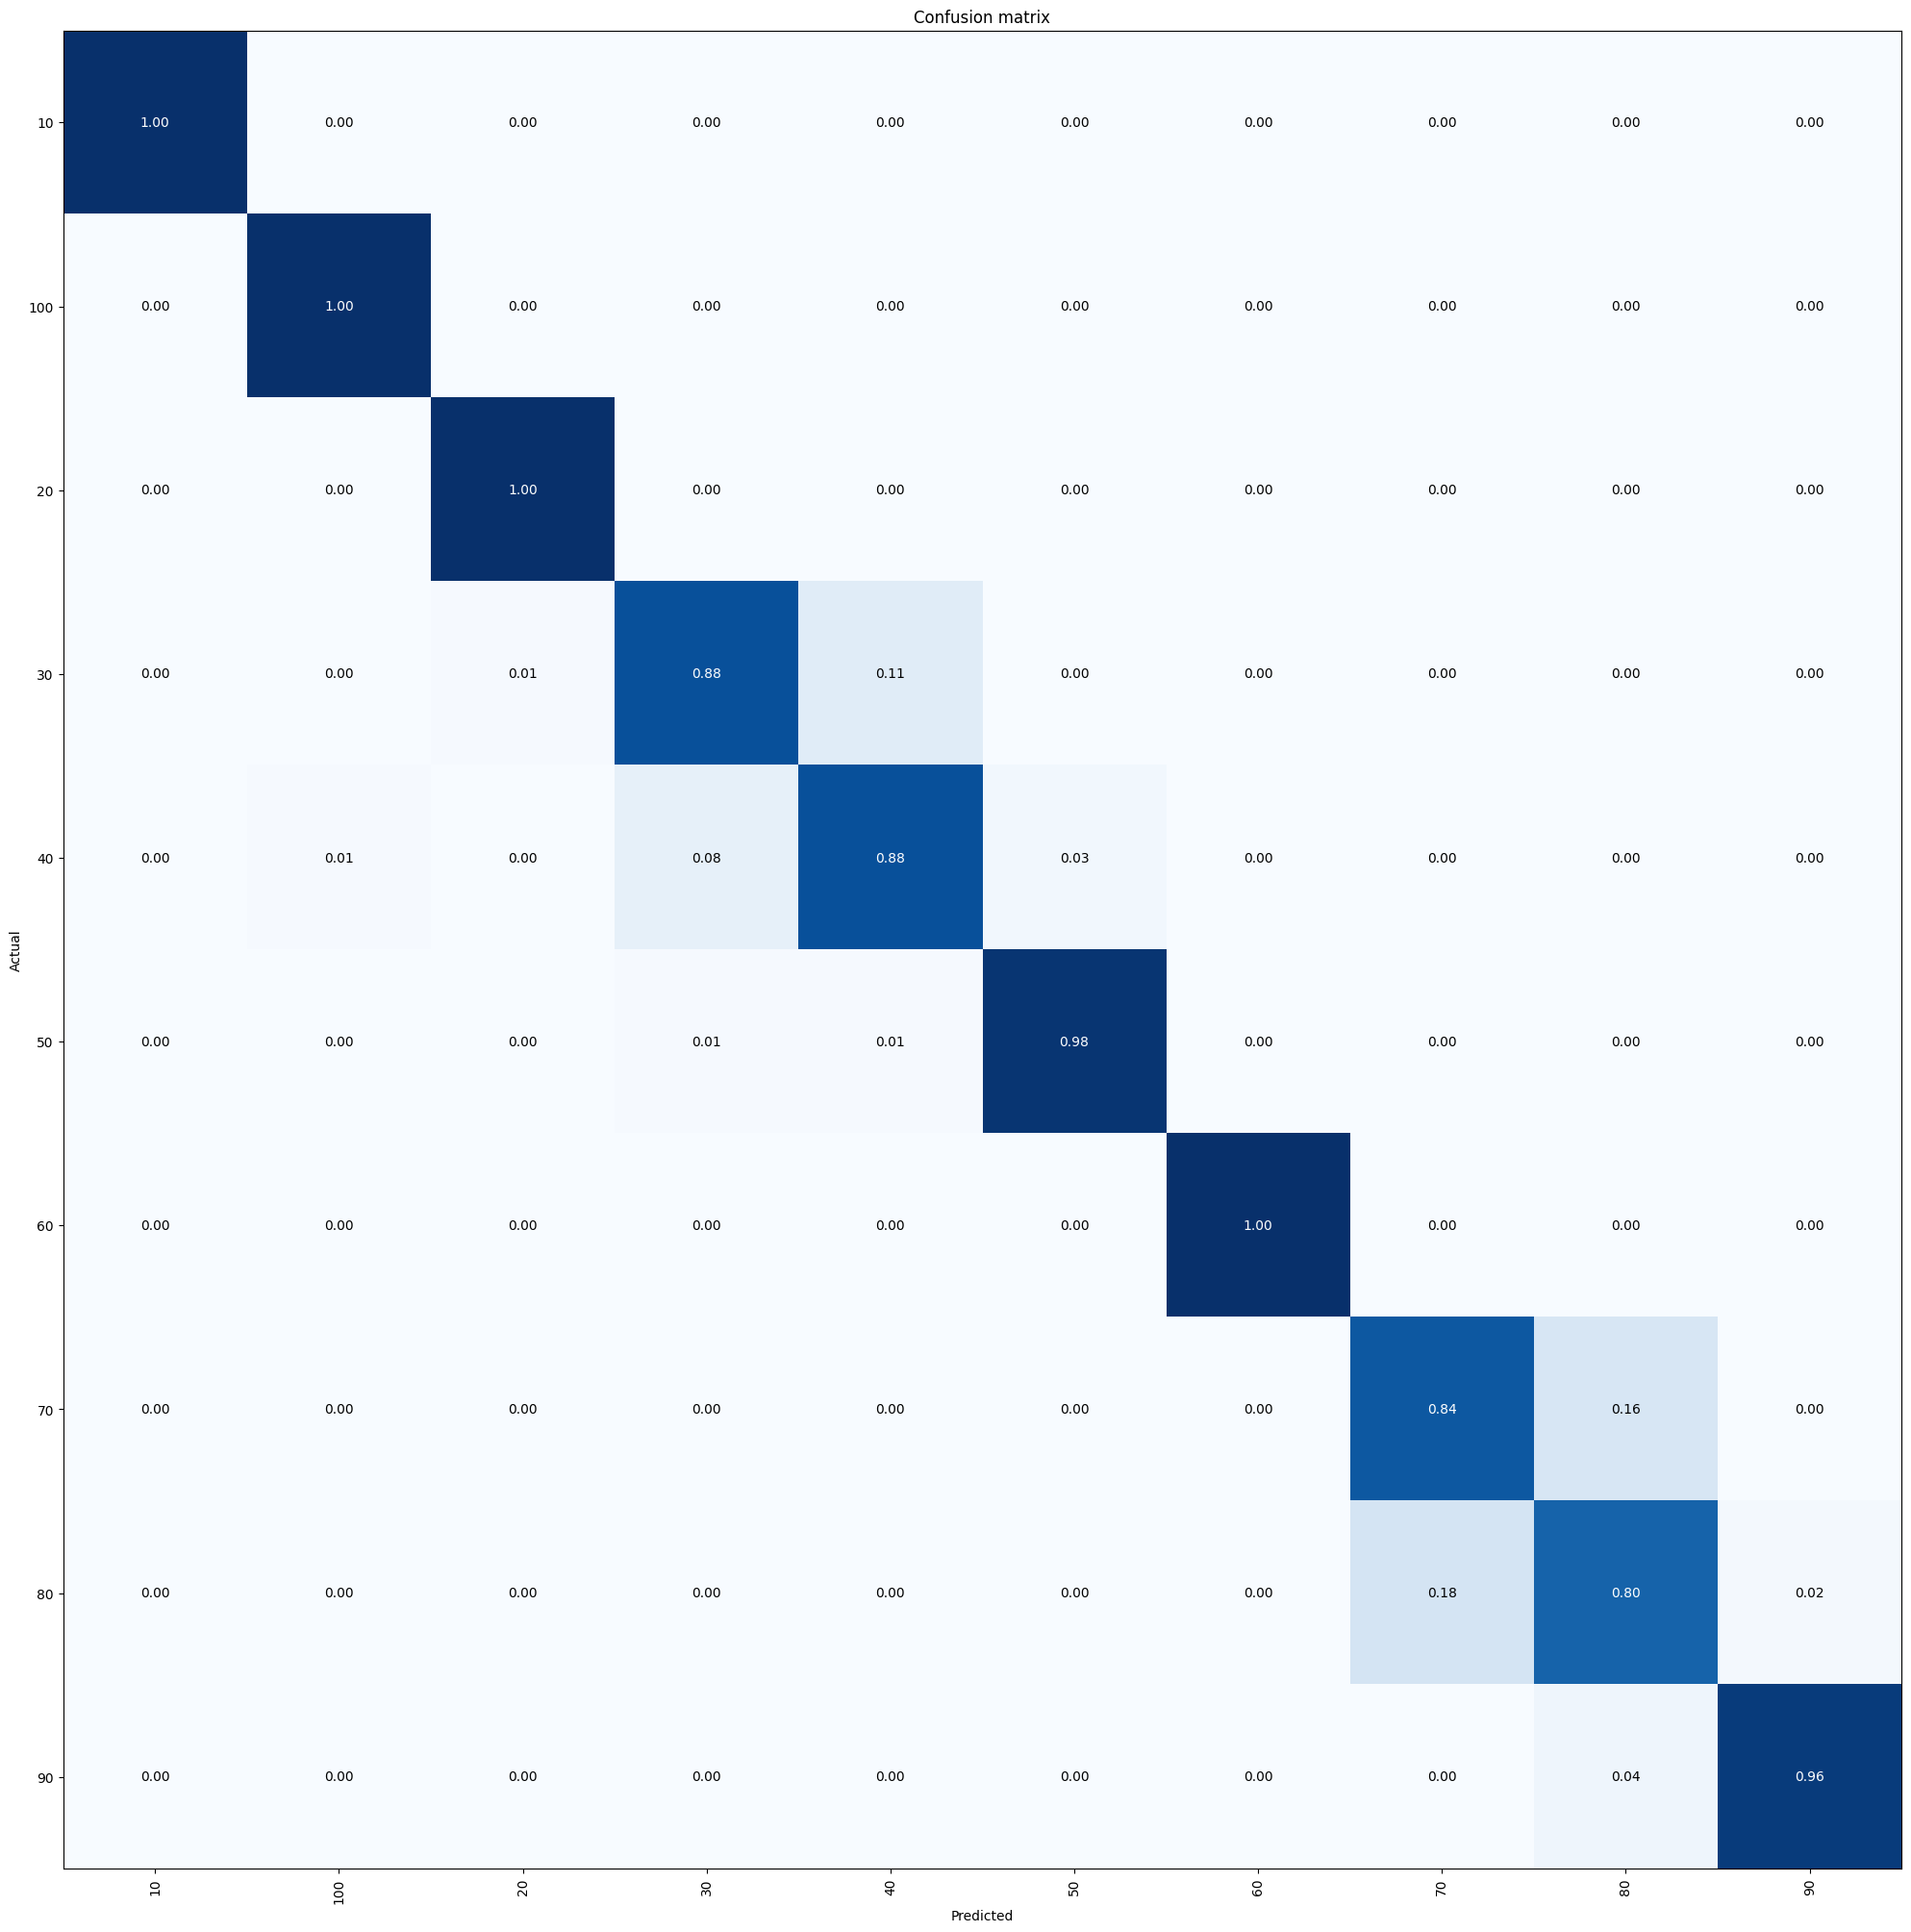

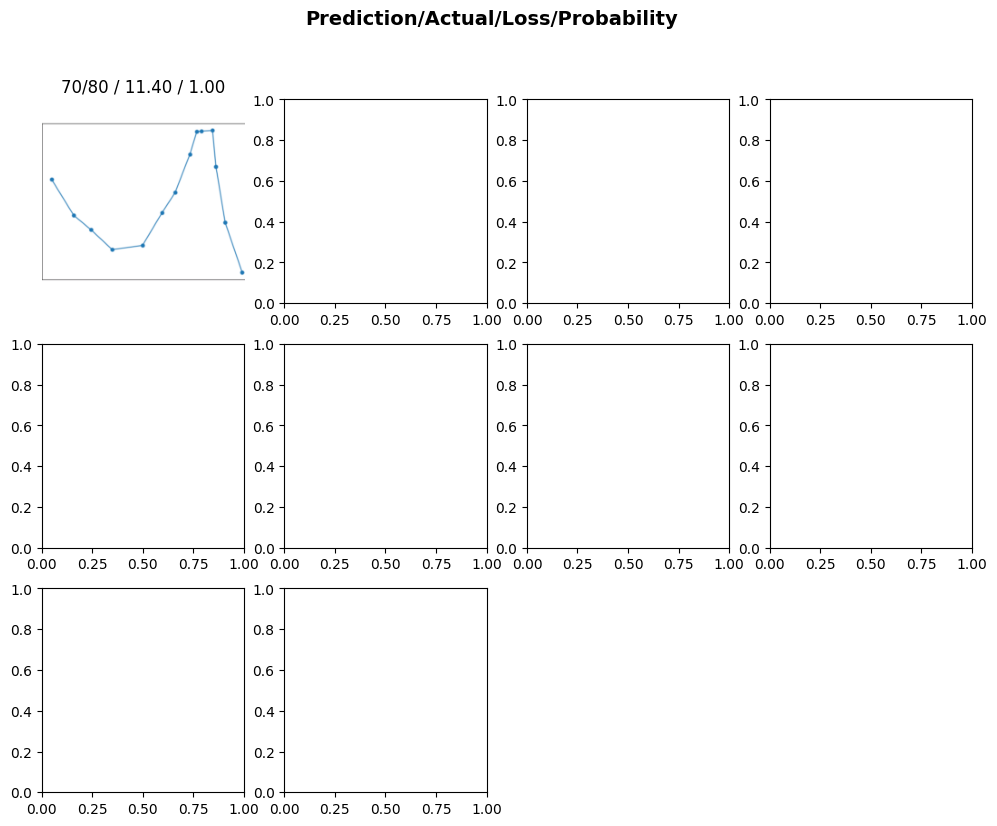

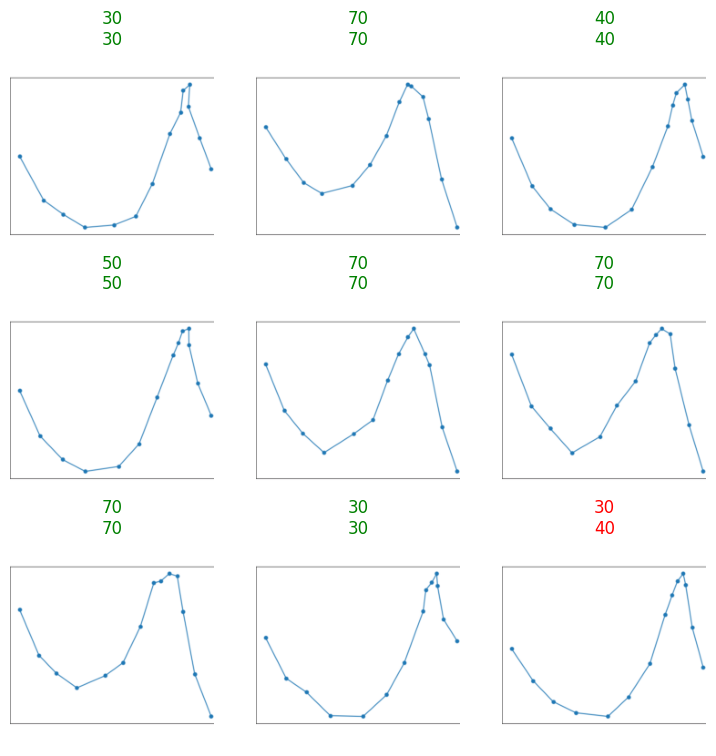

In [33]:
score_model(saved_weights,learn.dls,config["models_path"])

In [ ]:
score_model(saved_weights,learn.dls,config["models_path"])

## Single - New measurement test case - Mode: Bode (Factor 20)

In [34]:
config['ExperimentName'] = "Paper_MES_X20_single__Exp_0"
config['IMAGES_PATH'] = config['root_images_path']+"/"+config['ExperimentName']
config["TEST_IMAGES_PATH"]= "../data/test_images/Test_dataset_NEW_MEAS_Exp_0"
saved_weights = "Paper_MES_X20_single__Exp_0_1674318493.660378_SAVED"

In [35]:
test_fnames= get_image_files(config["TEST_IMAGES_PATH"])
#DATA LOADER
learn=build_learner(config)

learn.load(saved_weights)

test_dl = learn.dls.test_dl(test_fnames,with_labels=True)
predictions, targets, decoded = learn.get_preds(dl=test_dl, with_decoded=True)
model_accuracy= accuracy(predictions,targets)
from sklearn.metrics import top_k_accuracy_score
model_top2_accuracy= top_k_accuracy_score(targets, predictions, k=2)
print("model_accuracy: " + str(model_accuracy))
print("model_top2_accuracy: " + str(model_top2_accuracy))

Setting-up type transforms pipelines
Found 3400 items
2 datasets of sizes 2380,1020
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      ../data/images/Paper_MES_X20_single__Exp_0/Paper_MES_X20_single__Exp_0-05_4011_40.png
    applying PILBase.create gives
      PILImage mode=RGB size=640x480
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../data/images/Paper_MES_X20_single__Exp_0/Paper_MES_X20_single__Exp_0-05_4011_40.png
    applying RegexLabeller gives
      40
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(4)

Final sample: (PILImage mode=RGB size=640x480, TensorCategory(4))


Found 3400 items
2 datasets of sizes 2380,1020
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'

model_accuracy: TensorBase(0.9300)
model_top2_accuracy: 0.99


In [ ]:
print("target: ")
print(targets)
print("predictions (decoded):")
print(decoded)
print("classification errors (class distance):")
print(targets-decoded)

[[ 97   0   0   0   0   0   0   0   0   0]
 [  0 101   0   3   2   0   0   0   0   0]
 [  0   0 135   0   0   0   0   0   0   0]
 [  0   3   0  89   4   0   0   0   0   0]
 [  0   3   0   7  83   4   0   0   0   0]
 [  0   0   0   0   0  92   0   0   0   0]
 [  0   0   0   0   0   0 115   1   0   0]
 [  0   0   0   0   0   0   1  77  18   0]
 [  0   0   0   0   0   0   1  12  78   5]
 [  0   0   0   0   0   0   0   0   2  87]]
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.95283019 0.         0.02830189 0.01886792 0.
  0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.03125    0.         0.92708333 0.04166667 0.
  0.         0.         0.         0.        ]
 [0.         0.03092784 0.         0.07216495 0.8556701  0.04123711
  0.         0.         0.         0.        ]
 [0.         0.         0.

learn.validate()


Model accuracy: 0.94
learn.get_preds()


TensorBase(0.9353)

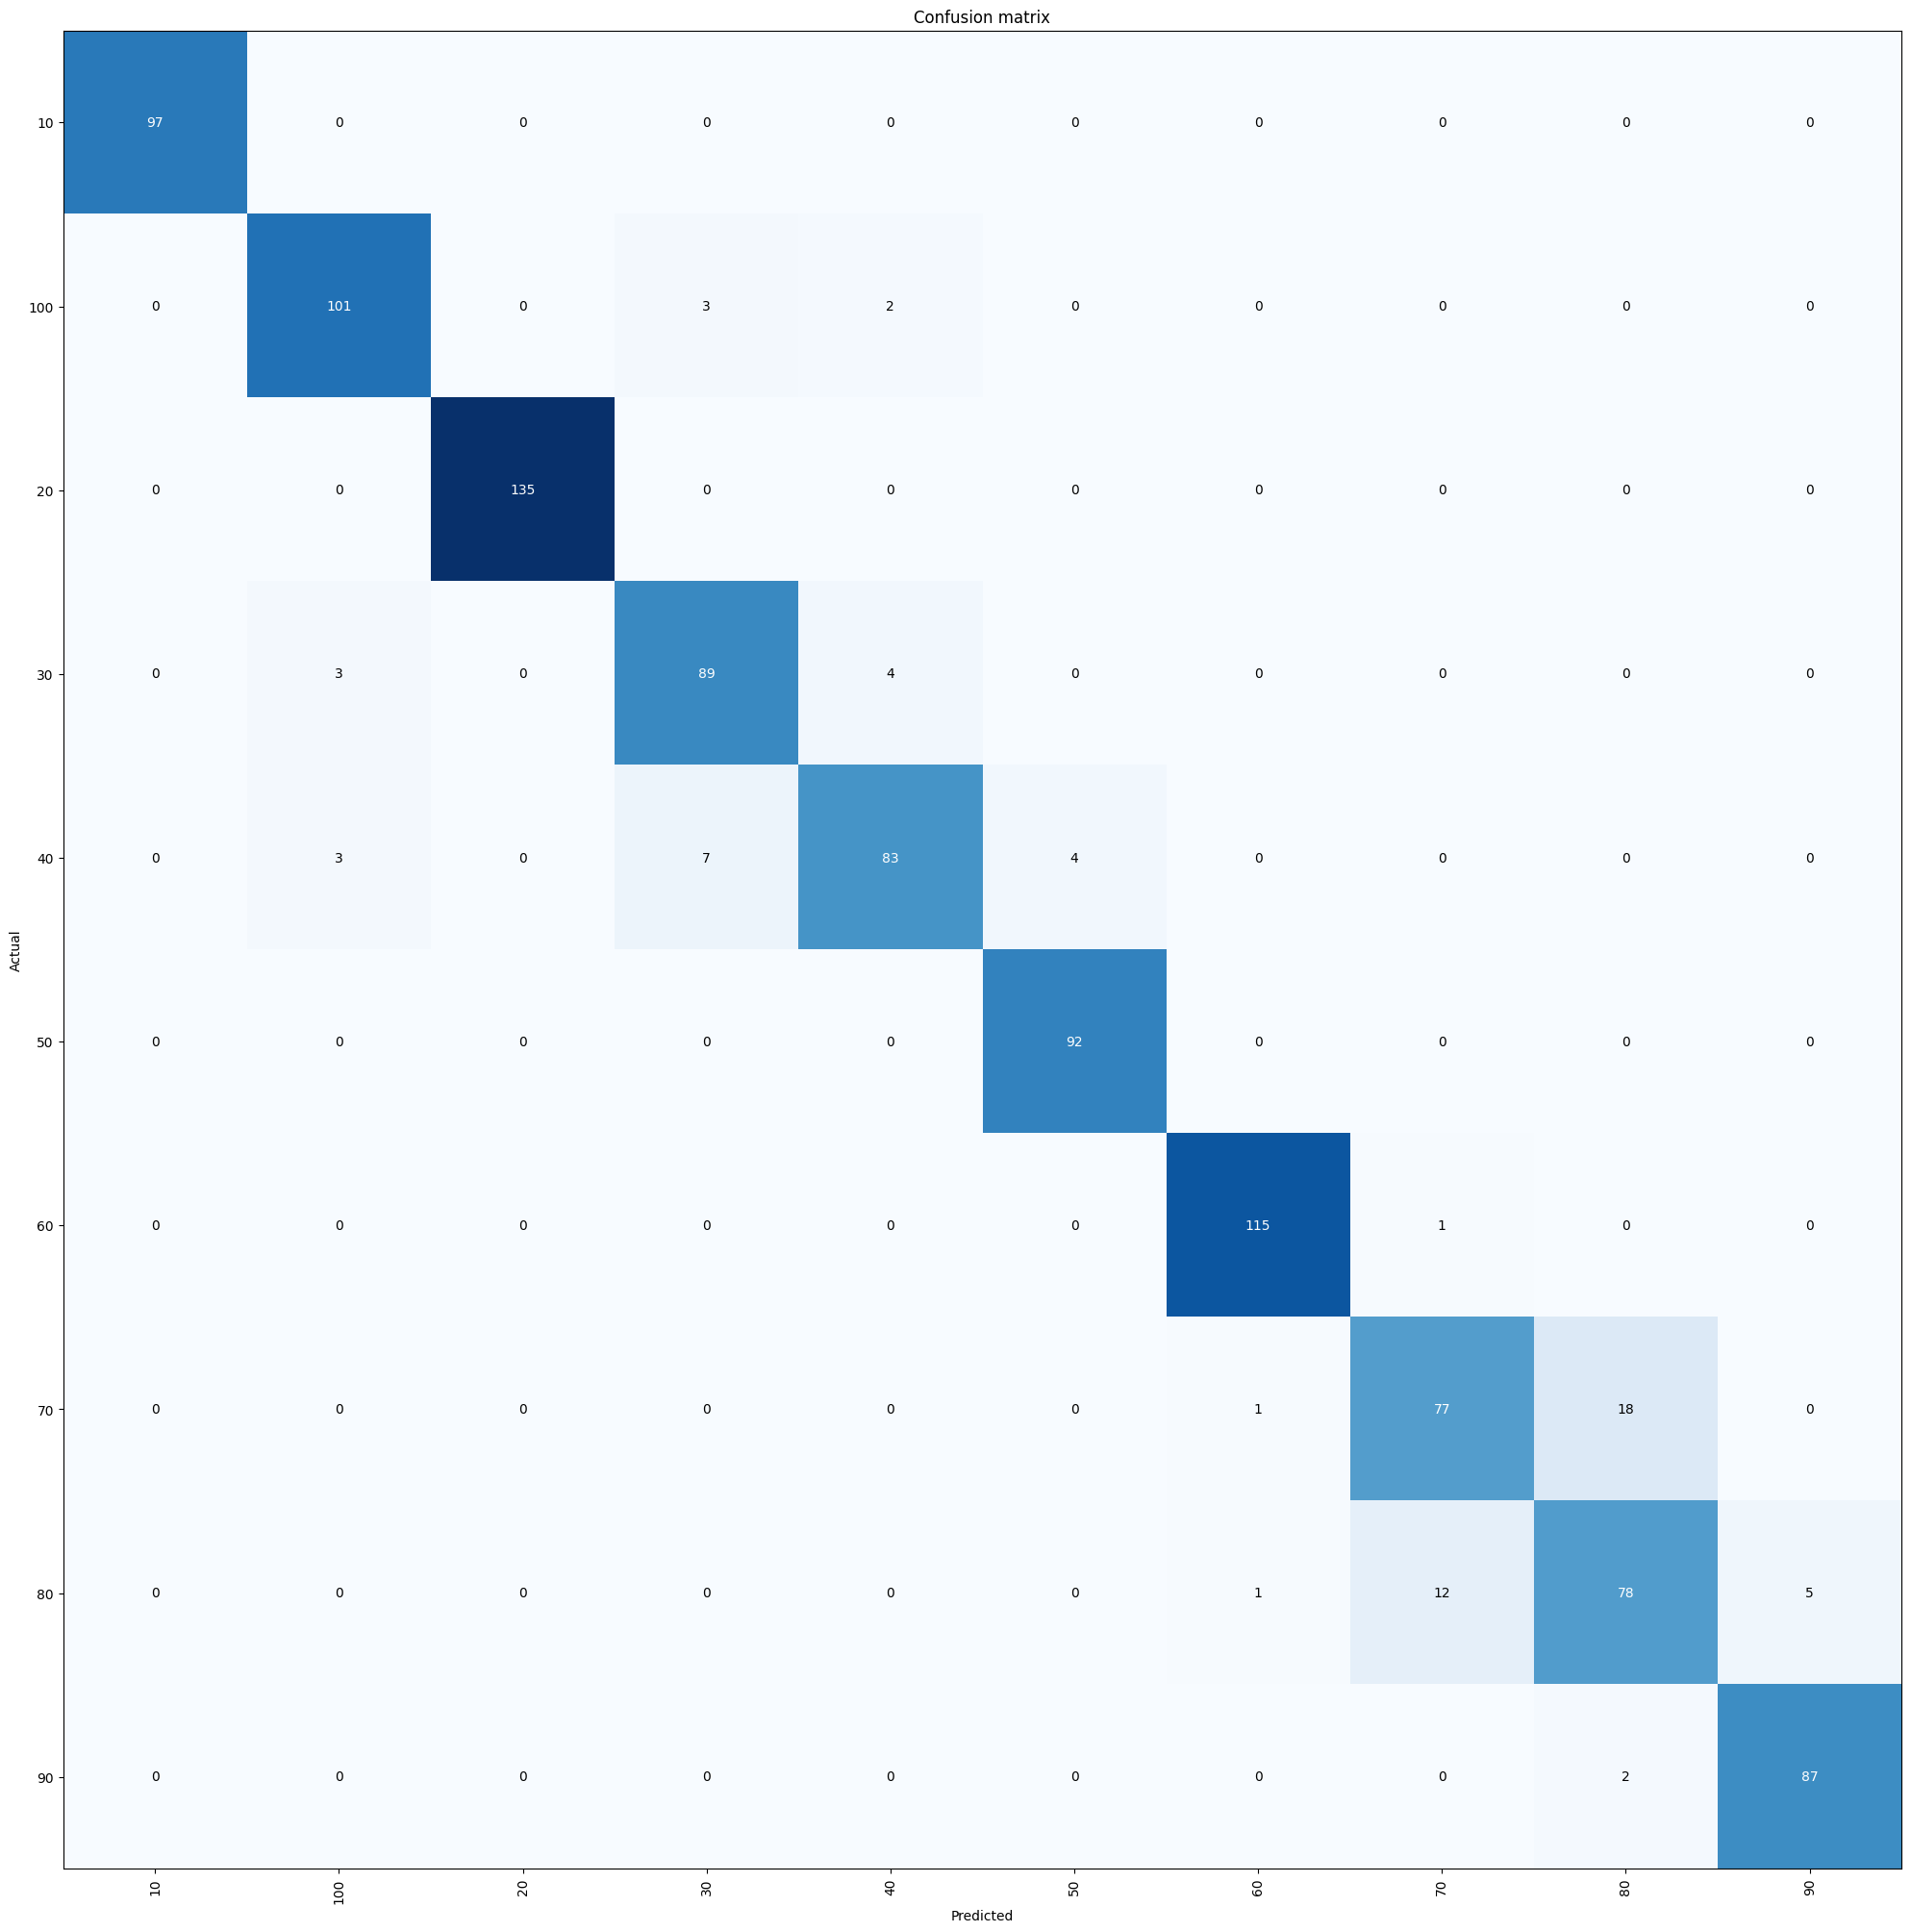

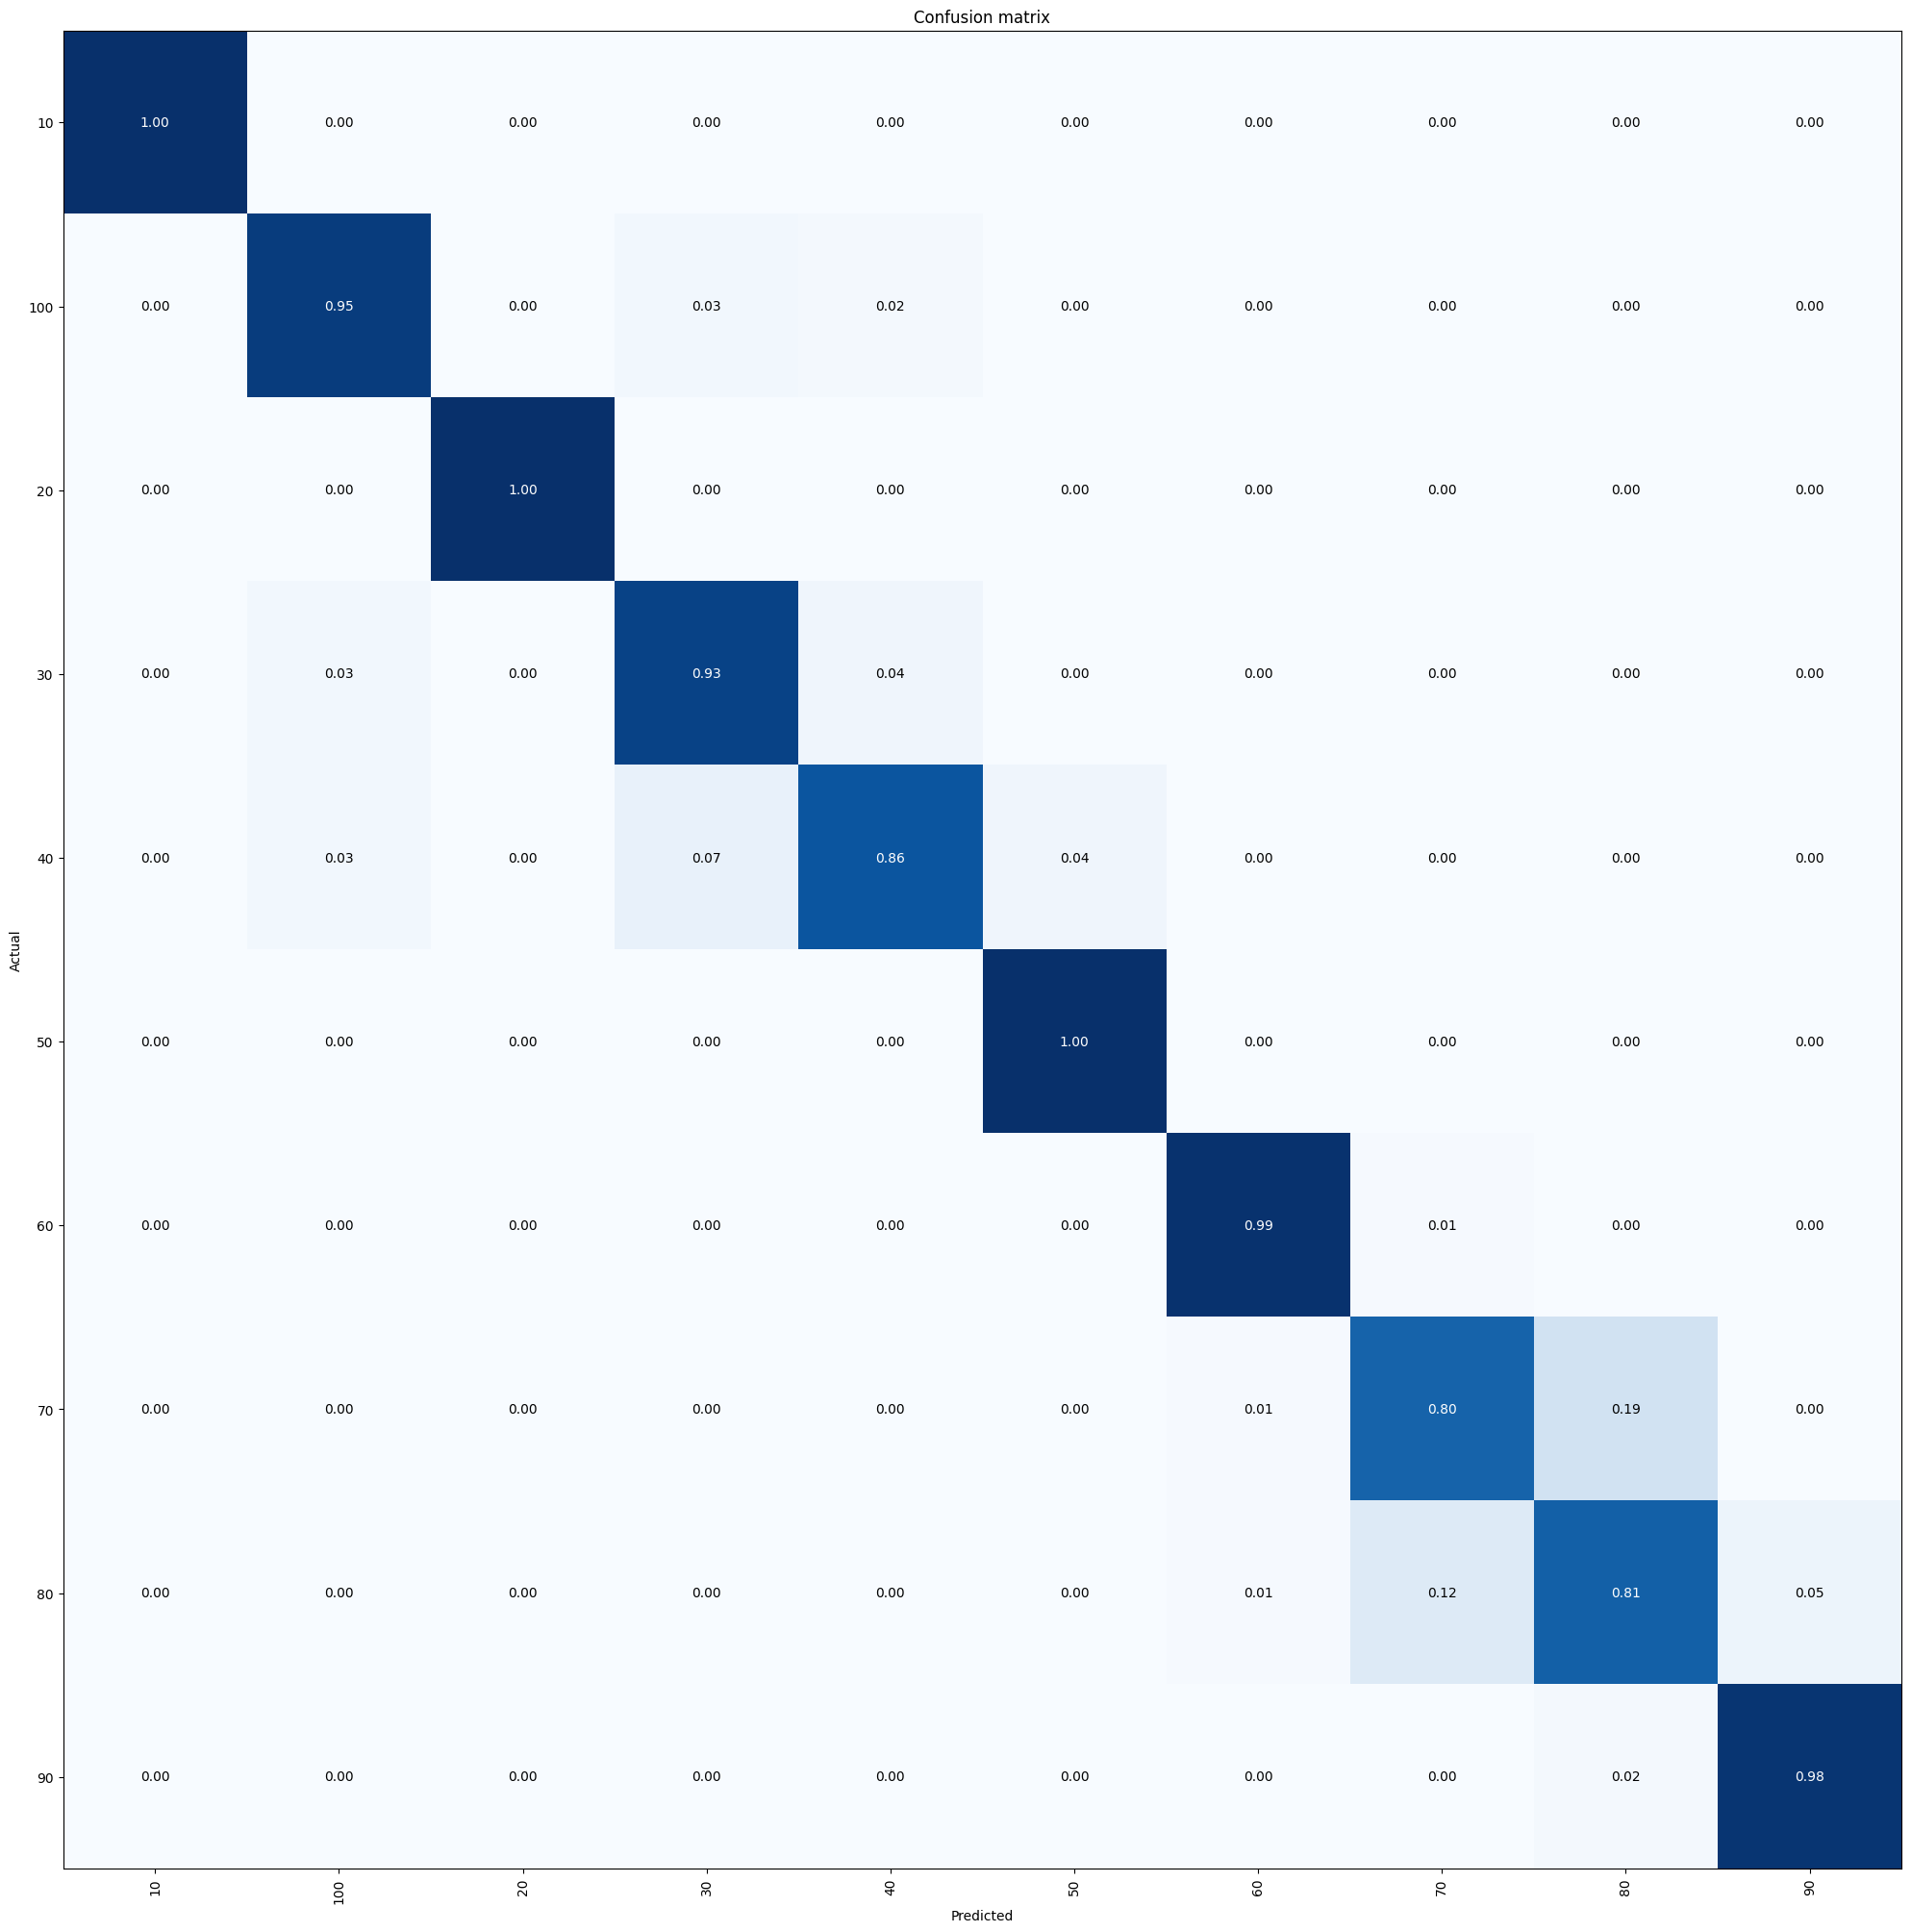

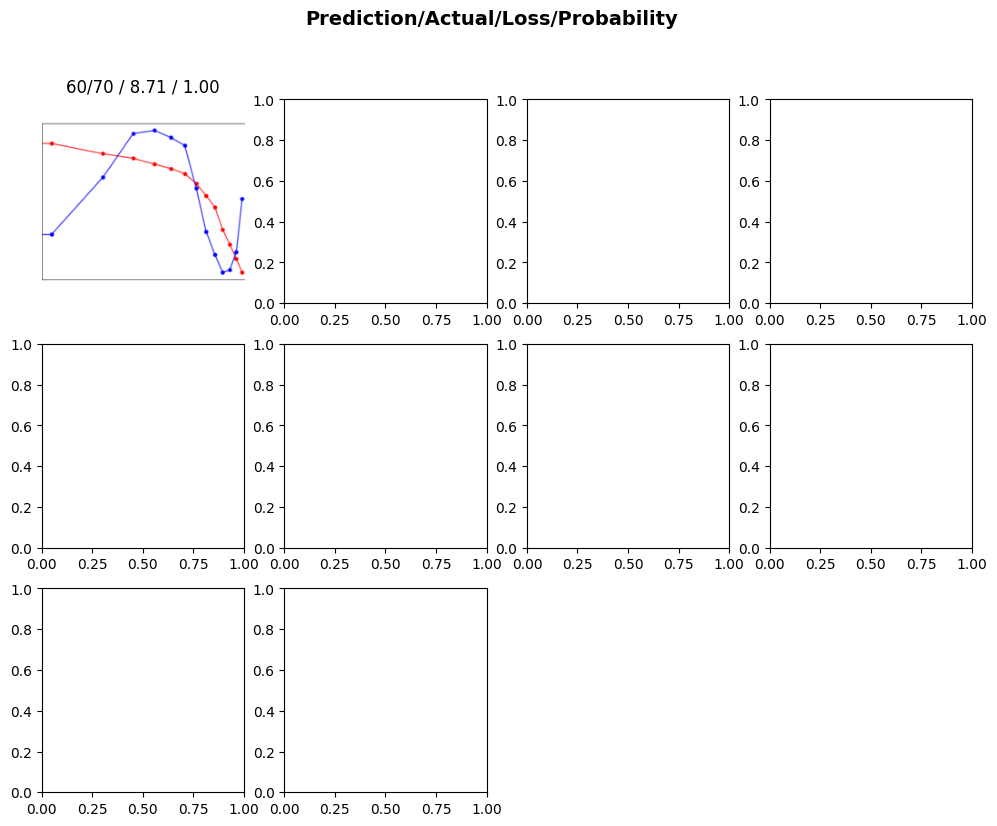

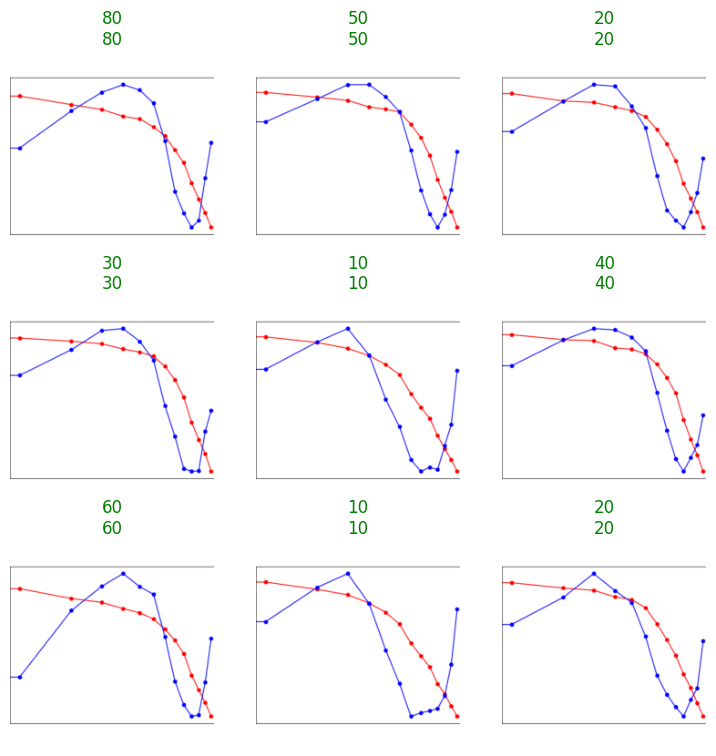

In [36]:
score_model(saved_weights,learn.dls,config["models_path"])